In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

In [3]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.relu(self.fc1(state.float()))
        actions = self.fc2(layer1)

        return actions

In [4]:
class Agent():
    def __init__(self,input_dims, n_actions, lr=0.01, gamma=0.99,
                 epsilon=1.0, eps_dec=1e-2, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        T_chws_set.value = action+6
        
        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
              if self.epsilon > self.eps_min else self.eps_min
        
    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.long).to(self.Q.device)
        actions = T.tensor(action, dtype=T.long).to(self.Q.device)
        rewards = T.tensor(reward, dtype=T.long).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.long).to(self.Q.device)

        q_pred = self.Q.forward(states)[actions]

        q_next = self.Q.forward(states_).max()

        q_target = rewards + self.gamma*q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss_value = loss.item()
        loss.backward()
        print(f"Loss: {loss_value}")

        self.Q.optimizer.step()
        self.decrement_epsilon()


In [5]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

from energyplus.dataset.basic import dataset as epds

env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build4/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./march4.idf',
    verbose=True,
)


In [6]:

import numpy as np
score_history = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

#agent = Agent(alpha=1e-5, gamma=0.99, n_actions=4)
episode_counter = 0

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass

0.0


In [7]:
score = 0
scores = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

agent = Agent(input_dims=10, n_actions=4)

for i in range(1, 6000):
    P_ch = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value
    powers.append(power)
    obs = []
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        obs.append(chiller_electricity_rate.value)
        power_sum += chiller_electricity_rate.value
    
    obs.append(T_outdoor.value)

    for chiller_evaporator_outlet_temp in T_chws:
        obs.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr:
        obs.append(chiller_evaporator_inlet_temp.value)
    
    reward = 120000/ (power_sum + 10000)

    score += reward

    action = agent.choose_action(obs)
    sm_stepf()

    P_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor_ = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws_ = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr_ = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set_ = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
            
    obs_ = []
    for chiller_electricity_rate in P_ch_:
        obs_.append(chiller_electricity_rate.value)

    obs_.append(T_outdoor_.value)

    for chiller_evaporator_outlet_temp in T_chws_:
        obs_.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr_:
        obs_.append(chiller_evaporator_inlet_temp.value)


    agent.learn(obs, action, reward, obs_)

    print(rf"Step={i}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

    setpoints.append(action + 6)

eps_history.append(agent.epsilon)

scores.append(score)

Step=1  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=9) 
Step=2  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=9) 
Step=3  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=8) 
Step=4  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=8) 
Step=5  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=8) 
Step=6  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=9) 
Step=7  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=9) 
Step=8  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=8) 
Step=9  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=6) 
Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=8) 
Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=9) 
Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=9) 
Step=13  P_c

Loss: 181.62408447265625
Loss: 143.4184112548828
Loss: 320.8058166503906
Loss: 230.23348999023438
Loss: 143.20579528808594
Loss: 258.3995056152344
Loss: 277.34185791015625
Loss: 142.6864776611328
Loss: 791.8486938476562
Loss: 143.06845092773438
Loss: 143.2243194580078
Loss: 143.14703369140625
Loss: 143.0770721435547
Loss: 143.01498413085938
Loss: 499.3047790527344
Loss: 273.5135192871094
Loss: 350.61407470703125
Loss: 143.56707763671875
Loss: 192.78663635253906


Step=19  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=20  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=21  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=22  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=9) 
Step=23  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=24  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=8) 
Step=25  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=6) 
Step=26  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=9) 
Step=27  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=28  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=6) 
Step=29  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=6) 
Step=30  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=6) 
Step=31  P_ch=(0.0, 0.0, 0.0))

Loss: 143.92897033691406
Loss: 253.27244567871094
Loss: 277.6687927246094
Loss: 143.4276123046875
Loss: 233.91468811035156
Loss: 143.44515991210938
Loss: 331.9891662597656
Loss: 143.53453063964844
Loss: 143.5720977783203
Loss: 143.6052703857422
Loss: 143.63442993164062
Loss: 143.66012573242188
Loss: 147.6405029296875
Loss: 178.51206970214844
Loss: 143.61294555664062
Loss: 174.26593017578125
Loss: 143.64263916015625
Loss: 143.66102600097656


Step=37  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.474999999999998) (T_chws_set=7) 
Step=38  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=6) 
Step=39  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=40  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=6) 
Step=41  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=6) 
Step=42  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=43  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=44  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=6) 
Step=45  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=46  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=8) 
Step=47  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=48  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
St

Loss: 171.8395538330078
Loss: 143.66943359375
Loss: 146.08892822265625
Loss: 143.64663696289062
Loss: 193.62905883789062
Loss: 143.52809143066406
Loss: 143.50677490234375
Loss: 202.5926971435547
Loss: 183.11485290527344
Loss: 164.63966369628906
Loss: 143.65960693359375
Loss: 184.9239501953125
Loss: 283.12762451171875
Loss: 143.5386199951172
Loss: 190.86361694335938
Loss: 143.65655517578125
Loss: 143.63296508789062


Step=54  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=8) 
Step=55  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=8) 
Step=56  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=8) 
Step=57  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=6) 
Step=58  P_ch=(5654.675373767082, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=9) 
Step=59  P_ch=(5654.675373767082, 0.0, 0.0)) Reward=7.6654416099286795 (T_outdoor=25.25) (T_chws_set=6) 
Step=60  P_ch=(8780.110684814463, 0.0, 0.0)) Reward=7.6654416099286795 (T_outdoor=25.375) (T_chws_set=6) 
Step=61  P_ch=(8780.110684814463, 0.0, 0.0)) Reward=6.38973869824056 (T_outdoor=25.375) (T_chws_set=6) 
Step=62  P_ch=(9866.62325267217, 0.0, 0.0)) Reward=3.86442093506718 (T_outdoor=25.5) (T_chws_set=9) 
Step=63  P_ch=(9866.62325267217, 0.0, 0.0)) Reward=6.040281656011135 (T_outdoor=25.5) (T_chws_set=9) 
Step=64  P_ch=(11999.133245014946, 0.0, 0.0)) Reward=6.040281656011135 (T_outdoor=2

Loss: 143.6112518310547
Loss: 143.5911865234375
Loss: 187.61033630371094
Loss: 384602.40625
Loss: 6.272756099700928
Loss: 157130.3125
Loss: 1.9912097454071045
Loss: 1416769.5
Loss: 29.270368576049805
Loss: 1515483.625
Loss: 36.60900115966797


Step=66  P_ch=(80836.57992021306, 0.0, 41277.26641706878)) Reward=5.4547603609425055 (T_outdoor=25.75) (T_chws_set=7) 
Step=67  P_ch=(80836.57992021306, 0.0, 41277.26641706878)) Reward=0.9083075190593147 (T_outdoor=25.75) (T_chws_set=7) 
Step=68  P_ch=(80836.57992021306, 0.0, 48692.48028932086)) Reward=0.9083075190593147 (T_outdoor=25.875) (T_chws_set=7) 
Step=69  P_ch=(80836.57992021306, 0.0, 48692.48028932086)) Reward=0.860035893739937 (T_outdoor=25.875) (T_chws_set=9) 
Step=70  P_ch=(80836.57992021306, 0.0, 46671.426898546815)) Reward=0.860035893739937 (T_outdoor=26.0) (T_chws_set=7) 
Step=71  P_ch=(80836.57992021306, 0.0, 46671.426898546815)) Reward=0.8726764555475232 (T_outdoor=26.0) (T_chws_set=7) 
Step=72  P_ch=(80836.57992021306, 0.0, 45592.86718255909)) Reward=0.8726764555475232 (T_outdoor=26.0) (T_chws_set=9) 
Step=73  P_ch=(80836.57992021306, 0.0, 45592.86718255909)) Reward=0.8795755062292683 (T_outdoor=26.0) (T_chws_set=9) 
Step=74  P_ch=(80836.57992021306, 18740.7557330452

Loss: 181186448.0
Loss: 10164.7353515625
Loss: 1306801.75
Loss: 839698240.0
Loss: 22677.30078125
Loss: 2316.485595703125
Loss: 51145.1015625
Loss: 5843.81103515625
Loss: 139190.203125
Loss: 46048.80078125
Loss: 23225.283203125
Loss: 68956.5
Loss: 35151.125



Step=79  P_ch=(80836.57992021306, 15134.465172290618, 80836.57992021306)) Reward=0.6423720658716747 (T_outdoor=26.0) (T_chws_set=9) 
Step=80  P_ch=(80836.57992021306, 15389.565995128398, 80836.57992021306)) Reward=0.6423720658716747 (T_outdoor=26.3) (T_chws_set=9) 
Step=81  P_ch=(80836.57992021306, 15389.565995128398, 80836.57992021306)) Reward=0.6414960514661329 (T_outdoor=26.3) (T_chws_set=9) 
Step=82  P_ch=(80836.57992021306, 15337.22343090671, 80836.57992021306)) Reward=0.6414960514661329 (T_outdoor=26.6) (T_chws_set=9) 
Step=83  P_ch=(80836.57992021306, 15337.22343090671, 80836.57992021306)) Reward=0.6416756005782436 (T_outdoor=26.6) (T_chws_set=9) 
Step=84  P_ch=(80836.57992021306, 15185.590737427863, 80836.57992021306)) Reward=0.6416756005782436 (T_outdoor=26.9) (T_chws_set=9) 
Step=85  P_ch=(80836.57992021306, 15185.590737427863, 80836.57992021306)) Reward=0.6421963093989674 (T_outdoor=26.9) (T_chws_set=9) 
Step=86  P_ch=(80836.57992021306, 14781.160362879982, 80836.5799202130

Loss: 87868.2421875
Loss: 116651.6015625
Loss: 99611.7421875
Loss: 96823.0703125
Loss: 104329.0
Loss: 82630.421875
Loss: 101030.859375
Loss: 68320.9765625
Loss: 90548.09375
Loss: 28140.71875
Loss: 74091.3515625
Loss: 149258.46875
Loss: 64988.1484375
Loss: 2375.80078125



Step=93  P_ch=(80836.57992021306, 11815.732187180307, 80836.57992021306)) Reward=0.6539905422827756 (T_outdoor=27.8) (T_chws_set=9) 
Step=94  P_ch=(80836.57992021306, 11402.161805440035, 80836.57992021306)) Reward=0.6539905422827756 (T_outdoor=28.0) (T_chws_set=9) 
Step=95  P_ch=(80836.57992021306, 11402.161805440035, 80836.57992021306)) Reward=0.6554679184566633 (T_outdoor=28.0) (T_chws_set=9) 
Step=96  P_ch=(80836.57992021306, 11163.974963577844, 80836.57992021306)) Reward=0.6561278284851563 (T_outdoor=28.25) (T_chws_set=9) 
Step=97  P_ch=(80836.57992021306, 0.0, 44948.82555478011)) Reward=0.6563218141032262 (T_outdoor=28.5) (T_chws_set=9) 
Step=98  P_ch=(80836.57992021306, 0.0, 44948.82555478011)) Reward=0.8837474070223234 (T_outdoor=28.5) (T_chws_set=9) 
Step=99  P_ch=(80836.57992021306, 0.0, 44948.82555478011)) Reward=0.8837474070223234 (T_outdoor=28.5) (T_chws_set=9) 


Loss: 59787.890625
Loss: 7927.60693359375
Loss: 51342.0703125
Loss: 37770.25390625
Loss: 8604345.0
Loss: 24423.5234375
Loss: 18377.45703125
Loss: 123985.140625


Step=100  P_ch=(80836.57992021306, 0.0, 50919.02114809841)) Reward=0.8837474070223234 (T_outdoor=28.75) (T_chws_set=9) 
Step=101  P_ch=(80836.57992021306, 0.0, 50919.02114809841)) Reward=0.8465273971232535 (T_outdoor=28.75) (T_chws_set=9) 
Step=102  P_ch=(80836.57992021306, 0.0, 52944.01537219169)) Reward=0.8465273971232535 (T_outdoor=29.0) (T_chws_set=9) 
Step=103  P_ch=(80836.57992021306, 0.0, 52944.01537219169)) Reward=0.8346049740297536 (T_outdoor=29.0) (T_chws_set=9) 
Step=104  P_ch=(80836.57992021306, 0.0, 55001.37584714848)) Reward=0.8199109225467811 (T_outdoor=29.0) (T_chws_set=9) 
Step=105  P_ch=(80836.57992021306, 0.0, 55001.37584714848)) Reward=0.8228310618356592 (T_outdoor=29.0) (T_chws_set=9) 
Step=106  P_ch=(80836.57992021306, 15441.254599324304, 80836.57992021306)) Reward=0.8228310618356592 (T_outdoor=29.0) (T_chws_set=9) 
Step=107  P_ch=(80836.57992021306, 15441.254599324304, 80836.57992021306)) Reward=0.6413188441911256 (T_outdoor=29.0) (T_chws_set=9) 
Step=108  P_ch=(

Loss: 10124.6044921875
Loss: 527.5634765625
Loss: 4211.10986328125
Loss: 1390.2557373046875
Loss: 1028.9747314453125
Loss: 112041976.0
Loss: 2921.645263671875
Loss: 6301097.5
Loss: 1083.5926513671875
Loss: 5706.96142578125
Loss: 7682.5908203125
Loss: 87.72590637207031
Loss: 16906.09375
Loss: 25838.365234375
Loss: 26660.765625
Loss: 36407.17578125


Step=117  P_ch=(80836.57992021306, 9464.345879770655, 80836.57992021306)) Reward=0.6624801391787082 (T_outdoor=29.75) (T_chws_set=9) 
Step=118  P_ch=(80836.57992021306, 9027.240724396732, 80836.57992021306)) Reward=0.6640191424682115 (T_outdoor=30.0) (T_chws_set=9) 
Step=119  P_ch=(80836.57992021306, 9027.240724396732, 80836.57992021306)) Reward=0.6640826452233142 (T_outdoor=30.0) (T_chws_set=9) 
Step=120  P_ch=(80836.57992021306, 8463.200834791254, 80836.57992021306)) Reward=0.6640826452233142 (T_outdoor=30.0) (T_chws_set=9) 
Step=121  P_ch=(80836.57992021306, 8463.200834791254, 80836.57992021306)) Reward=0.666162009436606 (T_outdoor=30.0) (T_chws_set=9) 
Step=122  P_ch=(80836.57992021306, 7930.273570773397, 80836.57992021306)) Reward=0.6680659757057852 (T_outdoor=30.0) (T_chws_set=9) 
Step=123  P_ch=(80836.57992021306, 7930.273570773397, 80836.57992021306)) Reward=0.6681386748618647 (T_outdoor=30.0) (T_chws_set=9) 
Step=124  P_ch=(80836.57992021306, 7610.381339326677, 80836.579920213

Loss: 36146.03125
Loss: 39365.81640625
Loss: 45321.5859375
Loss: 8329.7705078125
Loss: 53567.8359375
Loss: 55587.2734375
Loss: 60615.98046875
Loss: 36033.9765625
Loss: 66295.1875
Loss: 61679.46875
Loss: 70955.640625
Loss: 63550.2734375
Loss: 74622.875
Loss: 18352974.0
Loss: 53491.921875
Loss: 197611.5


Step=133  P_ch=(83716.21013011294, 0.0, 63344.62559346131)) Reward=0.7640351552133531 (T_outdoor=28.5) (T_chws_set=9) 
Step=134  P_ch=(82444.31357942977, 0.0, 62681.208374502836)) Reward=0.7716378881908541 (T_outdoor=28.0) (T_chws_set=9) 
Step=135  P_ch=(82444.31357942977, 0.0, 62681.208374502836)) Reward=0.7735670990079648 (T_outdoor=28.0) (T_chws_set=9) 
Step=136  P_ch=(81171.61076592024, 0.0, 61941.227775493666)) Reward=0.7813075752893253 (T_outdoor=28.0) (T_chws_set=9) 
Step=137  P_ch=(81171.61076592024, 0.0, 61941.227775493666)) Reward=0.7837357150657386 (T_outdoor=28.0) (T_chws_set=9) 
Step=138  P_ch=(82789.30078978775, 0.0, 63396.21775911184)) Reward=0.7837357150657386 (T_outdoor=28.0) (T_chws_set=7) 
Step=139  P_ch=(82789.30078978775, 0.0, 63396.21775911184)) Reward=0.7683170700773363 (T_outdoor=28.0) (T_chws_set=9) 
Step=140  P_ch=(80836.57992021306, 0.0, 62640.40038486564)) Reward=0.7882918590724355 (T_outdoor=28.0) (T_chws_set=9) 
Step=141  P_ch=(80836.57992021306, 0.0, 6264

Loss: 49295.2734375
Loss: 67888.7421875
Loss: 45482.2265625
Loss: 71593.875
Loss: 42119.546875
Loss: 7492669952.0
Loss: 3983.656005859375
Loss: 7529.375
Loss: 24221.572265625
Loss: 3109.587158203125
Loss: 19018.1328125


Step=144  P_ch=(82684.70040370483, 0.0, 64205.979115458824)) Reward=0.7638193478615772 (T_outdoor=27.75) (T_chws_set=7) 
Step=145  P_ch=(82684.70040370483, 0.0, 64205.979115458824)) Reward=0.7648637915762384 (T_outdoor=27.75) (T_chws_set=7) 
Step=146  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=0.7648637915762384 (T_outdoor=27.5) (T_chws_set=7) 
Step=147  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.5) (T_chws_set=7) 
Step=148  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.25) (T_chws_set=7) 
Step=149  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.25) (T_chws_set=7) 
Step=150  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.0) (T_chws_set=7) 
Step=151  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.0) (T_chws_set=7) 
Step=152  P_ch=(81426.45065388376, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.6) (T_chws_set=7) 
Step=153  P_ch=(81426

Loss: 8865.5830078125
Loss: 499.4068298339844
Loss: 34444612.0
Loss: 7206.25244140625
Loss: 7621.767578125
Loss: 8064.35546875
Loss: 8546.8583984375
Loss: 8996.2626953125
Loss: 695.486083984375
Loss: 9964.0947265625
Loss: 105474160.0
Loss: 143.0662384033203
Loss: 138.89683532714844


Step=157  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=158  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=159  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=160  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=161  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=162  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=163  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=164  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=165  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=166  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=167  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=168  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=169  P_ch=(0.0, 0.0, 0.0)) R

Loss: 142.74554443359375
Loss: 142.60037231445312
Loss: 142.4725341796875
Loss: 142.35977172851562
Loss: 142.26011657714844
Loss: 142.1719207763672
Loss: 142.0936737060547
Loss: 142.02423095703125
Loss: 141.9625244140625
Loss: 141.90748596191406
Loss: 141.8584747314453
Loss: 141.81468200683594
Loss: 141.77552795410156
Loss: 141.74044799804688
Loss: 141.7090606689453
Loss: 141.6809539794922
Loss: 141.65573120117188


Step=173  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=174  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=175  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=176  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=177  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=178  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=179  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=180  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=181  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=182  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=183  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=184  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=185  P_ch=(0.0, 0.0, 0.0)) R

Loss: 150.8101043701172
Loss: 141.5208282470703
Loss: 132.4688262939453
Loss: 141.57823181152344
Loss: 141.56346130371094
Loss: 141.55023193359375
Loss: 141.53826904296875
Loss: 141.52749633789062
Loss: 141.51783752441406
Loss: 141.50909423828125
Loss: 141.50120544433594
Loss: 141.49417114257812
Loss: 141.4877166748047
Loss: 141.48193359375
Loss: 141.47674560546875
Loss: 141.4720001220703
Loss: 141.36990356445312
Loss: 141.3658905029297



Step=192  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=193  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=194  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=195  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=196  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=197  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=198  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=199  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=200  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=201  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=202  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=203  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws

Loss: 131.8168487548828
Loss: 141.4572296142578
Loss: 141.45437622070312
Loss: 141.45176696777344
Loss: 141.4493865966797
Loss: 141.44723510742188
Loss: 141.44529724121094
Loss: 141.44351196289062
Loss: 141.44189453125
Loss: 141.44044494628906
Loss: 141.43917846679688
Loss: 141.43792724609375
Loss: 141.43685913085938
Loss: 141.4358673095703
Loss: 141.4349365234375
Loss: 141.43411254882812
Loss: 141.433349609375
Loss: 141.4326171875
Loss: 141.4320068359375


Step=211  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=212  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=213  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=214  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=215  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=216  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=217  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=218  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=219  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=220  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=221  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 


Loss: 141.43141174316406
Loss: 141.43087768554688
Loss: 141.43035888671875
Loss: 141.42990112304688
Loss: 141.4294891357422
Loss: 141.4290771484375
Loss: 141.42874145507812
Loss: 141.42837524414062
Loss: 141.4280548095703
Loss: 141.42774963378906
Loss: 141.427490234375
Loss: 141.42721557617188


Step=222  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=223  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=224  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=225  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=226  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=227  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=228  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.474999999999998) (T_chws_set=7) 
Step=229  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.474999999999998) (T_chws_set=7) 
Step=230  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=231  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=232  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=233  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_c

Loss: 141.427001953125
Loss: 141.42672729492188
Loss: 141.42654418945312
Loss: 141.42628479003906
Loss: 141.42608642578125
Loss: 141.42588806152344
Loss: 141.4257049560547
Loss: 141.4254913330078
Loss: 141.4253387451172
Loss: 141.42518615722656
Loss: 141.42501831054688
Loss: 141.42483520507812
Loss: 141.4247283935547
Loss: 141.42459106445312
Loss: 141.42445373535156
Loss: 141.42430114746094
Loss: 141.4241180419922
Loss: 141.42398071289062
Loss: 141.42385864257812


Step=242  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=243  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=244  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=245  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=246  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=247  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=248  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=249  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 


Loss: 141.4237060546875
Loss: 141.42359924316406
Loss: 141.4234619140625
Loss: 141.42333984375
Loss: 141.42320251464844
Loss: 141.42306518554688
Loss: 141.42295837402344
Loss: 141.4228057861328


Step=250  P_ch=(30015.560272949697, 0.0, 0.0)) Reward=0.9294184022647619 (T_outdoor=25.25) (T_chws_set=7) 
Step=251  P_ch=(30015.560272949697, 0.0, 0.0)) Reward=2.9988334333311673 (T_outdoor=25.25) (T_chws_set=7) 


Loss: 4878626.0
Loss: 47.420169830322266


Step=252  P_ch=(45419.06471629136, 0.0, 19655.331156351676)) Reward=3.2202982869962797 (T_outdoor=25.375) (T_chws_set=7) 
Step=253  P_ch=(45419.06471629136, 0.0, 19655.331156351676)) Reward=1.5984144608178958 (T_outdoor=25.375) (T_chws_set=7) 
Step=254  P_ch=(47164.30111564191, 0.0, 22494.981187728175)) Reward=1.5984144608178958 (T_outdoor=25.5) (T_chws_set=7) 
Step=255  P_ch=(47164.30111564191, 0.0, 22494.981187728175)) Reward=1.506415781440241 (T_outdoor=25.5) (T_chws_set=7) 
Step=256  P_ch=(45097.631788206, 0.0, 22529.485713848208)) Reward=1.4278853998264884 (T_outdoor=25.625) (T_chws_set=7) 
Step=257  P_ch=(45097.631788206, 0.0, 22529.485713848208)) Reward=1.5458515511261188 (T_outdoor=25.625) (T_chws_set=7) 
Step=258  P_ch=(80836.57992021306, 19503.444061371734, 80836.57992021306)) Reward=1.5458515511261188 (T_outdoor=25.75) (T_chws_set=7) 


Loss: 129655560.0
Loss: 12049.349609375
Loss: 1347977.75
Loss: 14263.216796875
Loss: 1331046.625
Loss: 13311.1650390625
Loss: 661593728.0


Step=259  P_ch=(80836.57992021306, 19503.444061371734, 80836.57992021306)) Reward=0.6276918699823787 (T_outdoor=25.75) (T_chws_set=7) 
Step=260  P_ch=(80836.57992021306, 17969.621210804486, 80836.57992021306)) Reward=0.6301616756350741 (T_outdoor=25.875) (T_chws_set=7) 
Step=261  P_ch=(80836.57992021306, 17969.621210804486, 80836.57992021306)) Reward=0.632768615471753 (T_outdoor=25.875) (T_chws_set=7) 
Step=262  P_ch=(79594.30609483122, 16391.9550608651, 79594.30609483122)) Reward=0.6337744994198642 (T_outdoor=26.0) (T_chws_set=7) 
Step=263  P_ch=(79594.30609483122, 16391.9550608651, 79594.30609483122)) Reward=0.6466194266881619 (T_outdoor=26.0) (T_chws_set=7) 
Step=264  P_ch=(76231.33903401862, 15904.109184300101, 76231.33903401862)) Reward=0.6466194266881619 (T_outdoor=26.0) (T_chws_set=7) 
Step=265  P_ch=(76231.33903401862, 15904.109184300101, 76231.33903401862)) Reward=0.6727709897596281 (T_outdoor=26.0) (T_chws_set=7) 
Step=266  P_ch=(91759.46655570189, 0.0, 72250.43541295754)) Re

Loss: 114399.8515625
Loss: 180258.296875
Loss: 74727.484375
Loss: 525381.5
Loss: 48547.06640625
Loss: 1057270.0
Loss: 30779.6875
Loss: 2113159.0
Loss: 27495.080078125


Step=268  P_ch=(85721.91318244835, 0.0, 65612.96721536508)) Reward=0.7043956561034933 (T_outdoor=26.0) (T_chws_set=7) 
Step=269  P_ch=(85721.91318244835, 0.0, 65612.96721536508)) Reward=0.743794520466427 (T_outdoor=26.0) (T_chws_set=7) 
Step=270  P_ch=(86022.02466555328, 0.0, 66294.32743733238)) Reward=0.7402943740018179 (T_outdoor=26.0) (T_chws_set=7) 
Step=271  P_ch=(86022.02466555328, 0.0, 66294.32743733238)) Reward=0.7392970482970005 (T_outdoor=26.0) (T_chws_set=7) 
Step=272  P_ch=(86632.5121978817, 0.0, 66770.02289747586)) Reward=0.7392970482970005 (T_outdoor=26.3) (T_chws_set=7) 
Step=273  P_ch=(86632.5121978817, 0.0, 66770.02289747586)) Reward=0.734382731149006 (T_outdoor=26.3) (T_chws_set=7) 
Step=274  P_ch=(88686.40442144473, 0.0, 67831.84400909454)) Reward=0.734382731149006 (T_outdoor=26.6) (T_chws_set=7) 
Step=275  P_ch=(88686.40442144473, 0.0, 67831.84400909454)) Reward=0.7206417382540287 (T_outdoor=26.6) (T_chws_set=7) 
Step=276  P_ch=(89261.9891974348, 0.0, 68026.87277960

Loss: 998726.9375
Loss: 18429.123046875
Loss: 10537.904296875
Loss: 15064.4462890625
Loss: 1194.6339111328125
Loss: 12646.583984375
Loss: 15812.080078125
Loss: 11185.541015625
Loss: 11936.203125
Loss: 9793.267578125
Loss: 16832.529296875
Loss: 8586.62890625
Loss: 37074.67578125



Step=281  P_ch=(89036.77050779178, 0.0, 66776.41341373033)) Reward=0.723706023622313 (T_outdoor=27.4) (T_chws_set=7) 
Step=282  P_ch=(94947.21439483475, 0.0, 68274.0801514469)) Reward=0.723706023622313 (T_outdoor=27.6) (T_chws_set=7) 
Step=283  P_ch=(94947.21439483475, 0.0, 68274.0801514469)) Reward=0.6927554739405214 (T_outdoor=27.6) (T_chws_set=7) 
Step=284  P_ch=(95926.71505862944, 0.0, 68065.41757665221)) Reward=0.6927554739405214 (T_outdoor=27.8) (T_chws_set=7) 
Step=285  P_ch=(95926.71505862944, 0.0, 68065.41757665221)) Reward=0.6896863564029143 (T_outdoor=27.8) (T_chws_set=7) 
Step=286  P_ch=(96590.29515052524, 0.0, 67912.44324958348)) Reward=0.6896863564029143 (T_outdoor=28.0) (T_chws_set=7) 
Step=287  P_ch=(96590.29515052524, 0.0, 67912.44324958348)) Reward=0.6876682916279395 (T_outdoor=28.0) (T_chws_set=7) 
Step=288  P_ch=(97759.45509512551, 0.0, 68186.14087140985)) Reward=0.6779790372956803 (T_outdoor=28.25) (T_chws_set=7) 
Step=289  P_ch=(97759.45509512551, 0.0, 68186.1408

Loss: 7695.94970703125
Loss: 170367.40625
Loss: 7879.3359375
Loss: 284.3702392578125
Loss: 7420.5439453125
Loss: 1170.38818359375
Loss: 7047.30712890625
Loss: 17465.533203125
Loss: 6836.25390625
Loss: 53823780.0
Loss: 99.02825164794922
Loss: 8595.0009765625


Step=293  P_ch=(96680.39569628968, 0.0, 0.0)) Reward=1.1248552202752429 (T_outdoor=28.75) (T_chws_set=7) 
Step=294  P_ch=(98810.55713305532, 0.0, 0.0)) Reward=1.1248552202752429 (T_outdoor=29.0) (T_chws_set=7) 
Step=295  P_ch=(101071.38610357708, 0.0, 0.0)) Reward=1.1028341657442489 (T_outdoor=29.0) (T_chws_set=7) 
Step=296  P_ch=(101071.38610357708, 0.0, 0.0)) Reward=1.0803862651727127 (T_outdoor=29.0) (T_chws_set=7) 
Step=297  P_ch=(101071.38610357708, 0.0, 0.0)) Reward=1.0803862651727127 (T_outdoor=29.0) (T_chws_set=7) 
Step=298  P_ch=(109567.2608139741, 0.0, 80836.57992021306)) Reward=0.6252997334416229 (T_outdoor=29.0) (T_chws_set=7) 
Step=299  P_ch=(109567.2608139741, 0.0, 80836.57992021306)) Reward=0.598790919177873 (T_outdoor=29.0) (T_chws_set=7) 
Step=300  P_ch=(104357.03733924497, 0.0, 71197.55924634685)) Reward=0.646299194928692 (T_outdoor=29.0) (T_chws_set=7) 
Step=301  P_ch=(104357.03733924497, 0.0, 71197.55924634685)) Reward=0.6467099290889672 (T_outdoor=29.0) (T_chws_set

Loss: 225.10987854003906
Loss: 475.10906982421875
Loss: 337.1966552734375
Loss: 399.86328125
Loss: 441.2666320800781
Loss: 228629.65625
Loss: 462.134521484375
Loss: 348.2242126464844
Loss: 216.49789428710938
Loss: 76.12519836425781
Loss: 67.85218048095703


Step=303  P_ch=(102482.26151858787, 0.0, 69288.54140819426)) Reward=0.6601720302040829 (T_outdoor=29.0) (T_chws_set=7) 
Step=304  P_ch=(101464.1867017794, 0.0, 68404.83224675353)) Reward=0.6601720302040829 (T_outdoor=29.25) (T_chws_set=7) 
Step=305  P_ch=(101464.1867017794, 0.0, 68404.83224675353)) Reward=0.6671521349340119 (T_outdoor=29.25) (T_chws_set=7) 
Step=306  P_ch=(100060.27969031771, 0.0, 67380.1835404102)) Reward=0.6671521349340119 (T_outdoor=29.5) (T_chws_set=7) 
Step=307  P_ch=(100060.27969031771, 0.0, 67380.1835404102)) Reward=0.6762831758614302 (T_outdoor=29.5) (T_chws_set=7) 
Step=308  P_ch=(100997.17611641467, 0.0, 67719.50144619643)) Reward=0.6762831758614302 (T_outdoor=29.75) (T_chws_set=7) 
Step=309  P_ch=(100997.17611641467, 0.0, 67719.50144619643)) Reward=0.6714538432372072 (T_outdoor=29.75) (T_chws_set=7) 
Step=310  P_ch=(101893.00289261709, 0.0, 67662.36478327848)) Reward=0.6684374131553993 (T_outdoor=30.0) (T_chws_set=7) 
Step=311  P_ch=(101893.00289261709, 0.0,

Loss: 0.7722616195678711
Loss: 8.92198371887207
Loss: 8.683317184448242
Loss: 1.5741947889328003
Loss: 360.1852111816406
Loss: 20.89612579345703
Loss: 42.428714752197266
Loss: 49.207862854003906
Loss: 3264.08154296875
Loss: 78.33395385742188
Loss: 107.02978515625
Loss: 104.79615783691406
Loss: 136.5748291015625
Loss: 132.56182861328125
Loss: 256.484619140625
Loss: 156.2469482421875


Step=320  P_ch=(100901.68438133507, 0.0, 64855.157791289224)) Reward=0.6794824605827463 (T_outdoor=29.5) (T_chws_set=7) 
Step=321  P_ch=(100901.68438133507, 0.0, 64855.157791289224)) Reward=0.682761470430487 (T_outdoor=29.5) (T_chws_set=7) 
Step=322  P_ch=(95464.22887373847, 0.0, 61779.1235604007)) Reward=0.682761470430487 (T_outdoor=29.0) (T_chws_set=7) 
Step=323  P_ch=(95464.22887373847, 0.0, 61779.1235604007)) Reward=0.7175173078837694 (T_outdoor=29.0) (T_chws_set=7) 
Step=324  P_ch=(94022.7694471234, 0.0, 61668.800859499046)) Reward=0.725473863196753 (T_outdoor=28.5) (T_chws_set=7) 
Step=325  P_ch=(94022.7694471234, 0.0, 61668.800859499046)) Reward=0.7242372063825131 (T_outdoor=28.5) (T_chws_set=7) 
Step=326  P_ch=(92476.97959217532, 0.0, 61326.21958571689)) Reward=0.7335465800577433 (T_outdoor=28.0) (T_chws_set=7) 
Step=327  P_ch=(92476.97959217532, 0.0, 61326.21958571689)) Reward=0.7325864244548642 (T_outdoor=28.0) (T_chws_set=7) 
Step=328  P_ch=(90863.83699765702, 0.0, 60830.577

Loss: 600.7764892578125
Loss: 174.8160400390625
Loss: 2895.53564453125
Loss: 184.6639404296875
Loss: 92.16890716552734
Loss: 214.01918029785156
Loss: 19.402132034301758
Loss: 237.23971557617188
Loss: 0.13446831703186035
Loss: 254.41651916503906
Loss: 3518.711181640625


Step=331  P_ch=(91935.60592822572, 0.0, 62323.13138104983)) Reward=0.7305547453104871 (T_outdoor=28.0) (T_chws_set=7) 
Step=332  P_ch=(89430.19518961005, 0.0, 62435.90261127436)) Reward=0.7305547453104871 (T_outdoor=28.0) (T_chws_set=7) 
Step=333  P_ch=(89430.19518961005, 0.0, 62435.90261127436)) Reward=0.7413535115155185 (T_outdoor=28.0) (T_chws_set=7) 
Step=334  P_ch=(83624.59550830327, 0.0, 56471.70728598651)) Reward=0.7413535115155185 (T_outdoor=28.0) (T_chws_set=7) 
Step=335  P_ch=(83624.59550830327, 0.0, 56471.70728598651)) Reward=0.7994867146358867 (T_outdoor=28.0) (T_chws_set=7) 
Step=336  P_ch=(83143.2385766836, 0.0, 55983.205028957476)) Reward=0.7496342471186805 (T_outdoor=27.75) (T_chws_set=7) 
Step=337  P_ch=(83143.2385766836, 0.0, 55983.205028957476)) Reward=0.8046862588457833 (T_outdoor=27.75) (T_chws_set=7) 
Step=338  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=0.8046862588457833 (T_outdoor=27.5) (T_chws_set=7) 
Step=339  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.32105

Loss: 289.8431396484375
Loss: 4784.1064453125
Loss: 329.6183776855469
Loss: 76204.90625
Loss: 246.20108032226562
Loss: 37394.45703125
Loss: 239.6902618408203
Loss: 14247904.0
Loss: 448.5481262207031
Loss: 436.11224365234375


Step=340  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.25) (T_chws_set=7) 
Step=341  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.25) (T_chws_set=7) 
Step=342  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3002360410463227 (T_outdoor=27.0) (T_chws_set=7) 
Step=343  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.0) (T_chws_set=7) 
Step=344  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.6) (T_chws_set=7) 
Step=345  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.6) (T_chws_set=7) 
Step=346  P_ch=(0.0, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.2) (T_chws_set=7) 
Step=347  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=348  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=349  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=350  P_ch=(0.

Loss: 425.1187438964844
Loss: 3462.471923828125
Loss: 406.64849853515625
Loss: 398.37078857421875
Loss: 391.9742736816406
Loss: 4221715.5
Loss: 141.81097412109375
Loss: 133.22264099121094
Loss: 141.6637725830078
Loss: 141.56076049804688
Loss: 141.4653778076172
Loss: 141.3773193359375
Loss: 141.2963104248047
Loss: 141.22183227539062
Loss: 141.1536407470703


Step=356  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=357  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=358  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=359  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=360  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=361  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=362  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=363  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=364  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=365  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=366  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=367  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=368  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set

Loss: 141.09127807617188
Loss: 141.03428649902344
Loss: 140.98233032226562
Loss: 140.93502807617188
Loss: 140.89193725585938
Loss: 140.85276794433594
Loss: 140.81719970703125
Loss: 140.784912109375
Loss: 140.7556610107422
Loss: 140.72909545898438
Loss: 153.68206787109375
Loss: 140.55430603027344
Loss: 127.98432922363281
Loss: 140.64572143554688
Loss: 140.62953186035156
Loss: 140.61489868164062
Loss: 140.60162353515625
Loss: 140.58963012695312
Loss: 140.57882690429688



Step=375  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=376  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=377  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=378  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=379  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=380  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=381  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=382  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=383  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=384  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=385  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=386  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=387  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_

Loss: 140.5690155029297
Loss: 140.56015014648438
Loss: 140.55213928222656
Loss: 140.5448760986328
Loss: 140.538330078125
Loss: 140.5323486328125
Loss: 140.5269775390625
Loss: 140.38693237304688
Loss: 140.3823699951172
Loss: 127.2852554321289
Loss: 140.5100555419922
Loss: 140.50674438476562
Loss: 140.5037078857422
Loss: 140.50099182128906
Loss: 140.4984893798828
Loss: 140.49623107910156
Loss: 140.4941864013672



Step=392  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=393  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=394  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=395  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=396  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=397  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=398  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=399  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=400  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=401  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=402  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=403  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=404  P_ch=(0

Loss: 140.49229431152344
Loss: 140.4906463623047
Loss: 140.48907470703125
Loss: 140.48764038085938
Loss: 140.48634338378906
Loss: 140.4851531982422
Loss: 140.4840850830078
Loss: 140.48313903808594
Loss: 140.4822235107422
Loss: 140.4813690185547
Loss: 140.48060607910156
Loss: 140.47987365722656
Loss: 140.47921752929688
Loss: 140.47860717773438
Loss: 140.47804260253906
Loss: 140.47747802734375
Loss: 140.47703552246094
Loss: 140.4765625



Step=410  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=411  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=412  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=413  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=414  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=415  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=416  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=417  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=418  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=419  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=420  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.474999999999998) (T_chws_set=7) 


Loss: 140.4761199951172
Loss: 140.47572326660156
Loss: 140.475341796875
Loss: 140.4749755859375
Loss: 140.474609375
Loss: 140.4742889404297
Loss: 140.47402954101562
Loss: 140.4736785888672
Loss: 140.4734344482422
Loss: 140.47314453125
Loss: 140.47286987304688


Step=421  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.474999999999998) (T_chws_set=7) 
Step=422  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=423  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=424  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=425  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=426  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=427  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=428  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=429  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=430  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=431  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=432  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chw

Loss: 140.47262573242188
Loss: 140.4723663330078
Loss: 140.47215270996094
Loss: 140.47189331054688
Loss: 140.47169494628906
Loss: 140.47145080566406
Loss: 140.47122192382812
Loss: 140.4709930419922
Loss: 140.47079467773438
Loss: 140.47056579589844
Loss: 140.4704132080078
Loss: 140.47018432617188
Loss: 140.47000122070312
Loss: 140.46981811523438
Loss: 140.46957397460938
Loss: 140.4693603515625
Loss: 140.46920776367188
Loss: 140.46897888183594


Step=438  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=439  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=440  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=441  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=442  P_ch=(44889.68405019571, 0.0, 0.0)) Reward=0.8657658177340841 (T_outdoor=25.25) (T_chws_set=7) 
Step=443  P_ch=(44889.68405019571, 0.0, 0.0)) Reward=2.1862031468474474 (T_outdoor=25.25) (T_chws_set=7) 


Loss: 140.46884155273438
Loss: 140.4686279296875
Loss: 140.46844482421875
Loss: 1711109.25
Loss: 56.74639129638672


Step=444  P_ch=(48066.758678208105, 0.0, 20417.423132560507)) Reward=2.1862031468474474 (T_outdoor=25.375) (T_chws_set=7) 
Step=445  P_ch=(48066.758678208105, 0.0, 20417.423132560507)) Reward=1.528970516496295 (T_outdoor=25.375) (T_chws_set=7) 
Step=446  P_ch=(54498.044938822866, 0.0, 25762.926387746174)) Reward=1.528970516496295 (T_outdoor=25.5) (T_chws_set=7) 
Step=447  P_ch=(54498.044938822866, 0.0, 25762.926387746174)) Reward=1.3294782699139538 (T_outdoor=25.5) (T_chws_set=7) 
Step=448  P_ch=(53849.3047898781, 0.0, 26719.98686867682)) Reward=1.3294782699139538 (T_outdoor=25.625) (T_chws_set=7) 
Step=449  P_ch=(53849.3047898781, 0.0, 26719.98686867682)) Reward=1.3249523961432588 (T_outdoor=25.625) (T_chws_set=7) 
Step=450  P_ch=(80836.57992021306, 18706.137630437483, 80836.57992021306)) Reward=1.3249523961432588 (T_outdoor=25.75) (T_chws_set=7) 
Step=451  P_ch=(80836.57992021306, 18706.137630437483, 80836.57992021306)) Reward=0.6303206367192592 (T_outdoor=25.75) (T_chws_set=7) 
Step

Loss: 942283.0625
Loss: 28.31741714477539
Loss: 592.23193359375
Loss: 44.04441452026367
Loss: 5745.8974609375
Loss: 52.22761535644531
Loss: 9097565.0
Loss: 206.3494415283203
Loss: 12121.1982421875
Loss: 1.3080488443374634
Loss: 4477.85107421875


Step=455  P_ch=(80836.57992021306, 15335.46478155818, 80836.57992021306)) Reward=0.6416816349650489 (T_outdoor=26.0) (T_chws_set=7) 
Step=456  P_ch=(80836.57992021306, 15171.331007527204, 80836.57992021306)) Reward=0.6409882078866527 (T_outdoor=26.0) (T_chws_set=7) 
Step=457  P_ch=(80836.57992021306, 15171.331007527204, 80836.57992021306)) Reward=0.6422453209907659 (T_outdoor=26.0) (T_chws_set=7) 
Step=458  P_ch=(96817.34536200944, 0.0, 72135.57467758683)) Reward=0.6422453209907659 (T_outdoor=26.0) (T_chws_set=7) 
Step=459  P_ch=(96817.34536200944, 0.0, 72135.57467758683)) Reward=0.6705674317772967 (T_outdoor=26.0) (T_chws_set=7) 
Step=460  P_ch=(90365.28721928361, 0.0, 64968.00310257975)) Reward=0.6705674317772967 (T_outdoor=26.0) (T_chws_set=7) 
Step=461  P_ch=(90365.28721928361, 0.0, 64968.00310257975)) Reward=0.7258066404315152 (T_outdoor=26.0) (T_chws_set=7) 
Step=462  P_ch=(90580.26598861474, 0.0, 65776.01997543275)) Reward=0.7212552693688451 (T_outdoor=26.0) (T_chws_set=7) 


Loss: 84.53132629394531
Loss: 3272.979736328125
Loss: 286.3250732421875
Loss: 3411417.5
Loss: 1687.7532958984375
Loss: 90731.703125
Loss: 1742.2879638671875
Loss: 1764.65625


Step=463  P_ch=(90580.26598861474, 0.0, 65776.01997543275)) Reward=0.7213433463279777 (T_outdoor=26.0) (T_chws_set=7) 
Step=464  P_ch=(91066.44437927054, 0.0, 66180.9154485583)) Reward=0.7213433463279777 (T_outdoor=26.3) (T_chws_set=7) 
Step=465  P_ch=(91066.44437927054, 0.0, 66180.9154485583)) Reward=0.7175001155386419 (T_outdoor=26.3) (T_chws_set=7) 
Step=466  P_ch=(93281.35760828736, 0.0, 67175.91323348747)) Reward=0.7175001155386419 (T_outdoor=26.6) (T_chws_set=7) 
Step=467  P_ch=(93281.35760828736, 0.0, 67175.91323348747)) Reward=0.7039887439673298 (T_outdoor=26.6) (T_chws_set=7) 
Step=468  P_ch=(93822.86633197585, 0.0, 67329.87595325445)) Reward=0.7012303831183443 (T_outdoor=26.9) (T_chws_set=7) 
Step=469  P_ch=(93822.86633197585, 0.0, 67329.87595325445)) Reward=0.7011281174800986 (T_outdoor=26.9) (T_chws_set=7) 
Step=470  P_ch=(93644.3309240045, 0.0, 66688.77142513297)) Reward=0.7027510849617878 (T_outdoor=27.2) (T_chws_set=7) 
Step=471  P_ch=(93644.3309240045, 0.0, 66688.771425

Loss: 1956.118408203125
Loss: 461.6203308105469
Loss: 2157.439208984375
Loss: 4695.46142578125
Loss: 2423.9755859375
Loss: 2408.326904296875
Loss: 2584.93798828125
Loss: 3732.505859375
Loss: 2687.7744140625
Loss: 11040.283203125
Loss: 2774.27490234375
Loss: 75792.3984375
Loss: 3212.5869140625


Step=475  P_ch=(99511.18034816782, 0.0, 67293.87507577009)) Reward=0.6787136245186404 (T_outdoor=27.6) (T_chws_set=7) 
Step=476  P_ch=(99679.29724286939, 0.0, 66401.97946426496)) Reward=0.6787136245186404 (T_outdoor=27.8) (T_chws_set=7) 
Step=477  P_ch=(99679.29724286939, 0.0, 66401.97946426496)) Reward=0.6815034638781553 (T_outdoor=27.8) (T_chws_set=7) 
Step=478  P_ch=(100758.44959852709, 0.0, 66547.30477068461)) Reward=0.6815034638781553 (T_outdoor=28.0) (T_chws_set=7) 
Step=479  P_ch=(100758.44959852709, 0.0, 66547.30477068461)) Reward=0.676796985111485 (T_outdoor=28.0) (T_chws_set=7) 
Step=480  P_ch=(102290.05041071774, 0.0, 66894.6420766259)) Reward=0.6675476957088968 (T_outdoor=28.25) (T_chws_set=7) 
Step=481  P_ch=(102290.05041071774, 0.0, 66894.6420766259)) Reward=0.6697000638515814 (T_outdoor=28.25) (T_chws_set=7) 
Step=482  P_ch=(93548.18435011587, 0.0, 0.0)) Reward=0.6697000638515814 (T_outdoor=28.5) (T_chws_set=7) 
Step=483  P_ch=(93548.18435011587, 0.0, 0.0)) Reward=1.1588

Loss: 2546.158447265625
Loss: 3280.805908203125
Loss: 4.41656494140625
Loss: 3399.550537109375
Loss: 5721.7998046875
Loss: 3541.23779296875
Loss: 8397016.0
Loss: 928.3893432617188
Loss: 47194.0625
Loss: 1140.36474609375
Loss: 938.1298828125
Loss: 1227.2569580078125
Loss: 1062.16162109375



Step=489  P_ch=(104722.48336051333, 0.0, 0.0)) Reward=1.0460024616351982 (T_outdoor=29.0) (T_chws_set=7) 
Step=490  P_ch=(113655.29290921935, 0.0, 79447.05203200274)) Reward=0.5909506986926023 (T_outdoor=29.0) (T_chws_set=7) 
Step=491  P_ch=(113655.29290921935, 0.0, 79447.05203200274)) Reward=0.5908351281455073 (T_outdoor=29.0) (T_chws_set=7) 
Step=492  P_ch=(108405.60690478013, 0.0, 69403.05960088011)) Reward=0.6389470982424157 (T_outdoor=29.0) (T_chws_set=7) 
Step=493  P_ch=(108405.60690478013, 0.0, 69403.05960088011)) Reward=0.6389481499054434 (T_outdoor=29.0) (T_chws_set=7) 
Step=494  P_ch=(106459.12116173764, 0.0, 67634.76582190172)) Reward=0.6518628075882498 (T_outdoor=29.0) (T_chws_set=7) 
Step=495  P_ch=(106459.12116173764, 0.0, 67634.76582190172)) Reward=0.6518413075316539 (T_outdoor=29.0) (T_chws_set=7) 
Step=496  P_ch=(105544.90677878019, 0.0, 66905.52983947645)) Reward=0.6518413075316539 (T_outdoor=29.25) (T_chws_set=7) 
Step=497  P_ch=(105544.90677878019, 0.0, 66905.52983

Loss: 1310.135986328125
Loss: 1568.18701171875
Loss: 1483.7918701171875
Loss: 1241.71923828125
Loss: 1204.883056640625
Loss: 1001.8862915039062
Loss: 1005.242919921875
Loss: 2854.23583984375
Loss: 867.5441284179688
Loss: 4320.333984375
Loss: 753.0709838867188
Loss: 50.53974151611328
Loss: 699.7032470703125
Loss: 636.09619140625
Loss: 663.5655517578125
Loss: 263.3171691894531
Loss: 639.7960205078125
Loss: 1055.6470947265625


Step=507  P_ch=(105444.71564730117, 0.0, 64341.42698109437)) Reward=0.6674596731742055 (T_outdoor=30.0) (T_chws_set=7) 
Step=508  P_ch=(105138.22169154235, 0.0, 63915.32445422527)) Reward=0.6674596731742055 (T_outdoor=30.0) (T_chws_set=7) 
Step=509  P_ch=(105138.22169154235, 0.0, 63915.32445422527)) Reward=0.6701905803211957 (T_outdoor=30.0) (T_chws_set=7) 
Step=510  P_ch=(104918.18979652142, 0.0, 63560.549295905555)) Reward=0.6718206194140928 (T_outdoor=30.0) (T_chws_set=7) 
Step=511  P_ch=(104680.55141706088, 0.0, 63169.01717343289)) Reward=0.672348990194607 (T_outdoor=29.5) (T_chws_set=7) 
Step=512  P_ch=(104680.55141706088, 0.0, 63169.01717343289)) Reward=0.674727529287997 (T_outdoor=29.5) (T_chws_set=7) 
Step=513  P_ch=(104680.55141706088, 0.0, 63169.01717343289)) Reward=0.674727529287997 (T_outdoor=29.5) (T_chws_set=7) 
Step=514  P_ch=(99105.85125203873, 0.0, 60529.91374647755)) Reward=0.674727529287997 (T_outdoor=29.0) (T_chws_set=7) 


Loss: 600.214111328125
Loss: 522.015380859375
Loss: 572.6065673828125
Loss: 606.6190795898438
Loss: 551.4126586914062
Loss: 543.5181884765625
Loss: 534.9575805664062
Loss: 28889.29296875


Step=515  P_ch=(99105.85125203873, 0.0, 60529.91374647755)) Reward=0.7073979947627765 (T_outdoor=29.0) (T_chws_set=7) 
Step=516  P_ch=(97413.32212278292, 0.0, 60449.907303704495)) Reward=0.7161089444038425 (T_outdoor=28.5) (T_chws_set=7) 
Step=517  P_ch=(97413.32212278292, 0.0, 60449.907303704495)) Reward=0.7148676956233097 (T_outdoor=28.5) (T_chws_set=7) 
Step=518  P_ch=(95803.5393040907, 0.0, 60273.24422872511)) Reward=0.7239712209325736 (T_outdoor=28.0) (T_chws_set=7) 
Step=519  P_ch=(95803.5393040907, 0.0, 60273.24422872511)) Reward=0.7225573463511153 (T_outdoor=28.0) (T_chws_set=7) 
Step=520  P_ch=(94121.90533310735, 0.0, 59965.21475329314)) Reward=0.7225573463511153 (T_outdoor=28.0) (T_chws_set=7) 
Step=521  P_ch=(94121.90533310735, 0.0, 59965.21475329314)) Reward=0.731318825857957 (T_outdoor=28.0) (T_chws_set=7) 
Step=522  P_ch=(95072.04964535519, 0.0, 61605.29548201913)) Reward=0.731318825857957 (T_outdoor=28.0) (T_chws_set=7) 
Step=523  P_ch=(95072.04964535519, 0.0, 61605.2954

Loss: 453.52569580078125
Loss: 1097.2252197265625
Loss: 411.15087890625
Loss: 771.3570556640625
Loss: 376.8868713378906
Loss: 5656.11572265625
Loss: 347.3272705078125
Loss: 958.9576416015625
Loss: 336.0767822265625
Loss: 17483.08984375


Step=525  P_ch=(92417.84910557637, 0.0, 61996.459536256865)) Reward=0.7298634832410653 (T_outdoor=28.0) (T_chws_set=7) 
Step=526  P_ch=(93198.22837902562, 0.0, 62782.63506360506)) Reward=0.7298634832410653 (T_outdoor=28.0) (T_chws_set=7) 
Step=527  P_ch=(93198.22837902562, 0.0, 62782.63506360506)) Reward=0.7229749111497819 (T_outdoor=28.0) (T_chws_set=7) 
Step=528  P_ch=(94029.92246292479, 0.0, 63186.972137322446)) Reward=0.7229749111497819 (T_outdoor=27.75) (T_chws_set=7) 
Step=529  P_ch=(94029.92246292479, 0.0, 63186.972137322446)) Reward=0.7176308368055447 (T_outdoor=27.75) (T_chws_set=7) 
Step=530  P_ch=(80998.15203957014, 0.0, 0.0)) Reward=0.7176308368055447 (T_outdoor=27.5) (T_chws_set=7) 
Step=531  P_ch=(80998.15203957014, 0.0, 0.0)) Reward=1.3187080980261945 (T_outdoor=27.5) (T_chws_set=7) 
Step=532  P_ch=(84370.6395307456, 0.0, 0.0)) Reward=1.2636154336882168 (T_outdoor=27.25) (T_chws_set=8) 
Step=533  P_ch=(84370.6395307456, 0.0, 0.0)) Reward=1.2715819305315235 (T_outdoor=27.

Loss: 289.78912353515625
Loss: 114.06615447998047
Loss: 287.1932678222656
Loss: 7.506877422332764
Loss: 290.0010986328125
Loss: 1555883.125
Loss: 833.272216796875
Loss: 374565216.0
Loss: 13.760640144348145
Loss: 674.3125610351562
Loss: 1229.498779296875
Loss: 9461.7412109375



Step=537  P_ch=(91731.23759028445, 0.0, 0.0)) Reward=1.17957869030643 (T_outdoor=26.6) (T_chws_set=8) 
Step=538  P_ch=(0.0, 0.0, 0.0)) Reward=1.17957869030643 (T_outdoor=26.2) (T_chws_set=8) 
Step=539  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=540  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=541  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=542  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=543  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=544  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=545  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=546  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=547  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=548  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.

Loss: 15689.51953125
Loss: 259686048.0
Loss: 140.02183532714844
Loss: 123.16059875488281
Loss: 139.13259887695312
Loss: 138.6470184326172
Loss: 138.1880340576172
Loss: 137.76866149902344
Loss: 137.37863159179688
Loss: 137.01622009277344
Loss: 136.68081665039062
Loss: 136.37135314941406
Loss: 136.086669921875
Loss: 135.8253936767578
Loss: 135.5862274169922


Step=552  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=553  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=554  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=555  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=556  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=557  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=558  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=559  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=560  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=561  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=562  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=563  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=564  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.70000000000000

Loss: 135.3675994873047
Loss: 135.16802978515625
Loss: 134.98617553710938
Loss: 134.8207244873047
Loss: 134.67025756835938
Loss: 134.53359985351562
Loss: 173.46844482421875
Loss: 133.9237823486328
Loss: 134.1952362060547
Loss: 134.1029815673828
Loss: 134.0194091796875
Loss: 133.94381713867188
Loss: 133.87548828125
Loss: 133.81361389160156
Loss: 133.75775146484375
Loss: 133.70729064941406
Loss: 133.66168212890625
Loss: 133.6204071044922


Step=569  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=570  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=571  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=572  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=573  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=574  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=575  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=576  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=577  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=578  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=579  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=580  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=581  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_o

Loss: 133.58319091796875
Loss: 133.54959106445312
Loss: 133.51927185058594
Loss: 133.49185180664062
Loss: 176.54930114746094
Loss: 133.0395965576172
Loss: 95.88153839111328
Loss: 133.40663146972656
Loss: 133.39022827148438
Loss: 133.37533569335938
Loss: 133.36204528808594
Loss: 133.3499755859375
Loss: 133.33905029296875
Loss: 133.3292694091797
Loss: 133.32037353515625
Loss: 133.31234741210938
Loss: 133.30503845214844
Loss: 133.29852294921875
Loss: 133.29261779785156



Step=589  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=590  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=591  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=592  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=593  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=594  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=595  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=596  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=597  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=598  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=599  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=600  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=601  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.77

Loss: 133.28724670410156
Loss: 133.28248596191406
Loss: 133.27809143066406
Loss: 133.2741241455078
Loss: 133.27059936523438
Loss: 133.267333984375
Loss: 133.26443481445312
Loss: 133.26170349121094
Loss: 133.2593231201172
Loss: 133.2571258544922
Loss: 133.25518798828125
Loss: 133.2533416748047
Loss: 133.2517547607422
Loss: 133.25025939941406
Loss: 133.24884033203125
Loss: 133.24761962890625
Loss: 133.24647521972656


Step=606  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=607  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=608  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=609  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=610  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=611  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=612  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.474999999999998) (T_chws_set=7) 
Step=613  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.474999999999998) (T_chws_set=7) 
Step=614  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=615  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=616  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=617  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_c

Loss: 133.2454071044922
Loss: 133.24453735351562
Loss: 133.24365234375
Loss: 133.24285888671875
Loss: 133.2420654296875
Loss: 133.241455078125
Loss: 133.24073791503906
Loss: 133.24021911621094
Loss: 133.23968505859375
Loss: 133.23916625976562
Loss: 133.2387237548828
Loss: 133.23828125
Loss: 133.2378387451172
Loss: 133.23748779296875
Loss: 133.2371368408203
Loss: 133.23678588867188
Loss: 133.23643493652344



Step=623  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=624  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=625  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=626  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=627  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=628  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=629  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=630  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=631  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 


Loss: 133.2361602783203
Loss: 133.23580932617188
Loss: 133.2355499267578
Loss: 133.23529052734375
Loss: 133.23501586914062
Loss: 133.23484802246094
Loss: 133.2345733642578
Loss: 133.23431396484375
Loss: 133.23414611816406


Step=632  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=633  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 


Loss: 133.23387145996094
Loss: 133.23370361328125


Step=634  P_ch=(44570.5153688295, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=635  P_ch=(44570.5153688295, 0.0, 0.0)) Reward=2.198989677648227 (T_outdoor=25.25) (T_chws_set=8) 
Step=636  P_ch=(54095.22964245772, 0.0, 22556.785058558504)) Reward=2.198989677648227 (T_outdoor=25.375) (T_chws_set=8) 
Step=637  P_ch=(54095.22964245772, 0.0, 22556.785058558504)) Reward=1.3848495088550168 (T_outdoor=25.375) (T_chws_set=8) 
Step=638  P_ch=(58902.705333120975, 0.0, 27646.265304455465)) Reward=1.3848495088550168 (T_outdoor=25.5) (T_chws_set=8) 


Loss: 73958.8671875
Loss: 0.9741078019142151
Loss: 90250.3359375
Loss: 2.4067211151123047
Loss: 38387.37109375
Loss: 37.785648345947266


Step=639  P_ch=(58902.705333120975, 0.0, 27646.265304455465)) Reward=1.242892588160816 (T_outdoor=25.5) (T_chws_set=8) 
Step=640  P_ch=(57554.7635315473, 0.0, 28386.459474365976)) Reward=1.1655163676610643 (T_outdoor=25.625) (T_chws_set=8) 
Step=641  P_ch=(57554.7635315473, 0.0, 28386.459474365976)) Reward=1.250765794309333 (T_outdoor=25.625) (T_chws_set=8) 
Step=642  P_ch=(80836.57992021306, 18256.994431403513, 80836.57992021306)) Reward=1.250765794309333 (T_outdoor=25.75) (T_chws_set=8) 
Step=643  P_ch=(80836.57992021306, 18256.994431403513, 80836.57992021306)) Reward=0.6318112069148061 (T_outdoor=25.75) (T_chws_set=8) 
Step=644  P_ch=(80836.57992021306, 16290.143322607471, 80836.57992021306)) Reward=0.6318112069148061 (T_outdoor=25.875) (T_chws_set=8) 
Step=645  P_ch=(80836.57992021306, 16290.143322607471, 80836.57992021306)) Reward=0.6384224898192797 (T_outdoor=25.875) (T_chws_set=8) 
Step=646  P_ch=(80836.57992021306, 0.0, 58707.143883387325)) Reward=0.6384224898192797 (T_outdoor=

Loss: 1700.6612548828125
Loss: 138.86976623535156
Loss: 20641502.0
Loss: 380.173828125
Loss: 37499.1015625
Loss: 1913.1226806640625
Loss: 11073230.0
Loss: 2184.603759765625
Loss: 15476.7939453125
Loss: 3715.223876953125
Loss: 2365546.25


Step=650  P_ch=(98484.83636265442, 0.0, 71585.2072362426)) Reward=0.8154760441209868 (T_outdoor=26.0) (T_chws_set=8) 
Step=651  P_ch=(98484.83636265442, 0.0, 71585.2072362426)) Reward=0.666407346839422 (T_outdoor=26.0) (T_chws_set=8) 
Step=652  P_ch=(92277.81288553057, 0.0, 65088.74839223624)) Reward=0.666407346839422 (T_outdoor=26.0) (T_chws_set=8) 
Step=653  P_ch=(92277.81288553057, 0.0, 65088.74839223624)) Reward=0.7169890991596836 (T_outdoor=26.0) (T_chws_set=8) 
Step=654  P_ch=(92374.3454288452, 0.0, 65608.98964072185)) Reward=0.7148449228977763 (T_outdoor=26.0) (T_chws_set=8) 
Step=655  P_ch=(92374.3454288452, 0.0, 65608.98964072185)) Reward=0.7143565756109338 (T_outdoor=26.0) (T_chws_set=8) 
Step=656  P_ch=(92709.68681432793, 0.0, 65892.21823144448)) Reward=0.7143565756109338 (T_outdoor=26.3) (T_chws_set=8) 
Step=657  P_ch=(92709.68681432793, 0.0, 65892.21823144448)) Reward=0.7117357301948761 (T_outdoor=26.3) (T_chws_set=8) 
Step=658  P_ch=(94931.05113257864, 0.0, 66793.08049662

Loss: 7616.99365234375
Loss: 610691.875
Loss: 7396.50390625
Loss: 6863.0869140625
Loss: 8121.28369140625
Loss: 3060.3369140625
Loss: 8734.7646484375
Loss: 5809.0
Loss: 9521.6806640625
Loss: 3337.995849609375
Loss: 9982.4296875
Loss: 16470.865234375



Step=663  P_ch=(95280.58555747189, 0.0, 66270.15039891137)) Reward=0.6995015167437695 (T_outdoor=27.2) (T_chws_set=8) 
Step=664  P_ch=(95152.32908677297, 0.0, 65637.21530559454)) Reward=0.6995015167437695 (T_outdoor=27.4) (T_chws_set=8) 
Step=665  P_ch=(95152.32908677297, 0.0, 65637.21530559454)) Reward=0.7026191235940947 (T_outdoor=27.4) (T_chws_set=8) 
Step=666  P_ch=(101161.68869438933, 0.0, 66663.43404410173)) Reward=0.7026191235940947 (T_outdoor=27.6) (T_chws_set=8) 
Step=667  P_ch=(101161.68869438933, 0.0, 66663.43404410173)) Reward=0.6748202849631745 (T_outdoor=27.6) (T_chws_set=8) 
Step=668  P_ch=(101367.52792096448, 0.0, 65799.31249056057)) Reward=0.6748202849631745 (T_outdoor=27.8) (T_chws_set=8) 
Step=669  P_ch=(101367.52792096448, 0.0, 65799.31249056057)) Reward=0.6773276518408451 (T_outdoor=27.8) (T_chws_set=8) 
Step=670  P_ch=(102437.52320343528, 0.0, 65913.7615615844)) Reward=0.6773276518408451 (T_outdoor=28.0) (T_chws_set=8) 
Step=671  P_ch=(102437.52320343528, 0.0, 65

Loss: 10142.2998046875
Loss: 26649.60546875
Loss: 10247.8056640625
Loss: 63134.4140625
Loss: 11161.5927734375
Loss: 31163.97265625
Loss: 11138.90625
Loss: 2414.51318359375
Loss: 11353.0693359375
Loss: 21382.494140625
Loss: 11626.4833984375
Loss: 50314652.0


Step=675  P_ch=(95084.30470099689, 0.0, 0.0)) Reward=1.1419402768229157 (T_outdoor=28.5) (T_chws_set=8) 
Step=676  P_ch=(102382.1471703898, 0.0, 0.0)) Reward=1.0754521725265278 (T_outdoor=28.75) (T_chws_set=8) 
Step=677  P_ch=(102382.1471703898, 0.0, 0.0)) Reward=1.0677852579027547 (T_outdoor=28.75) (T_chws_set=8) 
Step=678  P_ch=(104171.77896690105, 0.0, 0.0)) Reward=1.0677852579027547 (T_outdoor=29.0) (T_chws_set=8) 
Step=679  P_ch=(104171.77896690105, 0.0, 0.0)) Reward=1.0510478253543598 (T_outdoor=29.0) (T_chws_set=8) 
Step=680  P_ch=(106298.90666114377, 0.0, 0.0)) Reward=1.0510478253543598 (T_outdoor=29.0) (T_chws_set=8) 
Step=681  P_ch=(106298.90666114377, 0.0, 0.0)) Reward=1.0318239736306376 (T_outdoor=29.0) (T_chws_set=8) 
Step=682  P_ch=(114983.22925403634, 0.0, 78632.03729147905)) Reward=1.0318239736306376 (T_outdoor=29.0) (T_chws_set=8) 
Step=683  P_ch=(114983.22925403634, 0.0, 78632.03729147905)) Reward=0.5893467716634875 (T_outdoor=29.0) (T_chws_set=8) 
Step=684  P_ch=(109

Loss: 810.4280395507812
Loss: 17.762849807739258
Loss: 259.0716552734375
Loss: 79.51274871826172
Loss: 18.273746490478516
Loss: 1.1635361909866333
Loss: 32.248104095458984
Loss: 70378496.0
Loss: 4006.865234375
Loss: 982.0327758789062
Loss: 73.87561798095703
Loss: 98.28379821777344
Loss: 685.9258422851562
Loss: 5575.48779296875
Loss: 2763.381103515625


Step=690  P_ch=(105517.98561736137, 0.0, 65222.499305195015)) Reward=0.6546538825370105 (T_outdoor=29.5) (T_chws_set=8) 
Step=691  P_ch=(105517.98561736137, 0.0, 65222.499305195015)) Reward=0.663935365955323 (T_outdoor=29.5) (T_chws_set=8) 
Step=692  P_ch=(106447.41291896346, 0.0, 65377.62119933389)) Reward=0.663935365955323 (T_outdoor=29.75) (T_chws_set=8) 
Step=693  P_ch=(106447.41291896346, 0.0, 65377.62119933389)) Reward=0.6599751270879823 (T_outdoor=29.75) (T_chws_set=8) 
Step=694  P_ch=(107288.56993553523, 0.0, 65176.264425526446)) Reward=0.6577635711153518 (T_outdoor=30.0) (T_chws_set=8) 
Step=695  P_ch=(107288.56993553523, 0.0, 65176.264425526446)) Reward=0.6576609702368393 (T_outdoor=30.0) (T_chws_set=8) 
Step=696  P_ch=(107945.24733932025, 0.0, 64809.50103305891)) Reward=0.6567226873121553 (T_outdoor=30.0) (T_chws_set=8) 
Step=697  P_ch=(107945.24733932025, 0.0, 64809.50103305891)) Reward=0.6566176860996753 (T_outdoor=30.0) (T_chws_set=8) 
Step=698  P_ch=(106849.67892431504, 

Loss: 24295.037109375
Loss: 5213.5732421875
Loss: 1015.9844970703125
Loss: 7922.564453125
Loss: 8972.3818359375
Loss: 10479.8408203125
Loss: 11334.7626953125
Loss: 12745.8369140625
Loss: 13037.8935546875
Loss: 14305.935546875
Loss: 14619.501953125
Loss: 15785.076171875
Loss: 18875.111328125
Loss: 17016.234375
Loss: 33727.46484375
Loss: 17981.658203125
Loss: 565930.0


Step=707  P_ch=(100394.77143891888, 0.0, 60062.97930035186)) Reward=0.7039867619956452 (T_outdoor=29.0) (T_chws_set=8) 
Step=708  P_ch=(98692.16079520703, 0.0, 60052.939220353124)) Reward=0.7039867619956452 (T_outdoor=28.5) (T_chws_set=8) 
Step=709  P_ch=(98692.16079520703, 0.0, 60052.939220353124)) Reward=0.7111317602047981 (T_outdoor=28.5) (T_chws_set=8) 
Step=710  P_ch=(97002.40421175977, 0.0, 59869.719979141955)) Reward=0.7111317602047981 (T_outdoor=28.0) (T_chws_set=8) 
Step=711  P_ch=(97002.40421175977, 0.0, 59869.719979141955)) Reward=0.7191135163037775 (T_outdoor=28.0) (T_chws_set=8) 
Step=712  P_ch=(95286.11262816578, 0.0, 59604.73884674993)) Reward=0.7191135163037775 (T_outdoor=28.0) (T_chws_set=8) 
Step=713  P_ch=(96179.93634442522, 0.0, 61298.15410844464)) Reward=0.7277541411583722 (T_outdoor=28.0) (T_chws_set=8) 


Loss: 17147.697265625
Loss: 54431.53125
Loss: 17453.40234375
Loss: 65166.5234375
Loss: 17576.701171875
Loss: 71869.0234375
Loss: 17153.8359375
Loss: 18426.736328125


Step=714  P_ch=(96179.93634442522, 0.0, 61298.15410844464)) Reward=0.7165116325097419 (T_outdoor=28.0) (T_chws_set=8) 
Step=715  P_ch=(96179.93634442522, 0.0, 61298.15410844464)) Reward=0.7165116325097419 (T_outdoor=28.0) (T_chws_set=8) 
Step=716  P_ch=(93488.37611624117, 0.0, 61794.95855776522)) Reward=0.7165116325097419 (T_outdoor=28.0) (T_chws_set=8) 
Step=717  P_ch=(93488.37611624117, 0.0, 61794.95855776522)) Reward=0.7260260100431774 (T_outdoor=28.0) (T_chws_set=8) 
Step=718  P_ch=(94242.97901907928, 0.0, 62566.08984896404)) Reward=0.7260260100431774 (T_outdoor=28.0) (T_chws_set=8) 
Step=719  P_ch=(94242.97901907928, 0.0, 62566.08984896404)) Reward=0.7193853476571331 (T_outdoor=28.0) (T_chws_set=8) 
Step=720  P_ch=(95047.5699987039, 0.0, 62952.36854159966)) Reward=0.7193853476571331 (T_outdoor=27.75) (T_chws_set=8) 
Step=721  P_ch=(95047.5699987039, 0.0, 62952.36854159966)) Reward=0.714285975594043 (T_outdoor=27.75) (T_chws_set=8) 
Step=722  P_ch=(81989.05676720588, 0.0, 0.0)) Rew

Loss: 18559.2734375
Loss: 54888.16015625
Loss: 18508.220703125
Loss: 56.970062255859375
Loss: 19076.357421875
Loss: 1641.1202392578125
Loss: 19487.505859375
Loss: 85094664.0
Loss: 1511.6832275390625
Loss: 3620.9189453125


Step=724  P_ch=(85309.87541914788, 0.0, 0.0)) Reward=1.2500088368329108 (T_outdoor=27.25) (T_chws_set=8) 
Step=725  P_ch=(85309.87541914788, 0.0, 0.0)) Reward=1.2590510634104957 (T_outdoor=27.25) (T_chws_set=8) 
Step=726  P_ch=(90713.18374642312, 0.0, 0.0)) Reward=1.2590510634104957 (T_outdoor=27.0) (T_chws_set=8) 
Step=727  P_ch=(90713.18374642312, 0.0, 0.0)) Reward=1.1915023985552622 (T_outdoor=27.0) (T_chws_set=8) 
Step=728  P_ch=(92615.47088441052, 0.0, 0.0)) Reward=1.1915023985552622 (T_outdoor=26.6) (T_chws_set=8) 
Step=729  P_ch=(92615.47088441052, 0.0, 0.0)) Reward=1.169414309224113 (T_outdoor=26.6) (T_chws_set=8) 
Step=730  P_ch=(0.0, 0.0, 0.0)) Reward=1.169414309224113 (T_outdoor=26.2) (T_chws_set=8) 
Step=731  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=732  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=733  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=734  P_ch=(0.0,

Loss: 673.4760131835938
Loss: 12153.609375
Loss: 227.60760498046875
Loss: 155.78952026367188
Loss: 24.99755859375
Loss: 10902.58984375
Loss: 132.40745544433594
Loss: 93.38613891601562
Loss: 132.8062286376953
Loss: 132.79356384277344
Loss: 132.7822265625
Loss: 132.77194213867188
Loss: 132.76271057128906
Loss: 132.75436401367188


Step=739  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=740  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=741  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=742  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=743  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=744  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=745  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=746  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=747  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=748  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=749  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=750  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=751  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set

Loss: 132.74679565429688
Loss: 132.7399444580078
Loss: 132.73370361328125
Loss: 132.72816467285156
Loss: 132.7230682373047
Loss: 132.71849060058594
Loss: 132.71437072753906
Loss: 132.71067810058594
Loss: 132.70724487304688
Loss: 132.7041778564453
Loss: 132.70135498046875
Loss: 179.0859832763672
Loss: 132.263427734375
Loss: 132.69459533691406
Loss: 132.6927490234375
Loss: 132.69107055664062


Step=755  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=756  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=757  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=758  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=759  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=760  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=761  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=762  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=763  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=764  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=765  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=766  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=767  P_ch=(0.0,

Loss: 132.6895751953125
Loss: 132.68817138671875
Loss: 132.68685913085938
Loss: 132.6857147216797
Loss: 132.68466186523438
Loss: 132.68370056152344
Loss: 132.68272399902344
Loss: 132.6819305419922
Loss: 132.68113708496094
Loss: 132.68043518066406
Loss: 132.6797332763672
Loss: 132.24526977539062
Loss: 132.24464416503906
Loss: 92.80357360839844
Loss: 132.67745971679688
Loss: 132.6769256591797
Loss: 132.67648315429688



Step=772  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=773  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=774  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=775  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=776  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=777  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=778  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=779  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=780  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=781  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=782  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=783  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_ch

Loss: 132.67604064941406
Loss: 132.6756134033203
Loss: 132.6751708984375
Loss: 132.6747283935547
Loss: 132.67437744140625
Loss: 132.6740264892578
Loss: 132.67367553710938
Loss: 132.6734161376953
Loss: 132.67306518554688
Loss: 132.67279052734375
Loss: 132.6724395751953
Loss: 132.67218017578125
Loss: 132.6719207763672
Loss: 132.67164611816406
Loss: 132.67138671875
Loss: 132.67112731933594
Loss: 132.6709442138672


Step=788  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=789  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=790  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=791  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=792  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=793  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=794  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=795  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=796  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=797  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=798  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=799  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=800  P_ch=(0.

Loss: 132.67068481445312
Loss: 132.67042541503906
Loss: 132.6702423095703
Loss: 132.66998291015625
Loss: 132.6697235107422
Loss: 132.66954040527344
Loss: 132.66928100585938
Loss: 132.66909790039062
Loss: 132.66883850097656
Loss: 132.66867065429688
Loss: 132.66839599609375
Loss: 132.66822814941406
Loss: 132.6680450439453
Loss: 132.66778564453125
Loss: 132.66761779785156
Loss: 132.6674346923828
Loss: 132.66717529296875


Step=806  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=807  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=808  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=809  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=810  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=811  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=812  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=813  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=814  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=815  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=816  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=817  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chw

Loss: 132.6669921875
Loss: 132.6668243408203
Loss: 132.6665496826172
Loss: 132.6663818359375
Loss: 132.66619873046875
Loss: 132.6659393310547
Loss: 132.665771484375
Loss: 132.66558837890625
Loss: 132.6653289794922
Loss: 132.66514587402344
Loss: 132.66497802734375
Loss: 132.6647186279297
Loss: 132.66453552246094


Step=819  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=820  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=821  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=822  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=823  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=824  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=825  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=826  P_ch=(46090.784359639576, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=827  P_ch=(46090.784359639576, 0.0, 0.0)) Reward=2.1393888741257583 (T_outdoor=25.25) (T_chws_set=6) 


Loss: 132.6643524169922
Loss: 132.6641845703125
Loss: 132.66392517089844
Loss: 132.6637420654297
Loss: 132.66357421875
Loss: 132.66329956054688
Loss: 132.6631317138672
Loss: 2287908.75
Loss: 13.41193962097168


Step=828  P_ch=(57072.39336667978, 0.0, 23688.193379498087)) Reward=2.1393888741257583 (T_outdoor=25.375) (T_chws_set=6) 
Step=829  P_ch=(57072.39336667978, 0.0, 23688.193379498087)) Reward=1.322159808591734 (T_outdoor=25.375) (T_chws_set=6) 
Step=830  P_ch=(58523.24955764149, 0.0, 27379.913778463782)) Reward=0.9709478076809445 (T_outdoor=25.5) (T_chws_set=6) 
Step=831  P_ch=(58523.24955764149, 0.0, 27379.913778463782)) Reward=1.2512621672284594 (T_outdoor=25.5) (T_chws_set=6) 
Step=832  P_ch=(59153.15317906396, 0.0, 29072.113551254468)) Reward=1.1360539111088257 (T_outdoor=25.625) (T_chws_set=6) 
Step=833  P_ch=(59153.15317906396, 0.0, 29072.113551254468)) Reward=1.221681589620571 (T_outdoor=25.625) (T_chws_set=6) 
Step=834  P_ch=(80836.57992021306, 18027.98040254269, 80836.57992021306)) Reward=1.221681589620571 (T_outdoor=25.75) (T_chws_set=6) 
Step=835  P_ch=(80836.57992021306, 18027.98040254269, 80836.57992021306)) Reward=0.6325739520927721 (T_outdoor=25.75) (T_chws_set=6) 


Loss: 1655706.125
Loss: 1388.76318359375
Loss: 1945890.125
Loss: 408.4721374511719
Loss: 9239.1591796875
Loss: 142.11073303222656
Loss: 21935428.0
Loss: 389.79254150390625
Loss: 366383.125


Step=836  P_ch=(80836.57992021306, 16075.330699658263, 80836.57992021306)) Reward=0.6325739520927721 (T_outdoor=25.875) (T_chws_set=6) 
Step=837  P_ch=(80836.57992021306, 16075.330699658263, 80836.57992021306)) Reward=0.6391529415485764 (T_outdoor=25.875) (T_chws_set=6) 
Step=838  P_ch=(80836.57992021306, 0.0, 58989.25801959382)) Reward=0.6391529415485764 (T_outdoor=26.0) (T_chws_set=6) 
Step=839  P_ch=(80836.57992021306, 0.0, 58989.25801959382)) Reward=0.8009299440608534 (T_outdoor=26.0) (T_chws_set=6) 
Step=840  P_ch=(80836.57992021306, 0.0, 56974.06898811781)) Reward=0.8009299440608534 (T_outdoor=26.0) (T_chws_set=6) 
Step=841  P_ch=(80836.57992021306, 0.0, 56974.06898811781)) Reward=0.8118494904546527 (T_outdoor=26.0) (T_chws_set=6) 
Step=842  P_ch=(99298.0485785029, 0.0, 71636.63709436728)) Reward=0.8118494904546527 (T_outdoor=26.0) (T_chws_set=6) 
Step=843  P_ch=(99298.0485785029, 0.0, 71636.63709436728)) Reward=0.663222751092402 (T_outdoor=26.0) (T_chws_set=6) 
Step=844  P_ch=(9

Loss: 27798.3984375
Loss: 49207004.0
Loss: 30879.138671875
Loss: 132781.953125
Loss: 39214.0546875
Loss: 21807294.0
Loss: 55501.65234375
Loss: 1378780.5
Loss: 33416.83984375
Loss: 29858.759765625


Step=846  P_ch=(93043.37609316454, 0.0, 65501.05836538664)) Reward=0.7115668425542376 (T_outdoor=26.0) (T_chws_set=6) 
Step=847  P_ch=(93043.37609316454, 0.0, 65501.05836538664)) Reward=0.7119784191361754 (T_outdoor=26.0) (T_chws_set=6) 
Step=848  P_ch=(93431.727528721, 0.0, 65816.61505624122)) Reward=0.7119784191361754 (T_outdoor=26.3) (T_chws_set=6) 
Step=849  P_ch=(93431.727528721, 0.0, 65816.61505624122)) Reward=0.7090172829300252 (T_outdoor=26.3) (T_chws_set=6) 
Step=850  P_ch=(95633.82369597862, 0.0, 66621.3420417443)) Reward=0.7090172829300252 (T_outdoor=26.6) (T_chws_set=6) 
Step=851  P_ch=(95633.82369597862, 0.0, 66621.3420417443)) Reward=0.6966409366364835 (T_outdoor=26.6) (T_chws_set=6) 
Step=852  P_ch=(96223.62155529165, 0.0, 66763.33087207949)) Reward=0.6966409366364835 (T_outdoor=26.9) (T_chws_set=6) 
Step=853  P_ch=(96223.62155529165, 0.0, 66763.33087207949)) Reward=0.6936939365434639 (T_outdoor=26.9) (T_chws_set=6) 
Step=854  P_ch=(95961.82257572093, 0.0, 66073.61064414

Loss: 23008.80078125
Loss: 6356.48046875
Loss: 16109.90625
Loss: 19526.2421875
Loss: 11821.2529296875
Loss: 1661.915771484375
Loss: 8510.603515625
Loss: 11270.1865234375
Loss: 6106.796875
Loss: 5600.41748046875
Loss: 4465.60693359375
Loss: 150135.4375
Loss: 3799.927734375


Step=860  P_ch=(102069.73322470403, 0.0, 65492.6046465712)) Reward=0.6732406314137305 (T_outdoor=27.8) (T_chws_set=6) 
Step=861  P_ch=(102069.73322470403, 0.0, 65492.6046465712)) Reward=0.6758189908886796 (T_outdoor=27.8) (T_chws_set=6) 
Step=862  P_ch=(103155.02530379819, 0.0, 65611.58524740358)) Reward=0.6681966796087346 (T_outdoor=28.0) (T_chws_set=6) 
Step=863  P_ch=(103155.02530379819, 0.0, 65611.58524740358)) Reward=0.6712662931293312 (T_outdoor=28.0) (T_chws_set=6) 
Step=864  P_ch=(104692.01901248407, 0.0, 65914.99601295203)) Reward=0.6712662931293312 (T_outdoor=28.25) (T_chws_set=6) 
Step=865  P_ch=(104692.01901248407, 0.0, 65914.99601295203)) Reward=0.6644260190175868 (T_outdoor=28.25) (T_chws_set=6) 
Step=866  P_ch=(95745.73035139288, 0.0, 0.0)) Reward=0.6644260190175868 (T_outdoor=28.5) (T_chws_set=6) 
Step=867  P_ch=(95745.73035139288, 0.0, 0.0)) Reward=1.1347975904203433 (T_outdoor=28.5) (T_chws_set=6) 
Step=868  P_ch=(102998.09902331713, 0.0, 0.0)) Reward=1.06939628162015

Loss: 592.9035034179688
Loss: 2871.819091796875
Loss: 4760.5283203125
Loss: 2248.6953125
Loss: 1915.0025634765625
Loss: 1817.8065185546875
Loss: 14659095.0
Loss: 8637.015625
Loss: 696.5681762695312
Loss: 16432.03515625
Loss: 74380.84375
Loss: 23896.8125


Step=872  P_ch=(106712.9126572629, 0.0, 0.0)) Reward=1.045700275071903 (T_outdoor=29.0) (T_chws_set=6) 
Step=873  P_ch=(106712.9126572629, 0.0, 0.0)) Reward=1.0281638703713094 (T_outdoor=29.0) (T_chws_set=6) 
Step=874  P_ch=(115476.48110695834, 0.0, 78206.44909070419)) Reward=1.0281638703713094 (T_outdoor=29.0) (T_chws_set=6) 
Step=875  P_ch=(115476.48110695834, 0.0, 78206.44909070419)) Reward=0.5891509901372045 (T_outdoor=29.0) (T_chws_set=6) 
Step=876  P_ch=(110602.30209044208, 0.0, 68428.04854412876)) Reward=0.5891509901372045 (T_outdoor=29.0) (T_chws_set=6) 
Step=877  P_ch=(110602.30209044208, 0.0, 68428.04854412876)) Reward=0.634818692327251 (T_outdoor=29.0) (T_chws_set=6) 
Step=878  P_ch=(108547.20284383745, 0.0, 66680.10255998991)) Reward=0.634818692327251 (T_outdoor=29.0) (T_chws_set=6) 
Step=879  P_ch=(108547.20284383745, 0.0, 66680.10255998991)) Reward=0.6478526464463723 (T_outdoor=29.0) (T_chws_set=6) 
Step=880  P_ch=(107636.1899717929, 0.0, 66009.67012037005)) Reward=0.6478

Loss: 20208.3984375
Loss: 31718.775390625
Loss: 206566848.0
Loss: 59331.25390625
Loss: 1546200.0
Loss: 7743.828125
Loss: 4829.77490234375
Loss: 268.3485412597656
Loss: 14524.015625
Loss: 9028.525390625
Loss: 72500.8203125
Loss: 11292.17578125
Loss: 11164.4814453125
Loss: 11411.6220703125
Loss: 1486.238037109375
Loss: 11227.513671875
Loss: 10548.9345703125



Step=889  P_ch=(108553.06093183429, 0.0, 64533.709919049135)) Reward=0.6554269292221829 (T_outdoor=30.0) (T_chws_set=7) 
Step=890  P_ch=(107446.40771868013, 0.0, 63398.24993842112)) Reward=0.6554269292221829 (T_outdoor=30.0) (T_chws_set=7) 
Step=891  P_ch=(107446.40771868013, 0.0, 63398.24993842112)) Reward=0.6635529163793794 (T_outdoor=30.0) (T_chws_set=7) 
Step=892  P_ch=(107111.60061184684, 0.0, 62985.9429297802)) Reward=0.6650681808580594 (T_outdoor=30.0) (T_chws_set=7) 
Step=893  P_ch=(107111.60061184684, 0.0, 62985.9429297802)) Reward=0.6663055899608296 (T_outdoor=30.0) (T_chws_set=7) 
Step=894  P_ch=(106875.98397064082, 0.0, 62659.67609832883)) Reward=0.6663055899608296 (T_outdoor=30.0) (T_chws_set=7) 
Step=895  P_ch=(106875.98397064082, 0.0, 62659.67609832883)) Reward=0.6683908921152562 (T_outdoor=30.0) (T_chws_set=7) 
Step=896  P_ch=(106700.51468189455, 0.0, 62348.40690430254)) Reward=0.6683908921152562 (T_outdoor=29.5) (T_chws_set=7) 
Step=897  P_ch=(106700.51468189455, 0.0,

Loss: 10951.908203125
Loss: 42504.42578125
Loss: 10408.18359375
Loss: 17186.595703125
Loss: 10083.3759765625
Loss: 14407.0322265625
Loss: 9829.83203125
Loss: 12673.833984375
Loss: 9629.4736328125
Loss: 397318.46875
Loss: 8453.22265625
Loss: 8910.1435546875
Loss: 8013.046875
Loss: 63612.8203125


Step=903  P_ch=(97504.16412947883, 0.0, 59704.320362199425)) Reward=0.7176669315842776 (T_outdoor=28.0) (T_chws_set=7) 
Step=904  P_ch=(95775.53576821455, 0.0, 59452.49383437963)) Reward=0.7176669315842776 (T_outdoor=28.0) (T_chws_set=7) 
Step=905  P_ch=(95775.53576821455, 0.0, 59452.49383437963)) Reward=0.7262690252290942 (T_outdoor=28.0) (T_chws_set=7) 
Step=906  P_ch=(96649.4222767408, 0.0, 61173.22461609503)) Reward=0.7262690252290942 (T_outdoor=28.0) (T_chws_set=7) 
Step=907  P_ch=(96649.4222767408, 0.0, 61173.22461609503)) Reward=0.7150405634862065 (T_outdoor=28.0) (T_chws_set=7) 


Loss: 7612.5625
Loss: 62641.19140625
Loss: 7236.9580078125
Loss: 586.737060546875
Loss: 7264.732421875
Loss: 121253.9140625


Step=908  P_ch=(93993.58541545109, 0.0, 61758.36166784112)) Reward=0.7150405634862065 (T_outdoor=28.0) (T_chws_set=7) 
Step=909  P_ch=(93993.58541545109, 0.0, 61758.36166784112)) Reward=0.7239733958582016 (T_outdoor=28.0) (T_chws_set=7) 
Step=910  P_ch=(94709.62328760346, 0.0, 62490.64868296552)) Reward=0.7239733958582016 (T_outdoor=28.0) (T_chws_set=7) 
Step=911  P_ch=(94709.62328760346, 0.0, 62490.64868296552)) Reward=0.7177021818548399 (T_outdoor=28.0) (T_chws_set=7) 
Step=912  P_ch=(95546.25227223273, 0.0, 62897.41270793825)) Reward=0.7177021818548399 (T_outdoor=27.75) (T_chws_set=7) 
Step=913  P_ch=(95546.25227223273, 0.0, 62897.41270793825)) Reward=0.7124043520076951 (T_outdoor=27.75) (T_chws_set=7) 
Step=914  P_ch=(82446.09074983129, 0.0, 0.0)) Reward=0.7124043520076951 (T_outdoor=27.5) (T_chws_set=7) 
Step=915  P_ch=(82446.09074983129, 0.0, 0.0)) Reward=1.2980538065663854 (T_outdoor=27.5) (T_chws_set=8) 
Step=916  P_ch=(85801.86339071106, 0.0, 0.0)) Reward=1.2980538065663854 (T

Loss: 6753.74169921875
Loss: 571.2987060546875
Loss: 6793.5263671875
Loss: 65.55622100830078
Loss: 6870.04638671875
Loss: 22218528.0
Loss: 1831.6561279296875
Loss: 19953.21875
Loss: 2985.384521484375
Loss: 90373.6328125
Loss: 4423.548828125



Step=920  P_ch=(92995.16501068512, 0.0, 0.0)) Reward=1.1781605123724344 (T_outdoor=26.6) (T_chws_set=8) 
Step=921  P_ch=(92995.16501068512, 0.0, 0.0)) Reward=1.1651032355504332 (T_outdoor=26.6) (T_chws_set=7) 
Step=922  P_ch=(0.0, 0.0, 0.0)) Reward=1.1651032355504332 (T_outdoor=26.2) (T_chws_set=7) 
Step=923  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=924  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=925  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=926  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=927  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=928  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=929  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=930  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=931  P_ch=(0.0, 0.0, 

Loss: 228.20469665527344
Loss: 4701.8876953125
Loss: 41907440.0
Loss: 135.32286071777344
Loss: 107.80287170410156
Loss: 136.71836853027344
Loss: 137.146728515625
Loss: 137.51727294921875
Loss: 137.83851623535156
Loss: 138.11781311035156
Loss: 138.3611297607422
Loss: 138.57354736328125
Loss: 138.75942993164062
Loss: 138.9224090576172
Loss: 139.06565856933594
Loss: 139.19163513183594
Loss: 139.3027801513672


Step=937  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=938  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=939  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=940  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=941  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=942  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=943  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=944  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=945  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=946  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=947  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=948  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=949  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7

Loss: 139.4009552001953
Loss: 139.48780822753906
Loss: 139.56471252441406
Loss: 139.63299560546875
Loss: 139.69363403320312
Loss: 156.5824432373047
Loss: 139.63232421875
Loss: 124.13864135742188
Loss: 139.87661743164062
Loss: 139.9107208251953
Loss: 139.94117736816406
Loss: 139.96844482421875
Loss: 139.99281311035156
Loss: 140.01461791992188
Loss: 140.03416442871094



Step=952  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=953  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=954  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=955  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=956  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=957  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=958  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=959  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=960  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=961  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=962  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=963  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=964  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700

Loss: 140.05166625976562
Loss: 140.0673828125
Loss: 140.0814666748047
Loss: 140.0941162109375
Loss: 140.10543823242188
Loss: 140.1156463623047
Loss: 139.97434997558594
Loss: 139.98287963867188
Loss: 140.14035034179688
Loss: 140.14698791503906
Loss: 140.1529541015625
Loss: 140.1582794189453
Loss: 140.16311645507812
Loss: 140.1674041748047


Step=966  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=967  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=968  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=969  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=970  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=971  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=972  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=973  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=974  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=975  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=976  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=977  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=978  P_ch=(0.0, 0.0, 0.0))

Loss: 140.17132568359375
Loss: 140.1748046875
Loss: 140.1779327392578
Loss: 140.18077087402344
Loss: 140.18325805664062
Loss: 140.18556213378906
Loss: 140.18760681152344
Loss: 140.18943786621094
Loss: 140.1910858154297
Loss: 140.19256591796875
Loss: 140.19390869140625
Loss: 140.19508361816406
Loss: 140.19615173339844
Loss: 140.1970977783203
Loss: 140.197998046875
Loss: 140.1987762451172
Loss: 140.19943237304688
Loss: 140.2000732421875


Step=983  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=984  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=985  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=986  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=987  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=988  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=989  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=990  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=991  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=992  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=993  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=994  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_c

Loss: 140.20059204101562
Loss: 140.2010955810547
Loss: 140.20152282714844
Loss: 140.201904296875
Loss: 140.2022705078125
Loss: 140.2025604248047
Loss: 140.20285034179688
Loss: 140.20306396484375
Loss: 140.20330810546875
Loss: 140.2034912109375
Loss: 140.20362854003906
Loss: 140.2037811279297
Loss: 140.20391845703125
Loss: 140.2040557861328
Loss: 140.2041473388672



Step=999  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=1000  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=1001  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=1002  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1003  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1004  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=1005  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=1006  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1007  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1008  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=1009  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=1010  P_ch=(0.0, 0.0, 0.0)) Reward=12

Loss: 140.20419311523438
Loss: 140.20428466796875
Loss: 140.204345703125
Loss: 140.20437622070312
Loss: 140.2044219970703
Loss: 140.2044677734375
Loss: 140.2044677734375
Loss: 140.20448303222656
Loss: 140.20448303222656
Loss: 140.2045135498047
Loss: 140.20448303222656
Loss: 140.2044677734375
Loss: 140.20448303222656
Loss: 140.20448303222656
Loss: 140.2044677734375
Loss: 140.2044677734375
Loss: 140.2044219970703


Step=1016  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=1017  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=1018  P_ch=(47107.93734899088, 0.0, 0.0)) Reward=0.7967780785414758 (T_outdoor=25.25) (T_chws_set=7) 
Step=1019  P_ch=(47107.93734899088, 0.0, 0.0)) Reward=2.1012840871255953 (T_outdoor=25.25) (T_chws_set=7) 


Loss: 140.2043914794922
Loss: 140.20437622070312
Loss: 5958741.0
Loss: 89.12171173095703


Step=1020  P_ch=(58683.21144746529, 0.0, 24196.674610678427)) Reward=2.1012840871255953 (T_outdoor=25.375) (T_chws_set=7) 
Step=1021  P_ch=(58683.21144746529, 0.0, 24196.674610678427)) Reward=1.291991249051262 (T_outdoor=25.375) (T_chws_set=7) 
Step=1022  P_ch=(60715.92256441839, 0.0, 28303.814177498636)) Reward=1.1510629959953913 (T_outdoor=25.5) (T_chws_set=7) 
Step=1023  P_ch=(60715.92256441839, 0.0, 28303.814177498636)) Reward=1.2118796105544645 (T_outdoor=25.5) (T_chws_set=7) 
Step=1024  P_ch=(59798.82996303646, 0.0, 29308.828815916186)) Reward=1.1277341595014534 (T_outdoor=25.625) (T_chws_set=7) 
Step=1025  P_ch=(59798.82996303646, 0.0, 29308.828815916186)) Reward=1.2108045077287632 (T_outdoor=25.625) (T_chws_set=7) 
Step=1026  P_ch=(80836.57992021306, 17887.51673240124, 80836.57992021306)) Reward=1.2108045077287632 (T_outdoor=25.75) (T_chws_set=7) 
Step=1027  P_ch=(80836.57992021306, 17887.51673240124, 80836.57992021306)) Reward=0.6330426867510002 (T_outdoor=25.75) (T_chws_set=7

Loss: 4576447.0
Loss: 929.2376098632812
Loss: 29860.36328125
Loss: 958.2470703125
Loss: 83391.6484375
Loss: 872.9889526367188
Loss: 5120093.0
Loss: 2543.695068359375
Loss: 3328.636474609375


Step=1028  P_ch=(80836.57992021306, 15954.561682043774, 80836.57992021306)) Reward=0.6366338885673408 (T_outdoor=25.875) (T_chws_set=7) 
Step=1029  P_ch=(80836.57992021306, 15954.561682043774, 80836.57992021306)) Reward=0.6395643406330501 (T_outdoor=25.875) (T_chws_set=7) 
Step=1030  P_ch=(80836.57992021306, 0.0, 59068.9742633017)) Reward=0.6404220593877532 (T_outdoor=26.0) (T_chws_set=7) 
Step=1031  P_ch=(80836.57992021306, 0.0, 59068.9742633017)) Reward=0.8005040283770654 (T_outdoor=26.0) (T_chws_set=7) 
Step=1032  P_ch=(80836.57992021306, 0.0, 57217.86215862711)) Reward=0.8005040283770654 (T_outdoor=26.0) (T_chws_set=7) 
Step=1033  P_ch=(80836.57992021306, 0.0, 57217.86215862711)) Reward=0.8105126622009696 (T_outdoor=26.0) (T_chws_set=7) 
Step=1034  P_ch=(99661.32753585587, 0.0, 71589.40533324501)) Reward=0.8105126622009696 (T_outdoor=26.0) (T_chws_set=7) 
Step=1035  P_ch=(99661.32753585587, 0.0, 71589.40533324501)) Reward=0.6620662885079969 (T_outdoor=26.0) (T_chws_set=7) 
Step=103

Loss: 2084.136474609375
Loss: 259109.578125
Loss: 1413.1431884765625
Loss: 5120.63232421875
Loss: 1214.767578125
Loss: 583915.375
Loss: 1647.9913330078125
Loss: 45870.21875
Loss: 1271.0025634765625
Loss: 1040.2357177734375



Step=1039  P_ch=(93373.02031058495, 0.0, 65445.44852939435)) Reward=0.7108227010028526 (T_outdoor=26.0) (T_chws_set=7) 
Step=1040  P_ch=(93751.97362065713, 0.0, 65757.3293178346)) Reward=0.7108227010028526 (T_outdoor=26.3) (T_chws_set=7) 
Step=1041  P_ch=(93751.97362065713, 0.0, 65757.3293178346)) Reward=0.7079257475534737 (T_outdoor=26.3) (T_chws_set=7) 
Step=1042  P_ch=(95977.09917417631, 0.0, 66544.86919632915)) Reward=0.7079257475534737 (T_outdoor=26.6) (T_chws_set=7) 
Step=1043  P_ch=(95977.09917417631, 0.0, 66544.86919632915)) Reward=0.6955635918916129 (T_outdoor=26.6) (T_chws_set=7) 
Step=1044  P_ch=(96559.08179846179, 0.0, 66674.3154365295)) Reward=0.695896242482145 (T_outdoor=26.9) (T_chws_set=7) 
Step=1045  P_ch=(96559.08179846179, 0.0, 66674.3154365295)) Reward=0.6927070756294172 (T_outdoor=26.9) (T_chws_set=7) 
Step=1046  P_ch=(96292.60906919267, 0.0, 65985.47057307417)) Reward=0.6927070756294172 (T_outdoor=27.2) (T_chws_set=7) 
Step=1047  P_ch=(96292.60906919267, 0.0, 659

Loss: 1154.0086669921875
Loss: 373.1424255371094
Loss: 1070.7882080078125
Loss: 1162.9498291015625
Loss: 1040.25146484375
Loss: 294.0019226074219
Loss: 990.9584350585938
Loss: 2014.948974609375
Loss: 935.1710205078125
Loss: 3764.403564453125
Loss: 892.121826171875
Loss: 15342.4150390625


Step=1051  P_ch=(102244.50400319324, 0.0, 66187.96784534949)) Reward=0.6725233291721617 (T_outdoor=27.6) (T_chws_set=7) 
Step=1052  P_ch=(102422.71529452149, 0.0, 65348.619928036984)) Reward=0.6725233291721617 (T_outdoor=27.8) (T_chws_set=7) 
Step=1053  P_ch=(102422.71529452149, 0.0, 65348.619928036984)) Reward=0.6750244624633527 (T_outdoor=27.8) (T_chws_set=7) 
Step=1054  P_ch=(103503.6919352584, 0.0, 65463.08753511852)) Reward=0.6750244624633527 (T_outdoor=28.0) (T_chws_set=7) 
Step=1055  P_ch=(103503.6919352584, 0.0, 65463.08753511852)) Reward=0.6705155021234694 (T_outdoor=28.0) (T_chws_set=7) 
Step=1056  P_ch=(105046.34899175845, 0.0, 65762.69135362432)) Reward=0.6617691972550156 (T_outdoor=28.25) (T_chws_set=7) 
Step=1057  P_ch=(105046.34899175845, 0.0, 65762.69135362432)) Reward=0.6636836287100197 (T_outdoor=28.25) (T_chws_set=7) 
Step=1058  P_ch=(96071.13220394173, 0.0, 0.0)) Reward=0.6636836287100197 (T_outdoor=28.5) (T_chws_set=7) 
Step=1059  P_ch=(102522.56931332075, 0.0, 0.0

Loss: 955.1661376953125
Loss: 1176.8953857421875
Loss: 926.6346435546875
Loss: 14.652671813964844
Loss: 921.6471557617188
Loss: 1515.7296142578125
Loss: 927.913330078125
Loss: 8587843.0
Loss: 0.06844080984592438
Loss: 0.3427150547504425


Step=1061  P_ch=(104986.68839753277, 0.0, 0.0)) Reward=1.0590995287104936 (T_outdoor=28.75) (T_chws_set=7) 
Step=1062  P_ch=(105045.9611673526, 0.0, 0.0)) Reward=1.0435990606593972 (T_outdoor=29.0) (T_chws_set=7) 
Step=1063  P_ch=(105045.9611673526, 0.0, 0.0)) Reward=1.0430613885301108 (T_outdoor=29.0) (T_chws_set=7) 
Step=1064  P_ch=(107142.35947248305, 0.0, 0.0)) Reward=1.0430613885301108 (T_outdoor=29.0) (T_chws_set=7) 
Step=1065  P_ch=(107142.35947248305, 0.0, 0.0)) Reward=1.0243945959462104 (T_outdoor=29.0) (T_chws_set=7) 
Step=1066  P_ch=(115880.51699075472, 0.0, 78089.14196841621)) Reward=0.588245443088759 (T_outdoor=29.0) (T_chws_set=7) 
Step=1067  P_ch=(115880.51699075472, 0.0, 78089.14196841621)) Reward=0.588322795715517 (T_outdoor=29.0) (T_chws_set=7) 
Step=1068  P_ch=(110813.46593211613, 0.0, 68283.61506145669)) Reward=0.588322795715517 (T_outdoor=29.0) (T_chws_set=7) 
Step=1069  P_ch=(110813.46593211613, 0.0, 68283.61506145669)) Reward=0.6345946715278944 (T_outdoor=29.0) (

Loss: 0.5231587290763855
Loss: 0.4104785919189453
Loss: 1.058604121208191
Loss: 8.946612358093262
Loss: 1.629697561264038
Loss: 454.2122497558594
Loss: 399.2825622558594
Loss: 8464.0673828125
Loss: 310.29217529296875
Loss: 268.6405944824219
Loss: 258.4118957519531
Loss: 792.6919555664062
Loss: 223.2383270263672
Loss: 1164.8822021484375
Loss: 194.1586456298828


Step=1076  P_ch=(107374.69473600607, 0.0, 64993.590315749054)) Reward=0.661859264030368 (T_outdoor=29.75) (T_chws_set=7) 
Step=1077  P_ch=(107374.69473600607, 0.0, 64993.590315749054)) Reward=0.6580091487176328 (T_outdoor=29.75) (T_chws_set=7) 
Step=1078  P_ch=(108207.46918354016, 0.0, 64781.96037210537)) Reward=0.6580091487176328 (T_outdoor=30.0) (T_chws_set=7) 
Step=1079  P_ch=(108207.46918354016, 0.0, 64781.96037210537)) Reward=0.6557755838214088 (T_outdoor=30.0) (T_chws_set=7) 
Step=1080  P_ch=(108855.50434026905, 0.0, 64408.03466409831)) Reward=0.6557755838214088 (T_outdoor=30.0) (T_chws_set=8) 
Step=1081  P_ch=(108855.50434026905, 0.0, 64408.03466409831)) Reward=0.6547947325034483 (T_outdoor=30.0) (T_chws_set=7) 
Step=1082  P_ch=(107736.91998859438, 0.0, 63272.644174656976)) Reward=0.6630561723804865 (T_outdoor=30.0) (T_chws_set=7) 
Step=1083  P_ch=(107736.91998859438, 0.0, 63272.644174656976)) Reward=0.6629483947697524 (T_outdoor=30.0) (T_chws_set=8) 
Step=1084  P_ch=(107400.702

Loss: 0.0034906864166259766
Loss: 180.04188537597656
Loss: 0.44569313526153564
Loss: 169.63853454589844
Loss: 435753152.0
Loss: 114.88898468017578
Loss: 932.589599609375
Loss: 647.9113159179688
Loss: 492.4043273925781
Loss: 2669.679931640625
Loss: 7661.63427734375
Loss: 11989.1806640625
Loss: 33069.9921875
Loss: 23445.171875
Loss: 894734.9375


Step=1091  P_ch=(101201.14742095301, 0.0, 59835.60141506533)) Reward=0.7016036075092267 (T_outdoor=29.0) (T_chws_set=8) 
Step=1092  P_ch=(99479.20367196405, 0.0, 59828.75788600696)) Reward=0.7030483318850003 (T_outdoor=28.5) (T_chws_set=8) 
Step=1093  P_ch=(99479.20367196405, 0.0, 59828.75788600696)) Reward=0.7087676143269377 (T_outdoor=28.5) (T_chws_set=8) 
Step=1094  P_ch=(97797.14404506747, 0.0, 59687.33516194668)) Reward=0.7180876510013966 (T_outdoor=28.0) (T_chws_set=8) 
Step=1095  P_ch=(97797.14404506747, 0.0, 59687.33516194668)) Reward=0.7164843009224611 (T_outdoor=28.0) (T_chws_set=8) 
Step=1096  P_ch=(96012.62543715663, 0.0, 59389.60691708151)) Reward=0.7164843009224611 (T_outdoor=28.0) (T_chws_set=8) 
Step=1097  P_ch=(96012.62543715663, 0.0, 59389.60691708151)) Reward=0.7255041137715649 (T_outdoor=28.0) (T_chws_set=8) 
Step=1098  P_ch=(96920.57621342925, 0.0, 61157.38147180799)) Reward=0.7255041137715649 (T_outdoor=28.0) (T_chws_set=8) 
Step=1099  P_ch=(96920.57621342925, 0.0

Loss: 31811.369140625
Loss: 88799.34375
Loss: 40706.21484375
Loss: 21272.677734375
Loss: 48056.859375
Loss: 233940.375
Loss: 53730.6953125
Loss: 55502.57421875
Loss: 61808.5625
Loss: 201164.515625


Step=1101  P_ch=(94241.84387376641, 0.0, 61756.01510679559)) Reward=0.7229008900292608 (T_outdoor=28.0) (T_chws_set=8) 
Step=1102  P_ch=(94947.85115109794, 0.0, 62478.8147734512)) Reward=0.7229008900292608 (T_outdoor=28.0) (T_chws_set=8) 
Step=1103  P_ch=(94947.85115109794, 0.0, 62478.8147734512)) Reward=0.7167317066092567 (T_outdoor=28.0) (T_chws_set=8) 
Step=1104  P_ch=(95729.6414481721, 0.0, 62842.709532182635)) Reward=0.7124575205105934 (T_outdoor=27.75) (T_chws_set=8) 
Step=1105  P_ch=(95729.6414481721, 0.0, 62842.709532182635)) Reward=0.7118605115377711 (T_outdoor=27.75) (T_chws_set=8) 
Step=1106  P_ch=(82683.6936503815, 0.0, 0.0)) Reward=0.7118605115377711 (T_outdoor=27.5) (T_chws_set=8) 
Step=1107  P_ch=(82683.6936503815, 0.0, 0.0)) Reward=1.2947261300640458 (T_outdoor=27.5) (T_chws_set=8) 
Step=1108  P_ch=(86025.76740055597, 0.0, 0.0)) Reward=1.2405237422634687 (T_outdoor=27.25) (T_chws_set=8) 
Step=1109  P_ch=(86025.76740055597, 0.0, 0.0)) Reward=1.2496645770029557 (T_outdoor

Loss: 65666.0625
Loss: 72.7822265625
Loss: 70993.1015625
Loss: 61535.00390625
Loss: 75329.875
Loss: 255160880.0
Loss: 12926.845703125
Loss: 44070.47265625
Loss: 12412.658203125
Loss: 322337.84375
Loss: 12611.4658203125
Loss: 12423.7578125


Step=1113  P_ch=(93243.33992350053, 0.0, 0.0)) Reward=1.1623025765043589 (T_outdoor=26.6) (T_chws_set=8) 
Step=1114  P_ch=(0.0, 0.0, 0.0)) Reward=1.1623025765043589 (T_outdoor=26.2) (T_chws_set=8) 
Step=1115  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=1116  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=1117  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=7) 
Step=1118  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=1119  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=1120  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=1121  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=1122  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=1123  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=1124  P_ch=(0.0, 0.0, 0.0)) Reward=12.0

Loss: 11976.56640625
Loss: 116831400.0
Loss: 140.5919647216797
Loss: 126.5334701538086
Loss: 140.0153350830078
Loss: 139.69810485839844
Loss: 139.4038848876953
Loss: 139.13197326660156
Loss: 138.8816375732422
Loss: 138.65164184570312
Loss: 138.4408416748047
Loss: 138.24803161621094
Loss: 138.07196044921875
Loss: 1619.6546630859375
Loss: 137.7682647705078
Loss: 137.63800048828125



Step=1129  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1130  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=1131  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=1132  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=1133  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=1134  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1135  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1136  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1137  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1138  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1139  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1140  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1141  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (

Loss: 137.5196075439453
Loss: 137.41221618652344
Loss: 137.31488037109375
Loss: 137.22665405273438
Loss: 137.14682006835938
Loss: 164.81805419921875
Loss: 136.7394256591797
Loss: 136.94996643066406
Loss: 136.8965301513672
Loss: 136.84825134277344
Loss: 136.8046875
Loss: 136.7652587890625
Loss: 136.72970581054688
Loss: 136.6975860595703
Loss: 136.66864013671875
Loss: 136.64251708984375
Loss: 136.61888122558594



Step=1146  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1147  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1148  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1149  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1150  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1151  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1152  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1153  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1154  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1155  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1156  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1157  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=1158  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_o

Loss: 136.59756469726562
Loss: 136.57835388183594
Loss: 136.56105041503906
Loss: 136.54541015625
Loss: 166.5232391357422
Loss: 136.2303466796875
Loss: 136.5072021484375
Loss: 136.49691772460938
Loss: 136.48764038085938
Loss: 136.47921752929688
Loss: 136.47164916992188
Loss: 136.46478271484375
Loss: 136.45867919921875
Loss: 136.45306396484375
Loss: 136.44802856445312


Step=1160  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=7) 
Step=1161  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1162  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1163  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1164  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=1165  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1166  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1167  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1168  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1169  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1170  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 


Loss: 136.4434814453125
Loss: 136.43942260742188
Loss: 136.43572998046875
Loss: 136.43234252929688
Loss: 136.42930603027344
Loss: 136.4266357421875
Loss: 136.4241485595703
Loss: 136.421875
Loss: 136.41983032226562
Loss: 136.4180450439453


Step=1171  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1172  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1173  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1174  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1175  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1176  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=1177  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=1178  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=1179  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=1180  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=1181  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=1182  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=1

Loss: 136.41635131835938
Loss: 136.41482543945312
Loss: 136.41358947753906
Loss: 136.41233825683594
Loss: 136.4111785888672
Loss: 136.4102020263672
Loss: 136.4092254638672
Loss: 136.4083251953125
Loss: 136.40760803222656
Loss: 136.4069061279297
Loss: 136.40618896484375
Loss: 136.40565490722656
Loss: 136.40512084960938
Loss: 136.4045867919922
Loss: 136.40414428710938
Loss: 136.40377807617188
Loss: 136.40333557128906
Loss: 136.40298461914062
Loss: 136.40261840820312
Loss: 136.4022674560547



Step=1191  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=1192  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=1193  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.324999999999996) (T_chws_set=7) 
Step=1194  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1195  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=1196  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=1197  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=1198  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1199  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1200  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=1201  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=1202  P_ch=(0.0, 0.0, 0.0)) Reward=12

Loss: 136.40200805664062
Loss: 136.40182495117188
Loss: 136.40155029296875
Loss: 136.4012908935547
Loss: 136.40101623535156
Loss: 136.40084838867188
Loss: 136.40066528320312
Loss: 136.40048217773438
Loss: 136.4003143310547
Loss: 136.40003967285156
Loss: 136.3998565673828
Loss: 136.39968872070312
Loss: 136.39959716796875
Loss: 136.3994140625
Loss: 136.39932250976562
Loss: 136.39915466308594
Loss: 136.3989715576172
Loss: 136.3988800048828
Loss: 136.39871215820312


Step=1210  P_ch=(46470.92528179549, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1211  P_ch=(46470.92528179549, 0.0, 0.0)) Reward=2.1249873169456346 (T_outdoor=25.25) (T_chws_set=8) 
Step=1212  P_ch=(59310.236507546404, 0.0, 24380.327838073517)) Reward=2.1249873169456346 (T_outdoor=25.375) (T_chws_set=8) 
Step=1213  P_ch=(59310.236507546404, 0.0, 24380.327838073517)) Reward=1.2808120095992364 (T_outdoor=25.375) (T_chws_set=8) 

Loss: 2077043.25
Loss: 159.8255157470703
Loss: 742104.875
Loss: 488.9648132324219



Step=1214  P_ch=(63040.90121784952, 0.0, 29345.43118307335)) Reward=0.9564283812216495 (T_outdoor=25.5) (T_chws_set=8) 
Step=1215  P_ch=(63040.90121784952, 0.0, 29345.43118307335)) Reward=1.1720314341381601 (T_outdoor=25.5) (T_chws_set=8) 
Step=1216  P_ch=(60179.63746382764, 0.0, 29459.001304564314)) Reward=1.1206482818151053 (T_outdoor=25.625) (T_chws_set=8) 
Step=1217  P_ch=(60179.63746382764, 0.0, 29459.001304564314)) Reward=1.2043520614421241 (T_outdoor=25.625) (T_chws_set=8) 
Step=1218  P_ch=(80836.57992021306, 17819.861484659876, 80836.57992021306)) Reward=1.2043520614421241 (T_outdoor=25.75) (T_chws_set=8) 
Step=1219  P_ch=(80836.57992021306, 17819.861484659876, 80836.57992021306)) Reward=0.6332687038333364 (T_outdoor=25.75) (T_chws_set=8) 
Step=1220  P_ch=(80836.57992021306, 15889.43385483199, 80836.57992021306)) Reward=0.6332687038333364 (T_outdoor=25.875) (T_chws_set=8) 
Step=1221  P_ch=(80836.57992021306, 15889.43385483199, 80836.57992021306)) Reward=0.6397864181541961 (T_o

Loss: 434349.21875
Loss: 560.045654296875
Loss: 49534.28515625
Loss: 498.937744140625
Loss: 5306420.5
Loss: 1932.907470703125
Loss: 7129.3203125
Loss: 1526.9853515625
Loss: 524421.75
Loss: 853.86376953125
Loss: 3443.105224609375


Step=1225  P_ch=(80836.57992021306, 0.0, 57295.254585697316)) Reward=0.8100892046618924 (T_outdoor=26.0) (T_chws_set=8) 
Step=1226  P_ch=(99965.94224359354, 0.0, 71798.09208623173)) Reward=0.8100892046618924 (T_outdoor=26.0) (T_chws_set=8) 
Step=1227  P_ch=(99965.94224359354, 0.0, 71798.09208623173)) Reward=0.6601966139365639 (T_outdoor=26.0) (T_chws_set=8) 
Step=1228  P_ch=(93620.61276858476, 0.0, 65022.14896643316)) Reward=0.6601966139365639 (T_outdoor=26.0) (T_chws_set=8) 
Step=1229  P_ch=(93620.61276858476, 0.0, 65022.14896643316)) Reward=0.71156329963661 (T_outdoor=26.0) (T_chws_set=8) 
Step=1230  P_ch=(93642.98302752273, 0.0, 65476.0372146461)) Reward=0.71156329963661 (T_outdoor=26.0) (T_chws_set=8) 
Step=1231  P_ch=(93642.98302752273, 0.0, 65476.0372146461)) Reward=0.7095594559864811 (T_outdoor=26.0) (T_chws_set=8) 
Step=1232  P_ch=(93927.57213106977, 0.0, 65728.21422291714)) Reward=0.7095594559864811 (T_outdoor=26.3) (T_chws_set=8) 
Step=1233  P_ch=(93927.57213106977, 0.0, 6572

Loss: 735.606689453125
Loss: 365735.25
Loss: 1009.256591796875
Loss: 64193.94140625
Loss: 778.47265625
Loss: 465.8999938964844
Loss: 711.870849609375
Loss: 313.9714050292969
Loss: 661.8308715820312
Loss: 717.2484130859375



Step=1235  P_ch=(96159.57312356096, 0.0, 66504.55774025746)) Reward=0.6949909016983091 (T_outdoor=26.6) (T_chws_set=8) 
Step=1236  P_ch=(96746.55055073388, 0.0, 66637.79866293375)) Reward=0.692237995413562 (T_outdoor=26.9) (T_chws_set=8) 
Step=1237  P_ch=(96746.55055073388, 0.0, 66637.79866293375)) Reward=0.6921039906094395 (T_outdoor=26.9) (T_chws_set=8) 
Step=1238  P_ch=(96473.11196308158, 0.0, 65945.50079926809)) Reward=0.6943539377418472 (T_outdoor=27.2) (T_chws_set=8) 
Step=1239  P_ch=(96473.11196308158, 0.0, 65945.50079926809)) Reward=0.6959805445448051 (T_outdoor=27.2) (T_chws_set=8) 
Step=1240  P_ch=(96423.79155476057, 0.0, 65362.56094710843)) Reward=0.6921046691647833 (T_outdoor=27.4) (T_chws_set=8) 
Step=1241  P_ch=(96423.79155476057, 0.0, 65362.56094710843)) Reward=0.6985421033297416 (T_outdoor=27.4) (T_chws_set=8) 
Step=1242  P_ch=(102458.20933722831, 0.0, 66175.81749352257)) Reward=0.6985421033297416 (T_outdoor=27.6) (T_chws_set=8) 
Step=1243  P_ch=(102458.20933722831, 0.

Loss: 645.1798706054688
Loss: 604.2762451171875
Loss: 616.5933837890625
Loss: 886.4866333007812
Loss: 583.4772338867188
Loss: 2138.814208984375
Loss: 559.0177001953125
Loss: 12149.087890625
Loss: 605.9097900390625
Loss: 506.173095703125
Loss: 591.5369873046875
Loss: 5.665004253387451
Loss: 592.2022094726562
Loss: 68.43765258789062


Step=1248  P_ch=(105230.29167967085, 0.0, 65675.15691645669)) Reward=0.6695394267857844 (T_outdoor=28.25) (T_chws_set=8) 
Step=1249  P_ch=(105230.29167967085, 0.0, 65675.15691645669)) Reward=0.6633299379937455 (T_outdoor=28.25) (T_chws_set=8) 
Step=1250  P_ch=(96246.89879226564, 0.0, 0.0)) Reward=0.6633299379937455 (T_outdoor=28.5) (T_chws_set=8) 
Step=1251  P_ch=(96246.89879226564, 0.0, 0.0)) Reward=1.1294447307551487 (T_outdoor=28.5) (T_chws_set=8) 
Step=1252  P_ch=(103464.66593764871, 0.0, 0.0)) Reward=1.1294447307551487 (T_outdoor=28.75) (T_chws_set=8) 
Step=1253  P_ch=(103464.66593764871, 0.0, 0.0)) Reward=1.0575979668061826 (T_outdoor=28.75) (T_chws_set=8) 
Step=1254  P_ch=(105208.13318373989, 0.0, 0.0)) Reward=1.0575979668061826 (T_outdoor=29.0) (T_chws_set=8) 
Step=1255  P_ch=(105208.13318373989, 0.0, 0.0)) Reward=1.0415931296154048 (T_outdoor=29.0) (T_chws_set=8) 
Step=1256  P_ch=(107277.46634674013, 0.0, 0.0)) Reward=1.0415931296154048 (T_outdoor=29.0) (T_chws_set=8) 
Step=12

Loss: 598.0628051757812
Loss: 211905.46875
Loss: 354.6591796875
Loss: 16276.89453125
Loss: 403.0918884277344
Loss: 226.29824829101562
Loss: 409.2619934082031
Loss: 440.96923828125
Loss: 419.4195861816406
Loss: 99564.1328125
Loss: 596.2610473632812
Loss: 14926.0263671875
Loss: 519.2745971679688
Loss: 3626.121337890625


Step=1263  P_ch=(109059.79332839635, 0.0, 66544.82744910062)) Reward=0.6465356277086234 (T_outdoor=29.0) (T_chws_set=8) 
Step=1264  P_ch=(108124.8257211782, 0.0, 65844.8890854192)) Reward=0.652289326530356 (T_outdoor=29.25) (T_chws_set=8) 
Step=1265  P_ch=(108124.8257211782, 0.0, 65844.8890854192)) Reward=0.652281274263826 (T_outdoor=29.25) (T_chws_set=8) 
Step=1266  P_ch=(106616.79319700264, 0.0, 64800.01887886275)) Reward=0.652281274263826 (T_outdoor=29.5) (T_chws_set=8) 
Step=1267  P_ch=(107535.64876552312, 0.0, 64932.18750917043)) Reward=0.6614601955954229 (T_outdoor=29.75) (T_chws_set=8) 
Step=1268  P_ch=(107535.64876552312, 0.0, 64932.18750917043)) Reward=0.6576501505687158 (T_outdoor=29.75) (T_chws_set=8) 
Step=1269  P_ch=(107535.64876552312, 0.0, 64932.18750917043)) Reward=0.6576501505687158 (T_outdoor=29.75) (T_chws_set=8) 
Step=1270  P_ch=(108366.62515735991, 0.0, 64718.81489319129)) Reward=0.6576501505687158 (T_outdoor=30.0) (T_chws_set=8) 
Step=1271  P_ch=(108366.6251573599

Loss: 479.8089294433594
Loss: 448.9825744628906
Loss: 454.44122314453125
Loss: 2504.83642578125
Loss: 4.092323303222656
Loss: 430.5625
Loss: 425.3755187988281
Loss: 8.14533805847168
Loss: 423.8511962890625
Loss: 37.527587890625
Loss: 422.6156311035156



Step=1274  P_ch=(107893.66656096665, 0.0, 63208.361873206064)) Reward=0.659385975648804 (T_outdoor=30.0) (T_chws_set=8) 
Step=1275  P_ch=(107893.66656096665, 0.0, 63208.361873206064)) Reward=0.6626099168382192 (T_outdoor=30.0) (T_chws_set=8) 
Step=1276  P_ch=(107553.06220714531, 0.0, 62800.02485308805)) Reward=0.6626099168382192 (T_outdoor=30.0) (T_chws_set=8) 
Step=1277  P_ch=(107553.06220714531, 0.0, 62800.02485308805)) Reward=0.6653614970278998 (T_outdoor=30.0) (T_chws_set=8) 
Step=1278  P_ch=(107327.0449157087, 0.0, 62488.400183893886)) Reward=0.6669867332065441 (T_outdoor=30.0) (T_chws_set=8) 
Step=1279  P_ch=(107327.0449157087, 0.0, 62488.400183893886)) Reward=0.667350904887676 (T_outdoor=30.0) (T_chws_set=8) 
Step=1280  P_ch=(107143.42787704294, 0.0, 62175.295733396975)) Reward=0.667350904887676 (T_outdoor=29.5) (T_chws_set=8) 
Step=1281  P_ch=(107143.42787704294, 0.0, 62175.295733396975)) Reward=0.6691994989920484 (T_outdoor=29.5) (T_chws_set=8) 
Step=1282  P_ch=(101340.366233

Loss: 1883.2442626953125
Loss: 408.7978515625
Loss: 665.0757446289062
Loss: 401.84783935546875
Loss: 437.91387939453125
Loss: 396.62823486328125
Loss: 510.3616943359375
Loss: 392.4674377441406
Loss: 16674.275390625
Loss: 347.3409423828125
Loss: 2846.219970703125
Loss: 332.0963439941406
Loss: 2678.934326171875


Step=1287  P_ch=(97931.55447904233, 0.0, 59660.39447357892)) Reward=0.7160248493435944 (T_outdoor=28.0) (T_chws_set=8) 
Step=1288  P_ch=(96137.77391093448, 0.0, 59358.54595336957)) Reward=0.7160248493435944 (T_outdoor=28.0) (T_chws_set=8) 
Step=1289  P_ch=(96137.77391093448, 0.0, 59358.54595336957)) Reward=0.7250916521792872 (T_outdoor=28.0) (T_chws_set=8) 
Step=1290  P_ch=(97051.12993582654, 0.0, 61149.205145207976)) Reward=0.7250916521792872 (T_outdoor=28.0) (T_chws_set=8) 
Step=1291  P_ch=(97051.12993582654, 0.0, 61149.205145207976)) Reward=0.7134349639802272 (T_outdoor=28.0) (T_chws_set=8) 
Step=1292  P_ch=(94367.40979836145, 0.0, 61748.67876413391)) Reward=0.7134349639802272 (T_outdoor=28.0) (T_chws_set=8) 
Step=1293  P_ch=(94367.40979836145, 0.0, 61748.67876413391)) Reward=0.722386380743935 (T_outdoor=28.0) (T_chws_set=8) 
Step=1294  P_ch=(95067.98449860343, 0.0, 62467.6116033691)) Reward=0.7190093404074842 (T_outdoor=28.0) (T_chws_set=8) 
Step=1295  P_ch=(95067.98449860343, 0.0,

Loss: 317.97698974609375
Loss: 2795.67529296875
Loss: 303.92169189453125
Loss: 29.0233154296875
Loss: 306.86126708984375
Loss: 5416.23779296875
Loss: 286.2424621582031
Loss: 137.2032470703125
Loss: 289.23248291015625
Loss: 239.93223571777344
Loss: 293.3994140625


Step=1298  P_ch=(82807.96066721542, 0.0, 0.0)) Reward=0.7113964975910771 (T_outdoor=27.5) (T_chws_set=8) 
Step=1299  P_ch=(82807.96066721542, 0.0, 0.0)) Reward=1.2929925314304447 (T_outdoor=27.5) (T_chws_set=8) 
Step=1300  P_ch=(86146.22129397506, 0.0, 0.0)) Reward=1.2929925314304447 (T_outdoor=27.25) (T_chws_set=8) 
Step=1301  P_ch=(86146.22129397506, 0.0, 0.0)) Reward=1.2480989724296083 (T_outdoor=27.25) (T_chws_set=8) 
Step=1302  P_ch=(91508.71749468664, 0.0, 0.0)) Reward=1.2076863129991184 (T_outdoor=27.0) (T_chws_set=8) 
Step=1303  P_ch=(91508.71749468664, 0.0, 0.0)) Reward=1.1821644777088358 (T_outdoor=27.0) (T_chws_set=8) 
Step=1304  P_ch=(93343.30711205705, 0.0, 0.0)) Reward=1.1741640926333583 (T_outdoor=26.6) (T_chws_set=8) 
Step=1305  P_ch=(93343.30711205705, 0.0, 0.0)) Reward=1.1611782451463624 (T_outdoor=26.6) (T_chws_set=8) 
Step=1306  P_ch=(0.0, 0.0, 0.0)) Reward=1.1611782451463624 (T_outdoor=26.2) (T_chws_set=8) 
Step=1307  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26

Loss: 39047.48828125
Loss: 203.21212768554688
Loss: 2161.761962890625
Loss: 218.9691925048828
Loss: 551.6076049804688
Loss: 247.03689575195312
Loss: 22.825345993041992
Loss: 255.99609375
Loss: 2749188.25
Loss: 134.58670043945312
Loss: 101.6613540649414
Loss: 134.62005615234375
Loss: 134.484130859375
Loss: 134.36073303222656



Step=1312  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=1313  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=1314  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=1315  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=1316  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1317  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1318  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=1319  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=1320  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1321  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1322  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=1323  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=1324  P_ch=(0.0, 0.0, 0.0)) 

Loss: 134.24888610839844
Loss: 134.14759826660156
Loss: 134.05580139160156
Loss: 133.9727783203125
Loss: 133.89773559570312
Loss: 133.82984924316406
Loss: 133.76852416992188
Loss: 133.71310424804688
Loss: 133.6630096435547
Loss: 133.6178436279297
Loss: 133.57701110839844
Loss: 3369.874267578125
Loss: 133.51416015625


Step=1325  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1326  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1327  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1328  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1329  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1330  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1331  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1332  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1333  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1334  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=1335  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=1336  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1337  P_ch=(0.0, 

Loss: 176.2958526611328
Loss: 133.0666046142578
Loss: 133.04689025878906
Loss: 96.04805755615234
Loss: 133.41763305664062
Loss: 133.40362548828125
Loss: 133.3909454345703
Loss: 133.37948608398438
Loss: 133.36917114257812
Loss: 133.35983276367188
Loss: 133.35147094726562
Loss: 133.34388732910156
Loss: 133.33702087402344
Loss: 133.3308563232422
Loss: 133.32521057128906
Loss: 133.3201904296875


Step=1340  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1341  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1342  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1343  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=1344  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1345  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=1346  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1347  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1348  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1349  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=7) 
Step=1350  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=1351  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=1352  P_ch=(0.0, 0.0, 0.0)) Rew

Loss: 133.31561279296875
Loss: 176.8835906982422
Loss: 132.89891052246094
Loss: 95.51478576660156
Loss: 133.30142211914062
Loss: 133.29869079589844
Loss: 133.296142578125
Loss: 133.2939453125
Loss: 133.2918243408203
Loss: 133.28997802734375
Loss: 133.28829956054688
Loss: 133.28671264648438
Loss: 133.28530883789062
Loss: 133.2839813232422
Loss: 133.2828369140625
Loss: 133.2817840576172
Loss: 133.28082275390625



Step=1358  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1359  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1360  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1361  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1362  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1363  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1364  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1365  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1366  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1367  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=1368  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 


Loss: 133.27993774414062
Loss: 133.279052734375
Loss: 133.27835083007812
Loss: 133.27764892578125
Loss: 133.27694702148438
Loss: 133.2763214111328
Loss: 133.2758026123047
Loss: 133.2752685546875
Loss: 133.2748260498047
Loss: 133.27438354492188
Loss: 133.27394104003906


Step=1369  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=1370  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=1371  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=1372  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=1373  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.724999999999998) (T_chws_set=7) 
Step=1374  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=1375  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=1376  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=6) 
Step=1377  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=1378  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=1379  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=1380  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4749999

Loss: 133.27359008789062
Loss: 133.2732391357422
Loss: 133.27288818359375
Loss: 133.2725372314453
Loss: 133.27218627929688
Loss: 133.2719268798828
Loss: 133.2716522216797
Loss: 772.015869140625
Loss: 133.27342224121094
Loss: 133.27517700195312
Loss: 133.27685546875
Loss: 133.27825927734375
Loss: 133.2795867919922
Loss: 133.2806396484375
Loss: 133.2816925048828
Loss: 133.28257751464844
Loss: 133.2833709716797
Loss: 133.28407287597656


Step=1386  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1387  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=1388  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=1389  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.175000000000004) (T_chws_set=7) 
Step=1390  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1391  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=1392  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=1393  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=1394  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=1395  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=6) 
Step=1396  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=1397  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 


Loss: 133.28469848632812
Loss: 133.28521728515625
Loss: 133.28565979003906
Loss: 133.28610229492188
Loss: 133.2864532470703
Loss: 133.28671264648438
Loss: 133.2869873046875
Loss: 133.2871551513672
Loss: 232.53492736816406
Loss: 133.28848266601562
Loss: 133.28944396972656
Loss: 133.2903289794922
Loss: 133.29112243652344
Loss: 133.22991943359375
Loss: 133.09661865234375


Step=1402  P_ch=(48407.602104607635, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=1403  P_ch=(48407.602104607635, 0.0, 0.0)) Reward=2.054527076545289 (T_outdoor=25.25) (T_chws_set=8) 


Loss: 293871.1875
Loss: 14.271092414855957
Loss: 3.4793269634246826


Step=1404  P_ch=(58677.901824629225, 0.0, 24174.45486751821)) Reward=2.054527076545289 (T_outdoor=25.375) (T_chws_set=8) 
Step=1405  P_ch=(58677.901824629225, 0.0, 24174.45486751821)) Reward=1.292374305564055 (T_outdoor=25.375) (T_chws_set=8) 
Step=1406  P_ch=(62907.83072049799, 0.0, 29300.088817129945)) Reward=1.292374305564055 (T_outdoor=25.5) (T_chws_set=8) 
Step=1407  P_ch=(62907.83072049799, 0.0, 29300.088817129945)) Reward=1.1740773175196264 (T_outdoor=25.5) (T_chws_set=8) 
Step=1408  P_ch=(60416.75106229854, 0.0, 29571.69212548794)) Reward=1.1480294769812103 (T_outdoor=25.625) (T_chws_set=8) 
Step=1409  P_ch=(60416.75106229854, 0.0, 29571.69212548794)) Reward=1.2001386977756037 (T_outdoor=25.625) (T_chws_set=8) 
Step=1410  P_ch=(80836.57992021306, 17795.713813474464, 80836.57992021306)) Reward=1.2001386977756037 (T_outdoor=25.75) (T_chws_set=8) 

Loss: 21.98868179321289
Loss: 160.69090270996094
Loss: 22.576417922973633
Loss: 406.5697326660156
Loss: 18.75592041015625
Loss: 322870.59375



Step=1411  P_ch=(80836.57992021306, 17795.713813474464, 80836.57992021306)) Reward=0.6333494134725363 (T_outdoor=25.75) (T_chws_set=8) 
Step=1412  P_ch=(80836.57992021306, 15858.504112481569, 80836.57992021306)) Reward=0.6333494134725363 (T_outdoor=25.875) (T_chws_set=8) 
Step=1413  P_ch=(80836.57992021306, 15858.504112481569, 80836.57992021306)) Reward=0.639891938622877 (T_outdoor=25.875) (T_chws_set=8) 
Step=1414  P_ch=(80836.57992021306, 0.0, 59192.06926453048)) Reward=0.6407285778106734 (T_outdoor=26.0) (T_chws_set=8) 
Step=1415  P_ch=(80836.57992021306, 0.0, 59192.06926453048)) Reward=0.7998472335256008 (T_outdoor=26.0) (T_chws_set=8) 
Step=1416  P_ch=(80836.57992021306, 0.0, 57330.234941754345)) Reward=0.7998472335256008 (T_outdoor=26.0) (T_chws_set=8) 
Step=1417  P_ch=(80836.57992021306, 0.0, 57330.234941754345)) Reward=0.809897952600198 (T_outdoor=26.0) (T_chws_set=8) 


Loss: 0.0056879459880292416
Loss: 2.418417453765869
Loss: 0.8240708708763123
Loss: 235631.96875
Loss: 41.559364318847656
Loss: 0.9292752742767334
Loss: 48.23312759399414


Step=1418  P_ch=(100058.88451542323, 0.0, 71772.23188387165)) Reward=0.809897952600198 (T_outdoor=26.0) (T_chws_set=8) 
Step=1419  P_ch=(100058.88451542323, 0.0, 71772.23188387165)) Reward=0.6599530508105341 (T_outdoor=26.0) (T_chws_set=8) 
Step=1420  P_ch=(93719.27914514126, 0.0, 65010.162445819115)) Reward=0.6708583281554775 (T_outdoor=26.0) (T_chws_set=8) 
Step=1421  P_ch=(93719.27914514126, 0.0, 65010.162445819115)) Reward=0.7111977546331723 (T_outdoor=26.0) (T_chws_set=8) 
Step=1422  P_ch=(93732.0739063086, 0.0, 65461.42081862669)) Reward=0.70953111138058 (T_outdoor=26.0) (T_chws_set=8) 
Step=1423  P_ch=(93732.0739063086, 0.0, 65461.42081862669)) Reward=0.7092471267591515 (T_outdoor=26.0) (T_chws_set=8) 
Step=1424  P_ch=(94021.66408046584, 0.0, 65717.06405441581)) Reward=0.7092471267591515 (T_outdoor=26.3) (T_chws_set=8) 
Step=1425  P_ch=(94021.66408046584, 0.0, 65717.06405441581)) Reward=0.706968888706665 (T_outdoor=26.3) (T_chws_set=8) 
Step=1426  P_ch=(96258.66145477972, 0.0, 6

Loss: 25134.44140625
Loss: 80.57867431640625
Loss: 3793.233642578125
Loss: 76.0975112915039
Loss: 62.92738342285156
Loss: 79.64342498779297
Loss: 40.34001922607422
Loss: 83.18321990966797
Loss: 184.4301300048828



Step=1427  P_ch=(96258.66145477972, 0.0, 66484.39941767203)) Reward=0.6946733454526683 (T_outdoor=26.6) (T_chws_set=8) 
Step=1428  P_ch=(96845.22867403031, 0.0, 66615.6956799899)) Reward=0.6949944736231062 (T_outdoor=26.9) (T_chws_set=8) 
Step=1429  P_ch=(96845.22867403031, 0.0, 66615.6956799899)) Reward=0.6917984580497759 (T_outdoor=26.9) (T_chws_set=8) 
Step=1430  P_ch=(96575.30871794616, 0.0, 65927.44680309675)) Reward=0.6940497545593913 (T_outdoor=27.2) (T_chws_set=8) 
Step=1431  P_ch=(96575.30871794616, 0.0, 65927.44680309675)) Reward=0.6956410617183543 (T_outdoor=27.2) (T_chws_set=8) 
Step=1432  P_ch=(96438.95730158096, 0.0, 65276.87365024159)) Reward=0.6956410617183543 (T_outdoor=27.4) (T_chws_set=8) 
Step=1433  P_ch=(96438.95730158096, 0.0, 65276.87365024159)) Reward=0.6988289858590138 (T_outdoor=27.4) (T_chws_set=8) 
Step=1434  P_ch=(102528.05011803792, 0.0, 66069.38535057145)) Reward=0.6988289858590138 (T_outdoor=27.6) (T_chws_set=8) 
Step=1435  P_ch=(102528.05011803792, 0.0

Loss: 90.03327178955078
Loss: 10.7666015625
Loss: 93.37051391601562
Loss: 128.14256286621094
Loss: 94.72003173828125
Loss: 111.63603973388672
Loss: 95.97637176513672
Loss: 4921.81396484375
Loss: 113.65715026855469
Loss: 9.520750045776367


Step=1436  P_ch=(102709.39375915012, 0.0, 65228.71179914029)) Reward=0.6719021450959828 (T_outdoor=27.8) (T_chws_set=8) 
Step=1437  P_ch=(102709.39375915012, 0.0, 65228.71179914029)) Reward=0.6743918039561764 (T_outdoor=27.8) (T_chws_set=8) 
Step=1438  P_ch=(103890.55064372628, 0.0, 65395.97403310574)) Reward=0.6743918039561764 (T_outdoor=28.0) (T_chws_set=8) 
Step=1439  P_ch=(105334.38080986674, 0.0, 65630.42033415561)) Reward=0.6693196837648713 (T_outdoor=28.25) (T_chws_set=8) 
Step=1440  P_ch=(105334.38080986674, 0.0, 65630.42033415561)) Reward=0.6631123800948285 (T_outdoor=28.25) (T_chws_set=8) 
Step=1441  P_ch=(105334.38080986674, 0.0, 65630.42033415561)) Reward=0.6631123800948285 (T_outdoor=28.25) (T_chws_set=8) 
Step=1442  P_ch=(96348.55245468381, 0.0, 0.0)) Reward=0.6631123800948285 (T_outdoor=28.5) (T_chws_set=8) 
Step=1443  P_ch=(96348.55245468381, 0.0, 0.0)) Reward=1.1283651467765226 (T_outdoor=28.5) (T_chws_set=8) 


Loss: 116.24061584472656
Loss: 24.669071197509766
Loss: 120.4688491821289
Loss: 125.07003784179688
Loss: 125.3678207397461
Loss: 8799.4794921875
Loss: 127.55044555664062
Loss: 6392.501953125


Step=1444  P_ch=(103566.00761184865, 0.0, 0.0)) Reward=1.1283651467765226 (T_outdoor=28.75) (T_chws_set=8) 
Step=1445  P_ch=(103566.00761184865, 0.0, 0.0)) Reward=1.0566542095073181 (T_outdoor=28.75) (T_chws_set=8) 
Step=1446  P_ch=(105300.88664992737, 0.0, 0.0)) Reward=1.0566542095073181 (T_outdoor=29.0) (T_chws_set=8) 
Step=1447  P_ch=(105300.88664992737, 0.0, 0.0)) Reward=1.0407552230221777 (T_outdoor=29.0) (T_chws_set=8) 
Step=1448  P_ch=(107372.90353225212, 0.0, 0.0)) Reward=1.0407552230221777 (T_outdoor=29.0) (T_chws_set=8) 
Step=1449  P_ch=(107372.90353225212, 0.0, 0.0)) Reward=1.022382478312177 (T_outdoor=29.0) (T_chws_set=8) 
Step=1450  P_ch=(116115.81178681414, 0.0, 77933.05711646263)) Reward=0.5880198356177837 (T_outdoor=29.0) (T_chws_set=8) 
Step=1451  P_ch=(116115.81178681414, 0.0, 77933.05711646263)) Reward=0.5880944140733384 (T_outdoor=29.0) (T_chws_set=8) 
Step=1452  P_ch=(111073.02896219358, 0.0, 68175.94690052564)) Reward=0.5880944140733384 (T_outdoor=29.0) (T_chws_se

Loss: 150.23301696777344
Loss: 94.96492767333984
Loss: 156.55838012695312
Loss: 190.53231811523438
Loss: 163.97564697265625
Loss: 160.70327758789062
Loss: 155.5549774169922
Loss: 987.3265380859375
Loss: 151.94053649902344
Loss: 138.3897247314453
Loss: 148.09214782714844
Loss: 474.08258056640625



Step=1457  P_ch=(108218.37839278458, 0.0, 65816.79184252532)) Reward=0.6520492786599776 (T_outdoor=29.25) (T_chws_set=8) 
Step=1458  P_ch=(106710.4555719551, 0.0, 64771.00685818326)) Reward=0.6520492786599776 (T_outdoor=29.5) (T_chws_set=8) 
Step=1459  P_ch=(106710.4555719551, 0.0, 64771.00685818326)) Reward=0.6612245592091491 (T_outdoor=29.5) (T_chws_set=8) 
Step=1460  P_ch=(107628.43834480924, 0.0, 64900.58362502251)) Reward=0.6612245592091491 (T_outdoor=29.75) (T_chws_set=8) 
Step=1461  P_ch=(107628.43834480924, 0.0, 64900.58362502251)) Reward=0.6574296991512588 (T_outdoor=29.75) (T_chws_set=8) 
Step=1462  P_ch=(108457.61228679298, 0.0, 64685.305789259895)) Reward=0.6553261753666021 (T_outdoor=30.0) (T_chws_set=8) 
Step=1463  P_ch=(108457.61228679298, 0.0, 64685.305789259895)) Reward=0.6552259910490679 (T_outdoor=30.0) (T_chws_set=8) 
Step=1464  P_ch=(109107.85133496475, 0.0, 64308.489161051926)) Reward=0.6543512622223696 (T_outdoor=30.0) (T_chws_set=8) 
Step=1465  P_ch=(109107.851

Loss: 146.30308532714844
Loss: 790.0203247070312
Loss: 142.82176208496094
Loss: 0.26662498712539673
Loss: 146.1554718017578
Loss: 139.80638122558594
Loss: 149.60227966308594
Loss: 142.30870056152344
Loss: 152.6002960205078
Loss: 504.39501953125
Loss: 150.20907592773438
Loss: 222.56764221191406
Loss: 149.6201934814453
Loss: 192.47836303710938


Step=1471  P_ch=(107415.25574489086, 0.0, 62456.26862719382)) Reward=0.6671428421975586 (T_outdoor=30.0) (T_chws_set=8) 
Step=1472  P_ch=(107228.76379639721, 0.0, 62142.26535812369)) Reward=0.6671428421975586 (T_outdoor=29.5) (T_chws_set=8) 
Step=1473  P_ch=(107228.76379639721, 0.0, 62142.26535812369)) Reward=0.6690043568664862 (T_outdoor=29.5) (T_chws_set=8) 
Step=1474  P_ch=(101420.07276617354, 0.0, 59786.44008973968)) Reward=0.6690043568664862 (T_outdoor=29.0) (T_chws_set=8) 
Step=1475  P_ch=(101420.07276617354, 0.0, 59786.44008973968)) Reward=0.7009079152321241 (T_outdoor=29.0) (T_chws_set=8) 
Step=1476  P_ch=(99696.78532434364, 0.0, 59785.94394362798)) Reward=0.7009079152321241 (T_outdoor=28.5) (T_chws_set=8) 
Step=1477  P_ch=(99696.78532434364, 0.0, 59785.94394362798)) Reward=0.7080367452088068 (T_outdoor=28.5) (T_chws_set=8) 
Step=1478  P_ch=(98012.13292690158, 0.0, 59650.868291697225)) Reward=0.7080367452088068 (T_outdoor=28.0) (T_chws_set=8) 
Step=1479  P_ch=(98012.13292690158

Loss: 149.25311279296875
Loss: 175.5948486328125
Loss: 149.01458740234375
Loss: 6889.46630859375
Loss: 131.9469451904297
Loss: 1312.1868896484375
Loss: 126.04393005371094
Loss: 1200.158935546875
Loss: 120.5787353515625


Step=1480  P_ch=(96211.48873789149, 0.0, 59345.830851831175)) Reward=0.7157214121650141 (T_outdoor=28.0) (T_chws_set=8) 
Step=1481  P_ch=(96211.48873789149, 0.0, 59345.830851831175)) Reward=0.7248244915862316 (T_outdoor=28.0) (T_chws_set=8) 
Step=1482  P_ch=(97124.57305369078, 0.0, 61144.9171828761)) Reward=0.7248244915862316 (T_outdoor=28.0) (T_chws_set=8) 
Step=1483  P_ch=(97124.57305369078, 0.0, 61144.9171828761)) Reward=0.7131417574944471 (T_outdoor=28.0) (T_chws_set=8) 
Step=1484  P_ch=(94424.21187801826, 0.0, 61730.52974720169)) Reward=0.7131417574944471 (T_outdoor=28.0) (T_chws_set=8) 
Step=1485  P_ch=(94424.21187801826, 0.0, 61730.52974720169)) Reward=0.7222183298907774 (T_outdoor=28.0) (T_chws_set=8) 
Step=1486  P_ch=(95129.99535933914, 0.0, 62457.937481608395)) Reward=0.7222183298907774 (T_outdoor=28.0) (T_chws_set=8) 
Step=1487  P_ch=(95129.99535933914, 0.0, 62457.937481608395)) Reward=0.7160420083102776 (T_outdoor=28.0) (T_chws_set=8) 
Step=1488  P_ch=(95912.81584095136, 0.

Loss: 1235.90185546875
Loss: 115.07485961914062
Loss: 52.71837615966797
Loss: 115.64649963378906
Loss: 2760.930419921875
Loss: 106.5781478881836
Loss: 16.984420776367188
Loss: 107.71409606933594
Loss: 1.3225561380386353


Step=1489  P_ch=(95912.81584095136, 0.0, 62822.45448544782)) Reward=0.7111731872528704 (T_outdoor=27.75) (T_chws_set=8) 
Step=1490  P_ch=(82870.98952449273, 0.0, 0.0)) Reward=0.7111731872528704 (T_outdoor=27.5) (T_chws_set=8) 
Step=1491  P_ch=(82870.98952449273, 0.0, 0.0)) Reward=1.292115014757677 (T_outdoor=27.5) (T_chws_set=8) 
Step=1492  P_ch=(86208.93493376745, 0.0, 0.0)) Reward=1.292115014757677 (T_outdoor=27.25) (T_chws_set=8) 
Step=1493  P_ch=(86208.93493376745, 0.0, 0.0)) Reward=1.2472854011180032 (T_outdoor=27.25) (T_chws_set=8) 
Step=1494  P_ch=(91583.15127116213, 0.0, 0.0)) Reward=1.2472854011180032 (T_outdoor=27.0) (T_chws_set=8) 
Step=1495  P_ch=(91583.15127116213, 0.0, 0.0)) Reward=1.1812982615559606 (T_outdoor=27.0) (T_chws_set=8) 
Step=1496  P_ch=(93412.45723882366, 0.0, 0.0)) Reward=1.1812982615559606 (T_outdoor=26.6) (T_chws_set=8) 


Loss: 109.52062225341797
Loss: 113.34503173828125
Loss: 93.63255310058594
Loss: 1079.8829345703125
Loss: 102.15504455566406
Loss: 3409.935546875
Loss: 116.61205291748047
Loss: 155.64329528808594
Loss: 121.71271514892578


Step=1497  P_ch=(93412.45723882366, 0.0, 0.0)) Reward=1.1604017852788142 (T_outdoor=26.6) (T_chws_set=8) 
Step=1498  P_ch=(0.0, 0.0, 0.0)) Reward=1.1604017852788142 (T_outdoor=26.2) (T_chws_set=8) 
Step=1499  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=1500  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=6) 
Step=1501  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.799999999999997) (T_chws_set=6) 
Step=1502  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=6) 
Step=1503  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=6) 
Step=1504  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=6) 
Step=1505  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=6) 
Step=1506  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=6) 
Step=1507  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=6) 
Step=1508  P_ch=(0.0, 0.0, 0.0)) Reward=12.0

Loss: 1237950.375
Loss: 121.83816528320312
Loss: 51.732017517089844
Loss: 120.46951293945312
Loss: 119.51661682128906
Loss: 118.645263671875
Loss: 117.84998321533203
Loss: 117.12522888183594
Loss: 116.4659423828125
Loss: 115.86632537841797
Loss: 115.32199096679688
Loss: 114.8281478881836
Loss: 114.38056945800781


Step=1511  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1512  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=1513  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=1514  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=1515  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=9) 
Step=1516  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=1517  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=1518  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1519  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=8) 


Loss: 113.97491455078125
Loss: 113.60770416259766
Loss: 113.2755126953125
Loss: 112.97494506835938
Loss: 18949.755859375
Loss: 112.67057037353516
Loss: 112.64141845703125
Loss: 255.63099670410156
Loss: 17084.48046875
Loss: 27.231529235839844


Step=1520  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=6) 
Step=1521  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=6) 
Step=1522  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=1523  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=1524  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=1525  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=1526  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=6) 
Step=1527  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=6) 
Step=1528  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=1529  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=1530  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=1531  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=153

Loss: 112.9389419555664
Loss: 113.08590698242188
Loss: 113.21770477294922
Loss: 113.33592987060547
Loss: 113.44219970703125
Loss: 113.53712463378906
Loss: 113.62266540527344
Loss: 113.69912719726562
Loss: 113.76779174804688
Loss: 113.82965087890625
Loss: 113.88468170166016
Loss: 113.93418884277344
Loss: 113.97882080078125
Loss: 249.60633850097656
Loss: 112.95418548583984


Step=1535  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1536  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1537  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1538  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1539  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1540  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1541  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1542  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1543  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1544  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=6) 
Step=1545  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=6) 
Step=1546  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=6) 
Step=1547  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.

Loss: 112.98792266845703
Loss: 113.01841735839844
Loss: 113.04534149169922
Loss: 113.0693588256836
Loss: 113.09110260009766
Loss: 113.11024475097656
Loss: 113.12744903564453
Loss: 113.14270782470703
Loss: 30.8974552154541
Loss: 114.26179504394531
Loss: 114.27191162109375
Loss: 114.28071594238281
Loss: 114.2885513305664
Loss: 114.29540252685547
Loss: 114.30159759521484


Step=1550  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=6) 
Step=1551  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=6) 
Step=1552  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.225) (T_chws_set=6) 
Step=1553  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.225) (T_chws_set=6) 
Step=1554  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.15) (T_chws_set=6) 
Step=1555  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.15) (T_chws_set=6) 
Step=1556  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075) (T_chws_set=6) 
Step=1557  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075) (T_chws_set=6) 
Step=1558  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1559  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1560  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1561  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1562  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 114.30682373046875
Loss: 114.31138610839844
Loss: 114.31529998779297
Loss: 114.31889343261719
Loss: 114.32183074951172
Loss: 114.32411193847656
Loss: 114.32640075683594
Loss: 114.3280258178711
Loss: 114.32933807373047
Loss: 114.33031463623047
Loss: 114.33096313476562
Loss: 114.33161926269531
Loss: 114.33194732666016
Loss: 114.33194732666016
Loss: 114.33194732666016


Step=1566  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1567  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1568  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1569  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1570  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1571  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1572  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1573  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1574  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1575  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1576  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1577  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1578  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T

Loss: 114.33161926269531
Loss: 114.33129119873047
Loss: 114.33096313476562
Loss: 114.33031463623047
Loss: 114.32965850830078
Loss: 114.32868194580078
Loss: 114.32770538330078
Loss: 114.32672119140625
Loss: 114.32574462890625
Loss: 114.32476806640625
Loss: 114.3234634399414
Loss: 114.32215881347656
Loss: 114.32085418701172
Loss: 114.31954193115234
Loss: 114.3182373046875
Loss: 114.31693267822266
Loss: 114.31562805175781


Step=1583  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1584  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1585  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1586  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1587  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1588  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1589  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1590  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1591  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1592  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075) (T_chws_set=6) 
Step=1593  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075) (T_chws_set=6) 
Step=1594  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.15) (T_chws_set=6) 
Step=1595  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.

Loss: 114.31399536132812
Loss: 114.31269073486328
Loss: 114.3110580444336
Loss: 114.30975341796875
Loss: 114.3081283569336
Loss: 114.3064956665039
Loss: 114.30486297607422
Loss: 114.30355834960938
Loss: 114.30192565917969
Loss: 114.30029296875
Loss: 114.29866027832031
Loss: 114.29703521728516
Loss: 114.29540252685547
Loss: 9357.623046875
Loss: 114.42169952392578
Loss: 114.5369644165039


Step=1598  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=6) 
Step=1599  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=6) 
Step=1600  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=6) 
Step=1601  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=6) 
Step=1602  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=6) 
Step=1603  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=6) 
Step=1604  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=6) 
Step=1605  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=6) 
Step=1606  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1607  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1608  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1609  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1610  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 114.64019012451172
Loss: 114.73268127441406
Loss: 114.81605529785156
Loss: 114.89061737060547
Loss: 114.95752716064453
Loss: 115.01773834228516
Loss: 115.07125854492188
Loss: 244.96194458007812
Loss: 114.10102844238281
Loss: 114.1421127319336
Loss: 114.178955078125
Loss: 114.2115707397461
Loss: 114.24092102050781
Loss: 114.26734161376953
Loss: 114.29083251953125


Step=1613  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1614  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1615  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=1616  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=1617  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=1618  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=1619  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=1620  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=1621  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=1622  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=6) 
Step=1623  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=6) 

Loss: 114.31171417236328
Loss: 114.33064270019531
Loss: 114.34728240966797
Loss: 114.36196899414062
Loss: 114.3750228881836
Loss: 114.38677215576172
Loss: 114.397216796875
Loss: 114.40635681152344
Loss: 114.41419219970703
Loss: 114.42137145996094



Step=1624  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=1625  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=1626  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=1627  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=1628  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=1629  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=1630  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1631  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1632  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=1633  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=1634  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1635  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1636  P_ch=(0.0, 0.0, 0.0)) 

Loss: 114.42757415771484
Loss: 114.43312072753906
Loss: 114.43769836425781
Loss: 114.44161224365234
Loss: 114.44520568847656
Loss: 114.4481430053711
Loss: 114.45042419433594
Loss: 114.45271301269531
Loss: 114.454345703125
Loss: 114.45565032958984
Loss: 114.45662689208984
Loss: 114.45728302001953
Loss: 114.45761108398438
Loss: 114.45793914794922
Loss: 241.8101806640625



Step=1639  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1640  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=6) 
Step=1641  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=6) 
Step=1642  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=6) 
Step=1643  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=6) 
Step=1644  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=6) 
Step=1645  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=6) 
Step=1646  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=6) 
Step=1647  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=6) 
Step=1648  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=6) 
Step=1649  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=6) 
Step=1650  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=6) 
Step=

Loss: 113.4126205444336
Loss: 33.61738204956055
Loss: 114.45924377441406
Loss: 114.45924377441406
Loss: 114.45858764648438
Loss: 114.45825958251953
Loss: 114.45761108398438
Loss: 114.45695495605469
Loss: 114.45597839355469
Loss: 114.45499420166016
Loss: 114.45401763916016
Loss: 114.45304107666016
Loss: 114.45173645019531
Loss: 114.45042419433594
Loss: 114.4491195678711
Loss: 241.8500518798828
Loss: 113.40059661865234



Step=1656  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1657  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1658  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1659  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1660  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1661  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1662  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=1663  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1664  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=6) 
Step=1665  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=6) 
Step=1666  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=6) 
Step=1667  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=6) 
Step=1668  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7000

Loss: 113.39994812011719
Loss: 113.3992919921875
Loss: 113.39832305908203
Loss: 113.39734649658203
Loss: 113.39636993408203
Loss: 113.39507293701172
Loss: 8029.19482421875
Loss: 113.5354995727539
Loss: 34.243106842041016
Loss: 114.81082153320312
Loss: 114.90959167480469
Loss: 114.99810028076172
Loss: 115.07780456542969
Loss: 115.14918518066406
Loss: 115.21337890625
Loss: 115.27070617675781


Step=1672  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=6) 
Step=1673  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=6) 
Step=1674  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=6) 
Step=1675  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=6) 
Step=1676  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=6) 
Step=1677  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=6) 
Step=1678  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1679  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1680  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1681  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1682  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1683  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1684  P_ch=(0.0, 0.0, 0.0)) Rew

Loss: 115.32215118408203
Loss: 115.36820220947266
Loss: 115.40983581542969
Loss: 115.44672393798828
Loss: 115.47967529296875
Loss: 115.509521484375
Loss: 237.56838989257812
Loss: 114.5506820678711
Loss: 36.572078704833984
Loss: 115.60186767578125
Loss: 115.61909484863281
Loss: 115.63435363769531
Loss: 37.31840515136719
Loss: 116.6705551147461
Loss: 116.68077087402344
Loss: 116.6896743774414
Loss: 37.999900817871094


Step=1688  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.85) (T_chws_set=6) 
Step=1689  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.85) (T_chws_set=6) 
Step=1690  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=1691  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=1692  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=6) 
Step=1693  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=6) 
Step=1694  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.4) (T_chws_set=6) 
Step=1695  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.4) (T_chws_set=6) 
Step=1696  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.299999999999997) (T_chws_set=6) 
Step=1697  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.299999999999997) (T_chws_set=6) 
Step=1698  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=6) 
Step=1699  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=6) 
Step=1

Loss: 117.71833038330078
Loss: 117.72395324707031
Loss: 117.728759765625
Loss: 117.73306274414062
Loss: 117.73670196533203
Loss: 117.73985290527344
Loss: 117.74250030517578
Loss: 117.74481964111328
Loss: 117.74664306640625
Loss: 117.74829864501953
Loss: 117.74945068359375
Loss: 117.75045013427734
Loss: 117.75111389160156
Loss: 117.7516098022461
Loss: 117.75193786621094



Step=1704  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1705  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1706  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1707  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1708  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1709  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1710  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1711  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1712  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.1) (T_chws_set=6) 
Step=1713  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.1) (T_chws_set=6) 
Step=1714  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=6) 
Step=1715  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=6) 
Step=1716  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2999

Loss: 117.75193786621094
Loss: 117.75193786621094
Loss: 117.7516098022461
Loss: 117.75127410888672
Loss: 117.75094604492188
Loss: 117.75028228759766
Loss: 117.74961853027344
Loss: 117.74879455566406
Loss: 117.74796295166016
Loss: 117.74713897705078
Loss: 117.74613952636719
Loss: 117.74498748779297
Loss: 117.74398803710938



Step=1717  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.299999999999997) (T_chws_set=6) 
Step=1718  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.4) (T_chws_set=6) 
Step=1719  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.4) (T_chws_set=6) 
Step=1720  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=6) 
Step=1721  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=6) 
Step=1722  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=1723  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=1724  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.85) (T_chws_set=6) 
Step=1725  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.85) (T_chws_set=6) 
Step=1726  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1727  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1728  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.925) (T_chws_set=6) 
Step=1729  P_ch=(

Loss: 117.74282836914062
Loss: 117.74166870117188
Loss: 117.74034881591797
Loss: 117.73918914794922
Loss: 117.73786163330078
Loss: 117.73654174804688
Loss: 117.73521423339844
Loss: 117.73389434814453
Loss: 117.7323989868164
Loss: 239.78689575195312
Loss: 116.71654510498047
Loss: 38.05183792114258
Loss: 117.72859191894531
Loss: 117.72760009765625
Loss: 117.7264404296875
Loss: 117.72511291503906


Step=1733  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.775) (T_chws_set=6) 
Step=1734  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=1735  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=1736  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.65) (T_chws_set=6) 
Step=1737  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.65) (T_chws_set=6) 
Step=1738  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.6) (T_chws_set=6) 
Step=1739  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.6) (T_chws_set=6) 
Step=1740  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.55) (T_chws_set=6) 
Step=1741  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.55) (T_chws_set=6) 
Step=1742  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.5) (T_chws_set=6) 


Loss: 117.72395324707031
Loss: 117.7226333618164
Loss: 117.72130584716797
Loss: 117.71998596191406
Loss: 117.71849060058594
Loss: 117.71717071533203
Loss: 117.7158432006836
Loss: 117.71435546875
Loss: 117.7128677368164
Loss: 117.71137237548828


Step=1743  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=6) 
Step=1744  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=6) 
Step=1745  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=6) 
Step=1746  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.75) (T_chws_set=6) 
Step=1747  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.75) (T_chws_set=6) 
Step=1748  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.875) (T_chws_set=6) 
Step=1749  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.875) (T_chws_set=6) 
Step=1750  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1751  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1752  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.75) (T_chws_set=6) 
Step=1753  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.75) (T_chws_set=6) 
Step=1754  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.5) (T_chws_set=6) 
Step=1755  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_ou

Loss: 117.70988464355469
Loss: 117.7083969116211
Loss: 117.70690155029297
Loss: 117.70541381835938
Loss: 117.70392608642578
Loss: 117.70243835449219
Loss: 117.70094299316406
Loss: 239.9230194091797
Loss: 116.6837387084961
Loss: 37.96059036254883
Loss: 117.69664001464844
Loss: 117.69548034667969
Loss: 117.69416046142578
Loss: 117.69283294677734
Loss: 117.69151306152344


Step=1757  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=6) 
Step=1758  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1759  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1760  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.125) (T_chws_set=6) 
Step=1761  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.125) (T_chws_set=6) 
Step=1762  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=6) 
Step=1763  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=6) 
Step=1764  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.375) (T_chws_set=6) 
Step=1765  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.375) (T_chws_set=6) 
Step=1766  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.5) (T_chws_set=6) 
Step=1767  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.5) (T_chws_set=6) 
Step=1768  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.375) (T_chws_set=6) 
Step=1769  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_out

Loss: 117.690185546875
Loss: 117.68885803222656
Loss: 117.68737030029297
Loss: 117.68605041503906
Loss: 117.68455505371094
Loss: 117.68306732177734
Loss: 117.68157958984375
Loss: 117.68008422851562
Loss: 117.67859649658203
Loss: 117.67710876464844
Loss: 117.67562103271484
Loss: 117.67396545410156
Loss: 117.67247009277344
Loss: 117.67098236083984
Loss: 117.66932678222656
Loss: 117.66783905029297
Loss: 117.66618347167969



Step=1775  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1776  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1777  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1778  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1779  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1780  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1781  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1782  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1783  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=6) 
Step=1784  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=6) 
Step=1785  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=6) 
Step=1786  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.5) (T_chws_set=6) 
Step=1787  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.5)

Loss: 117.6646957397461
Loss: 117.66304016113281
Loss: 117.66155242919922
Loss: 117.65989685058594
Loss: 117.65824127197266
Loss: 117.65674591064453
Loss: 117.65509796142578
Loss: 117.6534423828125
Loss: 117.65178680419922
Loss: 117.6502914428711
Loss: 117.64863586425781
Loss: 117.64698791503906
Loss: 117.64533233642578
Loss: 117.6436767578125
Loss: 117.64218139648438
Loss: 240.17526245117188
Loss: 116.6229248046875
Loss: 116.62177276611328


Step=1793  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=1794  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=1795  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=1796  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=1797  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=1798  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1799  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1800  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=1801  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=1802  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1803  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1804  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=6) 

Loss: 116.62078857421875
Loss: 116.61979675292969
Loss: 116.61880493164062
Loss: 116.6176528930664
Loss: 116.6163330078125
Loss: 238.75592041015625
Loss: 115.6017074584961
Loss: 115.6010513305664
Loss: 115.60022735595703
Loss: 115.59941101074219
Loss: 115.59842681884766
Loss: 115.59727478027344



Step=1805  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=6) 
Step=1806  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1807  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1808  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.45) (T_chws_set=6) 
Step=1809  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.45) (T_chws_set=6) 
Step=1810  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.9) (T_chws_set=6) 
Step=1811  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.9) (T_chws_set=6) 
Step=1812  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.35) (T_chws_set=6) 
Step=1813  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.35) (T_chws_set=6) 
Step=1814  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.8) (T_chws_set=6) 
Step=1815  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.8) (T_chws_set=6) 
Step=1816  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.1) (T_chws_set=6) 
Step=1817  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29

Loss: 115.5964584350586
Loss: 237.33209228515625
Loss: 114.5859603881836
Loss: 114.58563232421875
Loss: 114.58464813232422
Loss: 114.58399963378906
Loss: 114.58301544189453
Loss: 235.9014892578125
Loss: 113.57745361328125
Loss: 113.5771255493164
Loss: 113.57647705078125
Loss: 234.46517944335938
Loss: 112.57567596435547
Loss: 112.57567596435547



Step=1819  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.4) (T_chws_set=6) 
Step=1820  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.7) (T_chws_set=6) 
Step=1821  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.7) (T_chws_set=6) 
Step=1822  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1823  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1824  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=6) 
Step=1825  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=6) 
Step=1826  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=6) 
Step=1827  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=6) 
Step=1828  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=6) 
Step=1829  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=6) 
Step=1830  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1831  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.

Loss: 112.57534790039062
Loss: 112.57470703125
Loss: 112.57405853271484
Loss: 233.03558349609375
Loss: 111.57769012451172
Loss: 34.899471282958984
Loss: 112.57211303710938
Loss: 112.5711441040039
Loss: 112.5701675415039
Loss: 112.56887817382812
Loss: 112.56758117675781
Loss: 112.5662841796875
Loss: 112.56466674804688
Loss: 112.56304931640625
Loss: 112.56143188476562
Loss: 112.55980682373047


Step=1834  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=6) 
Step=1835  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=6) 
Step=1836  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=6) 
Step=1837  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=6) 
Step=1838  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1839  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1840  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1841  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1842  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 

Loss: 112.55786895751953
Loss: 112.55592346191406
Loss: 112.5539779663086
Loss: 233.10499572753906
Loss: 111.55480194091797
Loss: 111.5538330078125
Loss: 111.55254364013672
Loss: 111.55125427246094



Step=1843  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1844  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1845  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1846  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1847  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=6) 
Step=1848  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=6) 
Step=1849  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=6) 
Step=1850  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=6) 
Step=1851  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=6) 
Step=1852  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=6) 

Loss: 111.54964447021484
Loss: 111.54803466796875
Loss: 111.54642486572266
Loss: 111.54448699951172
Loss: 111.54255676269531
Loss: 34.813350677490234
Loss: 112.53520202636719
Loss: 112.5329360961914
Loss: 112.53067016601562
Loss: 112.52840423583984



Step=1853  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=6) 
Step=1854  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1855  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1856  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1857  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1858  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1859  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=1860  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1861  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1862  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1863  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1864  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1865  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) 

Loss: 112.52613830566406
Loss: 112.52387237548828
Loss: 112.5216064453125
Loss: 112.5190200805664
Loss: 112.51675415039062
Loss: 112.51448822021484
Loss: 7994.2880859375
Loss: 112.68417358398438
Loss: 112.83842468261719
Loss: 112.97689056396484
Loss: 113.10083770751953
Loss: 113.2121810913086
Loss: 113.31221771240234
Loss: 113.40189361572266



Step=1867  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1868  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1869  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1870  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1871  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=6) 
Step=1872  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=6) 
Step=1873  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=6) 
Step=1874  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=6) 
Step=1875  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=6) 
Step=1876  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=6) 
Step=1877  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=6) 
Step=1878  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=6) 
Step=1879  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.

Loss: 113.482177734375
Loss: 113.55436706542969
Loss: 113.61908721923828
Loss: 113.67699432373047
Loss: 113.7287368774414
Loss: 38.44563674926758
Loss: 114.77975463867188
Loss: 114.81572723388672
Loss: 114.84744262695312
Loss: 114.87622833251953
Loss: 114.90141296386719
Loss: 114.92431640625
Loss: 114.9446029663086
Loss: 39.58955001831055
Loss: 115.93959045410156


Step=1881  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=6) 
Step=1882  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=6) 
Step=1883  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=6) 
Step=1884  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=6) 
Step=1885  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=6) 
Step=1886  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1887  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1888  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1889  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1890  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1891  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1892  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=1893  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0)

Loss: 115.95306396484375
Loss: 115.96488952636719
Loss: 115.97541046142578
Loss: 115.98444366455078
Loss: 115.99282836914062
Loss: 115.99989318847656
Loss: 116.00630187988281
Loss: 116.01172637939453
Loss: 116.01632690429688
Loss: 116.02027130126953
Loss: 116.02372741699219
Loss: 116.02651977539062
Loss: 116.02865600585938
Loss: 116.03063201904297
Loss: 40.4472770690918



Step=1897  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=6) 
Step=1898  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1899  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=1900  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=1901  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=1902  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1903  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1904  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1905  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1906  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1907  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1908  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1909  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0

Loss: 116.9949722290039
Loss: 116.99579620361328
Loss: 116.99579620361328
Loss: 116.99613189697266
Loss: 116.99613189697266
Loss: 116.99579620361328
Loss: 116.9951400756836
Loss: 116.99481201171875
Loss: 116.99365234375
Loss: 116.99315643310547
Loss: 116.99200439453125
Loss: 116.9908447265625
Loss: 116.99002075195312
Loss: 116.98854064941406
Loss: 116.98722076416016
Loss: 116.98589324951172
Loss: 116.98441314697266
Loss: 116.98292541503906
Loss: 116.98160552978516
Loss: 116.98011779785156


Step=1916  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1917  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1918  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1919  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1920  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1921  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1922  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1923  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1924  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1925  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1926  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1927  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=1928  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) 

Loss: 116.97846984863281
Loss: 116.97648620605469
Loss: 116.97516632080078
Loss: 116.97335052490234
Loss: 116.97137451171875
Loss: 116.97005462646484
Loss: 116.9682388305664
Loss: 116.96625518798828
Loss: 116.96460723876953
Loss: 116.9627914428711
Loss: 116.96097564697266
Loss: 40.91725540161133
Loss: 117.92420196533203


Step=1929  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=6) 
Step=1930  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=6) 
Step=1931  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=6) 
Step=1932  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=6) 
Step=1933  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=6) 
Step=1934  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=6) 
Step=1935  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=6) 
Step=1936  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=1937  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=1938  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.200000000000003) (T_chws_set=6) 
Step=1939  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.150000000000002) (T_chws_set=6) 


Loss: 117.92205047607422
Loss: 117.92005920410156
Loss: 117.91790771484375
Loss: 117.9159164428711
Loss: 117.91393280029297
Loss: 117.91194152832031
Loss: 117.90995025634766
Loss: 117.90796661376953
Loss: 117.90614318847656
Loss: 117.9041519165039
Loss: 117.90216827392578


Step=1940  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.150000000000002) (T_chws_set=6) 
Step=1941  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.150000000000002) (T_chws_set=6) 
Step=1942  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=6) 
Step=1943  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=6) 
Step=1944  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=6) 
Step=1945  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=6) 
Step=1946  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=6) 
Step=1947  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=6) 
Step=1948  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=6) 
Step=1949  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=6) 
Step=1950  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1951  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
St

Loss: 117.90034484863281
Loss: 117.89835357666016
Loss: 117.89653015136719
Loss: 117.89454650878906
Loss: 117.8927230834961
Loss: 117.89073181152344
Loss: 117.88890838623047
Loss: 117.88692474365234
Loss: 117.88510131835938
Loss: 117.8832778930664
Loss: 117.88128662109375
Loss: 41.355499267578125
Loss: 118.85028839111328
Loss: 118.8481216430664
Loss: 118.84613037109375
Loss: 118.84396362304688
Loss: 118.84197235107422


Step=1957  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=6) 
Step=1958  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=6) 
Step=1959  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=6) 
Step=1960  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=6) 
Step=1961  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=6) 
Step=1962  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=6) 
Step=1963  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=6) 
Step=1964  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=6) 
Step=1965  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=6) 
Step=1966  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1967  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1968  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1969  P_ch=

Loss: 118.84014129638672
Loss: 118.83814239501953
Loss: 118.83614349365234
Loss: 118.83432006835938
Loss: 118.83232116699219
Loss: 118.83049011230469
Loss: 118.82865905761719
Loss: 118.82683563232422
Loss: 235.0753936767578
Loss: 117.85014343261719
Loss: 117.84898376464844
Loss: 117.84799194335938
Loss: 117.84666442871094
Loss: 117.84550476074219
Loss: 117.84418487548828
Loss: 117.84268951416016
Loss: 117.84136962890625
Loss: 117.83987426757812
Loss: 117.83821868896484


Step=1976  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1977  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1978  P_ch=(62278.25989643555, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=1979  P_ch=(62278.25989643555, 0.0, 0.0)) Reward=1.6602502629690161 (T_outdoor=25.0) (T_chws_set=8) 
Step=1980  P_ch=(80836.57992021306, 0.0, 35681.161948929504)) Reward=1.6602502629690161 (T_outdoor=25.0) (T_chws_set=8) 
Step=1981  P_ch=(80836.57992021306, 0.0, 35681.161948929504)) Reward=0.9484835741386858 (T_outdoor=25.0) (T_chws_set=8) 
Step=1982  P_ch=(79224.89326654257, 0.0, 36261.699417599004)) Reward=0.9484835741386858 (T_outdoor=25.0) (T_chws_set=8) 
Step=1983  P_ch=(79224.89326654257, 0.0, 36261.699417599004)) Reward=0.9562774590752361 (T_outdoor=25.0) (T_chws_set=8) 


Loss: 117.83673095703125
Loss: 176261.703125
Loss: 17.52084732055664
Loss: 1260.579345703125
Loss: 21.879486083984375
Loss: 566.8505859375
Loss: 18.45369529724121


Step=1984  P_ch=(65830.44619255229, 0.0, 31647.820086146403)) Reward=0.9562774590752361 (T_outdoor=25.25) (T_chws_set=8) 
Step=1985  P_ch=(65830.44619255229, 0.0, 31647.820086146403)) Reward=1.1165047981778156 (T_outdoor=25.25) (T_chws_set=8) 
Step=1986  P_ch=(80836.57992021306, 15246.189514816926, 80836.57992021306)) Reward=1.1165047981778156 (T_outdoor=25.5) (T_chws_set=8) 
Step=1987  P_ch=(80836.57992021306, 15246.189514816926, 80836.57992021306)) Reward=0.64198811098972 (T_outdoor=25.5) (T_chws_set=8) 
Step=1988  P_ch=(80836.57992021306, 13213.053493928228, 80836.57992021306)) Reward=0.64198811098972 (T_outdoor=25.75) (T_chws_set=8) 
Step=1989  P_ch=(80836.57992021306, 13213.053493928228, 80836.57992021306)) Reward=0.6490478540062261 (T_outdoor=25.75) (T_chws_set=8) 
Step=1990  P_ch=(80836.57992021306, 12567.732139300679, 80836.57992021306)) Reward=0.6501358985558697 (T_outdoor=26.0) (T_chws_set=8) 
Step=1991  P_ch=(80836.57992021306, 12567.732139300679, 80836.57992021306)) Reward=

Loss: 7545.982421875
Loss: 5.345821380615234
Loss: 174657.71875
Loss: 0.3113156855106354
Loss: 89.4376220703125
Loss: 0.03782801330089569
Loss: 0.7854923605918884
Loss: 0.5539156198501587


Step=1992  P_ch=(80836.57992021306, 12203.082518316722, 80836.57992021306)) Reward=0.6513212062238842 (T_outdoor=26.25) (T_chws_set=8) 
Step=1993  P_ch=(80836.57992021306, 12203.082518316722, 80836.57992021306)) Reward=0.652612857760492 (T_outdoor=26.25) (T_chws_set=8) 
Step=1994  P_ch=(105165.67061177848, 0.0, 65937.92725010804)) Reward=0.652612857760492 (T_outdoor=26.5) (T_chws_set=8) 
Step=1995  P_ch=(105165.67061177848, 0.0, 65937.92725010804)) Reward=0.6626041747194584 (T_outdoor=26.5) (T_chws_set=8) 
Step=1996  P_ch=(101143.09881085032, 0.0, 60426.46508775404)) Reward=0.6711288941239203 (T_outdoor=26.75) (T_chws_set=8) 
Step=1997  P_ch=(101143.09881085032, 0.0, 60426.46508775404)) Reward=0.6994247538620464 (T_outdoor=26.75) (T_chws_set=8) 
Step=1998  P_ch=(98644.02814027356, 0.0, 59560.85281504554)) Reward=0.6994247538620464 (T_outdoor=27.0) (T_chws_set=8) 
Step=1999  P_ch=(98644.02814027356, 0.0, 59560.85281504554)) Reward=0.713415682817647 (T_outdoor=27.0) (T_chws_set=8) 
Step=

Loss: 0.07154498249292374
Loss: 1.385459303855896
Loss: 128281.4921875
Loss: 26.047740936279297
Loss: 192.01968383789062
Loss: 28.3609561920166
Loss: 537.473388671875
Loss: 27.969017028808594
Loss: 30.909500122070312


Step=2001  P_ch=(98614.75186903313, 0.0, 59549.15975095923)) Reward=0.7135894904203314 (T_outdoor=27.5) (T_chws_set=8) 
Step=2002  P_ch=(101066.19478425257, 0.0, 60325.96841120045)) Reward=0.7135894904203314 (T_outdoor=28.0) (T_chws_set=8) 
Step=2003  P_ch=(101066.19478425257, 0.0, 60325.96841120045)) Reward=0.7001486985326968 (T_outdoor=28.0) (T_chws_set=8) 
Step=2004  P_ch=(100408.88309178888, 0.0, 59354.88295739132)) Reward=0.6714302603208069 (T_outdoor=28.5) (T_chws_set=8) 
Step=2005  P_ch=(100408.88309178888, 0.0, 59354.88295739132)) Reward=0.7068646201288693 (T_outdoor=28.5) (T_chws_set=8) 
Step=2006  P_ch=(100774.2024118009, 0.0, 58806.252287369265)) Reward=0.7068646201288693 (T_outdoor=29.0) (T_chws_set=8) 
Step=2007  P_ch=(100774.2024118009, 0.0, 58806.252287369265)) Reward=0.707628719435125 (T_outdoor=29.0) (T_chws_set=8) 
Step=2008  P_ch=(101603.06321334216, 0.0, 58332.58025658278)) Reward=0.6746867098472171 (T_outdoor=29.25) (T_chws_set=8) 


Loss: 29.162900924682617
Loss: 164.16954040527344
Loss: 32.229736328125
Loss: 1033.8948974609375
Loss: 33.06671142578125
Loss: 1.8132174015045166
Loss: 34.531402587890625
Loss: 799.7186279296875


Step=2009  P_ch=(101603.06321334216, 0.0, 58332.58025658278)) Reward=0.7061496784883595 (T_outdoor=29.25) (T_chws_set=8) 
Step=2010  P_ch=(107258.94003834663, 0.0, 58151.4332651379)) Reward=0.6891781014807637 (T_outdoor=29.5) (T_chws_set=8) 
Step=2011  P_ch=(112045.24873501148, 0.0, 60280.48973678502)) Reward=0.6841100542690437 (T_outdoor=29.5) (T_chws_set=8) 
Step=2012  P_ch=(108134.83314058828, 0.0, 57682.703777172086)) Reward=0.6782826775701428 (T_outdoor=29.75) (T_chws_set=8) 
Step=2013  P_ch=(108134.83314058828, 0.0, 57682.703777172086)) Reward=0.6825257713406068 (T_outdoor=29.75) (T_chws_set=8) 
Step=2014  P_ch=(108558.74730250663, 0.0, 57158.678036493424)) Reward=0.6825257713406068 (T_outdoor=30.0) (T_chws_set=8) 


Loss: 36.33549499511719
Loss: 5783.5634765625
Loss: 526.8263549804688
Loss: 96.63163757324219
Loss: 45.60700607299805
Loss: 0.3186073303222656


Step=2015  P_ch=(108558.74730250663, 0.0, 57158.678036493424)) Reward=0.6829146270979779 (T_outdoor=30.0) (T_chws_set=8) 
Step=2016  P_ch=(109304.31512614318, 0.0, 56764.53868842968)) Reward=0.6829146270979779 (T_outdoor=30.25) (T_chws_set=8) 
Step=2017  P_ch=(109304.31512614318, 0.0, 56764.53868842968)) Reward=0.6815515487275118 (T_outdoor=30.25) (T_chws_set=8) 
Step=2018  P_ch=(99657.39930169142, 0.0, 0.0)) Reward=1.1326958582357909 (T_outdoor=30.5) (T_chws_set=8) 
Step=2019  P_ch=(99657.39930169142, 0.0, 0.0)) Reward=1.0943173991374155 (T_outdoor=30.5) (T_chws_set=8) 
Step=2020  P_ch=(107349.82829135166, 0.0, 0.0)) Reward=1.0943173991374155 (T_outdoor=30.75) (T_chws_set=8) 
Step=2021  P_ch=(107349.82829135166, 0.0, 0.0)) Reward=1.0225835158622354 (T_outdoor=30.75) (T_chws_set=8) 

Loss: 46.859474182128906
Loss: 7.177127361297607
Loss: 48.38584899902344
Loss: 551.966064453125
Loss: 52.679386138916016
Loss: 3109.450927734375
Loss: 62.290863037109375



Step=2022  P_ch=(108582.55105959137, 0.0, 0.0)) Reward=0.9750780000033618 (T_outdoor=31.0) (T_chws_set=8) 
Step=2023  P_ch=(108582.55105959137, 0.0, 0.0)) Reward=1.0119532673883556 (T_outdoor=31.0) (T_chws_set=9) 
Step=2024  P_ch=(111002.39840000101, 0.0, 0.0)) Reward=0.9649612885249217 (T_outdoor=31.0) (T_chws_set=8) 
Step=2025  P_ch=(111002.39840000101, 0.0, 0.0)) Reward=0.9917158799060548 (T_outdoor=31.0) (T_chws_set=8) 
Step=2026  P_ch=(117820.64795049958, 0.0, 61257.073613105196)) Reward=0.9917158799060548 (T_outdoor=31.0) (T_chws_set=8) 
Step=2027  P_ch=(117820.64795049958, 0.0, 61257.073613105196)) Reward=0.6346596468777133 (T_outdoor=31.0) (T_chws_set=8) 
Step=2028  P_ch=(113098.8315910878, 0.0, 56600.44696146748)) Reward=0.6343760149755187 (T_outdoor=31.0) (T_chws_set=8) 
Step=2029  P_ch=(113098.8315910878, 0.0, 56600.44696146748)) Reward=0.6677823136886135 (T_outdoor=31.0) (T_chws_set=8) 
Step=2030  P_ch=(113006.70884292763, 0.0, 56503.8623843205)) Reward=0.6677823136886135 

Loss: 2121.32666015625
Loss: 413686592.0
Loss: 151.27993774414062
Loss: 146.61331176757812
Loss: 3096081.75
Loss: 2034.018798828125
Loss: 110165.96875
Loss: 2868.732177734375
Loss: 4129.505859375
Loss: 3711.415283203125


Step=2031  P_ch=(113006.70884292763, 0.0, 56503.8623843205)) Reward=0.6684843080805988 (T_outdoor=31.0) (T_chws_set=8) 
Step=2032  P_ch=(111743.13974022797, 0.0, 55862.63338932598)) Reward=0.6684843080805988 (T_outdoor=31.0) (T_chws_set=8) 
Step=2033  P_ch=(111743.13974022797, 0.0, 55862.63338932598)) Reward=0.6756537126327893 (T_outdoor=31.0) (T_chws_set=8) 
Step=2034  P_ch=(109201.56529745864, 0.0, 54559.2745029981)) Reward=0.6756537126327893 (T_outdoor=31.0) (T_chws_set=8) 
Step=2035  P_ch=(109201.56529745864, 0.0, 54559.2745029981)) Reward=0.6906043970425411 (T_outdoor=31.0) (T_chws_set=8) 
Step=2036  P_ch=(109270.63045475785, 0.0, 54467.69971559992)) Reward=0.6906043970425411 (T_outdoor=31.0) (T_chws_set=8) 
Step=2037  P_ch=(109270.63045475785, 0.0, 54467.69971559992)) Reward=0.6906938721140863 (T_outdoor=31.0) (T_chws_set=8) 
Step=2038  P_ch=(109502.84404324657, 0.0, 54316.51207645966)) Reward=0.6906938721140863 (T_outdoor=31.0) (T_chws_set=7) 
Step=2039  P_ch=(109502.84404324657

Loss: 18014.8046875
Loss: 4214.78662109375
Loss: 47849.42578125
Loss: 4445.3994140625
Loss: 5045.1611328125
Loss: 4756.2841796875
Loss: 4572.9423828125
Loss: 4798.673828125
Loss: 5967.33642578125
Loss: 4661.12890625
Loss: 97789.3515625
Loss: 4505.96240234375
Loss: 95800.5234375
Loss: 4408.75244140625


Step=2045  P_ch=(109188.90551550548, 0.0, 53388.150352483455)) Reward=0.6953415643606342 (T_outdoor=31.0) (T_chws_set=7) 
Step=2046  P_ch=(108986.5576067899, 0.0, 53372.76228133711)) Reward=0.6726758801598679 (T_outdoor=31.0) (T_chws_set=7) 
Step=2047  P_ch=(108986.5576067899, 0.0, 53372.76228133711)) Reward=0.6962199669729969 (T_outdoor=31.0) (T_chws_set=7) 
Step=2048  P_ch=(109195.651740668, 0.0, 53384.07642811272)) Reward=0.6708488075110505 (T_outdoor=30.8) (T_chws_set=7) 

Loss: 99112.4453125
Loss: 4325.1171875
Loss: 104575.4921875



Step=2049  P_ch=(109195.651740668, 0.0, 53384.07642811272)) Reward=0.6953307973845083 (T_outdoor=30.8) (T_chws_set=7) 
Step=2050  P_ch=(106243.06479476459, 0.0, 51295.600377205985)) Reward=0.6953307973845083 (T_outdoor=30.6) (T_chws_set=7) 
Step=2051  P_ch=(106243.06479476459, 0.0, 51295.600377205985)) Reward=0.7162525729617436 (T_outdoor=30.6) (T_chws_set=7) 
Step=2052  P_ch=(107621.22934558104, 0.0, 50838.8540447134)) Reward=0.7162525729617436 (T_outdoor=30.4) (T_chws_set=7) 
Step=2053  P_ch=(107621.22934558104, 0.0, 50838.8540447134)) Reward=0.7123349198514857 (T_outdoor=30.4) (T_chws_set=7) 
Step=2054  P_ch=(106686.85001716037, 0.0, 50721.737053523066)) Reward=0.7123349198514857 (T_outdoor=30.2) (T_chws_set=7) 

Loss: 4273.5712890625
Loss: 72704.2265625
Loss: 3956.27490234375
Loss: 1173.229736328125
Loss: 3949.827880859375
Loss: 10322.6787109375



Step=2055  P_ch=(106686.85001716037, 0.0, 50721.737053523066)) Reward=0.7168091081811322 (T_outdoor=30.2) (T_chws_set=7) 
Step=2056  P_ch=(106647.21683012623, 0.0, 50703.398245505516)) Reward=0.693889712149951 (T_outdoor=30.15) (T_chws_set=7) 
Step=2057  P_ch=(109861.23389085234, 0.0, 54433.59453179071)) Reward=0.7170574183176304 (T_outdoor=30.15) (T_chws_set=7) 
Step=2058  P_ch=(106359.00101389759, 0.0, 52836.00810001417)) Reward=0.6884885861846405 (T_outdoor=30.1) (T_chws_set=7) 
Step=2059  P_ch=(106359.00101389759, 0.0, 52836.00810001417)) Reward=0.7092407786048176 (T_outdoor=30.1) (T_chws_set=7) 
Step=2060  P_ch=(106002.83491418013, 0.0, 52826.62336870211)) Reward=0.7092407786048176 (T_outdoor=30.05) (T_chws_set=7) 
Step=2061  P_ch=(106002.83491418013, 0.0, 52826.62336870211)) Reward=0.7107764321492638 (T_outdoor=30.05) (T_chws_set=7) 


Loss: 3865.94921875
Loss: 82115.828125
Loss: 3833.41162109375
Loss: 68929.8359375
Loss: 3917.427490234375
Loss: 5705.70751953125
Loss: 3877.372802734375


Step=2062  P_ch=(105087.8445999392, 0.0, 52729.70839716776)) Reward=0.7107764321492638 (T_outdoor=30.0) (T_chws_set=7) 
Step=2063  P_ch=(105087.8445999392, 0.0, 52729.70839716776)) Reward=0.7150622676643885 (T_outdoor=30.0) (T_chws_set=7) 
Step=2064  P_ch=(103154.09464876816, 0.0, 53001.150478227224)) Reward=0.7150622676643885 (T_outdoor=29.5) (T_chws_set=7) 
Step=2065  P_ch=(103154.09464876816, 0.0, 53001.150478227224)) Reward=0.7222161413458955 (T_outdoor=29.5) (T_chws_set=7) 
Step=2066  P_ch=(88866.46552729643, 0.0, 0.0)) Reward=0.7222161413458955 (T_outdoor=29.0) (T_chws_set=7) 

Loss: 9759.4716796875
Loss: 3812.157958984375
Loss: 9304.4296875
Loss: 3753.95556640625
Loss: 74235200.0



Step=2067  P_ch=(88866.46552729643, 0.0, 0.0)) Reward=1.2137583695339926 (T_outdoor=29.0) (T_chws_set=9) 
Step=2068  P_ch=(95835.49998810215, 0.0, 0.0)) Reward=1.2137583695339926 (T_outdoor=28.5) (T_chws_set=9) 
Step=2069  P_ch=(95835.49998810215, 0.0, 0.0)) Reward=1.1338350554727874 (T_outdoor=28.5) (T_chws_set=9) 
Step=2070  P_ch=(95724.87653272005, 0.0, 0.0)) Reward=1.1338350554727874 (T_outdoor=28.0) (T_chws_set=9) 


Loss: 230.04876708984375
Loss: 3853.1328125
Loss: 6.438317775726318
Loss: 6.179020404815674


Step=2071  P_ch=(95724.87653272005, 0.0, 0.0)) Reward=1.1350214248097235 (T_outdoor=28.0) (T_chws_set=9) 
Step=2072  P_ch=(96130.75754897723, 0.0, 0.0)) Reward=1.1350214248097235 (T_outdoor=27.925) (T_chws_set=9) 
Step=2073  P_ch=(96130.75754897723, 0.0, 0.0)) Reward=1.130680707189171 (T_outdoor=27.925) (T_chws_set=9) 
Step=2074  P_ch=(0.0, 0.0, 0.0)) Reward=1.130680707189171 (T_outdoor=27.85) (T_chws_set=9) 
Step=2075  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=6) 
Step=2076  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=6) 
Step=2077  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=6) 
Step=2078  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=6) 
Step=2079  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=6) 
Step=2080  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.525) (T_chws_set=6) 


Loss: 38.131229400634766
Loss: 34.226497650146484
Loss: 134.58493041992188
Loss: 1974756.75
Loss: 109.98323822021484
Loss: 111.7908706665039
Loss: 113.38336944580078
Loss: 114.78793334960938
Loss: 116.02832794189453
Loss: 117.12506866455078


Step=2081  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.525) (T_chws_set=6) 
Step=2082  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.35) (T_chws_set=6) 
Step=2083  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.35) (T_chws_set=6) 
Step=2084  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.175) (T_chws_set=6) 
Step=2085  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.175) (T_chws_set=6) 
Step=2086  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2087  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2088  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2089  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2090  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2091  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2092  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 


Loss: 118.09576416015625
Loss: 118.9562759399414
Loss: 119.71954345703125
Loss: 120.39767456054688
Loss: 121.00067138671875
Loss: 121.53736877441406
Loss: 122.01541137695312
Loss: 122.44171142578125
Loss: 122.81716918945312
Loss: 123.14764404296875
Loss: 123.44313049316406
Loss: 123.70757293701172
Loss: 123.94426727294922


Step=2093  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2094  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2095  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2096  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.825) (T_chws_set=6) 
Step=2097  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.825) (T_chws_set=6) 
Step=2098  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.65) (T_chws_set=6) 
Step=2099  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.65) (T_chws_set=6) 
Step=2100  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.475) (T_chws_set=6) 
Step=2101  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.475) (T_chws_set=6) 
Step=2102  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=6) 
Step=2103  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=6) 
Step=2104  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=6) 
Step=2105  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outd

Loss: 124.15619659423828
Loss: 124.34618377685547
Loss: 66.06038665771484
Loss: 125.34783172607422
Loss: 125.47992706298828
Loss: 125.59840393066406
Loss: 125.70462036132812
Loss: 125.80010223388672
Loss: 125.88568878173828
Loss: 125.96257019042969
Loss: 126.0315933227539
Loss: 126.09361267089844
Loss: 126.14913177490234



Step=2107  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=6) 
Step=2108  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=6) 
Step=2109  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=6) 
Step=2110  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2111  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2112  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2113  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2114  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=2115  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=2116  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2117  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2118  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2119  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 126.19918060302734
Loss: 126.24392700195312
Loss: 126.28421783447266
Loss: 126.32022857666016
Loss: 126.35264587402344
Loss: 70.66080474853516
Loss: 127.05168914794922
Loss: 127.07405090332031
Loss: 127.09400177001953
Loss: 127.11206817626953
Loss: 127.12824249267578
Loss: 127.14251708984375
Loss: 127.15542602539062
Loss: 127.16695404052734



Step=2121  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=6) 
Step=2122  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2123  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2124  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=6) 
Step=2125  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=6) 
Step=2126  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=2127  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=2128  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=6) 
Step=2129  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=6) 
Step=2130  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 


Loss: 127.17727661132812
Loss: 127.18656921386719
Loss: 127.19483184814453
Loss: 127.20205688476562
Loss: 127.2085952758789
Loss: 127.21427917480469
Loss: 127.21943664550781
Loss: 127.22409057617188
Loss: 127.22804260253906
Loss: 127.23149108886719


Step=2131  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2132  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=6) 
Step=2133  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=6) 
Step=2134  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2135  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2136  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2137  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2138  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2139  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2140  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2141  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2142  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2143  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.

Loss: 127.23458862304688
Loss: 127.23734283447266
Loss: 127.23974609375
Loss: 127.24181365966797
Loss: 127.24353790283203
Loss: 127.24508666992188
Loss: 127.24629211425781
Loss: 127.24732208251953
Loss: 127.24835205078125
Loss: 127.2490463256836
Loss: 127.24955749511719
Loss: 127.25007629394531
Loss: 127.25025177001953



Step=2144  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=6) 
Step=2145  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=6) 
Step=2146  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=6) 
Step=2147  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=6) 
Step=2148  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=6) 
Step=2149  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=6) 
Step=2150  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=6) 
Step=2151  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=6) 
Step=2152  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=6) 
Step=2153  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=6) 
Step=2154  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=6) 
Step=2155  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=6) 

Loss: 71.95756530761719
Loss: 127.88877868652344
Loss: 127.88860321044922
Loss: 127.88843536376953
Loss: 127.88809204101562
Loss: 127.8879165649414
Loss: 127.88739776611328
Loss: 127.88705444335938
Loss: 127.88671112060547
Loss: 127.88619232177734
Loss: 127.88567352294922
Loss: 127.8851547241211
Loss: 127.88463592529297
Loss: 127.88411712646484
Loss: 199.01483154296875
Loss: 127.24474334716797



Step=2160  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2161  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2162  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2163  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2164  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2165  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2166  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2167  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2168  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2169  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2170  P_ch=(44734.25715029997, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2171  P_ch=(44734.25715029997, 0.0, 0.0)) Reward=2.192411229232191 (T_outdoor=25.0) (T_chws_set=7) 


Loss: 127.24440002441406
Loss: 127.24404907226562
Loss: 127.24353790283203
Loss: 127.24319458007812
Loss: 127.24267578125
Loss: 127.24215698242188
Loss: 127.24164581298828
Loss: 127.24112701416016
Loss: 127.24044036865234
Loss: 127.23992156982422
Loss: 121702.078125
Loss: 24.134815216064453


Step=2172  P_ch=(72729.14293406934, 0.0, 28457.073479101888)) Reward=2.192411229232191 (T_outdoor=25.0) (T_chws_set=7) 
Step=2173  P_ch=(72729.14293406934, 0.0, 28457.073479101888)) Reward=1.079270469588393 (T_outdoor=25.0) (T_chws_set=7) 
Step=2174  P_ch=(68950.5211882618, 0.0, 31198.795227473936)) Reward=1.079270469588393 (T_outdoor=25.0) (T_chws_set=7) 
Step=2175  P_ch=(68950.5211882618, 0.0, 31198.795227473936)) Reward=1.0894302743294828 (T_outdoor=25.0) (T_chws_set=7) 
Step=2176  P_ch=(67688.236788521, 0.0, 32460.730651445137)) Reward=1.0894302743294828 (T_outdoor=25.25) (T_chws_set=7) 
Step=2177  P_ch=(67688.236788521, 0.0, 32460.730651445137)) Reward=1.0894337258803894 (T_outdoor=25.25) (T_chws_set=7) 
Step=2178  P_ch=(80836.57992021306, 15508.235511571615, 80836.57992021306)) Reward=1.0894337258803894 (T_outdoor=25.5) (T_chws_set=7) 


Loss: 505193.5
Loss: 122.71809387207031
Loss: 24711.65234375
Loss: 160.6506805419922
Loss: 3784.427490234375
Loss: 177.95468139648438
Loss: 11853849.0
Loss: 2035.4725341796875


Step=2179  P_ch=(80836.57992021306, 15508.235511571615, 80836.57992021306)) Reward=0.6410893549240724 (T_outdoor=25.5) (T_chws_set=7) 
Step=2180  P_ch=(80836.57992021306, 13411.317066121705, 80836.57992021306)) Reward=0.6410893549240724 (T_outdoor=25.75) (T_chws_set=7) 
Step=2181  P_ch=(80836.57992021306, 13411.317066121705, 80836.57992021306)) Reward=0.6483525901558452 (T_outdoor=25.75) (T_chws_set=7) 
Step=2182  P_ch=(80836.57992021306, 12810.19131321081, 80836.57992021306)) Reward=0.6483525901558452 (T_outdoor=26.0) (T_chws_set=7) 
Step=2183  P_ch=(80836.57992021306, 12810.19131321081, 80836.57992021306)) Reward=0.6504652005159236 (T_outdoor=26.0) (T_chws_set=7) 
Step=2184  P_ch=(80836.57992021306, 12504.459923555696, 80836.57992021306)) Reward=0.6498217969445649 (T_outdoor=26.5) (T_chws_set=7) 
Step=2185  P_ch=(80836.57992021306, 12504.459923555696, 80836.57992021306)) Reward=0.6515449605319933 (T_outdoor=26.5) (T_chws_set=7) 
Step=2186  P_ch=(105895.12821211564, 0.0, 67116.8211653

Loss: 11925.5361328125
Loss: 1680.65966796875
Loss: 3039.76171875
Loss: 1463.1932373046875
Loss: 2245.107666015625
Loss: 1310.87841796875
Loss: 1438653.25


Step=2187  P_ch=(105895.12821211564, 0.0, 67116.82116537871)) Reward=0.655694889913876 (T_outdoor=27.0) (T_chws_set=7) 
Step=2188  P_ch=(104094.70266633162, 0.0, 63447.40460853171)) Reward=0.655694889913876 (T_outdoor=27.5) (T_chws_set=7) 
Step=2189  P_ch=(104094.70266633162, 0.0, 63447.40460853171)) Reward=0.6758959992190526 (T_outdoor=27.5) (T_chws_set=7) 
Step=2190  P_ch=(104297.70523727451, 0.0, 62923.59602667719)) Reward=0.6758959992190526 (T_outdoor=28.0) (T_chws_set=7) 
Step=2191  P_ch=(104297.70523727451, 0.0, 62923.59602667719)) Reward=0.6771195062001782 (T_outdoor=28.0) (T_chws_set=7) 


Loss: 550.8510131835938
Loss: 31137.7734375
Loss: 456.3793640136719
Loss: 2099.9931640625
Loss: 427.5030822753906


Step=2192  P_ch=(104127.45312055471, 0.0, 62245.33582772725)) Reward=0.6771195062001782 (T_outdoor=28.25) (T_chws_set=7) 
Step=2193  P_ch=(104127.45312055471, 0.0, 62245.33582772725)) Reward=0.6803770622189785 (T_outdoor=28.25) (T_chws_set=7) 
Step=2194  P_ch=(108062.50363517739, 0.0, 62869.94776575141)) Reward=0.6803770622189785 (T_outdoor=28.5) (T_chws_set=7) 
Step=2195  P_ch=(108062.50363517739, 0.0, 62869.94776575141)) Reward=0.6632309409995868 (T_outdoor=28.5) (T_chws_set=7) 


Loss: 2396.71923828125
Loss: 401.53466796875
Loss: 402.55780029296875
Loss: 390.216796875


Step=2196  P_ch=(108283.40797455602, 0.0, 61583.281713383076)) Reward=0.6632309409995868 (T_outdoor=28.75) (T_chws_set=7) 
Step=2197  P_ch=(108283.40797455602, 0.0, 61583.281713383076)) Reward=0.6671607745058009 (T_outdoor=28.75) (T_chws_set=7) 
Step=2198  P_ch=(109230.62410373053, 0.0, 60828.24410971473)) Reward=0.6671607745058009 (T_outdoor=29.0) (T_chws_set=7) 
Step=2199  P_ch=(109230.62410373053, 0.0, 60828.24410971473)) Reward=0.6664487075290825 (T_outdoor=29.0) (T_chws_set=7) 
Step=2200  P_ch=(109869.44447696225, 0.0, 59969.87291707578)) Reward=0.6664487075290825 (T_outdoor=29.25) (T_chws_set=7) 
Step=2201  P_ch=(109869.44447696225, 0.0, 59969.87291707578)) Reward=0.6672623191572357 (T_outdoor=29.25) (T_chws_set=7) 
Step=2202  P_ch=(115542.02933647172, 0.0, 59242.117245738606)) Reward=0.6672623191572357 (T_outdoor=29.5) (T_chws_set=7) 
Step=2203  P_ch=(115542.02933647172, 0.0, 59242.117245738606)) Reward=0.649406359904431 (T_outdoor=29.5) (T_chws_set=7) 


Loss: 5794.4765625
Loss: 359.32275390625
Loss: 3293.01123046875
Loss: 338.0130615234375
Loss: 3463.16162109375
Loss: 317.92474365234375
Loss: 7564.455078125
Loss: 289.52734375


Step=2204  P_ch=(116374.36049619515, 0.0, 58357.35325956985)) Reward=0.649406359904431 (T_outdoor=29.75) (T_chws_set=7) 
Step=2205  P_ch=(116374.36049619515, 0.0, 58357.35325956985)) Reward=0.6495906824025505 (T_outdoor=29.75) (T_chws_set=7) 
Step=2206  P_ch=(116745.8608416094, 0.0, 57640.7756807355)) Reward=0.6495906824025505 (T_outdoor=30.0) (T_chws_set=7) 
Step=2207  P_ch=(116745.8608416094, 0.0, 57640.7756807355)) Reward=0.6508063830615936 (T_outdoor=30.0) (T_chws_set=7) 
Step=2208  P_ch=(117075.38504267596, 0.0, 56788.77525384892)) Reward=0.6508063830615936 (T_outdoor=30.125) (T_chws_set=7) 
Step=2209  P_ch=(117075.38504267596, 0.0, 56788.77525384892)) Reward=0.652655742187446 (T_outdoor=30.125) (T_chws_set=7) 
Step=2210  P_ch=(107779.6178599553, 0.0, 0.0)) Reward=0.652655742187446 (T_outdoor=30.25) (T_chws_set=7) 


Loss: 3543.998779296875
Loss: 272.02447509765625
Loss: 2379.836669921875
Loss: 258.965576171875
Loss: 2870.916259765625
Loss: 245.03790283203125
Loss: 975543.375


Step=2211  P_ch=(107779.6178599553, 0.0, 0.0)) Reward=1.0188520066577633 (T_outdoor=30.25) (T_chws_set=7) 
Step=2212  P_ch=(112941.93319565724, 0.0, 0.0)) Reward=1.0188520066577633 (T_outdoor=30.375) (T_chws_set=7) 
Step=2213  P_ch=(112941.93319565724, 0.0, 0.0)) Reward=0.9760705471340257 (T_outdoor=30.375) (T_chws_set=7) 
Step=2214  P_ch=(114058.42643662417, 0.0, 0.0)) Reward=0.9760705471340257 (T_outdoor=30.5) (T_chws_set=7) 
Step=2215  P_ch=(114058.42643662417, 0.0, 0.0)) Reward=0.9672861686771641 (T_outdoor=30.5) (T_chws_set=7) 
Step=2216  P_ch=(114835.86511814895, 0.0, 0.0)) Reward=0.9672861686771641 (T_outdoor=30.65) (T_chws_set=7) 
Step=2217  P_ch=(114835.86511814895, 0.0, 0.0)) Reward=0.9612622132784346 (T_outdoor=30.65) (T_chws_set=7) 
Step=2218  P_ch=(119240.26277594, 0.0, 53743.37228614137)) Reward=0.9612622132784346 (T_outdoor=30.8) (T_chws_set=7) 


Loss: 46.38521194458008
Loss: 431.9415283203125
Loss: 37.107757568359375
Loss: 0.014238152652978897
Loss: 37.869361877441406
Loss: 3.99341082572937
Loss: 38.407615661621094
Loss: 443440.65625


Step=2219  P_ch=(119240.26277594, 0.0, 53743.37228614137)) Reward=0.6557963500904725 (T_outdoor=30.8) (T_chws_set=7) 
Step=2220  P_ch=(116248.33732193726, 0.0, 51595.825965875185)) Reward=0.6557963500904725 (T_outdoor=30.950000000000003) (T_chws_set=7) 
Step=2221  P_ch=(116248.33732193726, 0.0, 51595.825965875185)) Reward=0.6747480366043789 (T_outdoor=30.950000000000003) (T_chws_set=7) 
Step=2222  P_ch=(115352.39539059004, 0.0, 50946.29079031764)) Reward=0.6747480366043789 (T_outdoor=31.1) (T_chws_set=7) 
Step=2223  P_ch=(115352.39539059004, 0.0, 50946.29079031764)) Reward=0.6806630417929651 (T_outdoor=31.1) (T_chws_set=7) 
Step=2224  P_ch=(115171.85869306485, 0.0, 50376.19950970135)) Reward=0.671582614209887 (T_outdoor=31.075000000000003) (T_chws_set=7) 
Step=2225  P_ch=(115171.85869306485, 0.0, 50376.19950970135)) Reward=0.6835734967879531 (T_outdoor=31.075000000000003) (T_chws_set=7) 
Step=2226  P_ch=(111193.7537553547, 0.0, 48451.82099618609)) Reward=0.6835734967879531 (T_outdoor=3

Loss: 163.17005920410156
Loss: 5688.16455078125
Loss: 138.75758361816406
Loss: 557.9041748046875
Loss: 131.02871704101562
Loss: 363.4021911621094
Loss: 126.38129425048828
Loss: 2669.440185546875
Loss: 115.16915893554688
Loss: 421.607421875
Loss: 111.3370132446289
Loss: 335.23590087890625



Step=2231  P_ch=(108845.631975123, 0.0, 47824.18107451809)) Reward=0.7199864078821465 (T_outdoor=31.0) (T_chws_set=7) 
Step=2232  P_ch=(108613.23870496934, 0.0, 47668.89293335345)) Reward=0.7199864078821465 (T_outdoor=30.75) (T_chws_set=7) 
Step=2233  P_ch=(108613.23870496934, 0.0, 47668.89293335345)) Reward=0.7216650329032935 (T_outdoor=30.75) (T_chws_set=7) 
Step=2234  P_ch=(106792.38063712949, 0.0, 47265.50666921496)) Reward=0.7216650329032935 (T_outdoor=30.5) (T_chws_set=7) 
Step=2235  P_ch=(106792.38063712949, 0.0, 47265.50666921496)) Reward=0.7314491364619649 (T_outdoor=30.5) (T_chws_set=7) 
Step=2236  P_ch=(106177.44723291742, 0.0, 47312.587989769345)) Reward=0.7314491364619649 (T_outdoor=30.25) (T_chws_set=7) 
Step=2237  P_ch=(106177.44723291742, 0.0, 47312.587989769345)) Reward=0.7339896883412509 (T_outdoor=30.25) (T_chws_set=7) 
Step=2238  P_ch=(105187.40913118744, 0.0, 47716.33396398376)) Reward=0.7339896883412509 (T_outdoor=30.0) (T_chws_set=7) 


Loss: 108.32560729980469
Loss: 173.98422241210938
Loss: 106.64999389648438
Loss: 521.8341064453125
Loss: 103.18785095214844
Loss: 150.22853088378906
Loss: 102.06129455566406
Loss: 94.69627380371094


Step=2239  P_ch=(105187.40913118744, 0.0, 47716.33396398376)) Reward=0.7366313242409287 (T_outdoor=30.0) (T_chws_set=7) 
Step=2240  P_ch=(103800.81697995424, 0.0, 48236.573050830324)) Reward=0.7366313242409287 (T_outdoor=30.0) (T_chws_set=7) 
Step=2241  P_ch=(103800.81697995424, 0.0, 48236.573050830324)) Reward=0.7405698152580826 (T_outdoor=30.0) (T_chws_set=7) 
Step=2242  P_ch=(99688.22527542908, 0.0, 47070.87034664276)) Reward=0.7405698152580826 (T_outdoor=30.0) (T_chws_set=7) 
Step=2243  P_ch=(99688.22527542908, 0.0, 47070.87034664276)) Reward=0.7655058197663133 (T_outdoor=30.0) (T_chws_set=7) 
Step=2244  P_ch=(100300.70401052236, 0.0, 47650.8186257883)) Reward=0.7655058197663133 (T_outdoor=30.0) (T_chws_set=7) 


Loss: 101.57229614257812
Loss: 0.16207700967788696
Loss: 103.0837173461914
Loss: 474.0666198730469
Loss: 100.06104278564453
Loss: 50.13874053955078


Step=2245  P_ch=(98946.93797934051, 0.0, 47230.31610361424)) Reward=0.7597267693094958 (T_outdoor=30.0) (T_chws_set=7) 
Step=2246  P_ch=(99833.18959318963, 0.0, 47920.17493621891)) Reward=0.7683577272799346 (T_outdoor=30.0) (T_chws_set=7) 
Step=2247  P_ch=(99833.18959318963, 0.0, 47920.17493621891)) Reward=0.7606810818772076 (T_outdoor=30.0) (T_chws_set=7) 
Step=2248  P_ch=(100659.60783133298, 0.0, 48139.99653773184)) Reward=0.7238403831471348 (T_outdoor=29.75) (T_chws_set=7) 
Step=2249  P_ch=(100659.60783133298, 0.0, 48139.99653773184)) Reward=0.7556693889558378 (T_outdoor=29.75) (T_chws_set=7) 
Step=2250  P_ch=(100516.3524048327, 0.0, 50219.193671163644)) Reward=0.7556693889558378 (T_outdoor=29.5) (T_chws_set=7) 
Step=2251  P_ch=(100516.3524048327, 0.0, 50219.193671163644)) Reward=0.7465679056657671 (T_outdoor=29.5) (T_chws_set=7) 


Loss: 103.00812530517578
Loss: 79.8756332397461
Loss: 105.43444061279297
Loss: 6729.24609375
Loss: 105.41814422607422
Loss: 4799.95947265625
Loss: 122.20341491699219


Step=2252  P_ch=(100933.67368995528, 0.0, 51450.477765463766)) Reward=0.7465679056657671 (T_outdoor=29.25) (T_chws_set=7) 
Step=2253  P_ch=(100933.67368995528, 0.0, 51450.477765463766)) Reward=0.7389883737080389 (T_outdoor=29.25) (T_chws_set=7) 
Step=2254  P_ch=(99912.89609036328, 0.0, 51901.73482479596)) Reward=0.7389883737080389 (T_outdoor=29.0) (T_chws_set=7) 
Step=2255  P_ch=(99912.89609036328, 0.0, 51901.73482479596)) Reward=0.7415893069824878 (T_outdoor=29.0) (T_chws_set=7) 
Step=2256  P_ch=(97950.77591893688, 0.0, 52386.713031010484)) Reward=0.7415893069824878 (T_outdoor=28.75) (T_chws_set=7) 
Step=2257  P_ch=(97950.77591893688, 0.0, 52386.713031010484)) Reward=0.7484213504020913 (T_outdoor=28.75) (T_chws_set=7) 


Loss: 1025.6568603515625
Loss: 131.69747924804688
Loss: 185.48764038085938
Loss: 137.31480407714844
Loss: 490.8291015625
Loss: 145.2301483154297
Loss: 558254.3125


Step=2258  P_ch=(84399.98938734799, 0.0, 0.0)) Reward=0.7484213504020913 (T_outdoor=28.5) (T_chws_set=7) 
Step=2259  P_ch=(84399.98938734799, 0.0, 0.0)) Reward=1.2711865835875091 (T_outdoor=28.5) (T_chws_set=7) 
Step=2260  P_ch=(91389.4478633942, 0.0, 0.0)) Reward=1.2711865835875091 (T_outdoor=28.25) (T_chws_set=7) 
Step=2261  P_ch=(91389.4478633942, 0.0, 0.0)) Reward=1.1835551186912516 (T_outdoor=28.25) (T_chws_set=7) 
Step=2262  P_ch=(91620.85797245691, 0.0, 0.0)) Reward=1.1515044716777003 (T_outdoor=28.0) (T_chws_set=7) 
Step=2263  P_ch=(91620.85797245691, 0.0, 0.0)) Reward=1.1808599375585327 (T_outdoor=28.0) (T_chws_set=7) 
Step=2264  P_ch=(91202.37702945778, 0.0, 0.0)) Reward=1.1808599375585327 (T_outdoor=27.775) (T_chws_set=7) 
Step=2265  P_ch=(91202.37702945778, 0.0, 0.0)) Reward=1.185742899745039 (T_outdoor=27.775) (T_chws_set=7) 

Loss: 31.6004695892334
Loss: 1045.399658203125
Loss: 36.04689025878906
Loss: 409.0101318359375
Loss: 36.188480377197266
Loss: 68.32308197021484
Loss: 35.90667724609375



Step=2266  P_ch=(0.0, 0.0, 0.0)) Reward=1.185742899745039 (T_outdoor=27.55) (T_chws_set=7) 
Step=2267  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.55) (T_chws_set=6) 
Step=2268  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.325000000000003) (T_chws_set=6) 
Step=2269  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.325000000000003) (T_chws_set=6) 
Step=2270  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=6) 
Step=2271  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=6) 
Step=2272  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075000000000003) (T_chws_set=6) 
Step=2273  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075000000000003) (T_chws_set=6) 
Step=2274  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.05) (T_chws_set=6) 
Step=2275  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.05) (T_chws_set=6) 
Step=2276  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.025) (T_chws_set=6) 

Loss: 320197.09375
Loss: 128.94078063964844
Loss: 129.31626892089844
Loss: 129.6521453857422
Loss: 129.95263671875
Loss: 130.22161865234375
Loss: 130.46263122558594
Loss: 130.6777801513672
Loss: 130.86195373535156
Loss: 131.01849365234375
Loss: 131.15869140625



Step=2277  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.025) (T_chws_set=6) 
Step=2278  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2279  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2280  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2281  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2282  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2283  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2284  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2285  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2286  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2287  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2288  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=6) 
Step=2289  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8

Loss: 131.2845458984375
Loss: 131.3975067138672
Loss: 131.49888610839844
Loss: 131.58981323242188
Loss: 131.67138671875
Loss: 131.74476623535156
Loss: 131.81053161621094
Loss: 131.86965942382812
Loss: 131.92276000976562
Loss: 131.97044372558594
Loss: 132.01321411132812
Loss: 93.21053314208984
Loss: 132.51158142089844
Loss: 132.54136657714844
Loss: 132.5680694580078
Loss: 132.592041015625


Step=2292  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=6) 
Step=2293  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=6) 
Step=2294  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=6) 
Step=2295  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=6) 
Step=2296  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=2297  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=2298  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=2299  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=2300  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=2301  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=2302  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2303  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=230

Loss: 132.6135711669922
Loss: 132.63290405273438
Loss: 132.65020751953125
Loss: 132.66567993164062
Loss: 132.6795654296875
Loss: 132.69204711914062
Loss: 132.7032012939453
Loss: 132.71322631835938
Loss: 132.72210693359375
Loss: 132.7301025390625
Loss: 132.73721313476562
Loss: 132.74354553222656
Loss: 132.74917602539062
Loss: 132.75418090820312
Loss: 132.7586669921875
Loss: 132.7626190185547
Loss: 132.76614379882812


Step=2310  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2311  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=6) 
Step=2312  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=6) 
Step=2313  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=6) 
Step=2314  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=6) 
Step=2315  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=6) 
Step=2316  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=6) 


Loss: 132.7692108154297
Loss: 132.77194213867188
Loss: 132.77430725097656
Loss: 132.77633666992188
Loss: 132.77818298339844
Loss: 132.77976989746094
Loss: 132.7810821533203
Loss: 132.7822265625


Step=2317  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=6) 
Step=2318  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=6) 
Step=2319  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=6) 
Step=2320  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=6) 
Step=2321  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=6) 
Step=2322  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=6) 
Step=2323  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=6) 
Step=2324  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=6) 
Step=2325  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=6) 
Step=2326  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2327  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2328  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=6) 
Step=2329  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_out

Loss: 132.7832794189453
Loss: 132.78407287597656
Loss: 132.78468322753906
Loss: 132.78530883789062
Loss: 132.78573608398438
Loss: 132.7860107421875
Loss: 132.78627014160156
Loss: 132.78636169433594
Loss: 132.7864532470703
Loss: 132.7864532470703
Loss: 94.78575897216797
Loss: 133.20252990722656
Loss: 133.20217895507812
Loss: 133.2018280029297
Loss: 133.20147705078125
Loss: 133.20111083984375
Loss: 133.20068359375
Loss: 133.2002410888672



Step=2336  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2337  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2338  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=2339  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=2340  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=6) 
Step=2341  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.650000000000002) (T_chws_set=6) 
Step=2342  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=6) 
Step=2343  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=6) 
Step=2344  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.450000000000003) (T_chws_set=6) 
Step=2345  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.450000000000003) (T_chws_set=6) 
Step=2346  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=6) 
Step=2347  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor

Loss: 133.19979858398438
Loss: 133.19935607910156
Loss: 133.19882202148438
Loss: 133.19839477539062
Loss: 133.19786071777344
Loss: 133.19732666015625
Loss: 133.19680786132812
Loss: 133.19627380371094
Loss: 133.19573974609375
Loss: 133.19522094726562
Loss: 133.19468688964844
Loss: 133.1941680908203
Loss: 133.19363403320312
Loss: 133.19302368164062
Loss: 133.19248962402344
Loss: 133.19195556640625
Loss: 133.19134521484375


Step=2353  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2354  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2355  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2356  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2357  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2358  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2359  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2360  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2361  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2362  P_ch=(52954.45267212067, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=2363  P_ch=(52954.45267212067, 0.0, 0.0)) Reward=1.9061399933851209 (T_outdoor=25.5) (T_chws_set=7) 
Step=2364  P_ch=(80836.57992021306, 0.0, 32632.49977355184)) Reward=1.9061399933851209 (T_outdoor=

Loss: 133.19081115722656
Loss: 133.19020080566406
Loss: 133.18966674804688
Loss: 133.18905639648438
Loss: 133.1885223388672
Loss: 133.1879119873047
Loss: 133.18728637695312
Loss: 133.186767578125
Loss: 133.18614196777344
Loss: 90685.4765625
Loss: 13.636846542358398
Loss: 135808.078125



Step=2365  P_ch=(80836.57992021306, 0.0, 32632.49977355184)) Reward=0.9719032513859412 (T_outdoor=25.75) (T_chws_set=7) 
Step=2366  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=0.9719032513859412 (T_outdoor=26.0) (T_chws_set=7) 
Step=2367  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.0) (T_chws_set=7) 
Step=2368  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.25) (T_chws_set=7) 
Step=2369  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.25) (T_chws_set=7) 
Step=2370  P_ch=(85261.14415208106, 0.0, 71230.37061188795)) Reward=1.3210537000116345 (T_outdoor=26.5) (T_chws_set=7) 
Step=2371  P_ch=(85261.14415208106, 0.0, 71230.37061188795)) Reward=0.7207574522348548 (T_outdoor=26.5) (T_chws_set=7) 


Loss: 41.245967864990234
Loss: 55378.234375
Loss: 25.83200454711914
Loss: 25.78425407409668
Loss: 25.741191864013672
Loss: 1940969.375
Loss: 315.5783996582031


Step=2372  P_ch=(81143.44919407926, 0.0, 65922.81110544057)) Reward=0.7302303624136901 (T_outdoor=26.75) (T_chws_set=7) 
Step=2373  P_ch=(81143.44919407926, 0.0, 65922.81110544057)) Reward=0.764008767835716 (T_outdoor=26.75) (T_chws_set=7) 
Step=2374  P_ch=(80836.57992021306, 0.0, 63180.72513274485)) Reward=0.764008767835716 (T_outdoor=27.0) (T_chws_set=6) 
Step=2375  P_ch=(80836.57992021306, 0.0, 63180.72513274485)) Reward=0.7791332276508717 (T_outdoor=27.0) (T_chws_set=7) 
Step=2376  P_ch=(80836.57992021306, 0.0, 60288.78792152449)) Reward=0.7791332276508717 (T_outdoor=27.25) (T_chws_set=7) 
Step=2377  P_ch=(80836.57992021306, 0.0, 60288.78792152449)) Reward=0.7940427322940722 (T_outdoor=27.25) (T_chws_set=7) 


Loss: 15027.162109375
Loss: 238.799072265625
Loss: 16947212.0
Loss: 205.77117919921875
Loss: 12232.2197265625
Loss: 177.37869262695312


Step=2378  P_ch=(109796.6596185917, 0.0, 65385.345133268616)) Reward=0.7940427322940722 (T_outdoor=27.5) (T_chws_set=7) 
Step=2379  P_ch=(109796.6596185917, 0.0, 65385.345133268616)) Reward=0.6480111291634264 (T_outdoor=27.5) (T_chws_set=7) 
Step=2380  P_ch=(104463.61112425593, 0.0, 60653.9102917432)) Reward=0.6480111291634264 (T_outdoor=27.75) (T_chws_set=7) 
Step=2381  P_ch=(104463.61112425593, 0.0, 60653.9102917432)) Reward=0.6852541026716276 (T_outdoor=27.75) (T_chws_set=7) 


Loss: 13530.3583984375
Loss: 147.36514282226562
Loss: 15504.353515625
Loss: 117.6107406616211


Step=2382  P_ch=(104317.13706109254, 0.0, 60405.07103787623)) Reward=0.6852541026716276 (T_outdoor=28.0) (T_chws_set=7) 
Step=2383  P_ch=(104317.13706109254, 0.0, 60405.07103787623)) Reward=0.6868045070265355 (T_outdoor=28.0) (T_chws_set=7) 
Step=2384  P_ch=(103476.0452763643, 0.0, 59658.20536059892)) Reward=0.6868045070265355 (T_outdoor=28.125) (T_chws_set=7) 
Step=2385  P_ch=(103476.0452763643, 0.0, 59658.20536059892)) Reward=0.6931037594151266 (T_outdoor=28.125) (T_chws_set=7) 
Step=2386  P_ch=(107600.36033984147, 0.0, 60524.214395768104)) Reward=0.6931037594151266 (T_outdoor=28.25) (T_chws_set=7) 
Step=2387  P_ch=(107600.36033984147, 0.0, 60524.214395768104)) Reward=0.6736858189169915 (T_outdoor=28.25) (T_chws_set=7) 


Loss: 324.92352294921875
Loss: 113.00997924804688
Loss: 793.406982421875
Loss: 106.7243881225586
Loss: 530.899658203125
Loss: 101.91706085205078


Step=2388  P_ch=(108411.2209286988, 0.0, 59636.36787615205)) Reward=0.6736858189169915 (T_outdoor=28.375) (T_chws_set=7) 
Step=2389  P_ch=(108411.2209286988, 0.0, 59636.36787615205)) Reward=0.6739771136778834 (T_outdoor=28.375) (T_chws_set=7) 
Step=2390  P_ch=(109773.71372350042, 0.0, 59256.34959852202)) Reward=0.6739771136778834 (T_outdoor=28.5) (T_chws_set=7) 
Step=2391  P_ch=(109773.71372350042, 0.0, 59256.34959852202)) Reward=0.6702784871619873 (T_outdoor=28.5) (T_chws_set=7) 
Step=2392  P_ch=(110548.3377296823, 0.0, 58742.294552485175)) Reward=0.6702784871619873 (T_outdoor=28.625) (T_chws_set=7) 
Step=2393  P_ch=(110548.3377296823, 0.0, 58742.294552485175)) Reward=0.6693043494383135 (T_outdoor=28.625) (T_chws_set=7) 
Step=2394  P_ch=(116568.22635846573, 0.0, 58358.45689826896)) Reward=0.6693043494383135 (T_outdoor=28.75) (T_chws_set=7) 

Loss: 2506.99951171875
Loss: 92.12789154052734
Loss: 184.83982849121094
Loss: 90.50298309326172
Loss: 168.64947509765625
Loss: 89.7034683227539
Loss: 6.164236545562744



Step=2395  P_ch=(116568.22635846573, 0.0, 58358.45689826896)) Reward=0.6489058143837652 (T_outdoor=28.75) (T_chws_set=6) 
Step=2396  P_ch=(117589.96607217686, 0.0, 57765.59791232782)) Reward=0.6489058143837652 (T_outdoor=28.875) (T_chws_set=6) 
Step=2397  P_ch=(117589.96607217686, 0.0, 57765.59791232782)) Reward=0.6474043585226918 (T_outdoor=28.875) (T_chws_set=6) 
Step=2398  P_ch=(117832.91695030557, 0.0, 57425.165145697756)) Reward=0.6474043585226918 (T_outdoor=29.0) (T_chws_set=6) 
Step=2399  P_ch=(117832.91695030557, 0.0, 57425.165145697756)) Reward=0.6477450195010348 (T_outdoor=29.0) (T_chws_set=6) 
Step=2400  P_ch=(118721.8129965598, 0.0, 57072.231493784704)) Reward=0.6477450195010348 (T_outdoor=29.25) (T_chws_set=6) 
Step=2401  P_ch=(118721.8129965598, 0.0, 57072.231493784704)) Reward=0.6458764613751452 (T_outdoor=29.25) (T_chws_set=6) 


Loss: 84.44155883789062
Loss: 123.2623062133789
Loss: 69.8454818725586
Loss: 103.7640151977539
Loss: 59.06950759887695
Loss: 61.393306732177734
Loss: 51.23637771606445


Step=2402  P_ch=(109883.74161189115, 0.0, 0.0)) Reward=1.0791838331806924 (T_outdoor=29.5) (T_chws_set=7) 
Step=2403  P_ch=(109883.74161189115, 0.0, 0.0)) Reward=1.0009697594231353 (T_outdoor=29.5) (T_chws_set=7) 
Step=2404  P_ch=(114427.53797802163, 0.0, 0.0)) Reward=1.0009697594231353 (T_outdoor=29.75) (T_chws_set=7) 
Step=2405  P_ch=(114427.53797802163, 0.0, 0.0)) Reward=0.9644167356360961 (T_outdoor=29.75) (T_chws_set=7) 
Step=2406  P_ch=(114952.92314310746, 0.0, 0.0)) Reward=0.9644167356360961 (T_outdoor=30.0) (T_chws_set=7) 
Step=2407  P_ch=(114952.92314310746, 0.0, 0.0)) Reward=0.960361686477435 (T_outdoor=30.0) (T_chws_set=7) 
Step=2408  P_ch=(115130.0387349909, 0.0, 0.0)) Reward=0.960361686477435 (T_outdoor=30.05) (T_chws_set=7) 


Loss: 1004.34716796875
Loss: 32.698516845703125
Loss: 185.3147735595703
Loss: 24.035966873168945
Loss: 7.22544527053833
Loss: 24.166309356689453
Loss: 17.287353515625


Step=2409  P_ch=(115130.0387349909, 0.0, 0.0)) Reward=0.9590023403904185 (T_outdoor=30.05) (T_chws_set=7) 
Step=2410  P_ch=(121680.38009147624, 0.0, 58013.35109289922)) Reward=0.9590023403904185 (T_outdoor=30.1) (T_chws_set=6) 
Step=2411  P_ch=(121680.38009147624, 0.0, 58013.35109289922)) Reward=0.6325986591689966 (T_outdoor=30.1) (T_chws_set=6) 
Step=2412  P_ch=(121467.66759444914, 0.0, 56212.507162693975)) Reward=0.6325986591689966 (T_outdoor=30.15) (T_chws_set=6) 
Step=2413  P_ch=(121467.66759444914, 0.0, 56212.507162693975)) Reward=0.6393855938981258 (T_outdoor=30.15) (T_chws_set=6) 
Step=2414  P_ch=(120488.57325176823, 0.0, 55525.51431321665)) Reward=0.6393855938981258 (T_outdoor=30.2) (T_chws_set=6) 
Step=2415  P_ch=(120488.57325176823, 0.0, 55525.51431321665)) Reward=0.6451124297673284 (T_outdoor=30.2) (T_chws_set=6) 
Step=2416  P_ch=(120231.48100783874, 0.0, 55178.04178024699)) Reward=0.647185903837103 (T_outdoor=30.4) (T_chws_set=6) 
Step=2417  P_ch=(120231.48100783874, 0.0, 5

Loss: 24.16840934753418
Loss: 14989.5810546875
Loss: 36.708778381347656
Loss: 370.9009704589844
Loss: 32.55766677856445
Loss: 137.59243774414062
Loss: 29.91790771484375
Loss: 29.8958797454834
Loss: 28.112518310546875
Loss: 297.5035400390625
Loss: 25.686410903930664
Loss: 41.890933990478516
Loss: 24.63119125366211



Step=2422  P_ch=(118763.03615867163, 0.0, 52988.243157557656)) Reward=0.6601298366040842 (T_outdoor=31.0) (T_chws_set=6) 
Step=2423  P_ch=(118763.03615867163, 0.0, 52988.243157557656)) Reward=0.6602429454772192 (T_outdoor=31.0) (T_chws_set=6) 
Step=2424  P_ch=(119394.32885710869, 0.0, 52671.0855411323)) Reward=0.6603107016238392 (T_outdoor=31.0) (T_chws_set=6) 
Step=2425  P_ch=(119394.32885710869, 0.0, 52671.0855411323)) Reward=0.6591037644168808 (T_outdoor=31.0) (T_chws_set=6) 
Step=2426  P_ch=(118769.15367217615, 0.0, 52101.805579591266)) Reward=0.6606906376605868 (T_outdoor=31.0) (T_chws_set=6) 


Loss: 39.12775802612305
Loss: 23.633995056152344
Loss: 35.34855651855469
Loss: 22.941843032836914
Loss: 39.8179931640625
Loss: 22.074626922607422


Step=2427  P_ch=(118769.15367217615, 0.0, 52101.805579591266)) Reward=0.6634564249364282 (T_outdoor=31.0) (T_chws_set=6) 
Step=2428  P_ch=(118928.8029509513, 0.0, 51806.74029437747)) Reward=0.6634564249364282 (T_outdoor=31.0) (T_chws_set=6) 
Step=2429  P_ch=(118928.8029509513, 0.0, 51806.74029437747)) Reward=0.6639535192981555 (T_outdoor=31.0) (T_chws_set=6) 
Step=2430  P_ch=(118569.06920722574, 0.0, 51889.23870969357)) Reward=0.6639535192981555 (T_outdoor=31.0) (T_chws_set=6) 
Step=2431  P_ch=(118569.06920722574, 0.0, 51889.23870969357)) Reward=0.6649735408981363 (T_outdoor=31.0) (T_chws_set=6) 
Step=2432  P_ch=(118101.36490547827, 0.0, 52244.048227563384)) Reward=0.6663869221076769 (T_outdoor=30.7) (T_chws_set=6) 
Step=2433  P_ch=(118101.36490547827, 0.0, 52244.048227563384)) Reward=0.6653898090076482 (T_outdoor=30.7) (T_chws_set=6) 
Step=2434  P_ch=(112499.30295299312, 0.0, 51408.062795223675)) Reward=0.6653898090076482 (T_outdoor=30.4) (T_chws_set=6) 
Step=2435  P_ch=(112499.302952

Loss: 39.86962127685547
Loss: 21.558631896972656
Loss: 20.612232208251953
Loss: 21.275606155395508
Loss: 10.107890129089355
Loss: 21.189546585083008
Loss: 262.38897705078125
Loss: 19.936464309692383


Step=2436  P_ch=(111596.0497801279, 0.0, 52143.24517499513)) Reward=0.6900225271293918 (T_outdoor=30.1) (T_chws_set=6) 
Step=2437  P_ch=(111596.0497801279, 0.0, 52143.24517499513)) Reward=0.6906900366494296 (T_outdoor=30.1) (T_chws_set=6) 
Step=2438  P_ch=(109928.56854953288, 0.0, 52549.92370196868)) Reward=0.6906900366494296 (T_outdoor=29.8) (T_chws_set=6) 
Step=2439  P_ch=(109928.56854953288, 0.0, 52549.92370196868)) Reward=0.6957389204505602 (T_outdoor=29.8) (T_chws_set=6) 
Step=2440  P_ch=(109427.07069631363, 0.0, 52864.432788517326)) Reward=0.6957389204505602 (T_outdoor=29.6) (T_chws_set=6) 
Step=2441  P_ch=(109427.07069631363, 0.0, 52864.432788517326)) Reward=0.6964940091231205 (T_outdoor=29.6) (T_chws_set=6) 


Loss: 1.1223012208938599
Loss: 20.090190887451172
Loss: 15.692169189453125
Loss: 20.01093292236328
Loss: 9.935731887817383
Loss: 20.02704620361328


Step=2442  P_ch=(109361.98330842858, 0.0, 55234.63866185977)) Reward=0.6964940091231205 (T_outdoor=29.4) (T_chws_set=6) 
Step=2443  P_ch=(109361.98330842858, 0.0, 55234.63866185977)) Reward=0.6872985207034578 (T_outdoor=29.4) (T_chws_set=6) 
Step=2444  P_ch=(108940.4436982733, 0.0, 55513.96624152878)) Reward=0.6866796278426113 (T_outdoor=29.2) (T_chws_set=6) 
Step=2445  P_ch=(108940.4436982733, 0.0, 55513.96624152878)) Reward=0.6878587938327708 (T_outdoor=29.2) (T_chws_set=6) 
Step=2446  P_ch=(107871.45854909021, 0.0, 55908.80041459081)) Reward=0.6878587938327708 (T_outdoor=29.0) (T_chws_set=6) 
Step=2447  P_ch=(107871.45854909021, 0.0, 55908.80041459081)) Reward=0.69052722510374 (T_outdoor=29.0) (T_chws_set=6) 


Loss: 93.37522888183594
Loss: 21.2362117767334
Loss: 10.397515296936035
Loss: 21.271665573120117
Loss: 12.07015323638916
Loss: 21.315603256225586


Step=2448  P_ch=(106571.00443594946, 0.0, 56446.791339829324)) Reward=0.69052722510374 (T_outdoor=28.75) (T_chws_set=6) 
Step=2449  P_ch=(106571.00443594946, 0.0, 56446.791339829324)) Reward=0.6935702738665863 (T_outdoor=28.75) (T_chws_set=6) 
Step=2450  P_ch=(94369.40071409606, 0.0, 0.0)) Reward=0.6935702738665863 (T_outdoor=28.5) (T_chws_set=6) 
Step=2451  P_ch=(94369.40071409606, 0.0, 0.0)) Reward=1.1497622787805553 (T_outdoor=28.5) (T_chws_set=6) 
Step=2452  P_ch=(101928.17309871502, 0.0, 0.0)) Reward=1.1497622787805553 (T_outdoor=28.25) (T_chws_set=6) 
Step=2453  P_ch=(101928.17309871502, 0.0, 0.0)) Reward=1.0721161319605033 (T_outdoor=28.25) (T_chws_set=6) 
Step=2454  P_ch=(102814.7616720531, 0.0, 0.0)) Reward=1.0792004091928946 (T_outdoor=28.0) (T_chws_set=6) 


Loss: 8.38962173461914
Loss: 21.424795150756836
Loss: 5453.53515625
Loss: 24.338842391967773
Loss: 699.4191284179688
Loss: 27.681188583374023
Loss: 2.282618522644043


Step=2455  P_ch=(102814.7616720531, 0.0, 0.0)) Reward=1.0636905864219617 (T_outdoor=28.0) (T_chws_set=6) 
Step=2456  P_ch=(103186.28079000475, 0.0, 0.0)) Reward=1.0636905864219617 (T_outdoor=27.75) (T_chws_set=6) 
Step=2457  P_ch=(103186.28079000475, 0.0, 0.0)) Reward=1.0601991616160336 (T_outdoor=27.75) (T_chws_set=6) 
Step=2458  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=6) 
Step=2459  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=6) 
Step=2460  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=6) 
Step=2461  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=6) 


Loss: 28.167236328125
Loss: 13.78555679321289
Loss: 28.41493797302246
Loss: 133.67764282226562
Loss: 133.67755126953125
Loss: 133.6772918701172
Loss: 133.67710876464844
Loss: 133.67684936523438


Step=2462  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2463  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2464  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=6) 
Step=2465  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=6) 
Step=2466  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=6) 
Step=2467  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=6) 
Step=2468  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.625) (T_chws_set=6) 
Step=2469  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=2470  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=2471  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=2472  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=6) 

Loss: 133.67649841308594
Loss: 99.84342956542969
Loss: 134.04246520996094
Loss: 134.04193115234375
Loss: 134.04141235351562
Loss: 134.04087829589844
Loss: 134.04034423828125
Loss: 134.03981018066406
Loss: 134.03919982910156
Loss: 134.03866577148438



Step=2473  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=6) 
Step=2474  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=2475  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=2476  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=6) 
Step=2477  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=6) 
Step=2478  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2479  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2480  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025) (T_chws_set=6) 
Step=2481  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025) (T_chws_set=6) 
Step=2482  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.05) (T_chws_set=6) 
Step=2483  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.05) (T_chws_set=6) 
Step=2484  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075000000000003) (T_chws_set=6) 


Loss: 134.0381317138672
Loss: 134.0375213623047
Loss: 134.0369873046875
Loss: 134.036376953125
Loss: 134.0358428955078
Loss: 134.03521728515625
Loss: 134.03469848632812
Loss: 134.03416442871094
Loss: 134.03353881835938
Loss: 134.03292846679688
Loss: 134.0323944091797
Loss: 134.0317840576172
Loss: 134.03125


Step=2485  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075000000000003) (T_chws_set=6) 
Step=2486  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=2487  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=2488  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.325000000000003) (T_chws_set=6) 
Step=2489  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.325000000000003) (T_chws_set=6) 
Step=2490  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.55) (T_chws_set=6) 
Step=2491  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.55) (T_chws_set=6) 
Step=2492  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.775) (T_chws_set=6) 
Step=2493  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.775) (T_chws_set=6) 
Step=2494  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2495  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2496  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=6) 
Step=2497  P_ch=

Loss: 134.03062438964844
Loss: 134.0301055908203
Loss: 134.02947998046875
Loss: 134.02894592285156
Loss: 134.02833557128906
Loss: 134.0277099609375
Loss: 134.02719116210938
Loss: 134.0265655517578
Loss: 172.9056854248047
Loss: 133.6581573486328
Loss: 99.77071380615234
Loss: 134.02471923828125
Loss: 134.0240936279297
Loss: 134.0235595703125
Loss: 134.02294921875



Step=2501  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=6) 
Step=2502  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=6) 
Step=2503  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=6) 
Step=2504  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.525000000000002) (T_chws_set=6) 
Step=2505  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.525000000000002) (T_chws_set=6) 
Step=2506  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.450000000000003) (T_chws_set=6) 
Step=2507  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.450000000000003) (T_chws_set=6) 
Step=2508  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=6) 
Step=2509  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=6) 
Step=2510  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=6) 
Step=2511  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=6) 
Step=2512  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_c

Loss: 134.02232360839844
Loss: 134.0218048095703
Loss: 134.02117919921875
Loss: 134.02064514160156
Loss: 134.02003479003906
Loss: 134.0194091796875
Loss: 134.01889038085938
Loss: 134.0182647705078
Loss: 134.0176544189453
Loss: 134.01712036132812
Loss: 134.01649475097656
Loss: 134.01588439941406
Loss: 134.01535034179688
Loss: 134.01473999023438
Loss: 134.0141143798828
Loss: 134.01348876953125
Loss: 134.01296997070312
Loss: 134.01234436035156
Loss: 134.01173400878906


Step=2519  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=2520  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025000000000002) (T_chws_set=6) 
Step=2521  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025000000000002) (T_chws_set=6) 
Step=2522  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.950000000000003) (T_chws_set=6) 
Step=2523  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.950000000000003) (T_chws_set=6) 
Step=2524  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.875) (T_chws_set=6) 
Step=2525  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.875) (T_chws_set=6) 
Step=2526  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=2527  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=2528  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2529  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2530  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_c

Loss: 134.0111083984375
Loss: 134.0105743408203
Loss: 100.02616882324219
Loss: 134.3778076171875
Loss: 134.37709045410156
Loss: 134.3762969970703
Loss: 134.3756866455078
Loss: 134.37496948242188
Loss: 134.374267578125
Loss: 134.37364196777344
Loss: 134.37294006347656
Loss: 134.372314453125
Loss: 134.3717041015625
Loss: 134.37107849121094
Loss: 134.37046813964844



Step=2535  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=6) 
Step=2536  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=2537  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.700000000000003) (T_chws_set=6) 
Step=2538  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=6) 
Step=2539  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=6) 
Step=2540  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=6) 
Step=2541  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=6) 
Step=2542  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2543  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 


Loss: 134.36984252929688
Loss: 134.3692169189453
Loss: 134.3686065673828
Loss: 134.36798095703125
Loss: 134.36746215820312
Loss: 134.36683654785156
Loss: 134.3662109375
Loss: 173.4150848388672
Loss: 133.99618530273438


Step=2544  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2545  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2546  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2547  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2548  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2549  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2550  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2551  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2552  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.925) (T_chws_set=6) 
Step=2553  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.925) (T_chws_set=6) 


Loss: 133.99583435058594
Loss: 133.99539184570312
Loss: 133.9950408935547
Loss: 133.9945068359375
Loss: 133.9940643310547
Loss: 133.99362182617188
Loss: 133.9930877685547
Loss: 133.99266052246094
Loss: 99.95369720458984
Loss: 134.3606414794922


Step=2554  P_ch=(49376.77353448527, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=6) 
Step=2555  P_ch=(49376.77353448527, 0.0, 0.0)) Reward=2.0209922644298874 (T_outdoor=25.85) (T_chws_set=6) 
Step=2556  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=2.0209922644298874 (T_outdoor=25.775) (T_chws_set=6) 
Step=2557  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=25.775) (T_chws_set=6) 
Step=2558  P_ch=(80836.57992021306, 0.0, 41571.7802408755)) Reward=1.3210537000116345 (T_outdoor=25.7) (T_chws_set=6) 
Step=2559  P_ch=(80836.57992021306, 0.0, 41571.7802408755)) Reward=0.9062871849935118 (T_outdoor=25.7) (T_chws_set=6) 
Step=2560  P_ch=(80836.57992021306, 0.0, 42655.08372107191)) Reward=0.9062871849935118 (T_outdoor=26.275) (T_chws_set=6) 
Step=2561  P_ch=(80836.57992021306, 0.0, 42655.08372107191)) Reward=0.8989325380082206 (T_outdoor=26.275) (T_chws_set=6) 


Loss: 55041.41015625
Loss: 16.502046585083008
Loss: 15932.5791015625
Loss: 18.78183364868164
Loss: 603.5562744140625
Loss: 9.583000183105469
Loss: 7.453126430511475
Loss: 9.879250526428223


Step=2562  P_ch=(80836.57992021306, 12094.135821960848, 80836.57992021306)) Reward=0.8989325380082206 (T_outdoor=26.85) (T_chws_set=6) 
Step=2563  P_ch=(80836.57992021306, 12094.135821960848, 80836.57992021306)) Reward=0.6529997601992317 (T_outdoor=26.85) (T_chws_set=6) 
Step=2564  P_ch=(80836.57992021306, 9728.924376037598, 80836.57992021306)) Reward=0.6529997601992317 (T_outdoor=27.425) (T_chws_set=6) 
Step=2565  P_ch=(80836.57992021306, 9728.924376037598, 80836.57992021306)) Reward=0.6615138989076125 (T_outdoor=27.425) (T_chws_set=6) 
Step=2566  P_ch=(80836.57992021306, 9079.861269949311, 80836.57992021306)) Reward=0.6615138989076125 (T_outdoor=28.0) (T_chws_set=6) 
Step=2567  P_ch=(80836.57992021306, 9079.861269949311, 80836.57992021306)) Reward=0.6638893184901343 (T_outdoor=28.0) (T_chws_set=6) 


Loss: 1657417.375
Loss: 231.31320190429688
Loss: 4015.74072265625
Loss: 171.73731994628906
Loss: 725.8262329101562
Loss: 136.91456604003906


Step=2568  P_ch=(80836.57992021306, 8473.115782235398, 80836.57992021306)) Reward=0.6638893184901343 (T_outdoor=28.25) (T_chws_set=6) 
Step=2569  P_ch=(80836.57992021306, 8473.115782235398, 80836.57992021306)) Reward=0.6661253450021621 (T_outdoor=28.25) (T_chws_set=6) 
Step=2570  P_ch=(119247.4647743007, 0.0, 63341.48154548712)) Reward=0.6661253450021621 (T_outdoor=28.5) (T_chws_set=6) 
Step=2571  P_ch=(119247.4647743007, 0.0, 63341.48154548712)) Reward=0.6230887197479331 (T_outdoor=28.5) (T_chws_set=6) 


Loss: 643.7977294921875
Loss: 112.68319702148438
Loss: 730490.125
Loss: 1.8934375047683716


Step=2572  P_ch=(116662.03386971605, 0.0, 60521.59139264035)) Reward=0.6230887197479331 (T_outdoor=28.75) (T_chws_set=6) 
Step=2573  P_ch=(116662.03386971605, 0.0, 60521.59139264035)) Reward=0.6410817176545658 (T_outdoor=28.75) (T_chws_set=6) 
Step=2574  P_ch=(114193.83389363748, 0.0, 58804.48094272399)) Reward=0.6369249199990876 (T_outdoor=29.0) (T_chws_set=6) 
Step=2575  P_ch=(114193.83389363748, 0.0, 58804.48094272399)) Reward=0.6557437433634563 (T_outdoor=29.0) (T_chws_set=6) 
Step=2576  P_ch=(114055.29418954773, 0.0, 58942.50078684262)) Reward=0.6557437433634563 (T_outdoor=29.075) (T_chws_set=6) 


Loss: 26.684642791748047
Loss: 0.5870230793952942
Loss: 4.923715114593506
Loss: 0.09369539469480515
Loss: 0.010342467576265335


Step=2577  P_ch=(114055.29418954773, 0.0, 58942.50078684262)) Reward=0.6557456061996918 (T_outdoor=29.075) (T_chws_set=6) 
Step=2578  P_ch=(116637.65388426639, 0.0, 59610.47235745467)) Reward=0.6557456061996918 (T_outdoor=29.15) (T_chws_set=6) 
Step=2579  P_ch=(116637.65388426639, 0.0, 59610.47235745467)) Reward=0.6443017839774596 (T_outdoor=29.15) (T_chws_set=6) 
Step=2580  P_ch=(116841.90971063104, 0.0, 58928.25170370501)) Reward=0.6443017839774596 (T_outdoor=29.225) (T_chws_set=6) 


Loss: 0.002555734710767865
Loss: 0.006440334487706423
Loss: 0.11896004527807236
Loss: 0.6917365193367004


Step=2581  P_ch=(116841.90971063104, 0.0, 58928.25170370501)) Reward=0.64595949686643 (T_outdoor=29.225) (T_chws_set=6) 
Step=2582  P_ch=(117137.64543155565, 0.0, 58534.107523051076)) Reward=0.6419720555803899 (T_outdoor=29.3) (T_chws_set=6) 
Step=2583  P_ch=(117137.64543155565, 0.0, 58534.107523051076)) Reward=0.6463018638561449 (T_outdoor=29.3) (T_chws_set=6) 
Step=2584  P_ch=(117371.88145757018, 0.0, 58237.27710785922)) Reward=0.6463018638561449 (T_outdoor=29.475) (T_chws_set=6) 
Step=2585  P_ch=(117371.88145757018, 0.0, 58237.27710785922)) Reward=0.6465198211525678 (T_outdoor=29.475) (T_chws_set=6) 


Loss: 0.3346344232559204
Loss: 1.4583613872528076
Loss: 0.5880172252655029
Loss: 1.2275663614273071
Loss: 0.8437875509262085


Step=2586  P_ch=(122164.94373826406, 0.0, 57392.188576096676)) Reward=0.6465198211525678 (T_outdoor=29.65) (T_chws_set=6) 
Step=2587  P_ch=(122164.94373826406, 0.0, 57392.188576096676)) Reward=0.6330545231133404 (T_outdoor=29.65) (T_chws_set=6) 
Step=2588  P_ch=(121264.59730535791, 0.0, 56414.60114082945)) Reward=0.6330545231133404 (T_outdoor=29.825) (T_chws_set=6) 
Step=2589  P_ch=(121264.59730535791, 0.0, 56414.60114082945)) Reward=0.6393889199948134 (T_outdoor=29.825) (T_chws_set=6) 
Step=2590  P_ch=(121035.6574733044, 0.0, 55673.427594059365)) Reward=0.63501538480071 (T_outdoor=30.0) (T_chws_set=6) 
Step=2591  P_ch=(121035.6574733044, 0.0, 55673.427594059365)) Reward=0.6427110922679771 (T_outdoor=30.0) (T_chws_set=6) 


Loss: 0.7974041104316711
Loss: 1.0909849405288696
Loss: 6.961341381072998
Loss: 1.2759974002838135
Loss: 7.053272724151611
Loss: 1.4367352724075317
Loss: 8.175152778625488


Step=2592  P_ch=(120727.5596534634, 0.0, 54918.077768179464)) Reward=0.6383408365450027 (T_outdoor=30.175) (T_chws_set=6) 
Step=2593  P_ch=(120727.5596534634, 0.0, 54918.077768179464)) Reward=0.6463927817891734 (T_outdoor=30.175) (T_chws_set=6) 
Step=2594  P_ch=(110564.63964790624, 0.0, 0.0)) Reward=0.6463927817891734 (T_outdoor=30.35) (T_chws_set=6) 
Step=2595  P_ch=(110564.63964790624, 0.0, 0.0)) Reward=0.9953167060461907 (T_outdoor=30.35) (T_chws_set=6) 
Step=2596  P_ch=(113876.39893861779, 0.0, 0.0)) Reward=0.9835965639966333 (T_outdoor=30.525) (T_chws_set=6) 
Step=2597  P_ch=(113876.39893861779, 0.0, 0.0)) Reward=0.9687075264390065 (T_outdoor=30.525) (T_chws_set=6) 
Step=2598  P_ch=(115689.38990195528, 0.0, 0.0)) Reward=0.9687075264390065 (T_outdoor=30.7) (T_chws_set=6) 
Step=2599  P_ch=(115689.38990195528, 0.0, 0.0)) Reward=0.9547345252738253 (T_outdoor=30.7) (T_chws_set=6) 


Loss: 1.5637972354888916
Loss: 155888.8125
Loss: 6.911308765411377
Loss: 3.0452210903167725
Loss: 6.701443195343018
Loss: 2.236698865890503
Loss: 6.414721965789795
Loss: 2281598.0


Step=2600  P_ch=(116652.9491630435, 0.0, 0.0)) Reward=0.9547345252738253 (T_outdoor=30.875) (T_chws_set=9) 
Step=2601  P_ch=(116652.9491630435, 0.0, 0.0)) Reward=0.9474710284520972 (T_outdoor=30.875) (T_chws_set=6) 
Step=2602  P_ch=(123474.64597796604, 0.0, 58369.05538747032)) Reward=0.9474710284520972 (T_outdoor=31.049999999999997) (T_chws_set=6) 
Step=2603  P_ch=(123474.64597796604, 0.0, 58369.05538747032)) Reward=0.6255091991340189 (T_outdoor=31.049999999999997) (T_chws_set=6) 
Step=2604  P_ch=(124152.03303175922, 0.0, 56128.66126443261)) Reward=0.6255091991340189 (T_outdoor=31.224999999999998) (T_chws_set=6) 
Step=2605  P_ch=(124152.03303175922, 0.0, 56128.66126443261)) Reward=0.6306472679419985 (T_outdoor=31.224999999999998) (T_chws_set=6) 
Step=2606  P_ch=(120839.77671145827, 0.0, 56751.93609787461)) Reward=0.6306472679419985 (T_outdoor=31.4) (T_chws_set=6) 
Step=2607  P_ch=(120839.77671145827, 0.0, 56751.93609787461)) Reward=0.6396871066578901 (T_outdoor=31.4) (T_chws_set=6) 


Loss: 9.62669563293457
Loss: 114800.1171875
Loss: 0.6843512654304504
Loss: 0.024361638352274895
Loss: 4.040691375732422
Loss: 61.13676452636719
Loss: 8.271416664123535


Step=2608  P_ch=(119877.59774496549, 0.0, 57284.59083839289)) Reward=0.6396871066578901 (T_outdoor=31.549999999999997) (T_chws_set=6) 
Step=2609  P_ch=(119877.59774496549, 0.0, 57284.59083839289)) Reward=0.6411551441468337 (T_outdoor=31.549999999999997) (T_chws_set=6) 
Step=2610  P_ch=(118380.15599492672, 0.0, 55954.20554864305)) Reward=0.6411551441468337 (T_outdoor=31.7) (T_chws_set=6) 
Step=2611  P_ch=(118380.15599492672, 0.0, 55954.20554864305)) Reward=0.6509909438215971 (T_outdoor=31.7) (T_chws_set=6) 
Step=2612  P_ch=(119127.40309932172, 0.0, 55193.26112955801)) Reward=0.6447839399025117 (T_outdoor=31.85) (T_chws_set=6) 


Loss: 20.128782272338867
Loss: 12.942032814025879
Loss: 99.74808502197266
Loss: 16.974863052368164
Loss: 78.47392272949219
Loss: 21.00507926940918


Step=2613  P_ch=(119127.40309932172, 0.0, 55193.26112955801)) Reward=0.6510393205342961 (T_outdoor=31.85) (T_chws_set=6) 
Step=2614  P_ch=(119102.36551917985, 0.0, 54720.565055531115)) Reward=0.6510393205342961 (T_outdoor=32.0) (T_chws_set=6) 
Step=2615  P_ch=(119102.36551917985, 0.0, 54720.565055531115)) Reward=0.6528021266162359 (T_outdoor=32.0) (T_chws_set=6) 
Step=2616  P_ch=(119176.73623505495, 0.0, 54221.93276265341)) Reward=0.6528021266162359 (T_outdoor=31.75) (T_chws_set=6) 
Step=2617  P_ch=(119176.73623505495, 0.0, 54221.93276265341)) Reward=0.6543122731250544 (T_outdoor=31.75) (T_chws_set=6) 
Step=2618  P_ch=(117840.85438649639, 0.0, 53703.39578921593)) Reward=0.6599234204211518 (T_outdoor=31.5) (T_chws_set=6) 
Step=2619  P_ch=(117840.85438649639, 0.0, 53703.39578921593)) Reward=0.6609958722672565 (T_outdoor=31.5) (T_chws_set=6) 


Loss: 39.10752487182617
Loss: 24.398197174072266
Loss: 17.081653594970703
Loss: 27.706884384155273
Loss: 47.34622573852539
Loss: 29.89320945739746


Step=2620  P_ch=(117054.20481784607, 0.0, 53663.54311235154)) Reward=0.6609958722672565 (T_outdoor=31.25) (T_chws_set=6) 
Step=2621  P_ch=(117054.20481784607, 0.0, 53663.54311235154)) Reward=0.6640188989426213 (T_outdoor=31.25) (T_chws_set=6) 
Step=2622  P_ch=(116246.43424121683, 0.0, 53656.350853927936)) Reward=0.6640188989426213 (T_outdoor=31.0) (T_chws_set=6) 
Step=2623  P_ch=(116246.43424121683, 0.0, 53656.350853927936)) Reward=0.6670269164345393 (T_outdoor=31.0) (T_chws_set=6) 
Step=2624  P_ch=(115418.78177146876, 0.0, 53675.99105107369)) Reward=0.6670269164345393 (T_outdoor=30.85) (T_chws_set=6) 
Step=2625  P_ch=(115418.78177146876, 0.0, 53675.99105107369)) Reward=0.670036305966914 (T_outdoor=30.85) (T_chws_set=6) 
Step=2626  P_ch=(111130.80597041924, 0.0, 52315.70742967)) Reward=0.670036305966914 (T_outdoor=30.7) (T_chws_set=6) 
Step=2627  P_ch=(111130.80597041924, 0.0, 52315.70742967)) Reward=0.6918559367244004 (T_outdoor=30.7) (T_chws_set=6) 
Step=2628  P_ch=(110842.6800005911

Loss: 102.62071228027344
Loss: 31.76021385192871
Loss: 111.69538116455078
Loss: 33.16505813598633
Loss: 118.17669677734375
Loss: 34.18223571777344
Loss: 849.4285888671875
Loss: 32.727142333984375
Loss: 62.05408477783203


Step=2629  P_ch=(110842.68000059114, 0.0, 52490.49412998391)) Reward=0.6923083281772814 (T_outdoor=30.549999999999997) (T_chws_set=6) 
Step=2630  P_ch=(110767.51093452393, 0.0, 52747.56866988451)) Reward=0.6923083281772814 (T_outdoor=30.4) (T_chws_set=6) 
Step=2631  P_ch=(110767.51093452393, 0.0, 52747.56866988451)) Reward=0.6915825429904088 (T_outdoor=30.4) (T_chws_set=6) 
Step=2632  P_ch=(110666.12546815514, 0.0, 52919.75936728487)) Reward=0.6915825429904088 (T_outdoor=30.299999999999997) (T_chws_set=6) 
Step=2633  P_ch=(110666.12546815514, 0.0, 52919.75936728487)) Reward=0.6913004482695145 (T_outdoor=30.299999999999997) (T_chws_set=6) 
Step=2634  P_ch=(110618.97009374046, 0.0, 55342.9491690014)) Reward=0.6913004482695145 (T_outdoor=30.2) (T_chws_set=6) 
Step=2635  P_ch=(110618.97009374046, 0.0, 55342.9491690014)) Reward=0.681965737261703 (T_outdoor=30.2) (T_chws_set=6) 
Step=2636  P_ch=(110256.26524322214, 0.0, 55353.7966179397)) Reward=0.681965737261703 (T_outdoor=30.1) (T_chws_set

Loss: 33.45956039428711
Loss: 34.55292892456055
Loss: 34.21721649169922
Loss: 29.6820125579834
Loss: 34.85711669921875
Loss: 21.164268493652344
Loss: 36.617122650146484
Loss: 51.632083892822266
Loss: 36.885013580322266
Loss: 70.58809661865234
Loss: 36.745025634765625
Loss: 99.5476303100586


Step=2640  P_ch=(108616.10233630436, 0.0, 54814.694127364186)) Reward=0.6875105296768378 (T_outdoor=29.5) (T_chws_set=6) 
Step=2641  P_ch=(108616.10233630436, 0.0, 54814.694127364186)) Reward=0.6919186352531017 (T_outdoor=29.5) (T_chws_set=6) 
Step=2642  P_ch=(92096.33055355918, 0.0, 0.0)) Reward=0.6919186352531017 (T_outdoor=29.0) (T_chws_set=6) 
Step=2643  P_ch=(92096.33055355918, 0.0, 0.0)) Reward=1.175360557518261 (T_outdoor=29.0) (T_chws_set=7) 
Step=2644  P_ch=(99003.19931780525, 0.0, 0.0)) Reward=1.175360557518261 (T_outdoor=28.5) (T_chws_set=7) 
Step=2645  P_ch=(99003.19931780525, 0.0, 0.0)) Reward=1.1008851185196218 (T_outdoor=28.5) (T_chws_set=7) 
Step=2646  P_ch=(100785.09105307912, 0.0, 0.0)) Reward=1.1008851185196218 (T_outdoor=28.0) (T_chws_set=7) 
Step=2647  P_ch=(100785.09105307912, 0.0, 0.0)) Reward=1.0831782404954278 (T_outdoor=28.0) (T_chws_set=7) 
Step=2648  P_ch=(99568.74161495568, 0.0, 0.0)) Reward=1.0831782404954278 (T_outdoor=27.75) (T_chws_set=7) 
Step=2649  P_

Loss: 36.52410888671875
Loss: 24606.13671875
Loss: 30.584598541259766
Loss: 794.6022338867188
Loss: 34.49160385131836
Loss: 7.977418422698975
Loss: 35.55024337768555
Loss: 141.30569458007812
Loss: 34.854957580566406
Loss: 281826.59375


Step=2650  P_ch=(0.0, 0.0, 0.0)) Reward=1.0952028674537637 (T_outdoor=27.5) (T_chws_set=7) 
Step=2651  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=6) 
Step=2652  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=6) 
Step=2653  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=6) 
Step=2654  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2655  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2656  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2657  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2658  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2659  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2660  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2661  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=6) 
Step=2662  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_

Loss: 134.9608154296875
Loss: 135.0659637451172
Loss: 135.16058349609375
Loss: 135.24574279785156
Loss: 135.32241821289062
Loss: 135.39138793945312
Loss: 135.4535369873047
Loss: 135.50938415527344
Loss: 135.5595703125
Loss: 135.60479736328125
Loss: 135.64549255371094
Loss: 135.6820068359375
Loss: 135.7148895263672
Loss: 108.05413055419922
Loss: 136.06565856933594
Loss: 136.08843994140625


Step=2667  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=6) 
Step=2668  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=2669  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=6) 
Step=2670  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2671  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2672  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=2673  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=6) 
Step=2674  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=2675  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=6) 
Step=2676  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=2677  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=2678  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=6) 
Step=2679  P_ch=(0.0, 0.0, 0.0)) R

Loss: 136.1090087890625
Loss: 136.12742614746094
Loss: 136.14398193359375
Loss: 136.1587677001953
Loss: 136.172119140625
Loss: 136.18405151367188
Loss: 136.19473266601562
Loss: 136.20425415039062
Loss: 136.212890625
Loss: 136.22055053710938
Loss: 136.22732543945312
Loss: 136.2334747314453
Loss: 136.23890686035156
Loss: 136.24371337890625
Loss: 136.24807739257812
Loss: 136.2519073486328
Loss: 136.25527954101562
Loss: 136.2582244873047
Loss: 136.26089477539062
Loss: 136.26321411132812


Step=2687  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2688  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2689  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2690  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2691  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2692  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2693  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2694  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2695  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2696  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=6) 
Step=2697  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=6) 
Step=2698  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=6) 
Step=2699  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.

Loss: 136.2652587890625
Loss: 136.2670440673828
Loss: 136.2685546875
Loss: 136.2698974609375
Loss: 136.2710418701172
Loss: 136.27203369140625
Loss: 136.2728271484375
Loss: 136.27354431152344
Loss: 136.27407836914062
Loss: 109.2967758178711
Loss: 136.56239318847656
Loss: 136.56253051757812
Loss: 136.56253051757812
Loss: 136.5625762939453
Loss: 136.56239318847656
Loss: 136.5623016357422
Loss: 136.56216430664062
Loss: 136.56195068359375
Loss: 136.56167602539062
Loss: 136.56150817871094
Loss: 136.56118774414062


Step=2708  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=6) 
Step=2709  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=6) 
Step=2710  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2711  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=2712  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2713  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=6) 
Step=2714  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=2715  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=6) 
Step=2716  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2717  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=6) 
Step=2718  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2719  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2720  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=

Loss: 136.56092834472656
Loss: 136.56056213378906
Loss: 166.54933166503906
Loss: 136.2722930908203
Loss: 109.28616333007812
Loss: 136.5594940185547
Loss: 136.5590057373047
Loss: 136.55860900878906
Loss: 136.55819702148438
Loss: 136.55775451660156
Loss: 136.55735778808594
Loss: 136.55682373046875
Loss: 136.55633544921875
Loss: 136.55592346191406
Loss: 136.55543518066406
Loss: 136.55490112304688
Loss: 136.55441284179688
Loss: 136.55392456054688
Loss: 136.55348205566406
Loss: 136.5530242919922


Step=2727  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2728  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2729  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2730  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2731  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2732  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2733  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2734  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2735  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=9) 
Step=2736  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2737  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2738  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=6) 
Step=2739  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T

Loss: 136.5524444580078
Loss: 136.552001953125
Loss: 136.5514678955078
Loss: 136.55093383789062
Loss: 136.5504913330078
Loss: 136.5500030517578
Loss: 136.54937744140625
Loss: 884.8228149414062
Loss: 136.5589141845703
Loss: 136.5679168701172
Loss: 136.57589721679688
Loss: 136.58311462402344
Loss: 136.5869140625
Loss: 136.5879364013672
Loss: 136.5888671875
Loss: 136.5897674560547
Loss: 136.59043884277344
Loss: 136.5911865234375


Step=2746  P_ch=(56073.35339966891, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=2747  P_ch=(56073.35339966891, 0.0, 0.0)) Reward=1.8161633067741545 (T_outdoor=25.2) (T_chws_set=7) 
Step=2748  P_ch=(80836.57992021306, 0.0, 32911.38700052017)) Reward=1.8161633067741545 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=2749  P_ch=(80836.57992021306, 0.0, 32911.38700052017)) Reward=0.9697129010359097 (T_outdoor=25.299999999999997) (T_chws_set=6) 


Loss: 71717.2890625
Loss: 12.271371841430664
Loss: 6302.9658203125
Loss: 10.838016510009766


Step=2750  P_ch=(80104.27444237191, 0.0, 35931.44918776231)) Reward=0.9697129010359097 (T_outdoor=25.4) (T_chws_set=6) 
Step=2751  P_ch=(80104.27444237191, 0.0, 35931.44918776231)) Reward=0.9521110090354484 (T_outdoor=25.4) (T_chws_set=6) 
Step=2752  P_ch=(75160.06493699666, 0.0, 35679.33784605418)) Reward=0.9322179685693515 (T_outdoor=25.724999999999998) (T_chws_set=6) 
Step=2753  P_ch=(75160.06493699666, 0.0, 35679.33784605418)) Reward=0.9930535672659864 (T_outdoor=25.724999999999998) (T_chws_set=6) 
Step=2754  P_ch=(80836.57992021306, 14480.943608156009, 80836.57992021306)) Reward=0.9930535672659864 (T_outdoor=26.049999999999997) (T_chws_set=6) 
Step=2755  P_ch=(80836.57992021306, 14480.943608156009, 80836.57992021306)) Reward=0.6446272081944483 (T_outdoor=26.049999999999997) (T_chws_set=6) 
Step=2756  P_ch=(80836.57992021306, 12335.282360171155, 80836.57992021306)) Reward=0.6446272081944483 (T_outdoor=26.375) (T_chws_set=6) 


Loss: 114.76863861083984
Loss: 9.938810348510742
Loss: 265.6080322265625
Loss: 8.846848487854004
Loss: 386525.625
Loss: 72.64898681640625
Loss: 1105.7613525390625


Step=2757  P_ch=(80836.57992021306, 12732.929038310762, 80836.57992021306)) Reward=0.65214399168263 (T_outdoor=26.375) (T_chws_set=6) 
Step=2758  P_ch=(80836.57992021306, 11813.755704516361, 80836.57992021306)) Reward=0.6507377317617233 (T_outdoor=26.7) (T_chws_set=6) 
Step=2759  P_ch=(80836.57992021306, 11813.755704516361, 80836.57992021306)) Reward=0.653997586932065 (T_outdoor=26.7) (T_chws_set=6) 
Step=2760  P_ch=(80836.57992021306, 0.0, 60401.1404590863)) Reward=0.6532933598173208 (T_outdoor=27.025) (T_chws_set=6) 
Step=2761  P_ch=(80836.57992021306, 0.0, 60401.1404590863)) Reward=0.7934528482645985 (T_outdoor=27.025) (T_chws_set=6) 
Step=2762  P_ch=(109818.08709181809, 0.0, 66428.84266106319)) Reward=0.7934528482645985 (T_outdoor=27.35) (T_chws_set=6) 
Step=2763  P_ch=(109818.08709181809, 0.0, 66428.84266106319)) Reward=0.6443059231055247 (T_outdoor=27.35) (T_chws_set=6) 


Loss: 48.71586608886719
Loss: 218.1210174560547
Loss: 34.64483642578125
Loss: 22537.798828125
Loss: 14.764562606811523
Loss: 937.0926513671875
Loss: 11.159856796264648


Step=2764  P_ch=(105251.64638164054, 0.0, 61791.457578570255)) Reward=0.6443059231055247 (T_outdoor=27.675) (T_chws_set=6) 
Step=2765  P_ch=(105251.64638164054, 0.0, 61791.457578570255)) Reward=0.6778010400617985 (T_outdoor=27.675) (T_chws_set=6) 
Step=2766  P_ch=(104540.63834520063, 0.0, 61226.20323569342)) Reward=0.6778010400617985 (T_outdoor=28.0) (T_chws_set=6) 
Step=2767  P_ch=(104540.63834520063, 0.0, 61226.20323569342)) Reward=0.6827226280035976 (T_outdoor=28.0) (T_chws_set=6) 
Step=2768  P_ch=(105801.7542832142, 0.0, 61141.628275604366)) Reward=0.6713717645483988 (T_outdoor=28.375) (T_chws_set=6) 
Step=2769  P_ch=(105801.7542832142, 0.0, 61141.628275604366)) Reward=0.6781830338306676 (T_outdoor=28.375) (T_chws_set=6) 


Loss: 317.0460205078125
Loss: 9.173127174377441
Loss: 25.354642868041992
Loss: 8.288453102111816
Loss: 29.976694107055664
Loss: 7.8876848220825195
Loss: 82.60639953613281


Step=2770  P_ch=(110298.643024623, 0.0, 61619.26113738787)) Reward=0.6781830338306676 (T_outdoor=28.75) (T_chws_set=6) 
Step=2771  P_ch=(110298.643024623, 0.0, 61619.26113738787)) Reward=0.659638206325923 (T_outdoor=28.75) (T_chws_set=6) 
Step=2772  P_ch=(111362.12678310373, 0.0, 60394.05974091676)) Reward=0.659638206325923 (T_outdoor=29.125) (T_chws_set=6) 
Step=2773  P_ch=(111362.12678310373, 0.0, 60394.05974091676)) Reward=0.6602251196777892 (T_outdoor=29.125) (T_chws_set=6) 
Step=2774  P_ch=(112978.51034572022, 0.0, 59562.04912761661)) Reward=0.6602251196777892 (T_outdoor=29.5) (T_chws_set=6) 
Step=2775  P_ch=(112978.51034572022, 0.0, 59562.04912761661)) Reward=0.6573881462082846 (T_outdoor=29.5) (T_chws_set=6) 
Step=2776  P_ch=(113639.33413769677, 0.0, 58455.27439671407)) Reward=0.6573881462082846 (T_outdoor=29.875) (T_chws_set=6) 
Step=2777  P_ch=(113639.33413769677, 0.0, 58455.27439671407)) Reward=0.6589980942644073 (T_outdoor=29.875) (T_chws_set=6) 


Loss: 8.088302612304688
Loss: 0.06224086880683899
Loss: 7.880658149719238
Loss: 3.2777485847473145
Loss: 7.840102672576904
Loss: 0.28232383728027344
Loss: 7.729241847991943


Step=2778  P_ch=(119652.99211956485, 0.0, 57290.191962337034)) Reward=0.6589980942644073 (T_outdoor=30.25) (T_chws_set=6) 
Step=2779  P_ch=(119652.99211956485, 0.0, 57290.191962337034)) Reward=0.6419062593232961 (T_outdoor=30.25) (T_chws_set=6) 
Step=2780  P_ch=(121102.22954825417, 0.0, 56276.720277178)) Reward=0.6419062593232961 (T_outdoor=30.625) (T_chws_set=6) 
Step=2781  P_ch=(121102.22954825417, 0.0, 56276.720277178)) Reward=0.6404134515205449 (T_outdoor=30.625) (T_chws_set=6) 
Step=2782  P_ch=(121746.48086866717, 0.0, 55339.75639586309)) Reward=0.6404134515205449 (T_outdoor=31.0) (T_chws_set=6) 
Step=2783  P_ch=(121746.48086866717, 0.0, 55339.75639586309)) Reward=0.6414154336234055 (T_outdoor=31.0) (T_chws_set=6) 
Step=2784  P_ch=(122987.64852461763, 0.0, 54326.31196140719)) Reward=0.6414154336234055 (T_outdoor=31.0) (T_chws_set=6) 
Step=2785  P_ch=(122987.64852461763, 0.0, 54326.31196140719)) Reward=0.6406356455687295 (T_outdoor=31.0) (T_chws_set=6) 


Loss: 193.6300048828125
Loss: 8.497631072998047
Loss: 2.4757630825042725
Loss: 8.607763290405273
Loss: 0.41738981008529663
Loss: 8.619943618774414
Loss: 1.181912899017334
Loss: 8.761007308959961


Step=2786  P_ch=(111416.35937355517, 0.0, 0.0)) Reward=0.6406356455687295 (T_outdoor=31.0) (T_chws_set=6) 
Step=2787  P_ch=(111416.35937355517, 0.0, 0.0)) Reward=0.9883346908039177 (T_outdoor=31.0) (T_chws_set=7) 
Step=2788  P_ch=(116161.30920787023, 0.0, 0.0)) Reward=0.9883346908039177 (T_outdoor=31.0) (T_chws_set=7) 
Step=2789  P_ch=(116161.30920787023, 0.0, 0.0)) Reward=0.9511632429422675 (T_outdoor=31.0) (T_chws_set=7) 
Step=2790  P_ch=(116911.34332626397, 0.0, 0.0)) Reward=0.9511632429422675 (T_outdoor=31.0) (T_chws_set=7) 
Step=2791  P_ch=(116911.34332626397, 0.0, 0.0)) Reward=0.9455419575183577 (T_outdoor=31.0) (T_chws_set=7) 
Step=2792  P_ch=(117731.43725076196, 0.0, 0.0)) Reward=0.9455419575183577 (T_outdoor=31.125) (T_chws_set=7) 
Step=2793  P_ch=(117731.43725076196, 0.0, 0.0)) Reward=0.9394711480809252 (T_outdoor=31.125) (T_chws_set=7) 
Step=2794  P_ch=(125478.63250663254, 0.0, 56936.08734471893)) Reward=0.9394711480809252 (T_outdoor=31.25) (T_chws_set=7) 


Loss: 49285.7734375
Loss: 27.285701751708984
Loss: 283.235107421875
Loss: 29.63149070739746
Loss: 3.83522891998291
Loss: 29.988725662231445
Loss: 2.7813053131103516
Loss: 30.389808654785156
Loss: 22711.85546875
Loss: 18.120912551879883


Step=2795  P_ch=(125478.63250663254, 0.0, 56936.08734471893)) Reward=0.6236529101968139 (T_outdoor=31.25) (T_chws_set=6) 
Step=2796  P_ch=(123174.72680303927, 0.0, 54020.46782788861)) Reward=0.6236529101968139 (T_outdoor=31.375) (T_chws_set=6) 
Step=2797  P_ch=(123174.72680303927, 0.0, 54020.46782788861)) Reward=0.6410420963881619 (T_outdoor=31.375) (T_chws_set=6) 
Step=2798  P_ch=(124324.98257721555, 0.0, 53802.98339944466)) Reward=0.6410420963881619 (T_outdoor=31.5) (T_chws_set=6) 
Step=2799  P_ch=(124324.98257721555, 0.0, 53802.98339944466)) Reward=0.6378636976008533 (T_outdoor=31.5) (T_chws_set=6) 
Step=2800  P_ch=(123340.12697481632, 0.0, 52888.95221724929)) Reward=0.6378636976008533 (T_outdoor=31.375) (T_chws_set=6) 
Step=2801  P_ch=(123340.12697481632, 0.0, 52888.95221724929)) Reward=0.6443676815704981 (T_outdoor=31.375) (T_chws_set=6) 
Step=2802  P_ch=(120562.59675651275, 0.0, 51623.07948532035)) Reward=0.6443676815704981 (T_outdoor=31.25) (T_chws_set=6) 
Step=2803  P_ch=(12056

Loss: 201.9247283935547
Loss: 20.368274688720703
Loss: 1.5285072326660156
Loss: 23.319042205810547
Loss: 91.94227600097656
Loss: 25.08643913269043
Loss: 277.2731018066406
Loss: 25.72168731689453
Loss: 62.09640121459961
Loss: 26.906356811523438
Loss: 38.166664123535156
Loss: 28.02004051208496
Loss: 30.227176666259766


Step=2809  P_ch=(119361.49622159796, 0.0, 51750.49748975411)) Reward=0.6625734582285614 (T_outdoor=31.0) (T_chws_set=6) 
Step=2810  P_ch=(118712.07019982838, 0.0, 51173.408300117866)) Reward=0.6625734582285614 (T_outdoor=31.0) (T_chws_set=6) 
Step=2811  P_ch=(118712.07019982838, 0.0, 51173.408300117866)) Reward=0.6670910904019185 (T_outdoor=31.0) (T_chws_set=6) 
Step=2812  P_ch=(118853.59430508687, 0.0, 50872.34255145344)) Reward=0.6644982122864542 (T_outdoor=31.0) (T_chws_set=6) 
Step=2813  P_ch=(118853.59430508687, 0.0, 50872.34255145344)) Reward=0.6676832631885827 (T_outdoor=31.0) (T_chws_set=6) 
Step=2814  P_ch=(118099.94322804624, 0.0, 50808.11130958423)) Reward=0.6676832631885827 (T_outdoor=31.0) (T_chws_set=6) 
Step=2815  P_ch=(118099.94322804624, 0.0, 50808.11130958423)) Reward=0.6707355927050221 (T_outdoor=31.0) (T_chws_set=6) 
Step=2816  P_ch=(117025.86137607222, 0.0, 50933.1912425789)) Reward=0.6707355927050221 (T_outdoor=30.75) (T_chws_set=6) 


Loss: 29.003589630126953
Loss: 81.85478210449219
Loss: 29.42254638671875
Loss: 67.72152709960938
Loss: 30.05561065673828
Loss: 69.41765594482422
Loss: 30.27618980407715
Loss: 80.58744049072266
Loss: 30.321208953857422


Step=2817  P_ch=(117025.86137607222, 0.0, 50933.1912425789)) Reward=0.674312423190678 (T_outdoor=30.75) (T_chws_set=6) 
Step=2818  P_ch=(111149.94146197388, 0.0, 49941.413199008544)) Reward=0.674312423190678 (T_outdoor=30.5) (T_chws_set=6) 
Step=2819  P_ch=(111149.94146197388, 0.0, 49941.413199008544)) Reward=0.7013796824379586 (T_outdoor=30.5) (T_chws_set=6) 
Step=2820  P_ch=(110271.8356240905, 0.0, 50667.45786617067)) Reward=0.7013796824379586 (T_outdoor=30.25) (T_chws_set=6) 
Step=2821  P_ch=(110271.8356240905, 0.0, 50667.45786617067)) Reward=0.7020036034420413 (T_outdoor=30.25) (T_chws_set=6) 
Step=2822  P_ch=(108580.41906914553, 0.0, 50987.80640928927)) Reward=0.7020036034420413 (T_outdoor=30.0) (T_chws_set=6) 
Step=2823  P_ch=(108580.41906914553, 0.0, 50987.80640928927)) Reward=0.7076797534527556 (T_outdoor=30.0) (T_chws_set=6) 
Step=2824  P_ch=(107992.06563079648, 0.0, 51183.01959993393)) Reward=0.7079204144971073 (T_outdoor=29.75) (T_chws_set=6) 
Step=2825  P_ch=(107992.0656307

Loss: 840.851318359375
Loss: 28.082754135131836
Loss: 42.74576950073242
Loss: 28.194778442382812
Loss: 110.5013656616211
Loss: 27.834253311157227
Loss: 44.52531814575195
Loss: 27.825239181518555
Loss: 0.043165743350982666


Step=2826  P_ch=(107728.61382697316, 0.0, 53577.69418763207)) Reward=0.7093243064505468 (T_outdoor=29.5) (T_chws_set=6) 
Step=2827  P_ch=(107728.61382697316, 0.0, 53577.69418763207)) Reward=0.7004995985890318 (T_outdoor=29.5) (T_chws_set=6) 
Step=2828  P_ch=(107266.80807680778, 0.0, 53936.716870050805)) Reward=0.7004995985890318 (T_outdoor=29.25) (T_chws_set=6) 
Step=2829  P_ch=(107266.80807680778, 0.0, 53936.716870050805)) Reward=0.700920147743733 (T_outdoor=29.25) (T_chws_set=6) 
Step=2830  P_ch=(105858.01494283242, 0.0, 54462.57542044168)) Reward=0.700920147743733 (T_outdoor=29.0) (T_chws_set=6) 
Step=2831  P_ch=(105858.01494283242, 0.0, 54462.57542044168)) Reward=0.7045536875139635 (T_outdoor=29.0) (T_chws_set=6) 


Loss: 28.54131507873535
Loss: 36.403221130371094
Loss: 28.57197380065918
Loss: 80.50308227539062
Loss: 28.264175415039062


Step=2832  P_ch=(104675.98508960787, 0.0, 54918.21610511946)) Reward=0.7045536875139635 (T_outdoor=28.75) (T_chws_set=6) 


Loss: 68.67314910888672


Step=2833  P_ch=(92154.47984007711, 0.0, 0.0)) Reward=0.7075713624324721 (T_outdoor=28.5) (T_chws_set=6) 
Step=2834  P_ch=(92154.47984007711, 0.0, 0.0)) Reward=1.1746915082711993 (T_outdoor=28.5) (T_chws_set=7) 
Step=2835  P_ch=(92154.47984007711, 0.0, 0.0)) Reward=1.1746915082711993 (T_outdoor=28.5) (T_chws_set=7) 
Step=2836  P_ch=(97537.35835073072, 0.0, 0.0)) Reward=1.1746915082711993 (T_outdoor=28.25) (T_chws_set=7) 
Step=2837  P_ch=(97537.35835073072, 0.0, 0.0)) Reward=1.1158912757427297 (T_outdoor=28.25) (T_chws_set=7) 


Loss: 28.010995864868164
Loss: 27.883220672607422
Loss: 27.881608963012695
Loss: 380.8560485839844
Loss: 30.585948944091797
Loss: 14.507711410522461


Step=2838  P_ch=(99100.66428823647, 0.0, 0.0)) Reward=1.1206800368631933 (T_outdoor=28.0) (T_chws_set=7) 
Step=2839  P_ch=(99100.66428823647, 0.0, 0.0)) Reward=1.099901643888879 (T_outdoor=28.0) (T_chws_set=7) 
Step=2840  P_ch=(99714.17645308896, 0.0, 0.0)) Reward=1.099901643888879 (T_outdoor=27.75) (T_chws_set=7) 
Step=2841  P_ch=(99714.17645308896, 0.0, 0.0)) Reward=1.0937510892342066 (T_outdoor=27.75) (T_chws_set=7) 
Step=2842  P_ch=(0.0, 0.0, 0.0)) Reward=1.0937510892342066 (T_outdoor=27.5) (T_chws_set=7) 
Step=2843  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=2844  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=2845  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=2846  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2847  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2848  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2849  P_c

Loss: 31.391521453857422
Loss: 7.600481033325195
Loss: 31.71104621887207
Loss: 245564.65625
Loss: 136.6014404296875
Loss: 136.6655731201172
Loss: 136.72332763671875
Loss: 136.77529907226562
Loss: 136.8221435546875
Loss: 136.8641357421875
Loss: 136.90216064453125
Loss: 136.93621826171875



Step=2851  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2852  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2853  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2854  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2855  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2856  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=2857  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=2858  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=2859  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=2860  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=2861  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=2862  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2863  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.

Loss: 136.96693420410156
Loss: 136.99452209472656
Loss: 137.0194854736328
Loss: 137.04185485839844
Loss: 137.06185913085938
Loss: 113.59944915771484
Loss: 137.3441162109375
Loss: 137.358154296875
Loss: 137.37086486816406
Loss: 137.38217163085938
Loss: 137.3924102783203
Loss: 137.40158081054688
Loss: 137.40975952148438
Loss: 137.41722106933594
Loss: 137.42388916015625
Loss: 137.42984008789062
Loss: 137.43524169921875
Loss: 137.4399871826172
Loss: 137.44427490234375



Step=2870  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2871  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2872  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2873  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2874  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2875  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2876  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2877  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2878  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2879  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2880  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2881  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2882  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (

Loss: 137.4481658935547
Loss: 137.4516143798828
Loss: 137.45469665527344
Loss: 137.45751953125
Loss: 137.45993041992188
Loss: 137.4620819091797
Loss: 137.46409606933594
Loss: 137.46583557128906
Loss: 137.4673614501953
Loss: 137.4687042236328
Loss: 137.46995544433594
Loss: 137.4710693359375
Loss: 137.47201538085938
Loss: 137.47280883789062
Loss: 137.47361755371094
Loss: 137.47415161132812
Loss: 137.47470092773438
Loss: 137.47518920898438


Step=2887  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=2888  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=7) 
Step=2889  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=7) 
Step=2890  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=2891  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=2892  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=7) 
Step=2893  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=7) 
Step=2894  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=7) 
Step=2895  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=7) 
Step=2896  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.225) (T_chws_set=7) 
Step=2897  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.225) (T_chws_set=7) 
Step=2898  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.15) (T_chws_set=7) 
Step=2899  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_o

Loss: 114.45291900634766
Loss: 137.7192840576172
Loss: 137.71951293945312
Loss: 137.71963500976562
Loss: 137.7197265625
Loss: 137.71995544433594
Loss: 137.71995544433594
Loss: 137.7200469970703
Loss: 137.7200927734375
Loss: 137.7200469970703
Loss: 137.7200927734375
Loss: 137.7200469970703
Loss: 137.72000122070312
Loss: 137.71990966796875
Loss: 137.71990966796875
Loss: 137.7197265625
Loss: 137.7197265625
Loss: 137.71958923339844
Loss: 137.71942138671875
Loss: 137.71937561035156
Loss: 137.71923828125
Loss: 137.71910095214844



Step=2910  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=2911  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=2912  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=7) 
Step=2913  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=7) 
Step=2914  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=7) 
Step=2915  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=7) 
Step=2916  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=7) 
Step=2917  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=7) 
Step=2918  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=7) 
Step=2919  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=7) 
Step=2920  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=7) 
Step=2921  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=7) 
Step=2922  P_ch=(0.0, 0.0, 0.

Loss: 137.71896362304688
Loss: 137.71884155273438
Loss: 114.6735610961914
Loss: 137.96202087402344
Loss: 137.96176147460938
Loss: 137.96157836914062
Loss: 137.9613494873047
Loss: 137.961181640625
Loss: 137.96090698242188
Loss: 137.9607696533203
Loss: 137.96063232421875
Loss: 137.9603729248047
Loss: 137.96014404296875
Loss: 137.9600067138672
Loss: 137.9597930908203
Loss: 137.95956420898438
Loss: 137.9594268798828
Loss: 137.95924377441406
Loss: 137.95907592773438
Loss: 137.9589385986328


Step=2930  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=7) 
Step=2931  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=6) 
Step=2932  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=7) 
Step=2933  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=7) 
Step=2934  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=2935  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=2936  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=7) 
Step=2937  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.975) (T_chws_set=7) 
Step=2938  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=7) 
Step=2939  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.95) (T_chws_set=7) 
Step=2940  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=7) 
Step=2941  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.924999999999997) (T_chws_set=7) 
Step=2942  P_ch=(0.0, 0.

Loss: 137.9586639404297
Loss: 301.1585388183594
Loss: 137.9591064453125
Loss: 137.95965576171875
Loss: 163.143798828125
Loss: 137.7169952392578
Loss: 114.66812896728516
Loss: 137.96121215820312
Loss: 137.96148681640625
Loss: 137.9617156982422
Loss: 137.96185302734375
Loss: 137.96197509765625
Loss: 137.96202087402344
Loss: 137.962158203125
Loss: 163.13682556152344
Loss: 137.7187957763672
Loss: 137.71884155273438
Loss: 137.71884155273438


Step=2948  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.475) (T_chws_set=7) 
Step=2949  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.475) (T_chws_set=7) 
Step=2950  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2951  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=2952  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=2953  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=2954  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=2955  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=2956  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=2957  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=2958  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=2959  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=2960  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=

Loss: 137.4755859375
Loss: 137.4755859375
Loss: 162.6065216064453
Loss: 137.2324676513672
Loss: 137.2324676513672
Loss: 137.23255920410156
Loss: 137.23255920410156
Loss: 137.232421875
Loss: 137.2323760986328
Loss: 137.23223876953125
Loss: 162.34278869628906
Loss: 136.98934936523438
Loss: 136.9892578125
Loss: 136.9892120361328
Loss: 136.98907470703125
Loss: 136.98902893066406
Loss: 136.98880004882812



Step=2965  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.825000000000003) (T_chws_set=7) 
Step=2966  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.1) (T_chws_set=7) 
Step=2967  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.1) (T_chws_set=7) 
Step=2968  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.325000000000003) (T_chws_set=7) 
Step=2969  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.325000000000003) (T_chws_set=7) 
Step=2970  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.55) (T_chws_set=7) 
Step=2971  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.55) (T_chws_set=7) 
Step=2972  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.775) (T_chws_set=7) 
Step=2973  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.775) (T_chws_set=7) 
Step=2974  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=2975  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=2976  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.25) (T_chws_set=7) 
Step=2977  P_c

Loss: 136.98875427246094
Loss: 162.08042907714844
Loss: 136.745849609375
Loss: 136.74575805664062
Loss: 136.74566650390625
Loss: 136.74549865722656
Loss: 136.745361328125
Loss: 136.74522399902344
Loss: 136.7450408935547
Loss: 161.81875610351562
Loss: 136.50234985351562
Loss: 136.50225830078125
Loss: 136.50213623046875
Loss: 136.501953125
Loss: 136.50181579589844
Loss: 136.5016326904297
Loss: 136.5014190673828
Loss: 161.55746459960938
Loss: 136.25885009765625
Loss: 136.25875854492188


Step=2985  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.075) (T_chws_set=7) 
Step=2986  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.15) (T_chws_set=7) 
Step=2987  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.15) (T_chws_set=7) 
Step=2988  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.225) (T_chws_set=7) 
Step=2989  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.225) (T_chws_set=7) 
Step=2990  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.3) (T_chws_set=7) 
Step=2991  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.3) (T_chws_set=7) 
Step=2992  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.475) (T_chws_set=7) 
Step=2993  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.475) (T_chws_set=7) 
Step=2994  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.65) (T_chws_set=7) 
Step=2995  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.65) (T_chws_set=7) 
Step=2996  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.825) (T_chws_set=7) 


Loss: 136.25857543945312
Loss: 136.25840759277344
Loss: 136.2582244873047
Loss: 136.25804138183594
Loss: 136.25787353515625
Loss: 136.2576904296875
Loss: 136.25741577148438
Loss: 136.2572479248047
Loss: 136.25697326660156
Loss: 136.25680541992188
Loss: 136.25653076171875
Loss: 136.2562713623047


Step=2997  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.825) (T_chws_set=7) 
Step=2998  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=2999  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3000  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3001  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3002  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3003  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3004  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3005  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3006  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3007  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=3008  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.7) (T_chws_set=7) 
Step=3009  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.7) 

Loss: 136.25599670410156
Loss: 161.30125427246094
Loss: 136.01333618164062
Loss: 136.01315307617188
Loss: 136.0129852294922
Loss: 136.01280212402344
Loss: 136.01254272460938
Loss: 136.01226806640625
Loss: 136.0120849609375
Loss: 136.01182556152344
Loss: 136.0115509033203
Loss: 113.09304809570312
Loss: 136.25323486328125
Loss: 136.2528839111328
Loss: 136.2525177001953


Step=3012  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.1) (T_chws_set=7) 
Step=3013  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.1) (T_chws_set=7) 
Step=3014  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.8) (T_chws_set=7) 
Step=3015  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.8) (T_chws_set=7) 
Step=3016  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.6) (T_chws_set=7) 
Step=3017  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.6) (T_chws_set=7) 
Step=3018  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.4) (T_chws_set=7) 
Step=3019  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.4) (T_chws_set=7) 
Step=3020  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.2) (T_chws_set=7) 
Step=3021  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.2) (T_chws_set=7) 
Step=3022  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=3023  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 


Loss: 136.25225830078125
Loss: 136.2519073486328
Loss: 113.3063735961914
Loss: 136.4936981201172
Loss: 136.49330139160156
Loss: 136.49295043945312
Loss: 136.4926300048828
Loss: 136.4922332763672
Loss: 136.49183654785156
Loss: 136.49151611328125
Loss: 136.4911651611328
Loss: 136.49085998535156
Loss: 113.51351165771484


Step=3024  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=3025  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=3026  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=3027  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=3028  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=3029  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=3030  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=3031  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=3032  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.825) (T_chws_set=7) 
Step=3033  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.825) (T_chws_set=7) 
Step=3034  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.65) (T_chws_set=7) 
Step=3035  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.65) (T_chws_set=7) 
Step=3036  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27

Loss: 136.73300170898438
Loss: 136.73265075683594
Loss: 136.73228454589844
Loss: 113.72906494140625
Loss: 136.974609375
Loss: 136.9741668701172
Loss: 136.97384643554688
Loss: 113.94441223144531
Loss: 137.2164764404297
Loss: 137.2160186767578
Loss: 137.21571350097656
Loss: 771.974853515625
Loss: 137.21812438964844
Loss: 137.22080993652344


Step=3039  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.3) (T_chws_set=7) 
Step=3040  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.225) (T_chws_set=7) 
Step=3041  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.225) (T_chws_set=7) 
Step=3042  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=3043  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=3044  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075) (T_chws_set=7) 
Step=3045  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075) (T_chws_set=7) 
Step=3046  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3047  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3048  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3049  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3050  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3051  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 137.22308349609375
Loss: 137.22523498535156
Loss: 137.22706604003906
Loss: 137.22866821289062
Loss: 137.2301025390625
Loss: 137.23135375976562
Loss: 137.2324676513672
Loss: 137.23345947265625
Loss: 137.23434448242188
Loss: 137.2350616455078
Loss: 137.23568725585938
Loss: 137.23631286621094
Loss: 137.23675537109375


Step=3052  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3053  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3054  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3055  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3056  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=3057  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=3058  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=3059  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=3060  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=7) 
Step=3061  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=7) 
Step=3062  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=7) 
Step=3063  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=7) 
Step=3064  P_ch=(0.0, 0.0, 0.0)) R

Loss: 137.23724365234375
Loss: 137.23751831054688
Loss: 137.23779296875
Loss: 137.23809814453125
Loss: 114.25572204589844
Loss: 137.48123168945312
Loss: 137.48123168945312
Loss: 137.48126220703125
Loss: 137.48126220703125
Loss: 137.48123168945312
Loss: 137.48114013671875
Loss: 137.48114013671875
Loss: 137.48104858398438
Loss: 137.4809112548828
Loss: 137.48081970214844
Loss: 137.48068237304688
Loss: 137.48056030273438
Loss: 367.98114013671875
Loss: 137.4813995361328
Loss: 137.48243713378906
Loss: 137.4832000732422


Step=3073  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3074  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3075  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3076  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3077  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3078  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3079  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=7) 
Step=3080  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=7) 
Step=3081  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825) (T_chws_set=7) 
Step=3082  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=3083  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=3084  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=7) 

Loss: 137.48382568359375
Loss: 137.4844970703125
Loss: 137.4850311279297
Loss: 137.4854736328125
Loss: 137.48582458496094
Loss: 137.48619079589844
Loss: 114.50030517578125
Loss: 137.7294921875
Loss: 137.72958374023438
Loss: 137.72967529296875
Loss: 137.72970581054688
Loss: 137.72975158691406



Step=3085  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.475) (T_chws_set=7) 
Step=3086  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=7) 
Step=3087  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=7) 
Step=3088  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=3089  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=3090  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.200000000000003) (T_chws_set=7) 
Step=3091  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.200000000000003) (T_chws_set=7) 
Step=3092  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.150000000000002) (T_chws_set=7) 
Step=3093  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.150000000000002) (T_chws_set=7) 
Step=3094  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=3095  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=3096  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.050000000000004) (T_ch

Loss: 137.72970581054688
Loss: 137.72967529296875
Loss: 137.72958374023438
Loss: 137.72958374023438
Loss: 137.7294921875
Loss: 137.72940063476562
Loss: 137.72930908203125
Loss: 137.72921752929688
Loss: 137.7290802001953
Loss: 137.72891235351562
Loss: 137.72882080078125
Loss: 137.7286834716797
Loss: 137.72845458984375
Loss: 137.72836303710938
Loss: 137.7281494140625
Loss: 114.71629333496094
Loss: 137.970947265625
Loss: 137.97067260742188
Loss: 137.97048950195312
Loss: 137.97032165527344
Loss: 137.9700469970703
Loss: 137.96986389160156


Step=3107  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.799999999999997) (T_chws_set=7) 
Step=3108  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.75) (T_chws_set=7) 
Step=3109  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.75) (T_chws_set=7) 
Step=3110  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=7) 
Step=3111  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=7) 
Step=3112  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.525) (T_chws_set=7) 
Step=3113  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.525) (T_chws_set=7) 
Step=3114  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.35) (T_chws_set=7) 
Step=3115  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.35) (T_chws_set=7) 
Step=3116  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.175) (T_chws_set=7) 
Step=3117  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.175) (T_chws_set=7) 
Step=3118  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=7) 
Step=3119  P_ch=(0.0, 0.0, 0.0)) Rewar

Loss: 137.9696044921875
Loss: 137.96946716308594
Loss: 137.9691925048828
Loss: 137.96896362304688
Loss: 137.9687042236328
Loss: 137.96856689453125
Loss: 137.9683837890625
Loss: 137.96817016601562
Loss: 137.96798706054688
Loss: 137.96771240234375
Loss: 137.96754455566406
Loss: 137.96731567382812
Loss: 137.96713256835938
Loss: 137.96690368652344
Loss: 137.96669006347656
Loss: 137.96646118164062
Loss: 137.96632385253906
Loss: 137.9661102294922
Loss: 137.96588134765625
Loss: 137.9656982421875
Loss: 137.96546936035156


Step=3127  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.0) (T_chws_set=7) 
Step=3128  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=7) 
Step=3129  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=7) 
Step=3130  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.4) (T_chws_set=7) 
Step=3131  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.4) (T_chws_set=7) 
Step=3132  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.6) (T_chws_set=7) 
Step=3133  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.6) (T_chws_set=7) 
Step=3134  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.8) (T_chws_set=7) 
Step=3135  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.8) (T_chws_set=7) 
Step=3136  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.35) (T_chws_set=7) 
Step=3137  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.35) (T_chws_set=7) 
Step=3138  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3139  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) 

Loss: 137.9652557373047
Loss: 137.96511840820312
Loss: 137.96484375
Loss: 137.9647216796875
Loss: 137.96449279785156
Loss: 137.96435546875
Loss: 137.9640350341797
Loss: 137.96395874023438
Loss: 163.13059997558594
Loss: 137.7200927734375
Loss: 137.72000122070312
Loss: 137.71981811523438
Loss: 162.8673553466797
Loss: 137.47634887695312
Loss: 162.60316467285156
Loss: 137.2332763671875
Loss: 137.23318481445312


Step=3144  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=3145  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=3146  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=3147  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=3148  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=3149  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=3150  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=3151  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=3152  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.225) (T_chws_set=7) 
Step=3153  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.225) (T_chws_set=7) 
Step=3154  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.45) (T_chws_set=7) 
Step=3155  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.45) (T_chws_set=7) 
Step=3156  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 137.23309326171875
Loss: 137.23309326171875
Loss: 137.2329559326172
Loss: 137.23291015625
Loss: 137.23269653320312
Loss: 162.34054565429688
Loss: 136.98965454101562
Loss: 136.98965454101562
Loss: 136.98956298828125
Loss: 136.9893798828125
Loss: 136.9892578125
Loss: 136.98916625976562
Loss: 136.98898315429688


Step=3158  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.9) (T_chws_set=7) 
Step=3159  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.9) (T_chws_set=7) 
Step=3160  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.424999999999997) (T_chws_set=7) 
Step=3161  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.424999999999997) (T_chws_set=7) 
Step=3162  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.95) (T_chws_set=7) 
Step=3163  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.95) (T_chws_set=7) 
Step=3164  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.475) (T_chws_set=7) 
Step=3165  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.475) (T_chws_set=7) 
Step=3166  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3167  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3168  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3169  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3170  P_ch=(0.0, 0.0, 0.0

Loss: 136.98880004882812
Loss: 136.98867797851562
Loss: 162.07960510253906
Loss: 136.74566650390625
Loss: 136.74554443359375
Loss: 136.7454071044922
Loss: 161.8169708251953
Loss: 136.50270080566406
Loss: 161.55352783203125
Loss: 136.26036071777344
Loss: 136.26026916503906
Loss: 136.26026916503906
Loss: 136.2601776123047
Loss: 136.260009765625
Loss: 136.25991821289062


Step=3173  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3174  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3175  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3176  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.125) (T_chws_set=7) 
Step=3177  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.125) (T_chws_set=7) 
Step=3178  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.25) (T_chws_set=7) 
Step=3179  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.25) (T_chws_set=7) 
Step=3180  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.375) (T_chws_set=7) 
Step=3181  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.375) (T_chws_set=7) 
Step=3182  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.5) (T_chws_set=7) 
Step=3183  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.5) (T_chws_set=7) 
Step=3184  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.375) (T_chws_set=8) 
Step=3185  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outd

Loss: 136.25973510742188
Loss: 136.2595672607422
Loss: 136.25938415527344
Loss: 136.2592010498047
Loss: 136.25894165039062
Loss: 136.25875854492188
Loss: 136.2584991455078
Loss: 136.2582244873047
Loss: 136.25794982910156
Loss: 136.2576904296875
Loss: 136.25741577148438
Loss: 287.9666442871094
Loss: 136.2581329345703
Loss: 136.259033203125
Loss: 136.25982666015625
Loss: 136.2604522705078
Loss: 136.260986328125
Loss: 136.2614288330078
Loss: 136.26187133789062
Loss: 136.26214599609375


Step=3193  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3194  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3195  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3196  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3197  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3198  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3199  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=3200  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.925) (T_chws_set=7) 
Step=3201  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.925) (T_chws_set=7) 
Step=3202  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.85) (T_chws_set=7) 
Step=3203  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.85) (T_chws_set=7) 


Loss: 136.2624053955078
Loss: 136.26258850097656
Loss: 136.26268005371094
Loss: 136.2627716064453
Loss: 136.26284790039062
Loss: 136.26284790039062
Loss: 136.26284790039062
Loss: 113.34973907470703
Loss: 136.50485229492188
Loss: 136.50466918945312
Loss: 136.50439453125


Step=3204  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.775) (T_chws_set=7) 
Step=3205  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.775) (T_chws_set=7) 
Step=3206  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.7) (T_chws_set=7) 
Step=3207  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.7) (T_chws_set=7) 
Step=3208  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.525) (T_chws_set=7) 
Step=3209  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.525) (T_chws_set=7) 
Step=3210  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.35) (T_chws_set=7) 
Step=3211  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.35) (T_chws_set=7) 
Step=3212  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.175) (T_chws_set=7) 
Step=3213  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.175) (T_chws_set=7) 
Step=3214  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=3215  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 


Loss: 136.5042266845703
Loss: 136.50404357910156
Loss: 136.5037841796875
Loss: 136.50350952148438
Loss: 136.5032501220703
Loss: 136.5029754638672
Loss: 136.50274658203125
Loss: 136.50244140625
Loss: 136.50221252441406
Loss: 136.501953125
Loss: 136.5016326904297
Loss: 136.50137329101562
Loss: 113.55574798583984


Step=3216  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=3217  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=3218  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=3219  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=3220  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=3221  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=3222  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=3223  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=3224  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.825) (T_chws_set=7) 
Step=3225  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.825) (T_chws_set=7) 
Step=3226  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.65) (T_chws_set=7) 
Step=3227  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.65) (T_chws_set=7) 
Step=3228  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27

Loss: 136.74330139160156
Loss: 136.74290466308594
Loss: 136.7425079345703
Loss: 113.77137756347656
Loss: 136.98452758789062
Loss: 136.98416137695312
Loss: 136.9837646484375
Loss: 113.98635864257812
Loss: 137.22598266601562
Loss: 137.2256317138672
Loss: 137.22518920898438
Loss: 137.2247772216797
Loss: 137.22447204589844
Loss: 137.22402954101562
Loss: 137.22366333007812


Step=3232  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.225) (T_chws_set=7) 
Step=3233  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.225) (T_chws_set=7) 
Step=3234  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=3235  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=3236  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075) (T_chws_set=7) 
Step=3237  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075) (T_chws_set=7) 
Step=3238  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3239  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3240  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3241  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3242  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3243  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3244  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 137.2233123779297
Loss: 137.22299194335938
Loss: 137.22268676757812
Loss: 137.2223663330078
Loss: 137.22201538085938
Loss: 137.22174072265625
Loss: 137.2213897705078
Loss: 137.2210693359375
Loss: 137.22080993652344
Loss: 137.2205352783203
Loss: 137.22023010253906
Loss: 137.21990966796875
Loss: 137.2196502685547
Loss: 137.21932983398438
Loss: 137.2190704345703
Loss: 137.2187957763672
Loss: 114.17475891113281
Loss: 137.46173095703125
Loss: 137.46141052246094
Loss: 137.4610137939453
Loss: 137.460693359375


Step=3253  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.625) (T_chws_set=7) 
Step=3254  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=3255  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=3256  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.625) (T_chws_set=7) 
Step=3257  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.625) (T_chws_set=7) 
Step=3258  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=3259  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=3260  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=7) 
Step=3261  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=7) 
Step=3262  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3263  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=8) 
Step=3264  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=3265  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outd

Loss: 137.46043395996094
Loss: 137.46006774902344
Loss: 137.4597625732422
Loss: 137.45953369140625
Loss: 137.45925903320312
Loss: 137.45899963378906
Loss: 137.45863342285156
Loss: 137.4583740234375
Loss: 137.45809936523438
Loss: 162.65658569335938
Loss: 171.252197265625
Loss: 114.15735626220703
Loss: 137.4583282470703
Loss: 137.45851135253906
Loss: 137.45863342285156
Loss: 137.45872497558594
Loss: 137.4589080810547
Loss: 137.4589080810547
Loss: 137.45895385742188
Loss: 137.4506378173828
Loss: 137.42965698242188


Step=3273  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.525000000000002) (T_chws_set=8) 
Step=3274  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.450000000000003) (T_chws_set=8) 
Step=3275  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.450000000000003) (T_chws_set=8) 
Step=3276  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=8) 
Step=3277  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=8) 
Step=3278  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=8) 
Step=3279  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=8) 
Step=3280  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.275000000000002) (T_chws_set=8) 
Step=3281  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.275000000000002) (T_chws_set=8) 
Step=3282  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=8) 
Step=3283  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=8) 
Step=3284  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2249999

Loss: 137.41024780273438
Loss: 137.39227294921875
Loss: 137.37554931640625
Loss: 137.36016845703125
Loss: 137.3457794189453
Loss: 137.332275390625
Loss: 137.31967163085938
Loss: 137.30783081054688
Loss: 137.29669189453125
Loss: 137.28623962402344
Loss: 137.27630615234375
Loss: 137.26687622070312
Loss: 137.25794982910156
Loss: 137.24940490722656
Loss: 137.24118041992188
Loss: 137.23336791992188
Loss: 137.22581481933594
Loss: 137.21852111816406
Loss: 137.21156311035156
Loss: 137.20472717285156
Loss: 137.19805908203125
Loss: 137.19166564941406


Step=3296  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=8) 
Step=3297  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=8) 
Step=3298  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3299  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=8) 
Step=3300  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=8) 
Step=3301  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=8) 
Step=3302  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=8) 
Step=3303  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=8) 
Step=3304  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775) (T_chws_set=8) 
Step=3305  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775) (T_chws_set=8) 
Step=3306  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=8) 
Step=3307  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=8) 
Step=3308  P_ch=(0.0, 0.

Loss: 112.6733627319336
Loss: 137.4377899169922
Loss: 165.57310485839844
Loss: 137.47044372558594
Loss: 137.5057830810547
Loss: 137.5372772216797
Loss: 137.56515502929688
Loss: 137.5897979736328
Loss: 137.61154174804688
Loss: 137.6306610107422
Loss: 137.64744567871094
Loss: 137.66221618652344
Loss: 137.6749725341797
Loss: 137.68597412109375
Loss: 137.88523864746094
Loss: 137.66140747070312
Loss: 137.6302947998047
Loss: 137.60183715820312
Loss: 137.57579040527344
Loss: 137.55186462402344
Loss: 137.52984619140625
Loss: 137.50958251953125


Step=3318  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=8) 
Step=3319  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=8) 
Step=3320  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=8) 
Step=3321  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=8) 
Step=3322  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=8) 
Step=3323  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=25.5) (T_chws_set=7) 
Step=3324  P_ch=(117486.0476367378, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=25.75) (T_chws_set=7) 
Step=3325  P_ch=(117486.0476367378, 0.0, 0.0)) Reward=0.9412794750836676 (T_outdoor=25.75) (T_chws_set=7) 
Step=3326  P_ch=(103786.56605573538, 0.0, 0.0)) Reward=0.9412794750836676 (T_outdoor=26.0) (T_chws_set=7) 
Step=3327  P_ch=(103786.56605573538, 0.0, 0.0)) Reward=1.0546060414655727 (T_outdoor=26.0) (T_chws_set=7) 


Loss: 137.49098205566406
Loss: 137.4737091064453
Loss: 137.45765686035156
Loss: 137.44281005859375
Loss: 123277.9609375
Loss: 19.02597427368164
Loss: 21265.6015625
Loss: 23.207765579223633
Loss: 3612.90576171875
Loss: 27.00490951538086


Step=3328  P_ch=(93946.45332380122, 0.0, 0.0)) Reward=1.0546060414655727 (T_outdoor=26.25) (T_chws_set=7) 
Step=3329  P_ch=(93946.45332380122, 0.0, 0.0)) Reward=1.1544405428263218 (T_outdoor=26.25) (T_chws_set=7) 
Step=3330  P_ch=(113244.0435536278, 0.0, 64827.23993191062)) Reward=1.1544405428263218 (T_outdoor=26.5) (T_chws_set=7) 
Step=3331  P_ch=(113244.0435536278, 0.0, 64827.23993191062)) Reward=0.6380559422790737 (T_outdoor=26.5) (T_chws_set=6) 
Step=3332  P_ch=(108294.70182832127, 0.0, 61080.59497419495)) Reward=0.6380559422790737 (T_outdoor=26.75) (T_chws_set=6) 
Step=3333  P_ch=(108294.70182832127, 0.0, 61080.59497419495)) Reward=0.6689884400978267 (T_outdoor=26.75) (T_chws_set=6) 
Step=3334  P_ch=(104811.22431061674, 0.0, 59169.20690740356)) Reward=0.6689884400978267 (T_outdoor=27.0) (T_chws_set=6) 
Step=3335  P_ch=(104811.22431061674, 0.0, 59169.20690740356)) Reward=0.6897327426992307 (T_outdoor=27.0) (T_chws_set=6) 


Loss: 1970.863525390625
Loss: 22.60136604309082
Loss: 21967.197265625
Loss: 25.6898136138916
Loss: 794.9722290039062
Loss: 20.051088333129883
Loss: 327.12762451171875
Loss: 16.487049102783203


Step=3336  P_ch=(102665.21541488684, 0.0, 57993.27316360296)) Reward=0.6872662803698844 (T_outdoor=27.5) (T_chws_set=6) 
Step=3337  P_ch=(102665.21541488684, 0.0, 57993.27316360296)) Reward=0.7031586942996346 (T_outdoor=27.5) (T_chws_set=6) 
Step=3338  P_ch=(135771.14242442304, 0.0, 47396.66571330497)) Reward=0.7031586942996346 (T_outdoor=28.0) (T_chws_set=6) 
Step=3339  P_ch=(135771.14242442304, 0.0, 47396.66571330497)) Reward=0.6212215231765761 (T_outdoor=28.0) (T_chws_set=6) 
Step=3340  P_ch=(134537.5856137811, 0.0, 45978.13722617008)) Reward=0.6212215231765761 (T_outdoor=28.5) (T_chws_set=6) 
Step=3341  P_ch=(134537.5856137811, 0.0, 45978.13722617008)) Reward=0.629869273838411 (T_outdoor=28.5) (T_chws_set=6) 


Loss: 179.4911346435547
Loss: 14.129412651062012
Loss: 4747.94091796875
Loss: 18.61240005493164
Loss: 88.68836212158203
Loss: 16.965559005737305


Step=3342  P_ch=(133884.9145822096, 0.0, 45525.005538074525)) Reward=0.629869273838411 (T_outdoor=29.0) (T_chws_set=6) 
Step=3343  P_ch=(134244.44489327836, 0.0, 45610.94834224311)) Reward=0.6335465424608933 (T_outdoor=29.0) (T_chws_set=6) 
Step=3344  P_ch=(133223.06286203614, 0.0, 45168.545823031476)) Reward=0.6320660329835168 (T_outdoor=29.075) (T_chws_set=6) 
Step=3345  P_ch=(133223.06286203614, 0.0, 45168.545823031476)) Reward=0.636971045778386 (T_outdoor=29.075) (T_chws_set=6) 


Loss: 40.172725677490234
Loss: 15.849720001220703
Loss: 49.34453582763672
Loss: 14.957499504089355


Step=3346  P_ch=(134921.14002682228, 0.0, 46102.30267755704)) Reward=0.636971045778386 (T_outdoor=29.15) (T_chws_set=6) 
Step=3347  P_ch=(134921.14002682228, 0.0, 46102.30267755704)) Reward=0.6281951487268894 (T_outdoor=29.15) (T_chws_set=6) 
Step=3348  P_ch=(134672.1603705187, 0.0, 45265.53866994764)) Reward=0.6306405097337949 (T_outdoor=29.225) (T_chws_set=6) 
Step=3349  P_ch=(134672.1603705187, 0.0, 45265.53866994764)) Reward=0.6317861098992987 (T_outdoor=29.225) (T_chws_set=6) 
Step=3350  P_ch=(134585.8312976003, 0.0, 44886.90946111709)) Reward=0.6317861098992987 (T_outdoor=29.3) (T_chws_set=6) 
Step=3351  P_ch=(134585.8312976003, 0.0, 44886.90946111709)) Reward=0.6333364869240641 (T_outdoor=29.3) (T_chws_set=6) 
Step=3352  P_ch=(134105.96195368032, 0.0, 44575.74003633016)) Reward=0.6333364869240641 (T_outdoor=29.475) (T_chws_set=6) 


Loss: 1.9471865892410278
Loss: 14.780749320983887
Loss: 23.7302303314209
Loss: 14.200394630432129
Loss: 18.52140235900879
Loss: 13.784650802612305
Loss: 26.332921981811523


Step=3353  P_ch=(134105.96195368032, 0.0, 44575.74003633016)) Reward=0.6359917190398953 (T_outdoor=29.475) (T_chws_set=6) 
Step=3354  P_ch=(138983.50258732826, 0.0, 43176.43470062039)) Reward=0.6359917190398953 (T_outdoor=29.65) (T_chws_set=6) 
Step=3355  P_ch=(138983.50258732826, 0.0, 43176.43470062039)) Reward=0.6244798041341046 (T_outdoor=29.65) (T_chws_set=6) 
Step=3356  P_ch=(138721.5933741362, 0.0, 42684.59413878609)) Reward=0.6244798041341046 (T_outdoor=29.825) (T_chws_set=6) 
Step=3357  P_ch=(138721.5933741362, 0.0, 42684.59413878609)) Reward=0.626938980182647 (T_outdoor=29.825) (T_chws_set=6) 
Step=3358  P_ch=(137900.34506447654, 0.0, 42188.77974123176)) Reward=0.626938980182647 (T_outdoor=30.0) (T_chws_set=6) 
Step=3359  P_ch=(137900.34506447654, 0.0, 42188.77974123176)) Reward=0.6312828265302027 (T_outdoor=30.0) (T_chws_set=6) 


Loss: 13.378877639770508
Loss: 49.03717803955078
Loss: 13.930062294006348
Loss: 22.512372970581055
Loss: 13.65398120880127
Loss: 36.9443473815918
Loss: 13.315995216369629


Step=3360  P_ch=(137752.9321411485, 0.0, 41914.06356714419)) Reward=0.6312828265302027 (T_outdoor=30.25) (T_chws_set=6) 
Step=3361  P_ch=(137752.9321411485, 0.0, 41914.06356714419)) Reward=0.6326878303305845 (T_outdoor=30.25) (T_chws_set=6) 
Step=3362  P_ch=(127080.34731512066, 0.0, 0.0)) Reward=0.6326878303305845 (T_outdoor=30.5) (T_chws_set=6) 
Step=3363  P_ch=(127080.34731512066, 0.0, 0.0)) Reward=0.87539900759183 (T_outdoor=30.5) (T_chws_set=7) 
Step=3364  P_ch=(129743.65703012458, 0.0, 0.0)) Reward=0.87539900759183 (T_outdoor=30.75) (T_chws_set=7) 
Step=3365  P_ch=(129743.65703012458, 0.0, 0.0)) Reward=0.858715182858937 (T_outdoor=30.75) (T_chws_set=7) 
Step=3366  P_ch=(130637.34237045234, 0.0, 0.0)) Reward=0.858715182858937 (T_outdoor=31.0) (T_chws_set=7) 
Step=3367  P_ch=(130637.34237045234, 0.0, 0.0)) Reward=0.8532584445737633 (T_outdoor=31.0) (T_chws_set=7) 
Step=3368  P_ch=(130998.52955482407, 0.0, 0.0)) Reward=0.8532584445737633 (T_outdoor=31.2) (T_chws_set=7) 
Step=3369  P_

Loss: 17.651384353637695
Loss: 13.145050048828125
Loss: 12866.5712890625
Loss: 23.012060165405273
Loss: 26.71515655517578
Loss: 23.93373680114746
Loss: 2.4555411338806152
Loss: 24.218244552612305
Loss: 12.753233909606934
Loss: 24.315662384033203
Loss: 39.11897659301758
Loss: 38.01899719238281


Step=3372  P_ch=(157925.70116909593, 0.0, 0.0)) Reward=0.6902480288141082 (T_outdoor=31.6) (T_chws_set=7) 
Step=3373  P_ch=(157925.70116909593, 0.0, 0.0)) Reward=0.7146017504441666 (T_outdoor=31.6) (T_chws_set=7) 
Step=3374  P_ch=(157467.18058278575, 0.0, 0.0)) Reward=0.7146017504441666 (T_outdoor=31.8) (T_chws_set=7) 
Step=3375  P_ch=(157467.18058278575, 0.0, 0.0)) Reward=0.7165583106039047 (T_outdoor=31.8) (T_chws_set=7) 
Step=3376  P_ch=(157460.98520329295, 0.0, 0.0)) Reward=0.7165583106039047 (T_outdoor=31.85) (T_chws_set=7) 
Step=3377  P_ch=(157460.98520329295, 0.0, 0.0)) Reward=0.7165848203647157 (T_outdoor=31.85) (T_chws_set=7) 
Step=3378  P_ch=(153354.33094320024, 0.0, 0.0)) Reward=0.7165848203647157 (T_outdoor=31.9) (T_chws_set=7) 
Step=3379  P_ch=(153354.33094320024, 0.0, 0.0)) Reward=0.7345994398013547 (T_outdoor=31.9) (T_chws_set=7) 
Step=3380  P_ch=(153683.40162941793, 0.0, 0.0)) Reward=0.7345994398013547 (T_outdoor=31.95) (T_chws_set=7) 
Step=3381  P_ch=(153683.4016294179

Loss: 798.7489013671875
Loss: 35.27492904663086
Loss: 58.44259262084961
Loss: 35.032466888427734
Loss: 35.32497024536133
Loss: 34.99779510498047
Loss: 449.6838073730469
Loss: 33.16646194458008
Loss: 20.549930572509766
Loss: 33.28467559814453
Loss: 51.98969650268555
Loss: 32.947486877441406
Loss: 66.23897552490234
Loss: 32.652462005615234
Loss: 188.98362731933594


Step=3387  P_ch=(150152.25650481237, 0.0, 0.0)) Reward=0.7492869761494378 (T_outdoor=32.0) (T_chws_set=7) 
Step=3388  P_ch=(150244.89981668378, 0.0, 0.0)) Reward=0.7492869761494378 (T_outdoor=32.0) (T_chws_set=7) 
Step=3389  P_ch=(150244.89981668378, 0.0, 0.0)) Reward=0.7488537865309726 (T_outdoor=32.0) (T_chws_set=7) 
Step=3390  P_ch=(150462.79179984162, 0.0, 0.0)) Reward=0.7488537865309726 (T_outdoor=32.0) (T_chws_set=7) 
Step=3391  P_ch=(150462.79179984162, 0.0, 0.0)) Reward=0.7478369200361777 (T_outdoor=32.0) (T_chws_set=7) 
Step=3392  P_ch=(150603.36749017026, 0.0, 0.0)) Reward=0.7500164582613948 (T_outdoor=31.75) (T_chws_set=7) 
Step=3393  P_ch=(150603.36749017026, 0.0, 0.0)) Reward=0.7471823404160227 (T_outdoor=31.75) (T_chws_set=7) 
Step=3394  P_ch=(146134.12099891613, 0.0, 0.0)) Reward=0.7471823404160227 (T_outdoor=31.5) (T_chws_set=7) 
Step=3395  P_ch=(146134.12099891613, 0.0, 0.0)) Reward=0.7685699911861869 (T_outdoor=31.5) (T_chws_set=7) 


Loss: 31.716201782226562
Loss: 27.972890853881836
Loss: 31.740955352783203
Loss: 23.26072120666504
Loss: 31.821470260620117
Loss: 11.212115287780762
Loss: 31.873136520385742
Loss: 495.2417907714844
Loss: 29.99608039855957


Step=3396  P_ch=(146867.87755515156, 0.0, 0.0)) Reward=0.7685699911861869 (T_outdoor=31.25) (T_chws_set=7) 
Step=3397  P_ch=(146867.87755515156, 0.0, 0.0)) Reward=0.7649749704671719 (T_outdoor=31.25) (T_chws_set=7) 
Step=3398  P_ch=(147723.30709407025, 0.0, 0.0)) Reward=0.7649749704671719 (T_outdoor=31.0) (T_chws_set=7) 
Step=3399  P_ch=(147723.30709407025, 0.0, 0.0)) Reward=0.7608260453759628 (T_outdoor=31.0) (T_chws_set=7) 
Step=3400  P_ch=(148719.75576328352, 0.0, 0.0)) Reward=0.7608260453759628 (T_outdoor=30.75) (T_chws_set=7) 
Step=3401  P_ch=(148719.75576328352, 0.0, 0.0)) Reward=0.7560495504981081 (T_outdoor=30.75) (T_chws_set=7) 
Step=3402  P_ch=(150698.36018355962, 0.0, 0.0)) Reward=0.7560495504981081 (T_outdoor=30.5) (T_chws_set=7) 


Loss: 7.577613830566406
Loss: 30.286937713623047
Loss: 5.395752906799316
Loss: 30.631874084472656
Loss: 3.2982230186462402
Loss: 31.041301727294922
Loss: 3.164811372756958


Step=3403  P_ch=(150698.36018355962, 0.0, 0.0)) Reward=0.7467406628351937 (T_outdoor=30.5) (T_chws_set=7) 
Step=3404  P_ch=(150984.0715730068, 0.0, 0.0)) Reward=0.7467406628351937 (T_outdoor=30.25) (T_chws_set=7) 
Step=3405  P_ch=(150984.0715730068, 0.0, 0.0)) Reward=0.7454153620756175 (T_outdoor=30.25) (T_chws_set=7) 


Loss: 31.866933822631836
Loss: 21.001163482666016
Loss: 31.981428146362305


Step=3406  P_ch=(150415.22009615757, 0.0, 0.0)) Reward=0.7454153620756175 (T_outdoor=30.0) (T_chws_set=7) 
Step=3407  P_ch=(150415.22009615757, 0.0, 0.0)) Reward=0.7480586937328546 (T_outdoor=30.0) (T_chws_set=7) 
Step=3408  P_ch=(149844.29575393777, 0.0, 0.0)) Reward=0.7480586937328546 (T_outdoor=29.75) (T_chws_set=7) 
Step=3409  P_ch=(149844.29575393777, 0.0, 0.0)) Reward=0.7507305746132251 (T_outdoor=29.75) (T_chws_set=7) 
Step=3410  P_ch=(115175.0366483028, 0.0, 0.0)) Reward=0.7507305746132251 (T_outdoor=29.5) (T_chws_set=7) 
Step=3411  P_ch=(115175.0366483028, 0.0, 0.0)) Reward=0.9586575982969926 (T_outdoor=29.5) (T_chws_set=7) 


Loss: 60.34001159667969
Loss: 31.734766006469727
Loss: 59.82716751098633
Loss: 31.490428924560547
Loss: 18043.50390625
Loss: 18.529020309448242


Step=3412  P_ch=(116620.93341821758, 0.0, 0.0)) Reward=0.9586575982969926 (T_outdoor=29.25) (T_chws_set=7) 
Step=3413  P_ch=(116620.93341821758, 0.0, 0.0)) Reward=0.9477105938214084 (T_outdoor=29.25) (T_chws_set=7) 
Step=3414  P_ch=(114945.93200799932, 0.0, 0.0)) Reward=0.9477105938214084 (T_outdoor=29.0) (T_chws_set=7) 
Step=3415  P_ch=(114945.93200799932, 0.0, 0.0)) Reward=0.9604154218667745 (T_outdoor=29.0) (T_chws_set=7) 
Step=3416  P_ch=(112677.57315806615, 0.0, 0.0)) Reward=0.9604154218667745 (T_outdoor=28.65) (T_chws_set=7) 
Step=3417  P_ch=(112677.57315806615, 0.0, 0.0)) Reward=0.97817389854447 (T_outdoor=28.65) (T_chws_set=7) 
Step=3418  P_ch=(0.0, 0.0, 0.0)) Reward=0.97817389854447 (T_outdoor=28.3) (T_chws_set=7) 
Step=3419  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.3) (T_chws_set=7) 


Loss: 1.1035000085830688
Loss: 18.896276473999023
Loss: 110.82560729980469
Loss: 18.276094436645508
Loss: 159.04251098632812
Loss: 17.49913787841797
Loss: 197842.390625
Loss: 137.67916870117188


Step=3420  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.950000000000003) (T_chws_set=7) 
Step=3421  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.950000000000003) (T_chws_set=7) 
Step=3422  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.6) (T_chws_set=7) 
Step=3423  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.6) (T_chws_set=7) 
Step=3424  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.450000000000003) (T_chws_set=7) 
Step=3425  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.450000000000003) (T_chws_set=7) 
Step=3426  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.3) (T_chws_set=7) 
Step=3427  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.3) (T_chws_set=7) 
Step=3428  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=3429  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=3430  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3431  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3

Loss: 117.19657897949219
Loss: 138.06765747070312
Loss: 138.1392059326172
Loss: 138.20318603515625
Loss: 138.26060485839844
Loss: 138.31222534179688
Loss: 138.3584442138672
Loss: 138.39981079101562
Loss: 138.43711853027344
Loss: 138.47055053710938
Loss: 138.50045776367188
Loss: 138.52748107910156
Loss: 138.5516357421875
Loss: 138.5733184814453
Loss: 138.59286499023438
Loss: 138.61045837402344
Loss: 138.626220703125


Step=3437  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3438  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3439  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3440  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3441  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3442  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3443  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3444  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3445  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3446  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3447  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3448  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3449  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T

Loss: 138.64028930664062
Loss: 138.6529998779297
Loss: 138.66444396972656
Loss: 138.67465209960938
Loss: 138.6837615966797
Loss: 138.69198608398438
Loss: 138.69944763183594
Loss: 138.7061004638672
Loss: 138.71202087402344
Loss: 138.7173309326172
Loss: 138.72218322753906
Loss: 138.72645568847656
Loss: 138.730224609375
Loss: 138.733642578125
Loss: 138.7367401123047
Loss: 138.7394256591797
Loss: 138.7418670654297
Loss: 138.7440643310547
Loss: 138.74594116210938
Loss: 120.61573028564453


Step=3457  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.925) (T_chws_set=7) 
Step=3458  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=3459  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=3460  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.775) (T_chws_set=7) 
Step=3461  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.775) (T_chws_set=7) 
Step=3462  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=3463  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=3464  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.65) (T_chws_set=7) 
Step=3465  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.65) (T_chws_set=7) 
Step=3466  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=7) 
Step=3467  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=7) 
Step=3468  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.55) (T_chws_set=7) 
Step=3469  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdo

Loss: 138.93869018554688
Loss: 138.93991088867188
Loss: 138.94097900390625
Loss: 138.9419708251953
Loss: 138.94277954101562
Loss: 138.94345092773438
Loss: 138.94418334960938
Loss: 138.94471740722656
Loss: 138.94520568847656
Loss: 138.94561767578125
Loss: 138.9459686279297
Loss: 138.9462432861328
Loss: 138.94647216796875
Loss: 138.9466094970703
Loss: 138.9468231201172
Loss: 138.94691467285156
Loss: 138.94696044921875
Loss: 138.94705200195312
Loss: 138.9470977783203
Loss: 138.94705200195312
Loss: 138.9470977783203


Step=3478  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=3479  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=3480  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=7) 
Step=3481  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=7) 
Step=3482  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=3483  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=3484  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=7) 
Step=3485  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=7) 
Step=3486  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3487  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3488  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3489  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3490  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outd

Loss: 138.94700622558594
Loss: 138.94691467285156
Loss: 138.94686889648438
Loss: 138.94677734375
Loss: 138.9467010498047
Loss: 138.94656372070312
Loss: 138.94642639160156
Loss: 138.9462890625
Loss: 138.94615173339844
Loss: 138.94601440429688
Loss: 120.83023834228516
Loss: 139.13502502441406
Loss: 139.1348114013672
Loss: 139.13462829589844


Step=3492  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3493  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3494  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=3495  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=3496  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3497  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3498  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3499  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3500  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3501  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3502  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3503  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3504  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26

Loss: 139.1344451904297
Loss: 139.13417053222656
Loss: 139.1339569091797
Loss: 139.13377380371094
Loss: 139.133544921875
Loss: 139.13327026367188
Loss: 139.1331024169922
Loss: 139.13291931152344
Loss: 139.1326904296875
Loss: 139.13246154785156
Loss: 158.5378875732422
Loss: 138.9425506591797
Loss: 138.94247436523438
Loss: 138.94224548339844
Loss: 138.94210815429688
Loss: 138.94192504882812
Loss: 138.94178771972656
Loss: 138.94161987304688
Loss: 138.94143676757812
Loss: 138.9412078857422


Step=3512  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3513  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3514  P_ch=(67645.78209802663, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3515  P_ch=(67645.78209802663, 0.0, 0.0)) Reward=1.5454799572821845 (T_outdoor=26.0) (T_chws_set=7) 
Step=3516  P_ch=(98223.26886091918, 0.0, 0.0)) Reward=1.5454799572821845 (T_outdoor=26.0) (T_chws_set=7) 
Step=3517  P_ch=(98223.26886091918, 0.0, 0.0)) Reward=1.1088188451802858 (T_outdoor=26.0) (T_chws_set=7) 
Step=3518  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.1088188451802858 (T_outdoor=26.0) (T_chws_set=7) 
Step=3519  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.0) (T_chws_set=7) 
Step=3520  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.25) (T_chws_set=7) 
Step=3521  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.25) (T_chws_set=7) 
Step=352

Loss: 138.94102478027344
Loss: 138.9408416748047
Loss: 46617.88671875
Loss: 9.457858085632324
Loss: 8040.5361328125
Loss: 15.873298645019531
Loss: 3149.9951171875
Loss: 11.760035514831543
Loss: 11.683032035827637
Loss: 11.613872528076172
Loss: 8149.0126953125


Step=3523  P_ch=(95207.21473998339, 0.0, 71996.23450494811)) Reward=0.6771877212961886 (T_outdoor=26.5) (T_chws_set=6) 
Step=3524  P_ch=(92092.47222155139, 0.0, 68126.36915915279)) Reward=0.6771877212961886 (T_outdoor=26.75) (T_chws_set=6) 
Step=3525  P_ch=(92092.47222155139, 0.0, 68126.36915915279)) Reward=0.7049748372544326 (T_outdoor=26.75) (T_chws_set=6) 
Step=3526  P_ch=(86605.83038937261, 0.0, 64345.37804090184)) Reward=0.7049748372544326 (T_outdoor=27.0) (T_chws_set=6) 
Step=3527  P_ch=(86605.83038937261, 0.0, 64345.37804090184)) Reward=0.7455675615631374 (T_outdoor=27.0) (T_chws_set=6) 
Step=3528  P_ch=(81607.12659393497, 0.0, 61076.53157452414)) Reward=0.7455675615631374 (T_outdoor=27.25) (T_chws_set=6) 
Step=3529  P_ch=(81607.12659393497, 0.0, 61076.53157452414)) Reward=0.7859387274281932 (T_outdoor=27.25) (T_chws_set=6) 
Step=3530  P_ch=(115441.47659436995, 0.0, 59370.62032791883)) Reward=0.7859387274281932 (T_outdoor=27.5) (T_chws_set=6) 
Step=3531  P_ch=(115441.47659436995

Loss: 9.752849578857422
Loss: 24.226055145263672
Loss: 7.4551262855529785
Loss: 376.6025390625
Loss: 5.154720783233643
Loss: 290.88787841796875
Loss: 3.581678628921509
Loss: 8449.33984375
Loss: 7.144951343536377
Loss: 4.077273845672607


Step=3533  P_ch=(115398.32807629286, 0.0, 58867.154480446065)) Reward=0.6512342861775519 (T_outdoor=27.75) (T_chws_set=6) 
Step=3534  P_ch=(112941.52743076599, 0.0, 57581.74239570002)) Reward=0.6512342861775519 (T_outdoor=28.0) (T_chws_set=6) 
Step=3535  P_ch=(112941.52743076599, 0.0, 57581.74239570002)) Reward=0.6647342479191407 (T_outdoor=28.0) (T_chws_set=6) 
Step=3536  P_ch=(110683.9603259172, 0.0, 56427.88987856158)) Reward=0.6647342479191407 (T_outdoor=28.25) (T_chws_set=6) 
Step=3537  P_ch=(110683.9603259172, 0.0, 56427.88987856158)) Reward=0.6775379505180363 (T_outdoor=28.25) (T_chws_set=6) 
Step=3538  P_ch=(112617.63189535454, 0.0, 56749.97638360389)) Reward=0.6775379505180363 (T_outdoor=28.5) (T_chws_set=6) 
Step=3539  P_ch=(112617.63189535454, 0.0, 56749.97638360389)) Reward=0.6690171160300696 (T_outdoor=28.5) (T_chws_set=6) 
Step=3540  P_ch=(112145.86442436918, 0.0, 56055.22909810367)) Reward=0.6690171160300696 (T_outdoor=28.75) (T_chws_set=6) 
Step=3541  P_ch=(112145.86442

Loss: 6.486105918884277
Loss: 61.60079574584961
Loss: 5.73853063583374
Loss: 49.626407623291016
Loss: 5.1545820236206055
Loss: 1.561432123184204
Loss: 5.02932071685791
Loss: 11.521806716918945
Loss: 4.749973297119141
Loss: 5.576735496520996



Step=3543  P_ch=(112189.0598142627, 0.0, 55586.40238196812)) Reward=0.6750087920882043 (T_outdoor=29.0) (T_chws_set=6) 
Step=3544  P_ch=(112478.90647005592, 0.0, 55210.03712735539)) Reward=0.6750087920882043 (T_outdoor=29.25) (T_chws_set=6) 
Step=3545  P_ch=(112478.90647005592, 0.0, 55210.03712735539)) Reward=0.6753374609051828 (T_outdoor=29.25) (T_chws_set=6) 
Step=3546  P_ch=(118610.63496473311, 0.0, 54677.25870804222)) Reward=0.6753374609051828 (T_outdoor=29.5) (T_chws_set=6) 
Step=3547  P_ch=(118610.63496473311, 0.0, 54677.25870804222)) Reward=0.6547077256190009 (T_outdoor=29.5) (T_chws_set=6) 
Step=3548  P_ch=(119760.78029153333, 0.0, 54435.15586059384)) Reward=0.65483312357037 (T_outdoor=29.75) (T_chws_set=6) 
Step=3549  P_ch=(119760.78029153333, 0.0, 54435.15586059384)) Reward=0.6514801710983036 (T_outdoor=29.75) (T_chws_set=6) 
Step=3550  P_ch=(120978.33304280082, 0.0, 54341.69962830008)) Reward=0.6458493900323036 (T_outdoor=30.0) (T_chws_set=6) 
Step=3551  P_ch=(120978.333042

Loss: 4.562242031097412
Loss: 3.303323984146118
Loss: 4.432677268981934
Loss: 59.722408294677734
Loss: 4.739470481872559
Loss: 0.15198053419589996
Loss: 4.719029426574707
Loss: 7.685608863830566
Loss: 4.722013473510742
Loss: 6.315018177032471
Loss: 4.760754108428955


Step=3554  P_ch=(112951.17844063236, 0.0, 0.0)) Reward=0.642471847247335 (T_outdoor=30.5) (T_chws_set=6) 
Step=3555  P_ch=(112951.17844063236, 0.0, 0.0)) Reward=0.9759971520561118 (T_outdoor=30.5) (T_chws_set=7) 
Step=3556  P_ch=(118828.55822748384, 0.0, 0.0)) Reward=0.9759971520561118 (T_outdoor=30.75) (T_chws_set=7) 
Step=3557  P_ch=(118828.55822748384, 0.0, 0.0)) Reward=0.9314704879961904 (T_outdoor=30.75) (T_chws_set=7) 
Step=3558  P_ch=(120803.29981805534, 0.0, 0.0)) Reward=0.9128995218525165 (T_outdoor=31.0) (T_chws_set=7) 
Step=3559  P_ch=(120803.29981805534, 0.0, 0.0)) Reward=0.91740804832078 (T_outdoor=31.0) (T_chws_set=7) 


Loss: 9980.630859375
Loss: 10.269200325012207
Loss: 177.9131622314453
Loss: 11.344940185546875
Loss: 27.842626571655273
Loss: 11.704216957092285


Step=3560  P_ch=(123425.63606324318, 0.0, 0.0)) Reward=0.91740804832078 (T_outdoor=31.075) (T_chws_set=7) 
Step=3561  P_ch=(161911.76061310805, 0.0, 0.0)) Reward=0.8993773875892974 (T_outdoor=31.075) (T_chws_set=7) 
Step=3562  P_ch=(152302.39667780447, 0.0, 0.0)) Reward=0.7071325491338666 (T_outdoor=31.15) (T_chws_set=7) 
Step=3563  P_ch=(152302.39667780447, 0.0, 0.0)) Reward=0.7393606160863951 (T_outdoor=31.15) (T_chws_set=7) 


Loss: 15.578737258911133
Loss: 23742.748046875
Loss: 634.9114379882812
Loss: 18.312381744384766


Step=3564  P_ch=(151348.64182152288, 0.0, 0.0)) Reward=0.7393606160863951 (T_outdoor=31.225) (T_chws_set=7) 
Step=3565  P_ch=(151348.64182152288, 0.0, 0.0)) Reward=0.7437310822407727 (T_outdoor=31.225) (T_chws_set=7) 
Step=3566  P_ch=(152302.8691639827, 0.0, 0.0)) Reward=0.7437310822407727 (T_outdoor=31.3) (T_chws_set=7) 
Step=3567  P_ch=(152302.8691639827, 0.0, 0.0)) Reward=0.7393584637050256 (T_outdoor=31.3) (T_chws_set=7) 
Step=3568  P_ch=(152234.55144788467, 0.0, 0.0)) Reward=0.7393584637050256 (T_outdoor=30.975) (T_chws_set=8) 
Step=3569  P_ch=(152234.55144788467, 0.0, 0.0)) Reward=0.739669810956072 (T_outdoor=30.975) (T_chws_set=7) 
Step=3570  P_ch=(148910.84617059273, 0.0, 0.0)) Reward=0.739669810956072 (T_outdoor=30.65) (T_chws_set=7) 
Step=3571  P_ch=(148910.84617059273, 0.0, 0.0)) Reward=0.7551404003675025 (T_outdoor=30.65) (T_chws_set=6) 
Step=3572  P_ch=(148798.0789407872, 0.0, 0.0)) Reward=0.7551404003675025 (T_outdoor=30.325) (T_chws_set=6) 
Step=3573  P_ch=(148798.078940

Loss: 47.81903076171875
Loss: 17.854286193847656
Loss: 2.493176221847534
Loss: 17.893251419067383
Loss: 652290.5
Loss: 16.19271469116211
Loss: 148.4473876953125
Loss: 13.041911125183105
Loss: 13.374190330505371
Loss: 10.332080841064453
Loss: 17.79682159423828


Step=3575  P_ch=(148224.58988782333, 0.0, 0.0)) Reward=0.7584156172253411 (T_outdoor=30.0) (T_chws_set=6) 
Step=3576  P_ch=(147621.97818216644, 0.0, 0.0)) Reward=0.7584156172253411 (T_outdoor=30.0) (T_chws_set=6) 
Step=3577  P_ch=(147621.97818216644, 0.0, 0.0)) Reward=0.7613151502344041 (T_outdoor=30.0) (T_chws_set=6) 
Step=3578  P_ch=(146704.29252801693, 0.0, 0.0)) Reward=0.7741281179599424 (T_outdoor=30.0) (T_chws_set=6) 
Step=3579  P_ch=(146704.29252801693, 0.0, 0.0)) Reward=0.7657735347520578 (T_outdoor=30.0) (T_chws_set=6) 
Step=3580  P_ch=(146543.52886662306, 0.0, 0.0)) Reward=0.7725447205638054 (T_outdoor=30.0) (T_chws_set=6) 
Step=3581  P_ch=(146543.52886662306, 0.0, 0.0)) Reward=0.7665599521666681 (T_outdoor=30.0) (T_chws_set=6) 
Step=3582  P_ch=(146417.87629976842, 0.0, 0.0)) Reward=0.7665599521666681 (T_outdoor=30.0) (T_chws_set=6) 

Loss: 8.326627731323242
Loss: 14.947587013244629
Loss: 6.8539838790893555
Loss: 0.16264265775680542
Loss: 5.737653732299805
Loss: 0.1449260413646698
Loss: 4.952757358551025
Loss: 5.471513271331787



Step=3583  P_ch=(146417.87629976842, 0.0, 0.0)) Reward=0.7671757400031755 (T_outdoor=30.0) (T_chws_set=6) 
Step=3584  P_ch=(146651.3138624921, 0.0, 0.0)) Reward=0.7671757400031755 (T_outdoor=28.8) (T_chws_set=6) 
Step=3585  P_ch=(146651.3138624921, 0.0, 0.0)) Reward=0.7660325154076622 (T_outdoor=28.8) (T_chws_set=6) 
Step=3586  P_ch=(137476.32660497187, 0.0, 0.0)) Reward=0.7660325154076622 (T_outdoor=27.6) (T_chws_set=6) 
Step=3587  P_ch=(137476.32660497187, 0.0, 0.0)) Reward=0.813689917307409 (T_outdoor=27.6) (T_chws_set=6) 
Step=3588  P_ch=(129898.01608114911, 0.0, 0.0)) Reward=0.813689917307409 (T_outdoor=26.4) (T_chws_set=6) 
Step=3589  P_ch=(129898.01608114911, 0.0, 0.0)) Reward=0.8577677036563043 (T_outdoor=26.4) (T_chws_set=6) 


Loss: 4.35960578918457
Loss: 2.5643670558929443
Loss: 3.9290285110473633
Loss: 195.56103515625
Loss: 3.143024206161499
Loss: 126.75586700439453
Loss: 2.5874364376068115


Step=3590  P_ch=(125107.73319870568, 0.0, 0.0)) Reward=0.8577677036563043 (T_outdoor=25.2) (T_chws_set=6) 
Step=3591  P_ch=(125107.73319870568, 0.0, 0.0)) Reward=0.8881801001243472 (T_outdoor=25.2) (T_chws_set=6) 
Step=3592  P_ch=(120111.11330034219, 0.0, 0.0)) Reward=0.8881801001243472 (T_outdoor=25.15) (T_chws_set=6) 
Step=3593  P_ch=(120111.11330034219, 0.0, 0.0)) Reward=0.9222886266678683 (T_outdoor=25.15) (T_chws_set=6) 
Step=3594  P_ch=(120854.96640139971, 0.0, 0.0)) Reward=0.9222886266678683 (T_outdoor=25.1) (T_chws_set=6) 
Step=3595  P_ch=(120854.96640139971, 0.0, 0.0)) Reward=0.9170458202701919 (T_outdoor=25.1) (T_chws_set=6) 
Step=3596  P_ch=(120903.13485696143, 0.0, 0.0)) Reward=0.9170458202701919 (T_outdoor=25.05) (T_chws_set=6) 
Step=3597  P_ch=(120903.13485696143, 0.0, 0.0)) Reward=0.9167083747163477 (T_outdoor=25.05) (T_chws_set=6) 
Step=3598  P_ch=(123821.96370348895, 0.0, 0.0)) Reward=0.9167083747163477 (T_outdoor=25.0) (T_chws_set=6) 
Step=3599  P_ch=(123821.963703488

Loss: 54.194541931152344
Loss: 2.240260124206543
Loss: 54.325599670410156
Loss: 1.946334958076477
Loss: 0.2739548683166504
Loss: 1.877012014389038
Loss: 1.6913174390792847
Loss: 1.80402410030365
Loss: 3.5749244689941406
Loss: 1.8309720754623413
Loss: 1.5549941062927246



Step=3601  P_ch=(123250.93820717419, 0.0, 0.0)) Reward=0.9005565110050328 (T_outdoor=25.25) (T_chws_set=6) 
Step=3602  P_ch=(82415.30692916737, 0.0, 0.0)) Reward=0.9005565110050328 (T_outdoor=25.5) (T_chws_set=6) 
Step=3603  P_ch=(82415.30692916737, 0.0, 0.0)) Reward=1.298486192249247 (T_outdoor=25.5) (T_chws_set=6) 
Step=3604  P_ch=(91840.79645948172, 0.0, 0.0)) Reward=1.298486192249247 (T_outdoor=25.75) (T_chws_set=6) 
Step=3605  P_ch=(91840.79645948172, 0.0, 0.0)) Reward=1.1783097164577172 (T_outdoor=25.75) (T_chws_set=6) 
Step=3606  P_ch=(97377.83735785312, 0.0, 0.0)) Reward=1.1783097164577172 (T_outdoor=26.0) (T_chws_set=6) 
Step=3607  P_ch=(97377.83735785312, 0.0, 0.0)) Reward=1.1175490487863113 (T_outdoor=26.0) (T_chws_set=6) 
Step=3608  P_ch=(100380.18418213712, 0.0, 0.0)) Reward=1.1175490487863113 (T_outdoor=25.85) (T_chws_set=6) 
Step=3609  P_ch=(100380.18418213712, 0.0, 0.0)) Reward=1.0871516557898593 (T_outdoor=25.85) (T_chws_set=6) 
Step=3610  P_ch=(0.0, 0.0, 0.0)) Reward

Loss: 1.7644834518432617
Loss: 2042.4652099609375
Loss: 3.4828286170959473
Loss: 64.51617431640625
Loss: 3.7866158485412598
Loss: 13.719802856445312
Loss: 3.9394097328186035
Loss: 1.2358812093734741
Loss: 4.002228260040283
Loss: 139.52110290527344
Loss: 139.52110290527344
Loss: 139.52105712890625


Step=3613  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=3614  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=3615  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.4) (T_chws_set=7) 
Step=3616  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=3617  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=3618  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=3619  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=3620  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3621  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3622  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3623  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3624  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3625  P_ch=(0.0

Loss: 139.52101135253906
Loss: 139.5209197998047
Loss: 139.5208282470703
Loss: 139.52073669433594
Loss: 139.52064514160156
Loss: 139.5205535888672
Loss: 139.52041625976562
Loss: 139.52027893066406
Loss: 139.52015686035156
Loss: 157.37904357910156
Loss: 139.3450164794922
Loss: 139.3449249267578
Loss: 139.34483337402344
Loss: 139.34469604492188
Loss: 139.34457397460938
Loss: 139.3444366455078
Loss: 139.34429931640625


Step=3629  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3630  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3631  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3632  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=3633  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=3634  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3635  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3636  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=3637  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=3638  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3639  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3640  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=3641  P_ch=

Loss: 139.3441619873047
Loss: 139.34397888183594
Loss: 122.56668090820312
Loss: 139.51852416992188
Loss: 139.518310546875
Loss: 139.51808166503906
Loss: 139.51785278320312
Loss: 139.5176239013672
Loss: 139.5174102783203
Loss: 139.51718139648438
Loss: 139.51695251464844
Loss: 139.5167236328125
Loss: 139.51649475097656
Loss: 139.5162811279297
Loss: 139.51605224609375
Loss: 139.5158233642578


Step=3646  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3647  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3648  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3649  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3650  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3651  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3652  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3653  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3654  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=3655  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=3656  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=3657  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775000000000002) (T_chws_set=7) 
Step=3658  P_ch=(0.0, 0.0, 0.0))

Loss: 157.39224243164062
Loss: 139.34042358398438
Loss: 122.55093383789062
Loss: 139.51510620117188
Loss: 139.51487731933594
Loss: 139.5146484375
Loss: 139.5144805908203
Loss: 139.51425170898438
Loss: 139.51402282714844
Loss: 139.5137939453125
Loss: 139.51358032226562
Loss: 139.5133514404297
Loss: 139.51316833496094
Loss: 139.512939453125
Loss: 263.6074523925781
Loss: 139.51321411132812
Loss: 139.51365661621094
Loss: 139.51402282714844



Step=3664  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.674999999999997) (T_chws_set=7) 
Step=3665  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.674999999999997) (T_chws_set=7) 
Step=3666  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=3667  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=3668  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625000000000004) (T_chws_set=7) 
Step=3669  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625000000000004) (T_chws_set=7) 
Step=3670  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=3671  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=3672  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.550000000000004) (T_chws_set=7) 
Step=3673  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.550000000000004) (T_chws_set=7) 
Step=3674  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=3675  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor

Loss: 139.51434326171875
Loss: 139.5146026611328
Loss: 139.51478576660156
Loss: 139.5149688720703
Loss: 139.51510620117188
Loss: 139.51519775390625
Loss: 139.51528930664062
Loss: 139.5153350830078
Loss: 139.5153350830078
Loss: 139.5153350830078
Loss: 139.51528930664062
Loss: 139.51524353027344
Loss: 139.51515197753906
Loss: 139.51510620117188
Loss: 139.5150146484375
Loss: 139.51487731933594
Loss: 139.51478576660156
Loss: 139.5146484375
Loss: 139.5145263671875
Loss: 139.51438903808594


Step=3684  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.325000000000003) (T_chws_set=7) 
Step=3685  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.325000000000003) (T_chws_set=7) 
Step=3686  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=7) 
Step=3687  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=7) 
Step=3688  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.225) (T_chws_set=7) 
Step=3689  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.225) (T_chws_set=7) 
Step=3690  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.15) (T_chws_set=7) 
Step=3691  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.15) (T_chws_set=7) 
Step=3692  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075) (T_chws_set=7) 
Step=3693  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075) (T_chws_set=7) 
Step=3694  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3695  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3696  P_ch=(0.0, 0.0,

Loss: 139.5142059326172
Loss: 139.51406860351562
Loss: 139.51388549804688
Loss: 139.5137481689453
Loss: 139.51358032226562
Loss: 139.51339721679688
Loss: 139.51321411132812
Loss: 139.51303100585938
Loss: 139.51284790039062
Loss: 139.5126190185547
Loss: 139.512451171875
Loss: 139.51226806640625
Loss: 139.5120849609375
Loss: 139.51185607910156
Loss: 139.5116729736328
Loss: 139.51145935058594
Loss: 139.5112762451172
Loss: 139.51104736328125
Loss: 139.5108642578125
Loss: 139.51065063476562
Loss: 139.5104217529297


Step=3705  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=3706  P_ch=(55164.37120321097, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=3707  P_ch=(55164.37120321097, 0.0, 0.0)) Reward=1.8414970908840291 (T_outdoor=25.05) (T_chws_set=6) 


Loss: 139.51023864746094
Loss: 3233.43359375
Loss: 2.2433786392211914


Step=3708  P_ch=(80836.57992021306, 0.0, 32894.55113855149)) Reward=1.8414970908840291 (T_outdoor=25.075000000000003) (T_chws_set=6) 
Step=3709  P_ch=(80836.57992021306, 0.0, 32894.55113855149)) Reward=0.969844848044002 (T_outdoor=25.075000000000003) (T_chws_set=6) 
Step=3710  P_ch=(77919.65692747281, 0.0, 35046.02625922576)) Reward=0.969844848044002 (T_outdoor=25.1) (T_chws_set=6) 
Step=3711  P_ch=(77919.65692747281, 0.0, 35046.02625922576)) Reward=0.9758820257014653 (T_outdoor=25.1) (T_chws_set=6) 
Step=3712  P_ch=(72739.06873710084, 0.0, 34585.23596392163)) Reward=0.9758820257014653 (T_outdoor=25.575000000000003) (T_chws_set=6) 
Step=3713  P_ch=(72739.06873710084, 0.0, 34585.23596392163)) Reward=1.0228059761853778 (T_outdoor=25.575000000000003) (T_chws_set=6) 
Step=3714  P_ch=(80836.57992021306, 14978.444403645064, 80836.57992021306)) Reward=1.0228059761853778 (T_outdoor=26.05) (T_chws_set=6) 
Step=3715  P_ch=(80836.57992021306, 14978.444403645064, 80836.57992021306)) Reward=0.64290

Loss: 4732.236328125
Loss: 1.3662548065185547
Loss: 0.014702524989843369
Loss: 1.2710896730422974
Loss: 12.790151596069336
Loss: 4.294600963592529
Loss: 326.2439880371094
Loss: 1.3876333236694336
Loss: 34.22658920288086


Step=3717  P_ch=(80836.57992021306, 12873.791400569271, 80836.57992021306)) Reward=0.6502410318515364 (T_outdoor=26.525) (T_chws_set=6) 
Step=3718  P_ch=(80836.57992021306, 12258.85259351201, 80836.57992021306)) Reward=0.6501572047854868 (T_outdoor=27.0) (T_chws_set=6) 
Step=3719  P_ch=(80836.57992021306, 12258.85259351201, 80836.57992021306)) Reward=0.6524149788395305 (T_outdoor=27.0) (T_chws_set=6) 
Step=3720  P_ch=(80836.57992021306, 0.0, 60156.100389378546)) Reward=0.6524149788395305 (T_outdoor=27.5) (T_chws_set=6) 
Step=3721  P_ch=(80836.57992021306, 0.0, 60156.100389378546)) Reward=0.7947405116192057 (T_outdoor=27.5) (T_chws_set=6) 
Step=3722  P_ch=(108815.24757438939, 0.0, 66876.68728811663)) Reward=0.7947405116192057 (T_outdoor=28.0) (T_chws_set=6) 


Loss: 0.9703915119171143
Loss: 5.261975288391113
Loss: 0.7305741906166077
Loss: 4507.1875
Loss: 2.2655909061431885
Loss: 812.7667236328125


Step=3723  P_ch=(108815.24757438939, 0.0, 66876.68728811663)) Reward=0.6462316206078254 (T_outdoor=28.0) (T_chws_set=6) 
Step=3724  P_ch=(104920.11988811812, 0.0, 62199.35866962342)) Reward=0.6462316206078254 (T_outdoor=28.5) (T_chws_set=6) 
Step=3725  P_ch=(104920.11988811812, 0.0, 62199.35866962342)) Reward=0.6775087696573113 (T_outdoor=28.5) (T_chws_set=6) 
Step=3726  P_ch=(105861.90792373156, 0.0, 62062.9595958371)) Reward=0.6656944025832182 (T_outdoor=29.0) (T_chws_set=6) 
Step=3727  P_ch=(105861.90792373156, 0.0, 62062.9595958371)) Reward=0.6744419803308387 (T_outdoor=29.0) (T_chws_set=6) 
Step=3728  P_ch=(106597.06449091395, 0.0, 61498.32637215413)) Reward=0.6744419803308387 (T_outdoor=29.05) (T_chws_set=6) 


Loss: 3.325213670730591
Loss: 186.67950439453125
Loss: 2.9126014709472656
Loss: 20.17453956604004
Loss: 2.91182017326355
Loss: 8.23704719543457


Step=3729  P_ch=(106597.06449091395, 0.0, 61498.32637215413)) Reward=0.6737962134700286 (T_outdoor=29.05) (T_chws_set=6) 
Step=3730  P_ch=(109961.98336981257, 0.0, 61716.97060501583)) Reward=0.6737962134700286 (T_outdoor=29.1) (T_chws_set=6) 
Step=3731  P_ch=(109961.98336981257, 0.0, 61716.97060501583)) Reward=0.6605057843773472 (T_outdoor=29.1) (T_chws_set=6) 
Step=3732  P_ch=(109624.02667036181, 0.0, 60323.995433834614)) Reward=0.6605057843773472 (T_outdoor=29.15) (T_chws_set=6) 
Step=3733  P_ch=(109624.02667036181, 0.0, 60323.995433834614)) Reward=0.6668592329984914 (T_outdoor=29.15) (T_chws_set=6) 
Step=3734  P_ch=(109640.2862404365, 0.0, 59383.51043553378)) Reward=0.6668592329984914 (T_outdoor=29.2) (T_chws_set=6) 
Step=3735  P_ch=(109640.2862404365, 0.0, 59383.51043553378)) Reward=0.6703019499536017 (T_outdoor=29.2) (T_chws_set=6) 


Loss: 2.8736705780029297
Loss: 0.1948394775390625
Loss: 2.918020486831665
Loss: 25.58304214477539
Loss: 2.8039486408233643
Loss: 15.062135696411133
Loss: 2.729231357574463


Step=3736  P_ch=(108619.0677872641, 0.0, 58161.73974659286)) Reward=0.6703019499536017 (T_outdoor=29.65) (T_chws_set=6) 
Step=3737  P_ch=(108619.0677872641, 0.0, 58161.73974659286)) Reward=0.6788067193154872 (T_outdoor=29.65) (T_chws_set=6) 
Step=3738  P_ch=(114910.72296202187, 0.0, 57361.04704690927)) Reward=0.6788067193154872 (T_outdoor=30.1) (T_chws_set=6) 
Step=3739  P_ch=(114910.72296202187, 0.0, 57361.04704690927)) Reward=0.6583575722895548 (T_outdoor=30.1) (T_chws_set=6) 
Step=3740  P_ch=(117012.08021612393, 0.0, 56536.989035021514)) Reward=0.6583575722895548 (T_outdoor=30.55) (T_chws_set=6) 
Step=3741  P_ch=(117012.08021612393, 0.0, 56536.989035021514)) Reward=0.6537761291276672 (T_outdoor=30.55) (T_chws_set=6) 
Step=3742  P_ch=(116539.63215494531, 0.0, 54756.61957030755)) Reward=0.6537761291276672 (T_outdoor=31.0) (T_chws_set=6) 


Loss: 22.55902099609375
Loss: 2.625570774078369
Loss: 4.462991714477539
Loss: 2.6079962253570557
Loss: 9.54788875579834
Loss: 2.5585060119628906
Loss: 34.60532760620117
Loss: 2.4199483394622803


Step=3743  P_ch=(116539.63215494531, 0.0, 54756.61957030755)) Reward=0.6619000605807072 (T_outdoor=31.0) (T_chws_set=6) 
Step=3744  P_ch=(120023.12957002842, 0.0, 54911.81816277313)) Reward=0.6619000605807072 (T_outdoor=31.0) (T_chws_set=6) 
Step=3745  P_ch=(120023.12957002842, 0.0, 54911.81816277313)) Reward=0.648876815718892 (T_outdoor=31.0) (T_chws_set=6) 
Step=3746  P_ch=(109541.93019711682, 0.0, 0.0)) Reward=0.648876815718892 (T_outdoor=31.0) (T_chws_set=6) 
Step=3747  P_ch=(109541.93019711682, 0.0, 0.0)) Reward=1.003831875578116 (T_outdoor=31.0) (T_chws_set=6) 
Step=3748  P_ch=(114768.61894205169, 0.0, 0.0)) Reward=1.003831875578116 (T_outdoor=31.0) (T_chws_set=6) 
Step=3749  P_ch=(114768.61894205169, 0.0, 0.0)) Reward=0.9617803019502327 (T_outdoor=31.0) (T_chws_set=6) 
Step=3750  P_ch=(115637.17521379523, 0.0, 0.0)) Reward=0.9617803019502327 (T_outdoor=31.0) (T_chws_set=6) 
Step=3751  P_ch=(115637.17521379523, 0.0, 0.0)) Reward=0.9551313120165069 (T_outdoor=31.0) (T_chws_set=6) 

Loss: 0.18025165796279907
Loss: 2.453294038772583
Loss: 5280.8798828125
Loss: 3.5163402557373047
Loss: 5.9937028884887695
Loss: 0.9351978302001953
Loss: 0.05381088703870773
Loss: 1.0294649600982666
Loss: 0.2666880190372467
Loss: 1.1075750589370728
Loss: 560.9620971679688


Step=3755  P_ch=(124211.3262729617, 0.0, 57637.84849000297)) Reward=0.625491353550327 (T_outdoor=31.5) (T_chws_set=6) 
Step=3756  P_ch=(121680.98548812006, 0.0, 54190.62844763139)) Reward=0.625491353550327 (T_outdoor=31.75) (T_chws_set=6) 
Step=3757  P_ch=(122932.48486755458, 0.0, 53943.64382911777)) Reward=0.6456069189859153 (T_outdoor=31.75) (T_chws_set=6) 
Step=3758  P_ch=(120640.73346204353, 0.0, 52829.9270033663)) Reward=0.6421365898197612 (T_outdoor=32.0) (T_chws_set=6) 
Step=3759  P_ch=(120640.73346204353, 0.0, 52829.9270033663)) Reward=0.65405552961763 (T_outdoor=32.0) (T_chws_set=6) 
Step=3760  P_ch=(119673.02048233464, 0.0, 51964.98893998217)) Reward=0.65405552961763 (T_outdoor=31.75) (T_chws_set=6) 
Step=3761  P_ch=(119673.02048233464, 0.0, 51964.98893998217)) Reward=0.6606546745455376 (T_outdoor=31.75) (T_chws_set=6) 
Step=3762  P_ch=(115976.64951481123, 0.0, 50524.79476148456)) Reward=0.6606546745455376 (T_outdoor=31.5) (T_chws_set=6) 
Step=3763  P_ch=(115976.64951481123, 

Loss: 1.653411626815796
Loss: 26.234275817871094
Loss: 1.4581955671310425
Loss: 12.487730026245117
Loss: 1.3505337238311768
Loss: 4.858837127685547
Loss: 1.2706080675125122
Loss: 20.505409240722656
Loss: 1.1518651247024536
Loss: 1.5365352630615234


Step=3765  P_ch=(115650.58546547993, 0.0, 50853.02648098507)) Reward=0.6798727724416029 (T_outdoor=31.25) (T_chws_set=6) 
Step=3766  P_ch=(115231.6424240943, 0.0, 51036.51209513758)) Reward=0.6798727724416029 (T_outdoor=31.0) (T_chws_set=6) 
Step=3767  P_ch=(115231.6424240943, 0.0, 51036.51209513758)) Reward=0.6807809404216989 (T_outdoor=31.0) (T_chws_set=6) 
Step=3768  P_ch=(115023.23788016355, 0.0, 51431.94166791199)) Reward=0.6807809404216989 (T_outdoor=31.25) (T_chws_set=6) 
Step=3769  P_ch=(115023.23788016355, 0.0, 51431.94166791199)) Reward=0.6800593799928994 (T_outdoor=31.25) (T_chws_set=6) 
Step=3770  P_ch=(116047.49007375317, 0.0, 51246.68703552488)) Reward=0.6800593799928994 (T_outdoor=31.5) (T_chws_set=6) 
Step=3771  P_ch=(116047.49007375317, 0.0, 51246.68703552488)) Reward=0.6768411797643874 (T_outdoor=31.5) (T_chws_set=6) 
Step=3772  P_ch=(117146.10324889894, 0.0, 50922.7928766179)) Reward=0.6739741166709037 (T_outdoor=31.75) (T_chws_set=6) 
Step=3773  P_ch=(117146.1032488

Loss: 1.1142171621322632
Loss: 1.8169177770614624
Loss: 1.080491304397583
Loss: 1.2740331888198853
Loss: 1.0562818050384521
Loss: 0.04480092599987984
Loss: 1.055121660232544
Loss: 1.025320053100586
Loss: 1.058494210243225
Loss: 0.07807494699954987
Loss: 1.0623282194137573
Loss: 0.7850664258003235
Loss: 1.0559368133544922
Loss: 39.03580093383789


Step=3779  P_ch=(112291.94614736276, 0.0, 48053.16445852889)) Reward=0.7044522708822005 (T_outdoor=31.5) (T_chws_set=6) 
Step=3780  P_ch=(111082.97416047561, 0.0, 48505.39652541625)) Reward=0.7044522708822005 (T_outdoor=31.25) (T_chws_set=6) 
Step=3781  P_ch=(111082.97416047561, 0.0, 48505.39652541625)) Reward=0.7075956889889671 (T_outdoor=31.25) (T_chws_set=6) 
Step=3782  P_ch=(110881.65018341727, 0.0, 48170.795294486205)) Reward=0.7096481832868521 (T_outdoor=31.0) (T_chws_set=6) 
Step=3783  P_ch=(110881.65018341727, 0.0, 48170.795294486205)) Reward=0.7098388885222306 (T_outdoor=31.0) (T_chws_set=6) 
Step=3784  P_ch=(111933.85774519484, 0.0, 47221.09848256182)) Reward=0.7116969245267282 (T_outdoor=30.75) (T_chws_set=6) 
Step=3785  P_ch=(111933.85774519484, 0.0, 47221.09848256182)) Reward=0.7094087142112906 (T_outdoor=30.75) (T_chws_set=6) 
Step=3786  P_ch=(112241.00249446763, 0.0, 49215.02551268994)) Reward=0.7094087142112906 (T_outdoor=30.5) (T_chws_set=6) 


Loss: 0.942531168460846
Loss: 3.759052038192749
Loss: 0.9167121648788452
Loss: 0.9946361184120178
Loss: 0.9073277711868286
Loss: 0.009313062764704227
Loss: 0.9192413687705994
Loss: 0.3359951376914978


Step=3787  P_ch=(112241.00249446763, 0.0, 49215.02551268994)) Reward=0.6998879035911791 (T_outdoor=30.5) (T_chws_set=6) 
Step=3788  P_ch=(112399.57984694022, 0.0, 48762.82661552338)) Reward=0.6977498479368305 (T_outdoor=30.25) (T_chws_set=6) 
Step=3789  P_ch=(112399.57984694022, 0.0, 48762.82661552338)) Reward=0.7010885303620473 (T_outdoor=30.25) (T_chws_set=6) 
Step=3790  P_ch=(111501.71700224884, 0.0, 48784.83423532164)) Reward=0.7010885303620473 (T_outdoor=30.0) (T_chws_set=6) 
Step=3791  P_ch=(111501.71700224884, 0.0, 48784.83423532164)) Reward=0.7046945230136548 (T_outdoor=30.0) (T_chws_set=6) 


Loss: 0.9227851629257202
Loss: 2.120073080062866
Loss: 0.9216275215148926
Loss: 2.9201061725616455
Loss: 0.9044522047042847


Step=3792  P_ch=(109954.88485315871, 0.0, 49131.86212192785)) Reward=0.7046945230136548 (T_outdoor=29.5) (T_chws_set=6) 
Step=3793  P_ch=(109954.88485315871, 0.0, 49131.86212192785)) Reward=0.7096948882556771 (T_outdoor=29.5) (T_chws_set=6) 
Step=3794  P_ch=(93006.17938433372, 0.0, 0.0)) Reward=0.7096948882556771 (T_outdoor=29.0) (T_chws_set=6) 
Step=3795  P_ch=(93006.17938433372, 0.0, 0.0)) Reward=1.1649786519336809 (T_outdoor=29.0) (T_chws_set=6) 
Step=3796  P_ch=(94240.46217098349, 0.0, 0.0)) Reward=1.1649786519336809 (T_outdoor=28.5) (T_chws_set=6) 
Step=3797  P_ch=(94240.46217098349, 0.0, 0.0)) Reward=1.1511844585182907 (T_outdoor=28.5) (T_chws_set=6) 


Loss: 4.784121513366699
Loss: 0.8785343766212463
Loss: 65.94261932373047
Loss: 4.114454746246338
Loss: 0.3583521246910095
Loss: 4.174469470977783


Step=3798  P_ch=(94437.89606400578, 0.0, 0.0)) Reward=1.1511844585182907 (T_outdoor=28.0) (T_chws_set=6) 
Step=3799  P_ch=(94437.89606400578, 0.0, 0.0)) Reward=1.1490082098786905 (T_outdoor=28.0) (T_chws_set=9) 
Step=3800  P_ch=(94554.77965530407, 0.0, 0.0)) Reward=1.1490082098786905 (T_outdoor=27.8) (T_chws_set=6) 
Step=3801  P_ch=(94554.77965530407, 0.0, 0.0)) Reward=1.1477237137854022 (T_outdoor=27.8) (T_chws_set=6) 
Step=3802  P_ch=(0.0, 0.0, 0.0)) Reward=1.1477237137854022 (T_outdoor=27.6) (T_chws_set=6) 
Step=3803  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.6) (T_chws_set=7) 
Step=3804  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 
Step=3805  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 
Step=3806  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.2) (T_chws_set=7) 
Step=3807  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.2) (T_chws_set=7) 
Step=3808  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=3809  P_ch

Loss: 3.3248798847198486
Loss: 330257.65625
Loss: 4.368658542633057
Loss: 6.462111949920654
Loss: 38411.72265625
Loss: 139.31161499023438
Loss: 139.3496551513672
Loss: 139.3837890625
Loss: 139.41445922851562
Loss: 139.44198608398438
Loss: 139.4667205810547
Loss: 139.48892211914062


Step=3810  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=3811  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=3812  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.05) (T_chws_set=7) 
Step=3813  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.05) (T_chws_set=7) 
Step=3814  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3815  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=3816  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=3817  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=3818  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=3819  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=3820  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=3821  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=3822  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26

Loss: 139.5088348388672
Loss: 139.5267791748047
Loss: 139.54281616210938
Loss: 139.55728149414062
Loss: 139.5702667236328
Loss: 139.58189392089844
Loss: 124.21639251708984
Loss: 139.7611846923828
Loss: 139.7692108154297
Loss: 139.77642822265625
Loss: 139.78292846679688
Loss: 139.7886962890625
Loss: 139.79393005371094
Loss: 139.79856872558594
Loss: 139.80271911621094
Loss: 139.8064727783203
Loss: 139.80979919433594
Loss: 139.81277465820312


Step=3827  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=3828  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=3829  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=3830  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=3831  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=3832  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=3833  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=3834  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=3835  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=3836  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=7) 
Step=3837  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=7) 
Step=3838  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3839  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T

Loss: 139.81544494628906
Loss: 139.8178253173828
Loss: 139.8199005126953
Loss: 139.82180786132812
Loss: 139.82347106933594
Loss: 139.82496643066406
Loss: 139.82626342773438
Loss: 139.827392578125
Loss: 139.82843017578125
Loss: 139.82928466796875
Loss: 139.83010864257812
Loss: 139.83078002929688
Loss: 139.83135986328125


Step=3841  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3842  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3843  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3844  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3845  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3846  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3847  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3848  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=3849  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=3850  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3851  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3852  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=3853  P_ch=(0.0, 0.0, 0.0)) Reward=12.0

Loss: 139.8318634033203
Loss: 139.83226013183594
Loss: 139.83267211914062
Loss: 139.83294677734375
Loss: 139.83322143554688
Loss: 139.83338928222656
Loss: 139.8335723876953
Loss: 124.72774505615234
Loss: 139.99069213867188
Loss: 139.99069213867188
Loss: 139.9906463623047
Loss: 139.9906005859375
Loss: 139.99050903320312
Loss: 139.99041748046875
Loss: 139.99032592773438
Loss: 139.9901885986328
Loss: 139.99009704589844
Loss: 139.98997497558594
Loss: 139.98983764648438
Loss: 139.98965454101562


Step=3861  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3862  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3863  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=3864  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=3865  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=3866  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3867  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=3868  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=3869  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=3870  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3871  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=3872  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=3873  P_ch=(0.0, 0.0, 0.

Loss: 139.98951721191406
Loss: 139.9893341064453
Loss: 139.98919677734375
Loss: 139.989013671875
Loss: 139.9888458251953
Loss: 139.98866271972656
Loss: 139.9884796142578
Loss: 139.98829650878906
Loss: 139.98806762695312
Loss: 155.97694396972656
Loss: 139.8306884765625
Loss: 124.71385192871094
Loss: 139.98744201660156
Loss: 139.98721313476562
Loss: 139.98703002929688
Loss: 139.98680114746094
Loss: 139.98658752441406
Loss: 139.98635864257812
Loss: 139.98617553710938
Loss: 139.98594665527344


Step=3881  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.299999999999997) (T_chws_set=7) 
Step=3882  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=3883  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.2) (T_chws_set=7) 
Step=3884  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=3885  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=3886  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3887  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3888  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3889  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3890  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3891  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3892  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=3893  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_ou

Loss: 139.9857177734375
Loss: 139.98550415039062
Loss: 139.9852752685547
Loss: 139.98509216308594
Loss: 139.98486328125
Loss: 139.98463439941406
Loss: 139.9844207763672
Loss: 139.98419189453125
Loss: 139.9839630126953
Loss: 139.98373413085938
Loss: 139.9835205078125
Loss: 139.98333740234375
Loss: 139.9831085205078
Loss: 139.98287963867188
Loss: 139.98265075683594
Loss: 139.98243713378906
Loss: 139.98220825195312


Step=3898  P_ch=(56671.881524467426, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.3) (T_chws_set=7) 
Step=3899  P_ch=(56671.881524467426, 0.0, 0.0)) Reward=1.7998592098523882 (T_outdoor=25.3) (T_chws_set=7) 
Step=3900  P_ch=(80836.57992021306, 0.0, 33747.06970004616)) Reward=1.7998592098523882 (T_outdoor=25.450000000000003) (T_chws_set=7) 
Step=3901  P_ch=(80836.57992021306, 0.0, 33747.06970004616)) Reward=0.9632082569885331 (T_outdoor=25.450000000000003) (T_chws_set=6) 
Step=3902  P_ch=(80836.57992021306, 0.0, 37186.882163631475)) Reward=0.9632082569885331 (T_outdoor=25.6) (T_chws_set=6) 
Step=3903  P_ch=(80836.57992021306, 0.0, 37186.882163631475)) Reward=0.9373281900579299 (T_outdoor=25.6) (T_chws_set=6) 
Step=3904  P_ch=(78236.04234647584, 0.0, 36783.179660752525)) Reward=0.9373281900579299 (T_outdoor=25.950000000000003) (T_chws_set=6) 
Step=3905  P_ch=(78236.04234647584, 0.0, 36783.179660752525)) Reward=0.9598523976821888 (T_outdoor=25.950000000000003) (T_chws_set=6) 
Step=3906  P_ch=(808

Loss: 16327.1337890625
Loss: 4.998229503631592
Loss: 5941.06103515625
Loss: 3.9482884407043457
Loss: 0.19338735938072205
Loss: 3.7368967533111572
Loss: 56.61198425292969
Loss: 3.28205943107605
Loss: 4299.6279296875
Loss: 1.7263031005859375
Loss: 88.10304260253906


Step=3908  P_ch=(80836.57992021306, 11446.877640374996, 80836.57992021306)) Reward=0.6478563296650018 (T_outdoor=26.65) (T_chws_set=6) 
Step=3909  P_ch=(80836.57992021306, 11446.877640374996, 80836.57992021306)) Reward=0.6553078606298406 (T_outdoor=26.65) (T_chws_set=6) 
Step=3910  P_ch=(80836.57992021306, 10983.838311929952, 80836.57992021306)) Reward=0.6553078606298406 (T_outdoor=27.0) (T_chws_set=6) 
Step=3911  P_ch=(80836.57992021306, 10983.838311929952, 80836.57992021306)) Reward=0.6569690798263682 (T_outdoor=27.0) (T_chws_set=6) 
Step=3912  P_ch=(80836.57992021306, 0.0, 60599.962733538065)) Reward=0.6569690798263682 (T_outdoor=27.25) (T_chws_set=6) 
Step=3913  P_ch=(80836.57992021306, 0.0, 60599.962733538065)) Reward=0.7924111175356893 (T_outdoor=27.25) (T_chws_set=6) 
Step=3914  P_ch=(110199.65444334203, 0.0, 64727.45171567596)) Reward=0.5565418932482785 (T_outdoor=27.5) (T_chws_set=6) 
Step=3915  P_ch=(110199.65444334203, 0.0, 64727.45171567596)) Reward=0.6489043304274309 (T_ou

Loss: 2.320815324783325
Loss: 12.48837661743164
Loss: 2.996370792388916
Loss: 2142.499267578125
Loss: 5.5059027671813965
Loss: 1654.437255859375
Loss: 6.17659330368042


Step=3916  P_ch=(104733.30790655543, 0.0, 59713.94254398099)) Reward=0.6489043304274309 (T_outdoor=27.75) (T_chws_set=6) 
Step=3917  P_ch=(104733.30790655543, 0.0, 59713.94254398099)) Reward=0.6878870242441875 (T_outdoor=27.75) (T_chws_set=6) 
Step=3918  P_ch=(102332.08621715607, 0.0, 58657.523039450716)) Reward=0.6820180149348313 (T_outdoor=28.0) (T_chws_set=6) 
Step=3919  P_ch=(102332.08621715607, 0.0, 58657.523039450716)) Reward=0.7017970303675829 (T_outdoor=28.0) (T_chws_set=6) 
Step=3920  P_ch=(101645.13649151563, 0.0, 57891.85923551478)) Reward=0.6987916934128053 (T_outdoor=28.5) (T_chws_set=6) 
Step=3921  P_ch=(101645.13649151563, 0.0, 57891.85923551478)) Reward=0.7078101123911068 (T_outdoor=28.5) (T_chws_set=6) 


Loss: 249.44293212890625
Loss: 5.3522443771362305
Loss: 89.25688171386719
Loss: 4.9766926765441895
Loss: 19.43427276611328
Loss: 4.786691665649414
Loss: 58.491127014160156


Step=3922  P_ch=(106608.2275064584, 0.0, 58466.29261669522)) Reward=0.6691760571343075 (T_outdoor=29.0) (T_chws_set=6) 
Step=3923  P_ch=(106608.2275064584, 0.0, 58466.29261669522)) Reward=0.6854224127850687 (T_outdoor=29.0) (T_chws_set=6) 
Step=3924  P_ch=(108260.62331440939, 0.0, 57274.9663435396)) Reward=0.6854224127850687 (T_outdoor=29.5) (T_chws_set=6) 
Step=3925  P_ch=(108260.62331440939, 0.0, 57274.9663435396)) Reward=0.6836220519943198 (T_outdoor=29.5) (T_chws_set=6) 


Loss: 5.099577903747559
Loss: 0.00997072458267212
Loss: 5.113439083099365
Loss: 0.43506118655204773


Step=3926  P_ch=(110271.08966934115, 0.0, 56398.9032993103)) Reward=0.6836220519943198 (T_outdoor=30.0) (T_chws_set=6) 
Step=3927  P_ch=(110271.08966934115, 0.0, 56398.9032993103)) Reward=0.6792324943449392 (T_outdoor=30.0) (T_chws_set=6) 
Step=3928  P_ch=(111558.19605087243, 0.0, 55231.96280803257)) Reward=0.6792324943449392 (T_outdoor=30.25) (T_chws_set=6) 
Step=3929  P_ch=(111558.19605087243, 0.0, 55231.96280803257)) Reward=0.6787708137972271 (T_outdoor=30.25) (T_chws_set=6) 
Step=3930  P_ch=(117509.81768052917, 0.0, 54243.0299199936)) Reward=0.6787708137972271 (T_outdoor=30.5) (T_chws_set=6) 
Step=3931  P_ch=(117509.81768052917, 0.0, 54243.0299199936)) Reward=0.6602372484625372 (T_outdoor=30.5) (T_chws_set=6) 
Step=3932  P_ch=(118933.46769607626, 0.0, 53381.15414922283)) Reward=0.6605791047061131 (T_outdoor=30.75) (T_chws_set=6) 
Step=3933  P_ch=(118933.46769607626, 0.0, 53381.15414922283)) Reward=0.6582028297314769 (T_outdoor=30.75) (T_chws_set=6) 


Loss: 5.177194118499756
Loss: 0.5982999801635742
Loss: 5.1882405281066895
Loss: 53.990966796875
Loss: 5.590075969696045
Loss: 0.2104986011981964
Loss: 5.638885498046875


Step=3934  P_ch=(119685.17000846985, 0.0, 52771.7759934412)) Reward=0.6582028297314769 (T_outdoor=31.0) (T_chws_set=6) 
Step=3935  P_ch=(119685.17000846985, 0.0, 52771.7759934412)) Reward=0.6576894036072658 (T_outdoor=31.0) (T_chws_set=6) 
Step=3936  P_ch=(120564.60506098605, 0.0, 52026.116307348864)) Reward=0.6576894036072658 (T_outdoor=31.0) (T_chws_set=6) 
Step=3937  P_ch=(120564.60506098605, 0.0, 52026.116307348864)) Reward=0.6572075464772796 (T_outdoor=31.0) (T_chws_set=6) 
Step=3938  P_ch=(109339.45789025315, 0.0, 0.0)) Reward=1.0918397310719088 (T_outdoor=31.0) (T_chws_set=7) 
Step=3939  P_ch=(109339.45789025315, 0.0, 0.0)) Reward=1.0055349850034871 (T_outdoor=31.0) (T_chws_set=7) 
Step=3940  P_ch=(114424.8533661492, 0.0, 0.0)) Reward=1.0055349850034871 (T_outdoor=31.0) (T_chws_set=7) 
Step=3941  P_ch=(114424.8533661492, 0.0, 0.0)) Reward=0.964437544056186 (T_outdoor=31.0) (T_chws_set=7) 
Step=3942  P_ch=(115242.39356806148, 0.0, 0.0)) Reward=0.964437544056186 (T_outdoor=31.0) (

Loss: 2.2688534259796143
Loss: 5.645264625549316
Loss: 1.7984129190444946
Loss: 5.6657304763793945
Loss: 637.4153442382812
Loss: 9.87877082824707
Loss: 45.67339324951172
Loss: 5.01981258392334
Loss: 0.4205503463745117


Step=3943  P_ch=(115242.39356806148, 0.0, 0.0)) Reward=0.9581420202959267 (T_outdoor=31.0) (T_chws_set=7) 
Step=3944  P_ch=(115721.98145984346, 0.0, 0.0)) Reward=0.9533792420404741 (T_outdoor=31.15) (T_chws_set=7) 
Step=3945  P_ch=(115721.98145984346, 0.0, 0.0)) Reward=0.9544870245171 (T_outdoor=31.15) (T_chws_set=7) 
Step=3946  P_ch=(124692.81953869175, 0.0, 55206.58092808215)) Reward=0.9544870245171 (T_outdoor=31.3) (T_chws_set=7) 
Step=3947  P_ch=(124692.81953869175, 0.0, 55206.58092808215)) Reward=0.6319135273994507 (T_outdoor=31.3) (T_chws_set=9) 
Step=3948  P_ch=(124910.04280401743, 0.0, 53175.00783047758)) Reward=0.6319135273994507 (T_outdoor=31.450000000000003) (T_chws_set=7) 
Step=3949  P_ch=(124910.04280401743, 0.0, 53175.00783047758)) Reward=0.6380092388798914 (T_outdoor=31.450000000000003) (T_chws_set=7) 
Step=3950  P_ch=(124886.98919945896, 0.0, 52631.45074007887)) Reward=0.6380092388798914 (T_outdoor=31.6) (T_chws_set=7) 
Step=3951  P_ch=(124886.98919945896, 0.0, 52631.45

Loss: 5.082225799560547
Loss: 1.749516487121582
Loss: 5.116683006286621
Loss: 273.11578369140625
Loss: 21640028.0
Loss: 925.2342529296875
Loss: 78.9466552734375
Loss: 245.37432861328125
Loss: 97.74600219726562
Loss: 109.50273895263672
Loss: 114.51769256591797
Loss: 1504.34521484375
Loss: 123.51587677001953
Loss: 227.05177307128906
Loss: 99.967041015625


Step=3958  P_ch=(123539.84084190568, 0.0, 49973.34964765483)) Reward=0.6550828541680106 (T_outdoor=32.0) (T_chws_set=9) 
Step=3959  P_ch=(123539.84084190568, 0.0, 49973.34964765483)) Reward=0.6539039492467786 (T_outdoor=32.0) (T_chws_set=9) 
Step=3960  P_ch=(124123.04743822494, 0.0, 49727.00992973196)) Reward=0.6543580769145189 (T_outdoor=31.75) (T_chws_set=9) 
Step=3961  P_ch=(124123.04743822494, 0.0, 49727.00992973196)) Reward=0.6527058066663117 (T_outdoor=31.75) (T_chws_set=9) 
Step=3962  P_ch=(122565.97271534408, 0.0, 49373.05969959044)) Reward=0.6527058066663117 (T_outdoor=31.5) (T_chws_set=9) 
Step=3963  P_ch=(122565.97271534408, 0.0, 49373.05969959044)) Reward=0.6595616037262698 (T_outdoor=31.5) (T_chws_set=9) 
Step=3964  P_ch=(121629.97661827746, 0.0, 49246.101195565105)) Reward=0.6595616037262698 (T_outdoor=31.25) (T_chws_set=9) 
Step=3965  P_ch=(121629.97661827746, 0.0, 49246.101195565105)) Reward=0.6634376499666464 (T_outdoor=31.25) (T_chws_set=9) 
Step=3966  P_ch=(120188.93

Loss: 764.2639770507812
Loss: 43.21232604980469
Loss: 740.2789916992188
Loss: 14.250578880310059
Loss: 52.058815002441406
Loss: 3.330669641494751
Loss: 104.75898742675781
Loss: 0.0959247276186943
Loss: 1354.3089599609375
Loss: 0.3285628855228424
Loss: 3428.157470703125


Step=3969  P_ch=(118149.90356353168, 0.0, 49910.68200069004)) Reward=0.6739279196446267 (T_outdoor=30.75) (T_chws_set=9) 
Step=3970  P_ch=(112502.26324468265, 0.0, 49315.193493566716)) Reward=0.6739279196446267 (T_outdoor=30.5) (T_chws_set=9) 
Step=3971  P_ch=(112502.26324468265, 0.0, 49315.193493566716)) Reward=0.6984156457560114 (T_outdoor=30.5) (T_chws_set=9) 
Step=3972  P_ch=(111372.96956553489, 0.0, 49837.97929417398)) Reward=0.6984156457560114 (T_outdoor=30.25) (T_chws_set=9) 
Step=3973  P_ch=(111372.96956553489, 0.0, 49837.97929417398)) Reward=0.7008897550023429 (T_outdoor=30.25) (T_chws_set=9) 
Step=3974  P_ch=(109774.81538098506, 0.0, 50198.51264447659)) Reward=0.7008897550023429 (T_outdoor=30.0) (T_chws_set=9) 
Step=3975  P_ch=(109774.81538098506, 0.0, 50198.51264447659)) Reward=0.7059931190029076 (T_outdoor=30.0) (T_chws_set=9) 
Step=3976  P_ch=(109281.54239250396, 0.0, 50397.14397370928)) Reward=0.7059931190029076 (T_outdoor=29.75) (T_chws_set=9) 


Loss: 1.0602846145629883
Loss: 7960.1923828125
Loss: 0.9154415726661682
Loss: 2297.126953125
Loss: 1.2662602663040161
Loss: 2588.1904296875
Loss: 1.296226143836975
Loss: 420.6498718261719


Step=3977  P_ch=(109281.54239250396, 0.0, 50397.14397370928)) Reward=0.707219053670695 (T_outdoor=29.75) (T_chws_set=9) 
Step=3978  P_ch=(109002.04927463949, 0.0, 52884.56300159121)) Reward=0.707219053670695 (T_outdoor=29.5) (T_chws_set=9) 
Step=3979  P_ch=(109002.04927463949, 0.0, 52884.56300159121)) Reward=0.6981346505750766 (T_outdoor=29.5) (T_chws_set=9) 
Step=3980  P_ch=(108477.82841593598, 0.0, 53181.00240675509)) Reward=0.6981346505750766 (T_outdoor=29.25) (T_chws_set=9) 
Step=3981  P_ch=(108477.82841593598, 0.0, 53181.00240675509)) Reward=0.6990610353390427 (T_outdoor=29.25) (T_chws_set=9) 
Step=3982  P_ch=(107725.18627022095, 0.0, 53358.60190121596)) Reward=0.6990610353390427 (T_outdoor=29.0) (T_chws_set=9) 
Step=3983  P_ch=(107725.18627022095, 0.0, 53358.60190121596)) Reward=0.701410702221255 (T_outdoor=29.0) (T_chws_set=9) 


Loss: 1.8417657613754272
Loss: 13376.2978515625
Loss: 0.29180702567100525
Loss: 618.6824951171875
Loss: 0.32489529252052307
Loss: 607.9000244140625
Loss: 0.30130863189697266


Step=3984  P_ch=(105733.0346372154, 0.0, 54236.159875554236)) Reward=0.701410702221255 (T_outdoor=28.75) (T_chws_set=9) 
Step=3985  P_ch=(105733.0346372154, 0.0, 54236.159875554236)) Reward=0.7060102881818653 (T_outdoor=28.75) (T_chws_set=9) 
Step=3986  P_ch=(92310.7499633921, 0.0, 0.0)) Reward=0.7060102881818653 (T_outdoor=28.5) (T_chws_set=9) 
Step=3987  P_ch=(92310.7499633921, 0.0, 0.0)) Reward=1.1728972766101051 (T_outdoor=28.5) (T_chws_set=9) 
Step=3988  P_ch=(97033.64968518875, 0.0, 0.0)) Reward=1.1728972766101051 (T_outdoor=28.25) (T_chws_set=9) 
Step=3989  P_ch=(97033.64968518875, 0.0, 0.0)) Reward=1.121142746724496 (T_outdoor=28.25) (T_chws_set=9) 
Step=3990  P_ch=(98356.56952679585, 0.0, 0.0)) Reward=1.1239911123063857 (T_outdoor=28.0) (T_chws_set=9) 
Step=3991  P_ch=(98356.56952679585, 0.0, 0.0)) Reward=1.1074547720000014 (T_outdoor=28.0) (T_chws_set=9) 

Loss: 6690.25927734375
Loss: 0.008788347244262695
Loss: 256411.09375
Loss: 17.01940155029297
Loss: 481.6878356933594
Loss: 19.725006103515625
Loss: 19.697364807128906
Loss: 20.78968048095703



Step=3992  P_ch=(99778.58983550659, 0.0, 0.0)) Reward=1.1178508287465394 (T_outdoor=27.8) (T_chws_set=9) 
Step=3993  P_ch=(99778.58983550659, 0.0, 0.0)) Reward=1.0931093228634954 (T_outdoor=27.8) (T_chws_set=9) 
Step=3994  P_ch=(0.0, 0.0, 0.0)) Reward=1.0931093228634954 (T_outdoor=27.6) (T_chws_set=9) 
Step=3995  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 
Step=3996  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 
Step=3997  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 
Step=3998  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.2) (T_chws_set=7) 
Step=3999  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.2) (T_chws_set=7) 
Step=4000  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 


Loss: 83.37593841552734
Loss: 21.86863899230957
Loss: 303778.46875
Loss: 139.79148864746094
Loss: 139.69264221191406
Loss: 139.60302734375
Loss: 139.521728515625
Loss: 139.44810485839844
Loss: 139.38145446777344


Step=4001  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=4002  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=4003  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=4004  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.05) (T_chws_set=7) 
Step=4005  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.05) (T_chws_set=7) 
Step=4006  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4007  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4008  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4009  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4010  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4011  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4012  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4013  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0)

Loss: 139.32110595703125
Loss: 139.26654052734375
Loss: 139.2172088623047
Loss: 139.1725616455078
Loss: 139.1322021484375
Loss: 139.09588623046875
Loss: 139.0629119873047
Loss: 139.03317260742188
Loss: 139.00633239746094
Loss: 138.9821319580078
Loss: 138.96023559570312
Loss: 138.94039916992188
Loss: 138.92254638671875
Loss: 138.906494140625
Loss: 138.89198303222656


Step=4015  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4016  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=4017  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=4018  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=4019  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=4020  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=7) 
Step=4021  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=7) 
Step=4022  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=7) 
Step=4023  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=7) 
Step=4024  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=7) 
Step=4025  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=7) 
Step=4026  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=4

Loss: 121.2413558959961
Loss: 139.05148315429688
Loss: 139.0410919189453
Loss: 139.0316925048828
Loss: 139.0231475830078
Loss: 139.01541137695312
Loss: 139.00848388671875
Loss: 139.00213623046875
Loss: 138.99642944335938
Loss: 138.99130249023438
Loss: 138.98663330078125
Loss: 138.98240661621094
Loss: 138.97857666015625
Loss: 138.97511291503906
Loss: 138.9719696044922


Step=4031  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4032  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4033  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4034  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4035  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4036  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4037  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4038  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4039  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4040  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025) (T_chws_set=7) 
Step=4041  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025) (T_chws_set=7) 
Step=4042  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.05) (T_chws_set=7) 
Step=4043  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.

Loss: 138.9690399169922
Loss: 138.9663848876953
Loss: 138.96400451660156
Loss: 138.96180725097656
Loss: 138.9599151611328
Loss: 138.95802307128906
Loss: 138.95645141601562
Loss: 138.9548797607422
Loss: 138.9534912109375
Loss: 138.95213317871094
Loss: 138.9510040283203
Loss: 138.94993591308594
Loss: 138.9488983154297
Loss: 138.9479522705078
Loss: 138.9470977783203
Loss: 138.9463348388672


Step=4046  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=4047  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=4048  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.050000000000004) (T_chws_set=7) 
Step=4049  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.050000000000004) (T_chws_set=7) 
Step=4050  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4051  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4052  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.949999999999996) (T_chws_set=7) 
Step=4053  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.949999999999996) (T_chws_set=7) 
Step=4054  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=4055  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=4056  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.849999999999998) (T_chws_set=7) 
Step=4057  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8499999999999

Loss: 138.94552612304688
Loss: 138.94485473632812
Loss: 138.9441375732422
Loss: 138.94358825683594
Loss: 138.9429168701172
Loss: 120.88581085205078
Loss: 139.1306610107422
Loss: 139.13003540039062
Loss: 139.12945556640625
Loss: 139.12899780273438
Loss: 139.12855529785156
Loss: 139.1280059814453
Loss: 139.12770080566406
Loss: 139.127197265625
Loss: 139.12684631347656
Loss: 139.1263885498047


Step=4063  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=4064  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=4065  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.65) (T_chws_set=7) 
Step=4066  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=4067  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=4068  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.55) (T_chws_set=7) 
Step=4069  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.55) (T_chws_set=7) 
Step=4070  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=4071  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=4072  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=7) 
Step=4073  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=7) 
Step=4074  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=4075  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor

Loss: 139.12611389160156
Loss: 139.12576293945312
Loss: 139.12535095214844
Loss: 139.12509155273438
Loss: 139.12472534179688
Loss: 139.12435913085938
Loss: 139.12405395507812
Loss: 139.1237335205078
Loss: 139.12347412109375
Loss: 139.12315368652344
Loss: 139.1228790283203
Loss: 139.12257385253906
Loss: 139.12229919433594
Loss: 139.12197875976562
Loss: 139.12171936035156
Loss: 139.12139892578125


Step=4078  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4079  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4080  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4081  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4082  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4083  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4084  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4085  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4086  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4087  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=4088  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=4089  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=4090  P_ch=(51647.76476030454, 0.0, 0.0)) Reward=12.0 (T_

Loss: 139.12112426757812
Loss: 139.1208953857422
Loss: 139.12063598632812
Loss: 139.1203155517578
Loss: 139.12008666992188
Loss: 139.1198272705078
Loss: 139.1195526123047
Loss: 139.11923217773438
Loss: 139.1190948486328
Loss: 139.11878967285156
Loss: 139.11856079101562
Loss: 64341.07421875
Loss: 2.6876463890075684
Loss: 52062.25



Step=4093  P_ch=(80836.57992021306, 0.0, 31389.440823939312)) Reward=0.9817876690200694 (T_outdoor=25.75) (T_chws_set=9) 
Step=4094  P_ch=(80836.57992021306, 0.0, 35583.96729952769)) Reward=0.9817876690200694 (T_outdoor=26.0) (T_chws_set=9) 
Step=4095  P_ch=(80836.57992021306, 0.0, 35583.96729952769)) Reward=0.9492127873123288 (T_outdoor=26.0) (T_chws_set=9) 
Step=4096  P_ch=(80836.57992021306, 0.0, 38312.0611003117)) Reward=0.9492127873123288 (T_outdoor=26.5) (T_chws_set=9) 
Step=4097  P_ch=(80836.57992021306, 0.0, 38312.0611003117)) Reward=0.9291619257606372 (T_outdoor=26.5) (T_chws_set=9) 


Loss: 24.2762508392334
Loss: 2106.4033203125
Loss: 20.09101104736328
Loss: 13204.9892578125
Loss: 11.250775337219238


Step=4098  P_ch=(80836.57992021306, 11695.790152395779, 80836.57992021306)) Reward=0.610089347028578 (T_outdoor=27.0) (T_chws_set=7) 
Step=4099  P_ch=(80836.57992021306, 11695.790152395779, 80836.57992021306)) Reward=0.6544183189394795 (T_outdoor=27.0) (T_chws_set=7) 
Step=4100  P_ch=(80836.57992021306, 9397.198993227494, 80836.57992021306)) Reward=0.6544183189394795 (T_outdoor=27.5) (T_chws_set=7) 
Step=4101  P_ch=(80836.57992021306, 9397.198993227494, 80836.57992021306)) Reward=0.662725808757258 (T_outdoor=27.5) (T_chws_set=7) 
Step=4102  P_ch=(80836.57992021306, 8922.106142114362, 80836.57992021306)) Reward=0.662725808757258 (T_outdoor=28.0) (T_chws_set=7) 
Step=4103  P_ch=(80836.57992021306, 8922.106142114362, 80836.57992021306)) Reward=0.6644692447896242 (T_outdoor=28.0) (T_chws_set=7) 


Loss: 3998.308349609375
Loss: 409.6720275878906
Loss: 539.6603393554688
Loss: 407.5252990722656
Loss: 431.4646911621094
Loss: 406.5549621582031


Step=4104  P_ch=(80836.57992021306, 8689.290171424014, 80836.57992021306)) Reward=0.6644692447896242 (T_outdoor=28.5) (T_chws_set=7) 
Step=4105  P_ch=(80836.57992021306, 8689.290171424014, 80836.57992021306)) Reward=0.6653269568699903 (T_outdoor=28.5) (T_chws_set=7) 
Step=4106  P_ch=(116180.07148790153, 0.0, 62458.83611814497)) Reward=0.540746432060922 (T_outdoor=29.0) (T_chws_set=9) 
Step=4107  P_ch=(116180.07148790153, 0.0, 62458.83611814497)) Reward=0.63613599931679 (T_outdoor=29.0) (T_chws_set=9) 
Step=4108  P_ch=(114381.3928795602, 0.0, 59402.40710636542)) Reward=0.63613599931679 (T_outdoor=29.5) (T_chws_set=9) 
Step=4109  P_ch=(114381.3928795602, 0.0, 59402.40710636542)) Reward=0.6529411189081397 (T_outdoor=29.5) (T_chws_set=9) 


Loss: 416.5794677734375
Loss: 405.8562316894531
Loss: 146832.28125
Loss: 3.341538906097412
Loss: 6309.72998046875
Loss: 7.686539649963379


Step=4110  P_ch=(113916.44308007338, 0.0, 58301.808057878254)) Reward=0.6529411189081397 (T_outdoor=30.0) (T_chws_set=7) 
Step=4111  P_ch=(113916.44308007338, 0.0, 58301.808057878254)) Reward=0.6585509368606103 (T_outdoor=30.0) (T_chws_set=9) 
Step=4112  P_ch=(113971.6462146768, 0.0, 57298.891934082145)) Reward=0.6585509368606103 (T_outdoor=30.0) (T_chws_set=9) 
Step=4113  P_ch=(113971.6462146768, 0.0, 57298.891934082145)) Reward=0.6619939523847085 (T_outdoor=30.0) (T_chws_set=9) 


Loss: 2901004.75
Loss: 3.1629116535186768
Loss: 1794.593017578125
Loss: 0.01371816173195839
Loss: 3151.110595703125


Step=4114  P_ch=(116457.562883509, 0.0, 57203.12596992851)) Reward=0.6619939523847085 (T_outdoor=30.0) (T_chws_set=9) 
Step=4115  P_ch=(116457.562883509, 0.0, 57203.12596992851)) Reward=0.6533787973307713 (T_outdoor=30.0) (T_chws_set=9) 
Step=4116  P_ch=(115885.43576345542, 0.0, 56215.090071194594)) Reward=0.6533259745373766 (T_outdoor=30.0) (T_chws_set=9) 
Step=4117  P_ch=(115885.43576345542, 0.0, 56215.090071194594)) Reward=0.6589766803252496 (T_outdoor=30.0) (T_chws_set=9) 
Step=4118  P_ch=(115500.84449800792, 0.0, 55515.99070711242)) Reward=0.6550136408034007 (T_outdoor=30.0) (T_chws_set=9) 
Step=4119  P_ch=(115500.84449800792, 0.0, 55515.99070711242)) Reward=0.6629217656137965 (T_outdoor=30.0) (T_chws_set=9) 


Loss: 2.0331568717956543
Loss: 1161.6607666015625
Loss: 6.761301517486572
Loss: 83.09918212890625
Loss: 12.603063583374023


Step=4120  P_ch=(114328.28136594749, 0.0, 54711.36341343711)) Reward=0.6629217656137965 (T_outdoor=30.25) (T_chws_set=9) 
Step=4121  P_ch=(114328.28136594749, 0.0, 54711.36341343711)) Reward=0.670242616644296 (T_outdoor=30.25) (T_chws_set=9) 
Step=4122  P_ch=(119797.68810439864, 0.0, 53943.37044384619)) Reward=0.670242616644296 (T_outdoor=30.5) (T_chws_set=9) 
Step=4123  P_ch=(119797.68810439864, 0.0, 53943.37044384619)) Reward=0.6530930046236326 (T_outdoor=30.5) (T_chws_set=9) 
Step=4124  P_ch=(120907.49720456002, 0.0, 53427.28420112806)) Reward=0.6530930046236326 (T_outdoor=30.75) (T_chws_set=9) 
Step=4125  P_ch=(120907.49720456002, 0.0, 53427.28420112806)) Reward=0.6509894610496829 (T_outdoor=30.75) (T_chws_set=9) 


Loss: 357.1959228515625
Loss: 18.898399353027344
Loss: 18360.265625
Loss: 14.412320137023926
Loss: 2179.503173828125
Loss: 15.992920875549316


Step=4126  P_ch=(122019.63207429227, 0.0, 52908.603661298715)) Reward=0.6509894610496829 (T_outdoor=31.0) (T_chws_set=9) 
Step=4127  P_ch=(122019.63207429227, 0.0, 52908.603661298715)) Reward=0.6489003667972862 (T_outdoor=31.0) (T_chws_set=9) 
Step=4128  P_ch=(123140.88122592575, 0.0, 52304.93679978191)) Reward=0.6489003667972862 (T_outdoor=31.25) (T_chws_set=9) 
Step=4129  P_ch=(123140.88122592575, 0.0, 52304.93679978191)) Reward=0.6470892753341293 (T_outdoor=31.25) (T_chws_set=9) 
Step=4130  P_ch=(113560.4052454628, 0.0, 0.0)) Reward=0.6470892753341293 (T_outdoor=31.5) (T_chws_set=9) 
Step=4131  P_ch=(113560.4052454628, 0.0, 0.0)) Reward=0.9711849015193034 (T_outdoor=31.5) (T_chws_set=9) 


Loss: 2184.840576171875
Loss: 16.661983489990234
Loss: 2569.38037109375
Loss: 16.221710205078125
Loss: 433779.96875
Loss: 5.710054874420166
Loss: 40.778289794921875


Step=4132  P_ch=(117792.03325735385, 0.0, 0.0)) Reward=0.9711849015193034 (T_outdoor=31.75) (T_chws_set=9) 
Step=4133  P_ch=(117792.03325735385, 0.0, 0.0)) Reward=0.9390256727376591 (T_outdoor=31.75) (T_chws_set=9) 
Step=4134  P_ch=(119458.36003416822, 0.0, 0.0)) Reward=0.9390256727376591 (T_outdoor=32.0) (T_chws_set=9) 
Step=4135  P_ch=(119458.36003416822, 0.0, 0.0)) Reward=0.9269389784354456 (T_outdoor=32.0) (T_chws_set=9) 
Step=4136  P_ch=(120693.32171668834, 0.0, 0.0)) Reward=0.9269389784354456 (T_outdoor=32.025) (T_chws_set=9) 
Step=4137  P_ch=(120693.32171668834, 0.0, 0.0)) Reward=0.9181800448850104 (T_outdoor=32.025) (T_chws_set=9) 
Step=4138  P_ch=(152381.4551921872, 0.0, 0.0)) Reward=0.9181800448850104 (T_outdoor=32.05) (T_chws_set=9) 
Step=4139  P_ch=(152381.4551921872, 0.0, 0.0)) Reward=0.7390006442421244 (T_outdoor=32.05) (T_chws_set=9) 


Loss: 5.998448371887207
Loss: 0.9438945651054382
Loss: 6.049906253814697
Loss: 0.003298673778772354
Loss: 6.078163146972656
Loss: 3770.47265625
Loss: 9.549586296081543


Step=4140  P_ch=(151255.10071123848, 0.0, 0.0)) Reward=0.7437280866957505 (T_outdoor=32.075) (T_chws_set=9) 
Step=4141  P_ch=(150309.11114255784, 0.0, 0.0)) Reward=0.7441625069267452 (T_outdoor=32.075) (T_chws_set=9) 
Step=4142  P_ch=(148850.96856183576, 0.0, 0.0)) Reward=0.7484977674922226 (T_outdoor=32.1) (T_chws_set=9) 
Step=4143  P_ch=(148850.96856183576, 0.0, 0.0)) Reward=0.7554250445334094 (T_outdoor=32.1) (T_chws_set=9) 
Step=4144  P_ch=(147557.85614049283, 0.0, 0.0)) Reward=0.7554250445334094 (T_outdoor=32.325) (T_chws_set=9) 
Step=4145  P_ch=(147557.85614049283, 0.0, 0.0)) Reward=0.761624986144754 (T_outdoor=32.325) (T_chws_set=9) 
Step=4146  P_ch=(144405.09426637407, 0.0, 0.0)) Reward=0.761624986144754 (T_outdoor=32.55) (T_chws_set=9) 
Step=4147  P_ch=(144405.09426637407, 0.0, 0.0)) Reward=0.7771764304160869 (T_outdoor=32.55) (T_chws_set=9) 

Loss: 10.541682243347168
Loss: 9.286422729492188
Loss: 35.351097106933594
Loss: 8.897570610046387
Loss: 30.639307022094727
Loss: 8.66767692565918
Loss: 83.7732162475586
Loss: 8.242128372192383



Step=4148  P_ch=(145100.19229978105, 0.0, 0.0)) Reward=0.7711978763738941 (T_outdoor=32.775) (T_chws_set=9) 
Step=4149  P_ch=(145100.19229978105, 0.0, 0.0)) Reward=0.773693431456625 (T_outdoor=32.775) (T_chws_set=9) 
Step=4150  P_ch=(146287.37091785035, 0.0, 0.0)) Reward=0.773693431456625 (T_outdoor=33.0) (T_chws_set=9) 
Step=4151  P_ch=(146287.37091785035, 0.0, 0.0)) Reward=0.767816358386858 (T_outdoor=33.0) (T_chws_set=9) 
Step=4152  P_ch=(147272.13295935263, 0.0, 0.0)) Reward=0.7630952862186688 (T_outdoor=32.75) (T_chws_set=9) 
Step=4153  P_ch=(145325.72125224143, 0.0, 0.0)) Reward=0.763008663658261 (T_outdoor=32.75) (T_chws_set=9) 
Step=4154  P_ch=(145572.8694584874, 0.0, 0.0)) Reward=0.7724543087454959 (T_outdoor=32.5) (T_chws_set=9) 
Step=4155  P_ch=(145572.8694584874, 0.0, 0.0)) Reward=0.771342718159611 (T_outdoor=32.5) (T_chws_set=9) 
Step=4156  P_ch=(145583.4787299249, 0.0, 0.0)) Reward=0.7712616759659074 (T_outdoor=32.25) (T_chws_set=9) 

Loss: 15.029345512390137
Loss: 8.273172378540039
Loss: 0.3020838797092438
Loss: 8.368949890136719
Loss: 8.239850044250488
Loss: 8.449304580688477
Loss: 5.900415897369385
Loss: 8.229341506958008
Loss: 8.287398338317871



Step=4157  P_ch=(145583.4787299249, 0.0, 0.0)) Reward=0.771290120130983 (T_outdoor=32.25) (T_chws_set=9) 
Step=4158  P_ch=(145163.18921042426, 0.0, 0.0)) Reward=0.771290120130983 (T_outdoor=32.0) (T_chws_set=9) 
Step=4159  P_ch=(145163.18921042426, 0.0, 0.0)) Reward=0.7733793086533058 (T_outdoor=32.0) (T_chws_set=9) 
Step=4160  P_ch=(144461.19232322669, 0.0, 0.0)) Reward=0.7733793086533058 (T_outdoor=31.975) (T_chws_set=9) 
Step=4161  P_ch=(144461.19232322669, 0.0, 0.0)) Reward=0.7768941712484458 (T_outdoor=31.975) (T_chws_set=9) 


Loss: 8.209393501281738
Loss: 13.552905082702637
Loss: 8.144989967346191
Loss: 17.76593780517578
Loss: 8.052583694458008


Step=4162  P_ch=(140458.9368308328, 0.0, 0.0)) Reward=0.7768941712484458 (T_outdoor=31.95) (T_chws_set=9) 
Step=4163  P_ch=(140458.9368308328, 0.0, 0.0)) Reward=0.7975598028777843 (T_outdoor=31.95) (T_chws_set=9) 
Step=4164  P_ch=(140778.5262003533, 0.0, 0.0)) Reward=0.7975598028777843 (T_outdoor=31.924999999999997) (T_chws_set=9) 
Step=4165  P_ch=(140778.5262003533, 0.0, 0.0)) Reward=0.7958692993228025 (T_outdoor=31.924999999999997) (T_chws_set=9) 
Step=4166  P_ch=(142391.54299143748, 0.0, 0.0)) Reward=0.7958692993228025 (T_outdoor=31.9) (T_chws_set=9) 
Step=4167  P_ch=(142391.54299143748, 0.0, 0.0)) Reward=0.7874452718596235 (T_outdoor=31.9) (T_chws_set=9) 


Loss: 112.74087524414062
Loss: 7.601322174072266
Loss: 4.556312084197998
Loss: 7.626585006713867
Loss: 0.13739365339279175
Loss: 7.794538974761963


Step=4168  P_ch=(143957.78990011578, 0.0, 0.0)) Reward=0.7874452718596235 (T_outdoor=31.424999999999997) (T_chws_set=9) 
Step=4169  P_ch=(143957.78990011578, 0.0, 0.0)) Reward=0.7794344156138718 (T_outdoor=31.424999999999997) (T_chws_set=9) 
Step=4170  P_ch=(144860.67846099613, 0.0, 0.0)) Reward=0.7794344156138718 (T_outdoor=30.95) (T_chws_set=9) 
Step=4171  P_ch=(144860.67846099613, 0.0, 0.0)) Reward=0.7748900572602342 (T_outdoor=30.95) (T_chws_set=9) 
Step=4172  P_ch=(144383.1159572172, 0.0, 0.0)) Reward=0.7748210037852424 (T_outdoor=30.475) (T_chws_set=9) 
Step=4173  P_ch=(144383.1159572172, 0.0, 0.0)) Reward=0.7772870709077702 (T_outdoor=30.475) (T_chws_set=9) 


Loss: 0.06134571135044098
Loss: 7.960361003875732
Loss: 1.1361160278320312
Loss: 8.055182456970215
Loss: 14.36555290222168
Loss: 7.997773170471191


Step=4174  P_ch=(142191.7456844042, 0.0, 0.0)) Reward=0.7772870709077702 (T_outdoor=30.0) (T_chws_set=9) 
Step=4175  P_ch=(142191.7456844042, 0.0, 0.0)) Reward=0.7884790299261083 (T_outdoor=30.0) (T_chws_set=9) 
Step=4176  P_ch=(139620.1607002183, 0.0, 0.0)) Reward=0.7884790299261083 (T_outdoor=29.75) (T_chws_set=9) 
Step=4177  P_ch=(139620.1607002183, 0.0, 0.0)) Reward=0.8020309525026792 (T_outdoor=29.75) (T_chws_set=9) 


Loss: 50.08948516845703
Loss: 7.753015995025635
Loss: 60.281707763671875
Loss: 7.471967697143555


Step=4178  P_ch=(100696.4553814734, 0.0, 0.0)) Reward=0.8020309525026792 (T_outdoor=29.5) (T_chws_set=9) 
Step=4179  P_ch=(100696.4553814734, 0.0, 0.0)) Reward=1.0840455512912808 (T_outdoor=29.5) (T_chws_set=9) 
Step=4180  P_ch=(104334.5037217364, 0.0, 0.0)) Reward=1.0840455512912808 (T_outdoor=29.25) (T_chws_set=9) 
Step=4181  P_ch=(104334.5037217364, 0.0, 0.0)) Reward=1.0495519383374603 (T_outdoor=29.25) (T_chws_set=9) 
Step=4182  P_ch=(105008.06102890214, 0.0, 0.0)) Reward=1.0495519383374603 (T_outdoor=29.0) (T_chws_set=9) 

Loss: 6109.47265625
Loss: 0.9380922913551331
Loss: 36.78684616088867
Loss: 1.0707588195800781
Loss: 0.07137774676084518



Step=4183  P_ch=(105008.06102890214, 0.0, 0.0)) Reward=1.0434051224447942 (T_outdoor=29.0) (T_chws_set=9) 
Step=4184  P_ch=(104999.94549406193, 0.0, 0.0)) Reward=1.0571556910152329 (T_outdoor=28.625) (T_chws_set=9) 
Step=4185  P_ch=(104999.94549406193, 0.0, 0.0)) Reward=1.0434787554416385 (T_outdoor=28.625) (T_chws_set=9) 
Step=4186  P_ch=(0.0, 0.0, 0.0)) Reward=1.0434787554416385 (T_outdoor=28.25) (T_chws_set=9) 


Loss: 1.0897581577301025
Loss: 3.433258056640625
Loss: 1.0826971530914307
Loss: 31529.861328125
Loss: 137.86727905273438


Step=4187  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=4188  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.875) (T_chws_set=7) 
Step=4189  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.875) (T_chws_set=7) 
Step=4190  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=4191  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=4192  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.375) (T_chws_set=7) 
Step=4193  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.375) (T_chws_set=7) 
Step=4194  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=4195  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=4196  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.125) (T_chws_set=7) 
Step=4197  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.125) (T_chws_set=7) 
Step=4198  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4199  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_o

Loss: 117.49348449707031
Loss: 137.9899444580078
Loss: 137.95162963867188
Loss: 137.9169921875
Loss: 137.88572692871094
Loss: 137.8573760986328
Loss: 137.83189392089844
Loss: 137.8087921142578
Loss: 137.7880096435547
Loss: 137.7692413330078
Loss: 137.75222778320312
Loss: 137.73687744140625
Loss: 137.72299194335938
Loss: 137.7103729248047


Step=4202  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4203  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4204  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4205  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4206  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4207  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4208  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4209  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4210  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4211  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4212  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4213  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4214  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T

Loss: 137.69900512695312
Loss: 137.6887969970703
Loss: 137.67958068847656
Loss: 137.6710662841797
Loss: 137.66355895996094
Loss: 137.65670776367188
Loss: 137.6504364013672
Loss: 137.64476013183594
Loss: 137.6396484375
Loss: 137.63504028320312
Loss: 137.63079833984375
Loss: 137.62689208984375
Loss: 137.6234130859375
Loss: 137.6201934814453
Loss: 137.61737060546875
Loss: 137.61468505859375
Loss: 137.6122589111328
Loss: 137.6100311279297
Loss: 137.60792541503906


Step=4221  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4222  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4223  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4224  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4225  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4226  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4227  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4228  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4229  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4230  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4231  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4232  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.975) (T_chws_set=7) 
Step=4233  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.975

Loss: 137.60614013671875
Loss: 137.60433959960938
Loss: 137.60287475585938
Loss: 137.60130310058594
Loss: 137.60000610351562
Loss: 137.5987091064453
Loss: 137.59754943847656
Loss: 137.59642028808594
Loss: 137.59539794921875
Loss: 137.59449768066406
Loss: 137.59356689453125
Loss: 115.8448486328125
Loss: 137.82106018066406
Loss: 137.82020568847656
Loss: 137.81948852539062
Loss: 137.81881713867188
Loss: 137.81800842285156
Loss: 137.8173828125
Loss: 137.81671142578125


Step=4239  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=4240  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.674999999999997) (T_chws_set=7) 
Step=4241  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.674999999999997) (T_chws_set=7) 
Step=4242  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.45) (T_chws_set=7) 
Step=4243  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.45) (T_chws_set=7) 
Step=4244  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=7) 
Step=4245  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=7) 
Step=4246  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4247  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4248  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4249  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4250  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4251  P_ch=(0.0, 0.0, 0.0

Loss: 137.81617736816406
Loss: 137.8155975341797
Loss: 137.81504821777344
Loss: 137.81446838378906
Loss: 137.81393432617188
Loss: 137.81349182128906
Loss: 137.81295776367188
Loss: 137.8125457763672
Loss: 137.81214904785156
Loss: 137.8116455078125
Loss: 137.8112030029297
Loss: 137.81076049804688
Loss: 382.2059020996094
Loss: 137.81227111816406
Loss: 137.81398010253906
Loss: 137.8155517578125
Loss: 137.81680297851562
Loss: 137.81800842285156



Step=4258  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.05) (T_chws_set=7) 
Step=4259  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.05) (T_chws_set=7) 
Step=4260  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075000000000003) (T_chws_set=7) 
Step=4261  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075000000000003) (T_chws_set=7) 
Step=4262  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=4263  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=4264  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075000000000003) (T_chws_set=7) 
Step=4265  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075000000000003) (T_chws_set=7) 
Step=4266  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.05) (T_chws_set=7) 
Step=4267  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.05) (T_chws_set=7) 
Step=4268  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025) (T_chws_set=7) 
Step=4269  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025) (T_chws_set=7) 

Loss: 137.81900024414062
Loss: 137.81980895996094
Loss: 137.82052612304688
Loss: 137.82122802734375
Loss: 137.8217315673828
Loss: 137.82217407226562
Loss: 137.82261657714844
Loss: 137.82284545898438
Loss: 137.8231658935547
Loss: 137.8232879638672
Loss: 137.82342529296875
Loss: 137.82342529296875
Loss: 137.82347106933594
Loss: 137.82351684570312
Loss: 137.82347106933594
Loss: 137.82342529296875
Loss: 137.8232879638672
Loss: 137.82321166992188
Loss: 137.82302856445312
Loss: 137.8227996826172


Step=4278  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4279  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4280  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4281  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4282  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4283  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4284  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4285  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4286  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4287  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4288  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4289  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4290  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) 

Loss: 137.8227081298828
Loss: 137.82249450683594
Loss: 137.822265625
Loss: 137.82203674316406
Loss: 137.82177734375
Loss: 137.82159423828125
Loss: 137.82127380371094
Loss: 137.8209686279297
Loss: 137.82073974609375
Loss: 137.8204345703125
Loss: 137.82015991210938
Loss: 137.81983947753906
Loss: 137.819580078125
Loss: 137.8192596435547
Loss: 137.81890869140625
Loss: 137.81858825683594
Loss: 161.46844482421875
Loss: 137.58872985839844


Step=4296  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=4297  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=4298  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=4299  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=4300  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=4301  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=4302  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4303  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4304  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.425) (T_chws_set=7) 


Loss: 137.5885467529297
Loss: 137.58828735351562
Loss: 137.58810424804688
Loss: 137.58778381347656
Loss: 137.58761596679688
Loss: 137.58724975585938
Loss: 161.22564697265625
Loss: 137.35757446289062
Loss: 137.35745239257812
Loss: 137.3572235107422


Step=4305  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.425) (T_chws_set=7) 
Step=4306  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.85) (T_chws_set=7) 
Step=4307  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.85) (T_chws_set=7) 
Step=4308  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.275) (T_chws_set=7) 
Step=4309  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.275) (T_chws_set=7) 
Step=4310  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.7) (T_chws_set=7) 
Step=4311  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.7) (T_chws_set=7) 
Step=4312  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.025) (T_chws_set=7) 
Step=4313  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.025) (T_chws_set=7) 
Step=4314  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.35) (T_chws_set=7) 
Step=4315  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.35) (T_chws_set=7) 
Step=4316  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.675) (T_chws_set=7) 
Step=4317  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_

Loss: 137.35694885253906
Loss: 137.35678100585938
Loss: 161.00320434570312
Loss: 137.12721252441406
Loss: 137.1270751953125
Loss: 137.12689208984375
Loss: 160.73448181152344
Loss: 136.89768981933594
Loss: 136.89756774902344
Loss: 136.89743041992188
Loss: 136.89724731445312
Loss: 136.89694213867188
Loss: 160.48902893066406
Loss: 136.6678924560547
Loss: 136.66775512695312
Loss: 136.6675262451172


Step=4322  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4323  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4324  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4325  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4326  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4327  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4328  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.125) (T_chws_set=7) 
Step=4329  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.125) (T_chws_set=7) 
Step=4330  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.25) (T_chws_set=7) 
Step=4331  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.25) (T_chws_set=7) 
Step=4332  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.375) (T_chws_set=7) 
Step=4333  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.375) (T_chws_set=7) 
Step=4334  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 136.66734313964844
Loss: 136.66717529296875
Loss: 136.66685485839844
Loss: 136.66659545898438
Loss: 136.66622924804688
Loss: 136.66587829589844
Loss: 136.6655731201172
Loss: 136.6652069091797
Loss: 136.66476440429688
Loss: 136.66441345214844
Loss: 136.66404724121094
Loss: 136.6636505126953
Loss: 136.6632537841797
Loss: 136.6627197265625
Loss: 136.66226196289062
Loss: 136.6618194580078
Loss: 136.66146850585938


Step=4339  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.75) (T_chws_set=7) 
Step=4340  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.875) (T_chws_set=7) 
Step=4341  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.875) (T_chws_set=7) 
Step=4342  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4343  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4344  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4345  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4346  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4347  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4348  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4349  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4350  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4351  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.

Loss: 136.66098022460938
Loss: 136.6605224609375
Loss: 136.6600799560547
Loss: 160.2605743408203
Loss: 136.4304656982422
Loss: 136.43011474609375
Loss: 136.4298095703125
Loss: 136.4293975830078
Loss: 136.42904663085938
Loss: 136.4285125732422
Loss: 136.42819213867188
Loss: 136.4276580810547
Loss: 136.42721557617188
Loss: 114.71343994140625
Loss: 136.65518188476562
Loss: 136.65460205078125



Step=4355  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.85) (T_chws_set=7) 
Step=4356  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.775) (T_chws_set=7) 
Step=4357  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.775) (T_chws_set=7) 
Step=4358  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.7) (T_chws_set=7) 
Step=4359  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.7) (T_chws_set=7) 
Step=4360  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.275) (T_chws_set=7) 
Step=4361  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.275) (T_chws_set=7) 
Step=4362  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.85) (T_chws_set=7) 
Step=4363  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.85) (T_chws_set=7) 
Step=4364  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.425) (T_chws_set=7) 
Step=4365  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.425) (T_chws_set=7) 
Step=4366  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 


Loss: 136.65402221679688
Loss: 136.6534423828125
Loss: 136.65281677246094
Loss: 136.65232849121094
Loss: 136.65179443359375
Loss: 136.6511688232422
Loss: 136.65066528320312
Loss: 114.90198516845703
Loss: 136.87872314453125
Loss: 136.8780517578125
Loss: 136.87747192382812
Loss: 136.87689208984375


Step=4367  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=4368  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=7) 
Step=4369  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=7) 
Step=4370  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=4371  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=4372  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=7) 
Step=4373  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=7) 
Step=4374  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4375  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4376  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.775) (T_chws_set=7) 
Step=4377  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.775) (T_chws_set=7) 
Step=4378  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.55) (T_chws_set=7) 


Loss: 136.8762664794922
Loss: 115.09764862060547
Loss: 137.10459899902344
Loss: 137.1039276123047
Loss: 137.10330200195312
Loss: 137.10263061523438
Loss: 137.1020965576172
Loss: 137.10142517089844
Loss: 137.10084533691406
Loss: 115.28839874267578
Loss: 137.3295440673828
Loss: 137.32887268066406


Step=4379  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.55) (T_chws_set=7) 
Step=4380  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.325000000000003) (T_chws_set=7) 
Step=4381  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.325000000000003) (T_chws_set=7) 
Step=4382  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.1) (T_chws_set=7) 
Step=4383  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.1) (T_chws_set=7) 
Step=4384  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.075000000000003) (T_chws_set=7) 
Step=4385  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.075000000000003) (T_chws_set=7) 
Step=4386  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.05) (T_chws_set=7) 
Step=4387  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.05) (T_chws_set=7) 
Step=4388  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.025) (T_chws_set=7) 


Loss: 137.3282928466797
Loss: 137.3277587890625
Loss: 137.32717895507812
Loss: 137.32659912109375
Loss: 137.3259735107422
Loss: 137.3254852294922
Loss: 137.324951171875
Loss: 137.32440185546875
Loss: 137.32391357421875
Loss: 137.32337951660156
Loss: 137.32289123535156


Step=4389  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.025) (T_chws_set=7) 
Step=4390  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4391  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4392  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4393  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4394  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4395  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4396  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4397  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4398  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4399  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4400  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.825) (T_chws_set=7) 
Step=4401  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.8

Loss: 137.32235717773438
Loss: 137.3218536376953
Loss: 137.3213653564453
Loss: 137.32101440429688
Loss: 137.32052612304688
Loss: 137.320068359375
Loss: 137.319580078125
Loss: 137.319091796875
Loss: 137.31863403320312
Loss: 137.3181915283203
Loss: 115.44815826416016
Loss: 137.54779052734375
Loss: 137.54721069335938
Loss: 137.5466766357422
Loss: 137.54612731933594
Loss: 137.54563903808594
Loss: 137.54515075683594
Loss: 137.54466247558594
Loss: 137.54415893554688
Loss: 137.54367065429688
Loss: 137.54322814941406
Loss: 137.5427703857422
Loss: 137.54237365722656


Step=4413  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075) (T_chws_set=7) 
Step=4414  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4415  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4416  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4417  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4418  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4419  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4420  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4421  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4422  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4423  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4424  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.925) (T_chws_set=7) 
Step=4425  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9

Loss: 137.54188537597656
Loss: 137.54147338867188
Loss: 137.54103088378906
Loss: 137.54054260253906
Loss: 137.54014587402344
Loss: 137.53964233398438
Loss: 137.53919982910156
Loss: 137.53887939453125
Loss: 137.53839111328125
Loss: 137.53799438476562
Loss: 137.53753662109375
Loss: 115.61270141601562
Loss: 137.7677764892578
Loss: 137.76727294921875
Loss: 137.76673889160156
Loss: 137.76620483398438
Loss: 137.7657928466797
Loss: 137.7652587890625


Step=4430  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=4431  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=4432  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.525) (T_chws_set=7) 
Step=4433  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.525) (T_chws_set=7) 
Step=4434  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.35) (T_chws_set=7) 
Step=4435  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.35) (T_chws_set=7) 
Step=4436  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.175) (T_chws_set=7) 
Step=4437  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.175) (T_chws_set=7) 
Step=4438  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=4439  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4440  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4441  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4442  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outd

Loss: 137.7648162841797
Loss: 137.764404296875
Loss: 137.763916015625
Loss: 137.7634735107422
Loss: 137.7630615234375
Loss: 137.76266479492188
Loss: 137.76222229003906
Loss: 368.9632568359375
Loss: 137.763916015625
Loss: 137.7657928466797
Loss: 137.76731872558594
Loss: 137.768798828125
Loss: 137.77005004882812
Loss: 137.77108764648438
Loss: 137.77210998535156
Loss: 161.6004638671875
Loss: 137.54281616210938
Loss: 115.63968658447266
Loss: 137.77493286132812


Step=4449  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=4450  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=4451  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=4452  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=4453  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=4454  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=7) 
Step=4455  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=7) 
Step=4456  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=4457  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=4458  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=4459  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=4460  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=446

Loss: 137.77537536621094
Loss: 137.77565002441406
Loss: 137.77587890625
Loss: 137.77609252929688
Loss: 137.77613830566406
Loss: 137.77627563476562
Loss: 137.77627563476562
Loss: 137.77627563476562
Loss: 137.77627563476562
Loss: 137.77613830566406
Loss: 137.7760467529297
Loss: 137.77587890625
Loss: 161.59188842773438
Loss: 137.54483032226562
Loss: 115.64514923095703
Loss: 137.77537536621094
Loss: 137.77516174316406
Loss: 137.77488708496094
Loss: 137.7746124267578



Step=4469  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4470  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4471  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4472  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=4473  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=4474  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=4475  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=4476  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.450000000000003) (T_chws_set=7) 
Step=4477  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.450000000000003) (T_chws_set=7) 
Step=4478  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=7) 
Step=4479  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=7) 
Step=4480  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.950000000000003) (T_chws_set=7) 
Step=4481  P_ch=(0

Loss: 137.77430725097656
Loss: 137.77398681640625
Loss: 137.773681640625
Loss: 137.77340698242188
Loss: 137.7731475830078
Loss: 137.7728271484375
Loss: 137.77247619628906
Loss: 137.77206420898438
Loss: 137.77175903320312
Loss: 137.77134704589844
Loss: 137.77108764648438
Loss: 137.7706756591797
Loss: 137.77032470703125
Loss: 161.60865783691406
Loss: 137.5386199951172
Loss: 137.53843688964844
Loss: 137.5381317138672
Loss: 161.36109924316406


Step=4486  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4487  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4488  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4489  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4490  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4491  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4492  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4493  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4494  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4495  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4496  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4497  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4498  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T

Loss: 137.30674743652344
Loss: 137.30661010742188
Loss: 137.306396484375
Loss: 137.30616760253906
Loss: 137.3059844970703
Loss: 137.30572509765625
Loss: 137.30545043945312
Loss: 137.3050994873047
Loss: 137.3047332763672
Loss: 137.3045196533203
Loss: 137.30410766601562
Loss: 137.30380249023438
Loss: 137.30340576171875


Step=4499  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4500  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4501  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4502  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4503  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4504  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=4505  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=4506  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=4507  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=4508  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=7) 
Step=4509  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=7) 
Step=4510  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4511  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0

Loss: 137.30303955078125
Loss: 137.30264282226562
Loss: 137.3023223876953
Loss: 137.3018341064453
Loss: 137.3014373779297
Loss: 137.3010711669922
Loss: 137.30067443847656
Loss: 137.30023193359375
Loss: 137.29986572265625
Loss: 137.29933166503906
Loss: 161.1317901611328
Loss: 137.0676727294922
Loss: 137.06735229492188
Loss: 137.0670928955078
Loss: 160.88429260253906
Loss: 136.83566284179688
Loss: 136.83547973632812


Step=4517  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.5) (T_chws_set=7) 
Step=4518  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4519  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=4520  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.25) (T_chws_set=7) 
Step=4521  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.25) (T_chws_set=7) 
Step=4522  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.5) (T_chws_set=7) 
Step=4523  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.5) (T_chws_set=7) 
Step=4524  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.75) (T_chws_set=7) 

Loss: 136.83526611328125
Loss: 160.63645935058594
Loss: 136.60421752929688
Loss: 136.60394287109375
Loss: 136.603759765625
Loss: 136.60354614257812
Loss: 136.603271484375
Loss: 136.60296630859375



Step=4525  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.75) (T_chws_set=7) 
Step=4526  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4527  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4528  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4529  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4530  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4531  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4532  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4533  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4534  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4535  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=4536  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.25) (T_chws_set=7) 
Step=4537  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.25

Loss: 136.60269165039062
Loss: 160.39085388183594
Loss: 136.37161254882812
Loss: 136.3712615966797
Loss: 136.37100219726562
Loss: 136.3707275390625
Loss: 136.37037658691406
Loss: 136.37010192871094
Loss: 136.3697509765625
Loss: 136.3693084716797
Loss: 136.3688507080078
Loss: 136.368408203125
Loss: 136.3679656982422
Loss: 136.367431640625
Loss: 136.3669891357422
Loss: 136.36654663085938
Loss: 136.3660125732422
Loss: 160.15469360351562
Loss: 136.1346435546875


Step=4544  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.375) (T_chws_set=7) 
Step=4545  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.375) (T_chws_set=7) 
Step=4546  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.75) (T_chws_set=7) 
Step=4547  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.75) (T_chws_set=7) 
Step=4548  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.125) (T_chws_set=7) 
Step=4549  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.125) (T_chws_set=7) 
Step=4550  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.5) (T_chws_set=7) 
Step=4551  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.5) (T_chws_set=7) 
Step=4552  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.125) (T_chws_set=7) 
Step=4553  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.125) (T_chws_set=7) 
Step=4554  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=7) 
Step=4555  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=7) 
Step=4556  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_

Loss: 114.27427673339844
Loss: 136.36431884765625
Loss: 114.48152923583984
Loss: 136.5938262939453
Loss: 136.5930633544922
Loss: 136.5924835205078
Loss: 114.68267059326172
Loss: 136.82205200195312
Loss: 136.8212432861328
Loss: 136.82054138183594
Loss: 114.88276672363281
Loss: 137.0503387451172
Loss: 137.04957580566406
Loss: 137.04881286621094
Loss: 137.04811096191406
Loss: 137.04734802246094


Step=4560  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4561  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4562  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4563  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4564  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4565  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4566  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4567  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=4568  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.925) (T_chws_set=7) 
Step=4569  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.925) (T_chws_set=7) 
Step=4570  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.85) (T_chws_set=7) 
Step=4571  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.85) (T_chws_set=7) 
Step=4572  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28

Loss: 137.0466766357422
Loss: 137.04600524902344
Loss: 137.04542541503906
Loss: 137.04470825195312
Loss: 137.04408264160156
Loss: 137.04345703125
Loss: 137.04287719726562
Loss: 137.04229736328125
Loss: 115.05673217773438
Loss: 137.2728729248047
Loss: 137.27220153808594
Loss: 137.271484375
Loss: 137.27085876464844
Loss: 137.27023315429688
Loss: 137.2696533203125


Step=4574  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.7) (T_chws_set=7) 
Step=4575  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.7) (T_chws_set=7) 
Step=4576  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.525) (T_chws_set=7) 
Step=4577  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.525) (T_chws_set=7) 
Step=4578  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.35) (T_chws_set=7) 
Step=4579  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.35) (T_chws_set=7) 
Step=4580  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.175) (T_chws_set=7) 
Step=4581  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.175) (T_chws_set=7) 
Step=4582  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4583  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4584  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4585  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4586  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 137.26902770996094
Loss: 137.26844787597656
Loss: 137.2678680419922
Loss: 137.267333984375
Loss: 137.26678466796875
Loss: 137.26620483398438
Loss: 137.26571655273438
Loss: 137.2651824951172
Loss: 137.2646942138672
Loss: 137.26416015625
Loss: 137.26358032226562
Loss: 137.26312255859375
Loss: 137.26254272460938
Loss: 137.26210021972656
Loss: 137.26156616210938
Loss: 137.260986328125
Loss: 137.26052856445312
Loss: 137.2600860595703
Loss: 137.25950622558594



Step=4594  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4595  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4596  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4597  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4598  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4599  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4600  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4601  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4602  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4603  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4604  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4605  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4606  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (

Loss: 137.25906372070312
Loss: 137.25857543945312
Loss: 137.25807189941406
Loss: 137.25753784179688
Loss: 137.25704956054688
Loss: 137.25656127929688
Loss: 137.256103515625
Loss: 137.255615234375
Loss: 137.2550811767578
Loss: 137.25473022460938
Loss: 137.2542266845703
Loss: 137.25364685058594
Loss: 137.25320434570312
Loss: 137.25271606445312
Loss: 115.18242645263672
Loss: 137.48440551757812
Loss: 137.48382568359375
Loss: 137.4832763671875



Step=4612  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=4613  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=4614  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=4615  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=4616  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.625) (T_chws_set=7) 
Step=4617  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.625) (T_chws_set=7) 
Step=4618  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.549999999999997) (T_chws_set=7) 
Step=4619  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.549999999999997) (T_chws_set=7) 
Step=4620  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.474999999999998) (T_chws_set=7) 
Step=4621  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.474999999999998) (T_chws_set=7) 
Step=4622  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 
Step=4623  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 

Loss: 137.48265075683594
Loss: 137.48211669921875
Loss: 137.48153686523438
Loss: 137.4810028076172
Loss: 137.48056030273438
Loss: 137.47996520996094
Loss: 137.47943115234375
Loss: 137.47894287109375
Loss: 137.47845458984375
Loss: 137.47792053222656
Loss: 137.47750854492188
Loss: 137.4769287109375
Loss: 137.4764862060547
Loss: 137.4759979248047
Loss: 137.4755401611328
Loss: 137.4750518798828
Loss: 137.47451782226562
Loss: 137.4740753173828


Step=4630  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4631  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4632  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4633  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4634  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4635  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4636  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4637  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4638  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4639  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4640  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=7) 
Step=4641  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=7) 
Step=4642  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7

Loss: 137.47361755371094
Loss: 137.47317504882812
Loss: 137.47268676757812
Loss: 137.47215270996094
Loss: 137.47174072265625
Loss: 137.47129821777344
Loss: 137.47085571289062
Loss: 137.47039794921875
Loss: 137.46981811523438
Loss: 137.46942138671875
Loss: 115.32838439941406
Loss: 137.70196533203125
Loss: 137.7013702392578
Loss: 137.70083618164062
Loss: 137.70030212402344
Loss: 137.69967651367188
Loss: 137.69918823242188
Loss: 137.6986846923828
Loss: 137.69815063476562



Step=4649  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=4650  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4651  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4652  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=7) 
Step=4653  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4654  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4655  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4656  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4657  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4658  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4659  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4660  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4661  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=2

Loss: 137.6977081298828
Loss: 137.69712829589844
Loss: 137.69671630859375
Loss: 137.69622802734375
Loss: 137.69573974609375
Loss: 137.69528198242188
Loss: 137.69479370117188
Loss: 137.69439697265625
Loss: 137.6938934326172
Loss: 137.6934051513672
Loss: 137.6929168701172
Loss: 137.69252014160156
Loss: 137.69210815429688
Loss: 137.6915740966797


Step=4663  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4664  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=4665  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=4666  P_ch=(82855.47636135918, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=4667  P_ch=(82855.47636135918, 0.0, 0.0)) Reward=1.2923308856120062 (T_outdoor=26.3) (T_chws_set=9) 
Step=4668  P_ch=(146170.6510927126, 0.0, 0.0)) Reward=1.2923308856120062 (T_outdoor=26.450000000000003) (T_chws_set=9) 
Step=4669  P_ch=(146170.6510927126, 0.0, 0.0)) Reward=0.7683902139126035 (T_outdoor=26.450000000000003) (T_chws_set=9) 
Step=4670  P_ch=(125125.64925071508, 0.0, 0.0)) Reward=0.7683902139126035 (T_outdoor=26.6) (T_chws_set=9) 
Step=4671  P_ch=(125125.64925071508, 0.0, 0.0)) Reward=0.8880623380195521 (T_outdoor=26.6) (T_chws_set=9) 


Loss: 137.69117736816406
Loss: 137.690673828125
Loss: 137.6902313232422
Loss: 17220.6875
Loss: 0.215031236410141
Loss: 12017.98828125
Loss: 6.472744464874268
Loss: 1480.94140625
Loss: 4.591491222381592


Step=4672  P_ch=(116075.50156145998, 0.0, 0.0)) Reward=0.8880623380195521 (T_outdoor=26.950000000000003) (T_chws_set=9) 
Step=4673  P_ch=(116075.50156145998, 0.0, 0.0)) Reward=0.9518106096250725 (T_outdoor=26.950000000000003) (T_chws_set=9) 
Step=4674  P_ch=(129476.09626327139, 0.0, 58908.50904402816)) Reward=0.9518106096250725 (T_outdoor=27.3) (T_chws_set=9) 
Step=4675  P_ch=(129476.09626327139, 0.0, 58908.50904402816)) Reward=0.6048856453055866 (T_outdoor=27.3) (T_chws_set=9) 
Step=4676  P_ch=(125055.07383678047, 0.0, 56604.51430374517)) Reward=0.6048856453055866 (T_outdoor=27.65) (T_chws_set=9) 
Step=4677  P_ch=(125055.07383678047, 0.0, 56604.51430374517)) Reward=0.6261100796690404 (T_outdoor=27.65) (T_chws_set=9) 
Step=4678  P_ch=(120886.79824207327, 0.0, 55086.47479748065)) Reward=0.6261100796690404 (T_outdoor=28.0) (T_chws_set=9) 
Step=4679  P_ch=(120886.79824207327, 0.0, 55086.47479748065)) Reward=0.6452540090235314 (T_outdoor=28.0) (T_chws_set=9) 


Loss: 301.2557373046875
Loss: 3.842703104019165
Loss: 256964.09375
Loss: 6.816644191741943
Loss: 490.88250732421875
Loss: 2.242727518081665
Loss: 128.00372314453125
Loss: 0.8276207447052002


Step=4680  P_ch=(117992.60112990555, 0.0, 54147.163040262756)) Reward=0.6452540090235314 (T_outdoor=28.5) (T_chws_set=9) 
Step=4681  P_ch=(117992.60112990555, 0.0, 54147.163040262756)) Reward=0.6588347171015726 (T_outdoor=28.5) (T_chws_set=9) 
Step=4682  P_ch=(145660.42531144124, 0.0, 41504.90770471615)) Reward=0.6588347171015726 (T_outdoor=29.0) (T_chws_set=9) 
Step=4683  P_ch=(145660.42531144124, 0.0, 41504.90770471615)) Reward=0.6086262638785804 (T_outdoor=29.0) (T_chws_set=9) 
Step=4684  P_ch=(144818.31710798966, 0.0, 40399.411710619956)) Reward=0.6086262638785804 (T_outdoor=29.5) (T_chws_set=9) 
Step=4685  P_ch=(144818.31710798966, 0.0, 40399.411710619956)) Reward=0.6146982690875394 (T_outdoor=29.5) (T_chws_set=9) 
Step=4686  P_ch=(144254.09370398588, 0.0, 39888.632748631295)) Reward=0.6146982690875394 (T_outdoor=30.0) (T_chws_set=9) 
Step=4687  P_ch=(144254.09370398588, 0.0, 39888.632748631295)) Reward=0.6181019613386722 (T_outdoor=30.0) (T_chws_set=9) 

Loss: 206.1120147705078
Loss: 0.2496262937784195
Loss: 98632.8359375
Loss: 8.434408187866211
Loss: 28.169828414916992
Loss: 8.272821426391602
Loss: 18.408885955810547
Loss: 8.173582077026367



Step=4688  P_ch=(143653.03739814257, 0.0, 39309.98078756546)) Reward=0.6181019613386722 (T_outdoor=30.275) (T_chws_set=9) 
Step=4689  P_ch=(143653.03739814257, 0.0, 39309.98078756546)) Reward=0.6218808201088135 (T_outdoor=30.275) (T_chws_set=9) 
Step=4690  P_ch=(145730.76070791716, 0.0, 40318.395839477555)) Reward=0.608893618975724 (T_outdoor=30.55) (T_chws_set=9) 
Step=4691  P_ch=(145730.76070791716, 0.0, 40318.395839477555)) Reward=0.6120913862283826 (T_outdoor=30.55) (T_chws_set=9) 
Step=4692  P_ch=(145829.63795665212, 0.0, 39976.069218237026)) Reward=0.6120913862283826 (T_outdoor=30.825000000000003) (T_chws_set=9) 
Step=4693  P_ch=(145829.63795665212, 0.0, 39976.069218237026)) Reward=0.6128524123804969 (T_outdoor=30.825000000000003) (T_chws_set=9) 
Step=4694  P_ch=(145953.48034138497, 0.0, 39896.08345206661)) Reward=0.6128524123804969 (T_outdoor=31.1) (T_chws_set=9) 
Step=4695  P_ch=(145953.48034138497, 0.0, 39896.08345206661)) Reward=0.6127151762592402 (T_outdoor=31.1) (T_chws_se

Loss: 19.289112091064453
Loss: 8.071126937866211
Loss: 20.659643173217773
Loss: 8.316415786743164
Loss: 9.045284271240234
Loss: 8.299175262451172
Loss: 7.501861572265625
Loss: 8.298998832702637
Loss: 10.54188060760498
Loss: 8.270890235900879


Step=4698  P_ch=(151128.83094734696, 0.0, 37841.42436692041)) Reward=0.6136973015540264 (T_outdoor=31.55) (T_chws_set=9) 
Step=4699  P_ch=(151128.83094734696, 0.0, 37841.42436692041)) Reward=0.6031052219863905 (T_outdoor=31.55) (T_chws_set=9) 
Step=4700  P_ch=(151032.80518986098, 0.0, 37409.25882692087)) Reward=0.6031052219863905 (T_outdoor=31.775) (T_chws_set=9) 
Step=4701  P_ch=(151032.80518986098, 0.0, 37409.25882692087)) Reward=0.6047105012466099 (T_outdoor=31.775) (T_chws_set=9) 
Step=4702  P_ch=(150483.69299748942, 0.0, 36679.0214990671)) Reward=0.6047105012466099 (T_outdoor=32.0) (T_chws_set=9) 
Step=4703  P_ch=(150483.69299748942, 0.0, 36679.0214990671)) Reward=0.6086343470488981 (T_outdoor=32.0) (T_chws_set=9) 
Step=4704  P_ch=(150286.1423327177, 0.0, 36247.16886356775)) Reward=0.6086343470488981 (T_outdoor=32.25) (T_chws_set=9) 
Step=4705  P_ch=(150286.1423327177, 0.0, 36247.16886356775)) Reward=0.6105835151790189 (T_outdoor=32.25) (T_chws_set=9) 
Step=4706  P_ch=(140043.7211

Loss: 21.18982696533203
Loss: 8.704913139343262
Loss: 12.16257095336914
Loss: 8.66767692565918
Loss: 20.417335510253906
Loss: 8.569663047790527
Loss: 13.233049392700195
Loss: 8.523627281188965
Loss: 2793.1748046875
Loss: 5.819817543029785
Loss: 17.570316314697266
Loss: 6.124975681304932
Loss: 1.3998469114303589


Step=4711  P_ch=(144678.05877287625, 0.0, 0.0)) Reward=0.7758049263871596 (T_outdoor=33.0) (T_chws_set=9) 
Step=4712  P_ch=(146654.25740927545, 0.0, 0.0)) Reward=0.7758049263871596 (T_outdoor=32.625) (T_chws_set=9) 
Step=4713  P_ch=(146654.25740927545, 0.0, 0.0)) Reward=0.7660181215917266 (T_outdoor=32.625) (T_chws_set=9) 
Step=4714  P_ch=(166763.46686361596, 0.0, 0.0)) Reward=0.6688738823057861 (T_outdoor=32.25) (T_chws_set=9) 

Loss: 6.172043323516846
Loss: 0.7690467834472656
Loss: 6.3272175788879395
Loss: 54.60464859008789



Step=4715  P_ch=(166450.35719380618, 0.0, 0.0)) Reward=0.6788733109233905 (T_outdoor=32.25) (T_chws_set=9) 
Step=4716  P_ch=(165912.39732072313, 0.0, 0.0)) Reward=0.6814126284410704 (T_outdoor=31.875) (T_chws_set=9) 
Step=4717  P_ch=(165912.39732072313, 0.0, 0.0)) Reward=0.6821577207046768 (T_outdoor=31.875) (T_chws_set=9) 
Step=4718  P_ch=(164891.62106318172, 0.0, 0.0)) Reward=0.6821577207046768 (T_outdoor=31.5) (T_chws_set=9) 
Step=4719  P_ch=(164891.62106318172, 0.0, 0.0)) Reward=0.6861392173650706 (T_outdoor=31.5) (T_chws_set=9) 
Step=4720  P_ch=(163515.1798351069, 0.0, 0.0)) Reward=0.6861392173650706 (T_outdoor=30.875) (T_chws_set=9) 
Step=4721  P_ch=(163515.1798351069, 0.0, 0.0)) Reward=0.6915821434991286 (T_outdoor=30.875) (T_chws_set=9) 
Step=4722  P_ch=(158087.01402632863, 0.0, 0.0)) Reward=0.6915821434991286 (T_outdoor=30.25) (T_chws_set=9) 
Step=4723  P_ch=(158087.01402632863, 0.0, 0.0)) Reward=0.7139159482076561 (T_outdoor=30.25) (T_chws_set=9) 


Loss: 8.165383338928223
Loss: 10.033899307250977
Loss: 8.069219589233398
Loss: 20.880504608154297
Loss: 7.959499835968018
Loss: 26.49604034423828
Loss: 7.818583965301514
Loss: 143.55795288085938
Loss: 7.300451755523682


Step=4724  P_ch=(151636.9778559275, 0.0, 0.0)) Reward=0.7139159482076561 (T_outdoor=29.625) (T_chws_set=9) 
Step=4725  P_ch=(151636.9778559275, 0.0, 0.0)) Reward=0.7424043779571285 (T_outdoor=29.625) (T_chws_set=9) 
Step=4726  P_ch=(149886.829256772, 0.0, 0.0)) Reward=0.756514659239318 (T_outdoor=29.0) (T_chws_set=9) 
Step=4727  P_ch=(149886.829256772, 0.0, 0.0)) Reward=0.7505308633476288 (T_outdoor=29.0) (T_chws_set=9) 


Loss: 185.23170471191406
Loss: 6.709661960601807
Loss: 0.16105887293815613
Loss: 6.5490570068359375


Step=4728  P_ch=(147851.61060683455, 0.0, 0.0)) Reward=0.7505308633476288 (T_outdoor=29.25) (T_chws_set=9) 
Step=4729  P_ch=(147851.61060683455, 0.0, 0.0)) Reward=0.7602076376584296 (T_outdoor=29.25) (T_chws_set=9) 
Step=4730  P_ch=(146917.52014035897, 0.0, 0.0)) Reward=0.7602076376584296 (T_outdoor=29.5) (T_chws_set=9) 
Step=4731  P_ch=(146917.52014035897, 0.0, 0.0)) Reward=0.7647329622126507 (T_outdoor=29.5) (T_chws_set=9) 
Step=4732  P_ch=(146963.6498847269, 0.0, 0.0)) Reward=0.7647329622126507 (T_outdoor=29.75) (T_chws_set=9) 
Step=4733  P_ch=(146963.6498847269, 0.0, 0.0)) Reward=0.764508216317136 (T_outdoor=29.75) (T_chws_set=9) 
Step=4734  P_ch=(151893.13110819872, 0.0, 0.0)) Reward=0.764508216317136 (T_outdoor=30.0) (T_chws_set=9) 

Loss: 35.96613311767578
Loss: 6.367043972015381
Loss: 16.81342887878418
Loss: 6.282237529754639
Loss: 5.896858215332031
Loss: 6.282237529754639
Loss: 33.78976821899414



Step=4735  P_ch=(151893.13110819872, 0.0, 0.0)) Reward=0.7412297185097982 (T_outdoor=30.0) (T_chws_set=9) 
Step=4736  P_ch=(152656.8711534693, 0.0, 0.0)) Reward=0.7412297185097982 (T_outdoor=29.425) (T_chws_set=9) 
Step=4737  P_ch=(152656.8711534693, 0.0, 0.0)) Reward=0.7377493440580085 (T_outdoor=29.425) (T_chws_set=9) 
Step=4738  P_ch=(145282.38550392856, 0.0, 0.0)) Reward=0.7377493440580085 (T_outdoor=28.85) (T_chws_set=9) 
Step=4739  P_ch=(145282.38550392856, 0.0, 0.0)) Reward=0.7727856550539924 (T_outdoor=28.85) (T_chws_set=9) 
Step=4740  P_ch=(144355.210862208, 0.0, 0.0)) Reward=0.7727856550539924 (T_outdoor=28.275) (T_chws_set=9) 
Step=4741  P_ch=(144355.210862208, 0.0, 0.0)) Reward=0.7774275926915308 (T_outdoor=28.275) (T_chws_set=9) 
Step=4742  P_ch=(142646.98247079644, 0.0, 0.0)) Reward=0.7774275926915308 (T_outdoor=27.7) (T_chws_set=9) 
Step=4743  P_ch=(142646.98247079644, 0.0, 0.0)) Reward=0.7861275608442356 (T_outdoor=27.7) (T_chws_set=9) 
Step=4744  P_ch=(142106.84489541

Loss: 6.706974506378174
Loss: 1.6872715950012207
Loss: 6.771462440490723
Loss: 226.21701049804688
Loss: 6.129885673522949
Loss: 16.31340980529785
Loss: 6.048180103302002
Loss: 28.49144744873047
Loss: 5.902714252471924
Loss: 11.152518272399902
Loss: 5.8553571701049805


Step=4746  P_ch=(144026.559933225, 0.0, 0.0)) Reward=0.7889191316966045 (T_outdoor=27.85) (T_chws_set=9) 
Step=4747  P_ch=(144026.559933225, 0.0, 0.0)) Reward=0.7790864124474602 (T_outdoor=27.85) (T_chws_set=9) 
Step=4748  P_ch=(144539.20413344217, 0.0, 0.0)) Reward=0.7790864124474602 (T_outdoor=27.925) (T_chws_set=9) 
Step=4749  P_ch=(144539.20413344217, 0.0, 0.0)) Reward=0.7765019929595464 (T_outdoor=27.925) (T_chws_set=9) 
Step=4750  P_ch=(143746.25595981127, 0.0, 0.0)) Reward=0.7876713331469959 (T_outdoor=28.0) (T_chws_set=9) 
Step=4751  P_ch=(143746.25595981127, 0.0, 0.0)) Reward=0.7805068113747601 (T_outdoor=28.0) (T_chws_set=9) 


Loss: 0.666419506072998
Loss: 6.012208938598633
Loss: 2.519603967666626
Loss: 6.053134441375732
Loss: 0.00471482053399086
Loss: 5.985076904296875


Step=4752  P_ch=(144160.13883767728, 0.0, 0.0)) Reward=0.7843972138385997 (T_outdoor=27.75) (T_chws_set=9) 
Step=4753  P_ch=(144160.13883767728, 0.0, 0.0)) Reward=0.7784113383963273 (T_outdoor=27.75) (T_chws_set=9) 
Step=4754  P_ch=(109791.14122449212, 0.0, 0.0)) Reward=0.7784113383963273 (T_outdoor=27.5) (T_chws_set=9) 
Step=4755  P_ch=(109791.14122449212, 0.0, 0.0)) Reward=1.0017435243822952 (T_outdoor=27.5) (T_chws_set=9) 
Step=4756  P_ch=(113574.44439655758, 0.0, 0.0)) Reward=0.9985233447067005 (T_outdoor=27.25) (T_chws_set=9) 
Step=4757  P_ch=(113574.44439655758, 0.0, 0.0)) Reward=0.9710745663149658 (T_outdoor=27.25) (T_chws_set=9) 

Loss: 0.20042890310287476
Loss: 6.018271446228027
Loss: 3641.3701171875
Loss: 0.7495285868644714
Loss: 20.1770076751709
Loss: 3.7073404788970947



Step=4758  P_ch=(113351.01870184018, 0.0, 0.0)) Reward=0.9835615184570986 (T_outdoor=27.0) (T_chws_set=9) 
Step=4759  P_ch=(113351.01870184018, 0.0, 0.0)) Reward=0.9728334736339702 (T_outdoor=27.0) (T_chws_set=9) 
Step=4760  P_ch=(113750.6710578296, 0.0, 0.0)) Reward=0.9728334736339702 (T_outdoor=26.875) (T_chws_set=7) 
Step=4761  P_ch=(113750.6710578296, 0.0, 0.0)) Reward=0.9696917113598771 (T_outdoor=26.875) (T_chws_set=9) 
Step=4762  P_ch=(0.0, 0.0, 0.0)) Reward=0.9696917113598771 (T_outdoor=26.75) (T_chws_set=9) 
Step=4763  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=4764  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.625) (T_chws_set=7) 
Step=4765  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.625) (T_chws_set=7) 
Step=4766  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 


Loss: 0.12920522689819336
Loss: 3.6784870624542236
Loss: 680221.0
Loss: 3.236112117767334
Loss: 19729.552734375
Loss: 137.1302032470703
Loss: 137.07789611816406
Loss: 137.03054809570312
Loss: 136.98777770996094


Step=4767  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=4768  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=4769  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.375) (T_chws_set=7) 
Step=4770  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4771  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=7) 
Step=4772  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=7) 
Step=4773  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.125) (T_chws_set=7) 


Loss: 136.9490203857422
Loss: 136.91416931152344
Loss: 136.8825225830078
Loss: 136.8540496826172
Loss: 136.82821655273438
Loss: 136.80482482910156
Loss: 136.7838134765625
Loss: 136.7647247314453


Step=4774  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4775  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4776  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4777  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=4778  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=4779  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=4780  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=4781  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=4782  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4783  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4784  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=4785  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=4786  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26

Loss: 136.74758911132812
Loss: 136.73193359375
Loss: 136.71788024902344
Loss: 136.705078125
Loss: 136.69357299804688
Loss: 136.6831817626953
Loss: 136.67367553710938
Loss: 164.82814025878906
Loss: 136.38623046875
Loss: 110.83300018310547
Loss: 136.6442108154297
Loss: 136.63841247558594
Loss: 136.63314819335938
Loss: 136.62820434570312
Loss: 136.623779296875


Step=4789  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.549999999999997) (T_chws_set=7) 
Step=4790  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=7) 
Step=4791  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=7) 
Step=4792  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=7) 
Step=4793  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=7) 
Step=4794  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=4795  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=4796  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=4797  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=4798  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4799  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=4800  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=6) 
Step=4801  P_ch=(0.0, 

Loss: 136.61985778808594
Loss: 136.6161651611328
Loss: 136.61285400390625
Loss: 136.6096954345703
Loss: 136.60693359375
Loss: 136.60433959960938
Loss: 136.60189819335938
Loss: 136.59970092773438
Loss: 136.5976104736328
Loss: 136.59573364257812
Loss: 431.0068359375
Loss: 136.59658813476562
Loss: 136.59890747070312
Loss: 136.6009063720703
Loss: 136.60260009765625
Loss: 136.6041259765625
Loss: 136.60540771484375
Loss: 136.6065673828125


Step=4808  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=4809  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=4810  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=4811  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=4812  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=4813  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=4814  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=4815  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=4816  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=4817  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=4818  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=4819  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 


Loss: 110.8978271484375
Loss: 136.88153076171875
Loss: 136.88198852539062
Loss: 136.88238525390625
Loss: 136.88282775878906
Loss: 136.88296508789062
Loss: 136.88319396972656
Loss: 136.88328552246094
Loss: 136.88328552246094
Loss: 136.88328552246094
Loss: 136.88319396972656
Loss: 136.88319396972656
Loss: 136.88296508789062
Loss: 136.88282775878906
Loss: 165.28981018066406
Loss: 136.6092529296875
Loss: 110.9052963256836


Step=4824  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.925) (T_chws_set=7) 
Step=4825  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.925) (T_chws_set=7) 
Step=4826  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=4827  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=4828  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775) (T_chws_set=7) 
Step=4829  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.775) (T_chws_set=7) 
Step=4830  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=4831  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.7) (T_chws_set=7) 
Step=4832  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=4833  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=4834  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=4835  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.549999999999997) (T_chws_set=7) 
Step=4836  P_ch=(0.0, 

Loss: 136.8821563720703
Loss: 136.88194274902344
Loss: 136.88150024414062
Loss: 136.8812255859375
Loss: 136.88087463378906
Loss: 136.88046264648438
Loss: 136.88002014160156
Loss: 136.87966918945312
Loss: 136.87921142578125
Loss: 136.87890625
Loss: 136.87841796875
Loss: 136.87796020507812
Loss: 136.8776092529297
Loss: 136.8771209716797
Loss: 136.87667846679688
Loss: 136.876220703125


Step=4841  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.224999999999998) (T_chws_set=7) 
Step=4842  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.049999999999997) (T_chws_set=7) 
Step=4843  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.049999999999997) (T_chws_set=7) 
Step=4844  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.875) (T_chws_set=7) 
Step=4845  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.875) (T_chws_set=7) 
Step=4846  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=7) 
Step=4847  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=7) 
Step=4848  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.525) (T_chws_set=7) 
Step=4849  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.525) (T_chws_set=7) 
Step=4850  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.35) (T_chws_set=7) 
Step=4851  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.35) (T_chws_set=7) 
Step=4852  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.175) (T_chws_set=7) 
Step=4853 

Loss: 136.875732421875
Loss: 136.8752899169922
Loss: 136.87484741210938
Loss: 111.11602783203125
Loss: 137.1475372314453
Loss: 137.14695739746094
Loss: 137.1463623046875
Loss: 137.1458282470703
Loss: 137.14524841308594
Loss: 137.14471435546875
Loss: 137.1440887451172
Loss: 137.1436004638672
Loss: 137.1430206298828
Loss: 137.14248657226562
Loss: 137.14199829101562
Loss: 137.14144897460938
Loss: 137.14096069335938


Step=4857  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.025) (T_chws_set=7) 
Step=4858  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.05) (T_chws_set=7) 
Step=4859  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=24.05) (T_chws_set=9) 
Step=4860  P_ch=(80836.57992021306, 0.0, 43415.950829347195)) Reward=1.3210537000116345 (T_outdoor=24.075000000000003) (T_chws_set=9) 
Step=4861  P_ch=(80836.57992021306, 0.0, 43415.950829347195)) Reward=0.8938378988464102 (T_outdoor=24.075000000000003) (T_chws_set=9) 
Step=4862  P_ch=(80836.57992021306, 0.0, 47256.64496279583)) Reward=0.8690168585535424 (T_outdoor=24.1) (T_chws_set=9) 

Loss: 628.2501220703125
Loss: 0.33318838477134705
Loss: 12551.1103515625
Loss: 0.4366629123687744
Loss: 3844.966796875



Step=4863  P_ch=(80836.57992021306, 0.0, 45059.046446673834)) Reward=0.8689781855819698 (T_outdoor=24.1) (T_chws_set=9) 
Step=4864  P_ch=(80836.57992021306, 0.0, 42341.96838891817)) Reward=0.9009971190106344 (T_outdoor=24.325000000000003) (T_chws_set=9) 
Step=4865  P_ch=(80836.57992021306, 0.0, 42341.96838891817)) Reward=0.9010460132172228 (T_outdoor=24.325000000000003) (T_chws_set=9) 
Step=4866  P_ch=(86783.1048718509, 0.0, 68871.70938080623)) Reward=0.9010460132172228 (T_outdoor=24.55) (T_chws_set=9) 
Step=4867  P_ch=(86783.1048718509, 0.0, 68871.70938080623)) Reward=0.7243979025986876 (T_outdoor=24.55) (T_chws_set=7) 
Step=4868  P_ch=(80836.57992021306, 0.0, 57169.08457474735)) Reward=0.7327955085771165 (T_outdoor=24.775) (T_chws_set=7) 
Step=4869  P_ch=(80836.57992021306, 0.0, 57169.08457474735)) Reward=0.8107797793380132 (T_outdoor=24.775) (T_chws_set=7) 
Step=4870  P_ch=(80836.57992021306, 0.0, 59678.974068068426)) Reward=0.7779613184682204 (T_outdoor=25.0) (T_chws_set=7) 


Loss: 4.579532146453857
Loss: 0.17007867991924286
Loss: 0.0023195308167487383
Loss: 727851.125
Loss: 67.9859848022461
Loss: 47206.5546875
Loss: 26.147829055786133
Loss: 11610.2470703125
Loss: 28.146833419799805


Step=4871  P_ch=(80836.57992021306, 0.0, 59678.974068068426)) Reward=0.7972597968801464 (T_outdoor=25.0) (T_chws_set=7) 
Step=4872  P_ch=(80836.57992021306, 0.0, 59097.572132880916)) Reward=0.7972597968801464 (T_outdoor=25.5) (T_chws_set=7) 
Step=4873  P_ch=(80836.57992021306, 0.0, 59097.572132880916)) Reward=0.8003513432850586 (T_outdoor=25.5) (T_chws_set=7) 
Step=4874  P_ch=(110216.67999101155, 0.0, 62457.17351651482)) Reward=0.8003513432850586 (T_outdoor=26.0) (T_chws_set=7) 
Step=4875  P_ch=(110216.67999101155, 0.0, 62457.17351651482)) Reward=0.656908461150166 (T_outdoor=26.0) (T_chws_set=9) 
Step=4876  P_ch=(106200.31567344487, 0.0, 57896.75141456282)) Reward=0.656908461150166 (T_outdoor=26.5) (T_chws_set=7) 
Step=4877  P_ch=(106200.31567344487, 0.0, 57896.75141456282)) Reward=0.6892706580711028 (T_outdoor=26.5) (T_chws_set=9) 
Step=4878  P_ch=(106541.20570863612, 0.0, 57728.68804681799)) Reward=0.6816824233374021 (T_outdoor=27.0) (T_chws_set=9) 

Loss: 240.52442932128906
Loss: 24.252199172973633
Loss: 1.8974288702011108
Loss: 26.29253387451172
Loss: 10458.2958984375
Loss: 19.514673233032227
Loss: 216.9480438232422



Step=4879  P_ch=(106541.20570863612, 0.0, 57728.68804681799)) Reward=0.6885870956482658 (T_outdoor=27.0) (T_chws_set=7) 
Step=4880  P_ch=(105344.16129380008, 0.0, 55677.927141837674)) Reward=0.6885870956482658 (T_outdoor=27.6) (T_chws_set=7) 
Step=4881  P_ch=(105344.16129380008, 0.0, 55677.927141837674)) Reward=0.7016637505579324 (T_outdoor=27.6) (T_chws_set=7) 
Step=4882  P_ch=(112057.2768153285, 0.0, 57455.042763277685)) Reward=0.7016637505579324 (T_outdoor=28.2) (T_chws_set=6) 
Step=4883  P_ch=(112057.2768153285, 0.0, 57455.042763277685)) Reward=0.6684777974107428 (T_outdoor=28.2) (T_chws_set=7) 


Loss: 21.396270751953125
Loss: 1496.7249755859375
Loss: 19.314586639404297
Loss: 4952967.5
Loss: 17.46774673461914


Step=4884  P_ch=(115284.68845382806, 0.0, 56836.732274190625)) Reward=0.6684777974107428 (T_outdoor=28.799999999999997) (T_chws_set=7) 
Step=4885  P_ch=(115284.68845382806, 0.0, 56836.732274190625)) Reward=0.6589010755588646 (T_outdoor=28.799999999999997) (T_chws_set=7) 
Step=4886  P_ch=(117066.07699335983, 0.0, 55942.72930836845)) Reward=0.6589010755588646 (T_outdoor=29.4) (T_chws_set=7) 
Step=4887  P_ch=(117066.07699335983, 0.0, 55942.72930836845)) Reward=0.6557061511135966 (T_outdoor=29.4) (T_chws_set=7) 
Step=4888  P_ch=(119426.72005454818, 0.0, 55430.96751822749)) Reward=0.6557061511135966 (T_outdoor=29.549999999999997) (T_chws_set=7) 
Step=4889  P_ch=(119426.72005454818, 0.0, 55430.96751822749)) Reward=0.6491480098860255 (T_outdoor=29.549999999999997) (T_chws_set=7) 
Step=4890  P_ch=(125421.79570209332, 0.0, 54196.02869822318)) Reward=0.6491480098860255 (T_outdoor=29.7) (T_chws_set=7) 


Loss: 120.45343780517578
Loss: 12.766751289367676
Loss: 143.8447723388672
Loss: 9.369189262390137
Loss: 91.34104919433594
Loss: 7.0506391525268555
Loss: 395.0320129394531
Loss: 4.867956638336182


Step=4891  P_ch=(125421.79570209332, 0.0, 54196.02869822318)) Reward=0.6328518976499747 (T_outdoor=29.7) (T_chws_set=7) 
Step=4892  P_ch=(126437.23830949795, 0.0, 53488.437994427346)) Reward=0.6328518976499747 (T_outdoor=29.85) (T_chws_set=7) 
Step=4893  P_ch=(126437.23830949795, 0.0, 53488.437994427346)) Reward=0.6318261034278065 (T_outdoor=29.85) (T_chws_set=7) 
Step=4894  P_ch=(126480.67279841614, 0.0, 53154.014533116155)) Reward=0.6292171704476505 (T_outdoor=30.0) (T_chws_set=7) 
Step=4895  P_ch=(126480.67279841614, 0.0, 53154.014533116155)) Reward=0.6327956224074545 (T_outdoor=30.0) (T_chws_set=7) 
Step=4896  P_ch=(127212.11590842732, 0.0, 52701.280680563745)) Reward=0.6327956224074545 (T_outdoor=30.5) (T_chws_set=7) 
Step=4897  P_ch=(127212.11590842732, 0.0, 52701.280680563745)) Reward=0.6318669570199039 (T_outdoor=30.5) (T_chws_set=7) 
Step=4898  P_ch=(117968.54018006938, 0.0, 0.0)) Reward=0.6318669570199039 (T_outdoor=31.0) (T_chws_set=7) 
Step=4899  P_ch=(117968.54018006938, 0

Loss: 77.543212890625
Loss: 3.6753854751586914
Loss: 6.113425254821777
Loss: 2.941683530807495
Loss: 37.661190032958984
Loss: 2.3350167274475098
Loss: 32812.58984375
Loss: 0.20657910406589508
Loss: 2.577603340148926


Step=4901  P_ch=(122704.87560919346, 0.0, 0.0)) Reward=0.9042621791334297 (T_outdoor=31.5) (T_chws_set=6) 
Step=4902  P_ch=(123648.56985475108, 0.0, 0.0)) Reward=0.9042621791334297 (T_outdoor=32.0) (T_chws_set=6) 
Step=4903  P_ch=(123648.56985475108, 0.0, 0.0)) Reward=0.8978771724262795 (T_outdoor=32.0) (T_chws_set=7) 
Step=4904  P_ch=(124590.35312091715, 0.0, 0.0)) Reward=0.8978771724262795 (T_outdoor=32.075) (T_chws_set=6) 
Step=4905  P_ch=(124590.35312091715, 0.0, 0.0)) Reward=0.8915943618350636 (T_outdoor=32.075) (T_chws_set=6) 
Step=4906  P_ch=(153481.58275951789, 0.0, 0.0)) Reward=0.8915943618350636 (T_outdoor=32.15) (T_chws_set=6) 
Step=4907  P_ch=(153481.58275951789, 0.0, 0.0)) Reward=0.7340276376973944 (T_outdoor=32.15) (T_chws_set=6) 
Step=4908  P_ch=(153237.00319635388, 0.0, 0.0)) Reward=0.7340276376973944 (T_outdoor=32.224999999999994) (T_chws_set=6) 
Step=4909  P_ch=(153237.00319635388, 0.0, 0.0)) Reward=0.7351274383275395 (T_outdoor=32.224999999999994) (T_chws_set=6) 
Ste

Loss: 0.3970455527305603
Loss: 0.028321249410510063
Loss: 21993.587890625
Loss: 0.0334605909883976
Loss: 0.5845239162445068
Loss: 287.4449157714844
Loss: 0.9067609906196594
Loss: 1.2138769626617432
Loss: 0.8973844647407532
Loss: 2.3277475833892822
Loss: 0.8672862648963928



Step=4912  P_ch=(152039.28934970623, 0.0, 0.0)) Reward=0.739450681012635 (T_outdoor=32.224999999999994) (T_chws_set=6) 
Step=4913  P_ch=(152039.28934970623, 0.0, 0.0)) Reward=0.7405611347814612 (T_outdoor=32.224999999999994) (T_chws_set=6) 
Step=4914  P_ch=(148045.35910115545, 0.0, 0.0)) Reward=0.7405611347814612 (T_outdoor=32.15) (T_chws_set=6) 
Step=4915  P_ch=(148045.35910115545, 0.0, 0.0)) Reward=0.7592756958032227 (T_outdoor=32.15) (T_chws_set=6) 
Step=4916  P_ch=(147018.4233609216, 0.0, 0.0)) Reward=0.7592756958032227 (T_outdoor=32.075) (T_chws_set=6) 
Step=4917  P_ch=(147018.4233609216, 0.0, 0.0)) Reward=0.764241529315122 (T_outdoor=32.075) (T_chws_set=6) 
Step=4918  P_ch=(146310.8164675504, 0.0, 0.0)) Reward=0.764241529315122 (T_outdoor=32.0) (T_chws_set=6) 
Step=4919  P_ch=(146310.8164675504, 0.0, 0.0)) Reward=0.7677011912026676 (T_outdoor=32.0) (T_chws_set=6) 
Step=4920  P_ch=(145556.7940595394, 0.0, 0.0)) Reward=0.7677011912026676 (T_outdoor=32.0) (T_chws_set=6) 
Step=4921 

Loss: 1.1479709148406982
Loss: 0.840510904788971
Loss: 10.773662567138672
Loss: 0.7731334567070007
Loss: 2.171908378601074
Loss: 0.7402310967445374
Loss: 1.5948233604431152
Loss: 0.7132794260978699
Loss: 1.6096181869506836
Loss: 0.6887890696525574
Loss: 2.181070566177368
Loss: 0.6633960604667664
Loss: 0.563862681388855


Step=4925  P_ch=(144506.05761261965, 0.0, 0.0)) Reward=0.7766685776221547 (T_outdoor=32.0) (T_chws_set=6) 
Step=4926  P_ch=(144053.4047442005, 0.0, 0.0)) Reward=0.7766685776221547 (T_outdoor=32.0) (T_chws_set=6) 
Step=4927  P_ch=(144053.4047442005, 0.0, 0.0)) Reward=0.7789506515565507 (T_outdoor=32.0) (T_chws_set=6) 
Step=4928  P_ch=(143542.43963875857, 0.0, 0.0)) Reward=0.7789506515565507 (T_outdoor=31.7) (T_chws_set=6) 
Step=4929  P_ch=(143542.43963875857, 0.0, 0.0)) Reward=0.7815428768901006 (T_outdoor=31.7) (T_chws_set=6) 
Step=4930  P_ch=(137437.46552668358, 0.0, 0.0)) Reward=0.7815428768901006 (T_outdoor=31.4) (T_chws_set=6) 


Loss: 0.6521469354629517
Loss: 1.1123496294021606
Loss: 0.6378948092460632
Loss: 1.1342788934707642
Loss: 0.625162661075592
Loss: 16.9663143157959


Step=4931  P_ch=(137437.46552668358, 0.0, 0.0)) Reward=0.8139043869977683 (T_outdoor=31.4) (T_chws_set=6) 
Step=4932  P_ch=(136714.37490185388, 0.0, 0.0)) Reward=0.8139043869977683 (T_outdoor=31.1) (T_chws_set=6) 
Step=4933  P_ch=(136714.37490185388, 0.0, 0.0)) Reward=0.8179157637435 (T_outdoor=31.1) (T_chws_set=6) 
Step=4934  P_ch=(135328.1722559177, 0.0, 0.0)) Reward=0.8179157637435 (T_outdoor=30.8) (T_chws_set=6) 
Step=4935  P_ch=(135328.1722559177, 0.0, 0.0)) Reward=0.8257173962711393 (T_outdoor=30.8) (T_chws_set=6) 
Step=4936  P_ch=(135496.89818195358, 0.0, 0.0)) Reward=0.8257173962711393 (T_outdoor=30.6) (T_chws_set=6) 
Step=4937  P_ch=(135496.89818195358, 0.0, 0.0)) Reward=0.8247598505497484 (T_outdoor=30.6) (T_chws_set=6) 
Step=4938  P_ch=(137864.97930601408, 0.0, 0.0)) Reward=0.8247598505497484 (T_outdoor=30.4) (T_chws_set=6) 
Step=4939  P_ch=(137864.97930601408, 0.0, 0.0)) Reward=0.8115511905740298 (T_outdoor=30.4) (T_chws_set=6) 


Loss: 0.566569983959198
Loss: 1.3071415424346924
Loss: 0.5553815364837646
Loss: 2.194363832473755
Loss: 0.5401137471199036
Loss: 0.41370123624801636
Loss: 0.5380075573921204
Loss: 0.2908598780632019
Loss: 0.5541313886642456


Step=4940  P_ch=(138369.3148405951, 0.0, 0.0)) Reward=0.8115511905740298 (T_outdoor=30.2) (T_chws_set=6) 
Step=4941  P_ch=(138369.3148405951, 0.0, 0.0)) Reward=0.8087925736458749 (T_outdoor=30.2) (T_chws_set=6) 
Step=4942  P_ch=(137922.51683492842, 0.0, 0.0)) Reward=0.8087925736458749 (T_outdoor=30.0) (T_chws_set=6) 
Step=4943  P_ch=(137922.51683492842, 0.0, 0.0)) Reward=0.8112355209174269 (T_outdoor=30.0) (T_chws_set=6) 
Step=4944  P_ch=(137301.98798334083, 0.0, 0.0)) Reward=0.8175879605355096 (T_outdoor=29.75) (T_chws_set=6) 
Step=4945  P_ch=(137301.98798334083, 0.0, 0.0)) Reward=0.8146529564391992 (T_outdoor=29.75) (T_chws_set=6) 
Step=4946  P_ch=(100009.00735588501, 0.0, 0.0)) Reward=0.8146529564391992 (T_outdoor=29.5) (T_chws_set=6) 

Loss: 0.2237069457769394
Loss: 0.555813729763031
Loss: 0.9680180549621582
Loss: 0.5502648949623108
Loss: 0.19488662481307983
Loss: 0.5439107418060303
Loss: 425.29071044921875



Step=4947  P_ch=(100009.00735588501, 0.0, 0.0)) Reward=1.0908197690739414 (T_outdoor=29.5) (T_chws_set=6) 
Step=4948  P_ch=(103032.47252009042, 0.0, 0.0)) Reward=1.0908197690739414 (T_outdoor=29.25) (T_chws_set=6) 
Step=4949  P_ch=(103032.47252009042, 0.0, 0.0)) Reward=1.0616418213683787 (T_outdoor=29.25) (T_chws_set=6) 
Step=4950  P_ch=(103603.21717946336, 0.0, 0.0)) Reward=1.0616418213683787 (T_outdoor=29.0) (T_chws_set=6) 
Step=4951  P_ch=(103603.21717946336, 0.0, 0.0)) Reward=1.0563081132678787 (T_outdoor=29.0) (T_chws_set=6) 


Loss: 0.2157677412033081
Loss: 4.298174858093262
Loss: 0.2020168900489807
Loss: 0.5672018527984619
Loss: 0.20015916228294373


Step=4952  P_ch=(103559.37124251897, 0.0, 0.0)) Reward=1.0563081132678787 (T_outdoor=28.75) (T_chws_set=6) 
Step=4953  P_ch=(103559.37124251897, 0.0, 0.0)) Reward=1.0567159600040963 (T_outdoor=28.75) (T_chws_set=6) 
Step=4954  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=4955  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=4956  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=4957  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=4958  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4959  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4960  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4961  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4962  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4963  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 


Loss: 0.1902763843536377
Loss: 0.20098604261875153
Loss: 135.9156494140625
Loss: 135.9155731201172
Loss: 135.9154815673828
Loss: 135.9152069091797
Loss: 135.9150390625
Loss: 135.91476440429688
Loss: 135.91441345214844
Loss: 135.9140625
Loss: 135.9136962890625
Loss: 135.9132537841797
Loss: 135.91290283203125


Step=4964  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4965  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4966  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4967  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=4968  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=4969  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=4970  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=4971  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=4972  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=4973  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=4974  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=8) 
Step=4975  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4976  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0

Loss: 135.91236877441406
Loss: 135.91192626953125
Loss: 135.91139221191406
Loss: 109.83494567871094
Loss: 136.1876983642578
Loss: 136.18707275390625
Loss: 136.18637084960938
Loss: 136.18565368652344
Loss: 136.1849365234375
Loss: 1128.8040771484375
Loss: 136.1966094970703
Loss: 136.20773315429688
Loss: 136.21762084960938
Loss: 136.22642517089844
Loss: 136.23426818847656
Loss: 136.24130249023438


Step=4981  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.225) (T_chws_set=7) 
Step=4982  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.3) (T_chws_set=7) 
Step=4983  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.3) (T_chws_set=7) 
Step=4984  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.225) (T_chws_set=7) 
Step=4985  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.225) (T_chws_set=7) 
Step=4986  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=4987  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.15) (T_chws_set=7) 
Step=4988  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075) (T_chws_set=7) 
Step=4989  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.075) (T_chws_set=7) 
Step=4990  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4991  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=4992  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=4993  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outd

Loss: 136.24761962890625
Loss: 136.25314331054688
Loss: 136.2581329345703
Loss: 136.26258850097656
Loss: 136.26641845703125
Loss: 136.2698974609375
Loss: 136.27291870117188
Loss: 136.2755889892578
Loss: 136.2779998779297
Loss: 136.28004455566406
Loss: 136.28182983398438
Loss: 110.47457885742188
Loss: 136.5589599609375
Loss: 136.55984497070312
Loss: 136.56069946289062
Loss: 136.5613250732422
Loss: 136.561767578125
Loss: 136.5622100830078



Step=4999  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.6) (T_chws_set=9) 
Step=5000  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.500000000000004) (T_chws_set=7) 
Step=5001  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.500000000000004) (T_chws_set=7) 
Step=5002  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.4) (T_chws_set=7) 
Step=5003  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=7) 
Step=5004  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.299999999999997) (T_chws_set=7) 
Step=5005  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=5006  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=5007  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=5008  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.174999999999997) (T_chws_set=7) 
Step=5009  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.174999999999997) (T_chws_set=7) 
Step=5010  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=2

Loss: 829.3673095703125
Loss: 136.57220458984375
Loss: 136.580810546875
Loss: 136.58851623535156
Loss: 136.59547424316406
Loss: 136.60153198242188
Loss: 136.60702514648438
Loss: 136.61192321777344
Loss: 136.61624145507812
Loss: 136.6200408935547
Loss: 136.62342834472656
Loss: 136.62637329101562
Loss: 136.62908935546875
Loss: 136.63136291503906
Loss: 136.63340759277344


Step=5014  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5015  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5016  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.050000000000004) (T_chws_set=7) 
Step=5017  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.050000000000004) (T_chws_set=7) 
Step=5018  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5019  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5020  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.949999999999996) (T_chws_set=7) 
Step=5021  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.949999999999996) (T_chws_set=7) 
Step=5022  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=5023  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=5024  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.874999999999996) (T_chws_set=7) 
Step=5025  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8749999999999

Loss: 136.63511657714844
Loss: 136.63662719726562
Loss: 136.63800048828125
Loss: 136.63912963867188
Loss: 136.64010620117188
Loss: 136.640869140625
Loss: 111.07633972167969
Loss: 136.91358947753906
Loss: 136.9139404296875
Loss: 136.9139862060547
Loss: 136.91421508789062
Loss: 136.91421508789062
Loss: 136.91412353515625
Loss: 136.91403198242188
Loss: 136.91403198242188
Loss: 136.91384887695312
Loss: 136.91363525390625


Step=5031  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.8) (T_chws_set=7) 
Step=5032  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=5033  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=5034  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=5035  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=5036  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=5037  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=5038  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5039  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5040  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5041  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5042  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5043  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0

Loss: 136.91336059570312
Loss: 136.9130859375
Loss: 136.91278076171875
Loss: 136.9124755859375
Loss: 136.9121551513672
Loss: 136.91171264648438
Loss: 136.91143798828125
Loss: 165.15780639648438
Loss: 136.63894653320312
Loss: 136.63876342773438
Loss: 136.63845825195312
Loss: 136.63809204101562
Loss: 136.63783264160156
Loss: 136.63746643066406
Loss: 136.63706970214844
Loss: 136.6366729736328
Loss: 136.6362762451172


Step=5047  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5048  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5049  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5050  P_ch=(59839.35788568097, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=5051  P_ch=(59839.35788568097, 0.0, 0.0)) Reward=1.71822885594719 (T_outdoor=26.2) (T_chws_set=6) 
Step=5052  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.71822885594719 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=5053  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.299999999999997) (T_chws_set=6) 
Step=5054  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.4) (T_chws_set=6) 
Step=5055  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.4) (T_chws_set=6) 
Step=5056  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.799999999999997) (T_chws_set=6) 


Loss: 136.63577270507812
Loss: 136.6354217529297
Loss: 148.70066833496094
Loss: 0.4681456983089447
Loss: 137.40542602539062
Loss: 0.3286328613758087
Loss: 0.3289872109889984
Loss: 0.3293067216873169
Loss: 0.3295913636684418


Step=5057  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.799999999999997) (T_chws_set=6) 
Step=5058  P_ch=(94688.80464921464, 0.0, 71612.48758311871)) Reward=1.3210537000116345 (T_outdoor=27.2) (T_chws_set=6) 
Step=5059  P_ch=(94688.80464921464, 0.0, 71612.48758311871)) Reward=0.6806529803642144 (T_outdoor=27.2) (T_chws_set=7) 
Step=5060  P_ch=(91022.30671252358, 0.0, 66820.99966513699)) Reward=0.6806529803642144 (T_outdoor=27.6) (T_chws_set=7) 
Step=5061  P_ch=(91022.30671252358, 0.0, 66820.99966513699)) Reward=0.7149525506247513 (T_outdoor=27.6) (T_chws_set=7) 
Step=5062  P_ch=(88501.36393110981, 0.0, 64784.926755927416)) Reward=0.7149525506247513 (T_outdoor=28.0) (T_chws_set=7) 


Loss: 0.32984983921051025
Loss: 81287.421875
Loss: 5.8501152992248535
Loss: 364.41864013671875
Loss: 4.757159233093262
Loss: 76.49549102783203


Step=5063  P_ch=(88501.36393110981, 0.0, 64784.926755927416)) Reward=0.7349055422539916 (T_outdoor=28.0) (T_chws_set=7) 
Step=5064  P_ch=(87143.16397563765, 0.0, 63748.78149953611)) Reward=0.7349055422539916 (T_outdoor=28.5) (T_chws_set=7) 
Step=5065  P_ch=(87143.16397563765, 0.0, 63748.78149953611)) Reward=0.7458421839924638 (T_outdoor=28.5) (T_chws_set=7) 


Loss: 4.249438285827637
Loss: 28.013580322265625
Loss: 3.9462873935699463


Step=5066  P_ch=(122023.04374471151, 0.0, 59770.44262531028)) Reward=0.7458421839924638 (T_outdoor=29.0) (T_chws_set=7) 
Step=5067  P_ch=(122023.04374471151, 0.0, 59770.44262531028)) Reward=0.6256729687289138 (T_outdoor=29.0) (T_chws_set=7) 
Step=5068  P_ch=(120857.74715484786, 0.0, 57400.739210287305)) Reward=0.6256729687289138 (T_outdoor=29.5) (T_chws_set=7) 
Step=5069  P_ch=(120857.74715484786, 0.0, 57400.739210287305)) Reward=0.6374214640568978 (T_outdoor=29.5) (T_chws_set=7) 
Step=5070  P_ch=(120875.08460298183, 0.0, 56497.371232308265)) Reward=0.6374214640568978 (T_outdoor=30.0) (T_chws_set=7) 

Loss: 6022.583984375
Loss: 1.4244344234466553
Loss: 193.6043243408203
Loss: 1.0943504571914673
Loss: 47.23048782348633



Step=5071  P_ch=(120875.08460298183, 0.0, 56497.371232308265)) Reward=0.6404356470915132 (T_outdoor=30.0) (T_chws_set=9) 
Step=5072  P_ch=(121505.25422974066, 0.0, 55367.402538319504)) Reward=0.6318189589066147 (T_outdoor=30.15) (T_chws_set=7) 
Step=5073  P_ch=(121505.25422974066, 0.0, 55367.402538319504)) Reward=0.6421485201494183 (T_outdoor=30.15) (T_chws_set=7) 
Step=5074  P_ch=(124709.6674638087, 0.0, 55579.60882276803)) Reward=0.6421485201494183 (T_outdoor=30.3) (T_chws_set=7) 
Step=5075  P_ch=(124709.6674638087, 0.0, 55579.60882276803)) Reward=0.6306188259357259 (T_outdoor=30.3) (T_chws_set=7) 


Loss: 244592.453125
Loss: 14.839235305786133
Loss: 0.5465923547744751
Loss: 45.84111785888672
Loss: 0.3107284903526306


Step=5076  P_ch=(124544.96650083091, 0.0, 54647.94758170731)) Reward=0.6306188259357259 (T_outdoor=30.450000000000003) (T_chws_set=7) 
Step=5077  P_ch=(124544.96650083091, 0.0, 54647.94758170731)) Reward=0.6342732262564983 (T_outdoor=30.450000000000003) (T_chws_set=7) 
Step=5078  P_ch=(125377.55741142889, 0.0, 54224.311474045724)) Reward=0.6342732262564983 (T_outdoor=30.6) (T_chws_set=7) 
Step=5079  P_ch=(125377.55741142889, 0.0, 54224.311474045724)) Reward=0.6329051538647211 (T_outdoor=30.6) (T_chws_set=7) 
Step=5080  P_ch=(125932.54955969227, 0.0, 53668.337090996814)) Reward=0.6329051538647211 (T_outdoor=30.700000000000003) (T_chws_set=7) 
Step=5081  P_ch=(125932.54955969227, 0.0, 53668.337090996814)) Reward=0.6329084326545467 (T_outdoor=30.700000000000003) (T_chws_set=6) 


Loss: 35.37178421020508
Loss: 0.16295357048511505
Loss: 25.270790100097656
Loss: 0.0763324424624443
Loss: 25.647178649902344
Loss: 0.00644224788993597


Step=5082  P_ch=(131207.95568270166, 0.0, 52468.48403901793)) Reward=0.6329084326545467 (T_outdoor=30.8) (T_chws_set=6) 
Step=5083  P_ch=(131207.95568270166, 0.0, 52468.48403901793)) Reward=0.6195900759659759 (T_outdoor=30.8) (T_chws_set=6) 
Step=5084  P_ch=(131355.4844382344, 0.0, 51887.658798836535)) Reward=0.6195900759659759 (T_outdoor=30.9) (T_chws_set=6) 
Step=5085  P_ch=(131355.4844382344, 0.0, 51887.658798836535)) Reward=0.6209793423448088 (T_outdoor=30.9) (T_chws_set=6) 
Step=5086  P_ch=(131387.54621581853, 0.0, 51226.74632825202)) Reward=0.6209793423448088 (T_outdoor=31.0) (T_chws_set=6) 
Step=5087  P_ch=(131387.54621581853, 0.0, 51226.74632825202)) Reward=0.6230067271489926 (T_outdoor=31.0) (T_chws_set=6) 
Step=5088  P_ch=(131397.40930362203, 0.0, 50644.11310610206)) Reward=0.6230067271489926 (T_outdoor=31.25) (T_chws_set=6) 


Loss: 229.03781127929688
Loss: 0.04341655597090721
Loss: 0.014691425487399101
Loss: 0.04246325045824051
Loss: 0.012145916000008583
Loss: 0.04190462455153465
Loss: 0.006056518759578466


Step=5089  P_ch=(131397.40930362203, 0.0, 50644.11310610206)) Reward=0.6248648651304577 (T_outdoor=31.25) (T_chws_set=6) 
Step=5090  P_ch=(121707.0155678841, 0.0, 0.0)) Reward=0.6248648651304577 (T_outdoor=31.5) (T_chws_set=6) 
Step=5091  P_ch=(121707.0155678841, 0.0, 0.0)) Reward=0.9111131968376424 (T_outdoor=31.5) (T_chws_set=6) 
Step=5092  P_ch=(125278.6145804334, 0.0, 0.0)) Reward=0.9111131968376424 (T_outdoor=31.75) (T_chws_set=6) 
Step=5093  P_ch=(125278.6145804334, 0.0, 0.0)) Reward=0.887058167857351 (T_outdoor=31.75) (T_chws_set=6) 
Step=5094  P_ch=(126439.60355112738, 0.0, 0.0)) Reward=0.887058167857351 (T_outdoor=32.0) (T_chws_set=6) 
Step=5095  P_ch=(126439.60355112738, 0.0, 0.0)) Reward=0.8795100313746732 (T_outdoor=32.0) (T_chws_set=6) 
Step=5096  P_ch=(127762.01027414258, 0.0, 0.0)) Reward=0.8795100313746732 (T_outdoor=32.0) (T_chws_set=6) 


Loss: 0.041566401720047
Loss: 427.7431945800781
Loss: 0.16986557841300964
Loss: 0.6261584162712097
Loss: 0.17837141454219818
Loss: 0.0018832124769687653
Loss: 0.18023870885372162
Loss: 0.0003330446779727936


Step=5097  P_ch=(127762.01027414258, 0.0, 0.0)) Reward=0.8710674282496556 (T_outdoor=32.0) (T_chws_set=6) 
Step=5098  P_ch=(157418.53676861015, 0.0, 0.0)) Reward=0.8710674282496556 (T_outdoor=32.0) (T_chws_set=6) 
Step=5099  P_ch=(157418.53676861015, 0.0, 0.0)) Reward=0.7167665081546645 (T_outdoor=32.0) (T_chws_set=6) 
Step=5100  P_ch=(156438.41591631356, 0.0, 0.0)) Reward=0.7167665081546645 (T_outdoor=32.0) (T_chws_set=6) 
Step=5101  P_ch=(156438.41591631356, 0.0, 0.0)) Reward=0.7209873954840862 (T_outdoor=32.0) (T_chws_set=6) 
Step=5102  P_ch=(155621.64604602565, 0.0, 0.0)) Reward=0.7246444390590403 (T_outdoor=32.0) (T_chws_set=6) 
Step=5103  P_ch=(155621.64604602565, 0.0, 0.0)) Reward=0.7245429740907927 (T_outdoor=32.0) (T_chws_set=6) 
Step=5104  P_ch=(154334.1974173723, 0.0, 0.0)) Reward=0.7245429740907927 (T_outdoor=32.0) (T_chws_set=6) 
Step=5105  P_ch=(154334.1974173723, 0.0, 0.0)) Reward=0.730219284153174 (T_outdoor=32.0) (T_chws_set=6) 
Step=5106  P_ch=(150379.10590248695, 0.0

Loss: 0.18292079865932465
Loss: 89.40657806396484
Loss: 0.27683356404304504
Loss: 0.7243273258209229
Loss: 0.2719579041004181
Loss: 0.26059266924858093
Loss: 0.2679700553417206
Loss: 0.8893008828163147
Loss: 0.26262184977531433
Loss: 3.307582378387451
Loss: 0.24855251610279083
Loss: 0.6307550668716431


Step=5109  P_ch=(149482.1953529653, 0.0, 0.0)) Reward=0.7524350899134322 (T_outdoor=32.0) (T_chws_set=6) 
Step=5110  P_ch=(149197.86591345142, 0.0, 0.0)) Reward=0.7520696781669287 (T_outdoor=32.0) (T_chws_set=6) 
Step=5111  P_ch=(149197.86591345142, 0.0, 0.0)) Reward=0.7537789486778579 (T_outdoor=32.0) (T_chws_set=6) 
Step=5112  P_ch=(149274.17129005675, 0.0, 0.0)) Reward=0.7537789486778579 (T_outdoor=31.8) (T_chws_set=6) 
Step=5113  P_ch=(149274.17129005675, 0.0, 0.0)) Reward=0.7534178268080018 (T_outdoor=31.8) (T_chws_set=6) 
Step=5114  P_ch=(147765.54788002907, 0.0, 0.0)) Reward=0.7534178268080018 (T_outdoor=31.6) (T_chws_set=6) 
Step=5115  P_ch=(147765.54788002907, 0.0, 0.0)) Reward=0.7606223387329949 (T_outdoor=31.6) (T_chws_set=6) 


Loss: 0.2450050562620163
Loss: 0.37736421823501587
Loss: 0.24359849095344543
Loss: 0.2086997777223587
Loss: 0.2435871958732605
Loss: 0.9800277948379517
Loss: 0.23835524916648865


Step=5116  P_ch=(147203.74339134063, 0.0, 0.0)) Reward=0.7606223387329949 (T_outdoor=31.4) (T_chws_set=6) 
Step=5117  P_ch=(147203.74339134063, 0.0, 0.0)) Reward=0.7633406012557462 (T_outdoor=31.4) (T_chws_set=6) 
Step=5118  P_ch=(146680.0339850159, 0.0, 0.0)) Reward=0.7633406012557462 (T_outdoor=31.2) (T_chws_set=6) 
Step=5119  P_ch=(146680.0339850159, 0.0, 0.0)) Reward=0.7658920983606385 (T_outdoor=31.2) (T_chws_set=6) 
Step=5120  P_ch=(145525.50153301988, 0.0, 0.0)) Reward=0.7658920983606385 (T_outdoor=31.025) (T_chws_set=6) 
Step=5121  P_ch=(145525.50153301988, 0.0, 0.0)) Reward=0.7715776436478656 (T_outdoor=31.025) (T_chws_set=6) 


Loss: 0.4528164863586426
Loss: 0.23628506064414978
Loss: 0.4328548014163971
Loss: 0.2344011515378952
Loss: 0.7458144426345825
Loss: 0.2305387407541275


Step=5122  P_ch=(140396.8608444021, 0.0, 0.0)) Reward=0.7715776436478656 (T_outdoor=30.85) (T_chws_set=8) 
Step=5123  P_ch=(140396.8608444021, 0.0, 0.0)) Reward=0.7978889940006783 (T_outdoor=30.85) (T_chws_set=6) 
Step=5124  P_ch=(139972.23725462268, 0.0, 0.0)) Reward=0.7978889940006783 (T_outdoor=30.675) (T_chws_set=6) 
Step=5125  P_ch=(139972.23725462268, 0.0, 0.0)) Reward=0.8001480953855755 (T_outdoor=30.675) (T_chws_set=6) 
Step=5126  P_ch=(139338.18849069675, 0.0, 0.0)) Reward=0.8072547736975795 (T_outdoor=30.5) (T_chws_set=6) 
Step=5127  P_ch=(139338.18849069675, 0.0, 0.0)) Reward=0.80354530353417 (T_outdoor=30.5) (T_chws_set=6) 


Loss: 28988.439453125
Loss: 0.17457671463489532
Loss: 0.24101842939853668
Loss: 0.1156364232301712
Loss: 0.023702871054410934
Loss: 0.07703280448913574
Loss: 0.06801533699035645


Step=5128  P_ch=(139288.10439170993, 0.0, 0.0)) Reward=0.80354530353417 (T_outdoor=30.375) (T_chws_set=6) 
Step=5129  P_ch=(139288.10439170993, 0.0, 0.0)) Reward=0.8038148818953299 (T_outdoor=30.375) (T_chws_set=6) 
Step=5130  P_ch=(140923.1446269843, 0.0, 0.0)) Reward=0.8038148818953299 (T_outdoor=30.25) (T_chws_set=6) 
Step=5131  P_ch=(140923.1446269843, 0.0, 0.0)) Reward=0.7951066769552626 (T_outdoor=30.25) (T_chws_set=6) 
Step=5132  P_ch=(141338.0520749036, 0.0, 0.0)) Reward=0.7951066769552626 (T_outdoor=30.125) (T_chws_set=6) 
Step=5133  P_ch=(141338.0520749036, 0.0, 0.0)) Reward=0.7929268175105553 (T_outdoor=30.125) (T_chws_set=6) 
Step=5134  P_ch=(140611.43503137358, 0.0, 0.0)) Reward=0.7929268175105553 (T_outdoor=30.0) (T_chws_set=6) 


Loss: 0.052240315824747086
Loss: 0.0013596080243587494
Loss: 0.036680907011032104
Loss: 0.015113321132957935
Loss: 0.025597814470529556
Loss: 0.04941201210021973


Step=5135  P_ch=(140611.43503137358, 0.0, 0.0)) Reward=0.7967522517463765 (T_outdoor=30.0) (T_chws_set=6) 
Step=5136  P_ch=(140828.54719134278, 0.0, 0.0)) Reward=0.8008762873019108 (T_outdoor=29.75) (T_chws_set=6) 
Step=5137  P_ch=(140828.54719134278, 0.0, 0.0)) Reward=0.7956053561118418 (T_outdoor=29.75) (T_chws_set=6) 
Step=5138  P_ch=(104470.29269643247, 0.0, 0.0)) Reward=0.7956053561118418 (T_outdoor=29.5) (T_chws_set=6) 
Step=5139  P_ch=(104470.29269643247, 0.0, 0.0)) Reward=1.0483069202787132 (T_outdoor=29.5) (T_chws_set=6) 
Step=5140  P_ch=(108309.8742284751, 0.0, 0.0)) Reward=1.0365914936102738 (T_outdoor=29.25) (T_chws_set=6) 

Loss: 0.01779860444366932
Loss: 0.0005423647817224264
Loss: 0.01275152899324894
Loss: 8.017767906188965
Loss: 0.8638179898262024
Loss: 1.2048135995864868



Step=5141  P_ch=(108309.8742284751, 0.0, 0.0)) Reward=1.0142855850582766 (T_outdoor=29.25) (T_chws_set=6) 
Step=5142  P_ch=(108171.68491066027, 0.0, 0.0)) Reward=1.0221358801149498 (T_outdoor=29.0) (T_chws_set=6) 
Step=5143  P_ch=(108171.68491066027, 0.0, 0.0)) Reward=1.0154716850379342 (T_outdoor=29.0) (T_chws_set=6) 
Step=5144  P_ch=(107337.64876907557, 0.0, 0.0)) Reward=1.0273433816997626 (T_outdoor=29.0) (T_chws_set=6) 
Step=5145  P_ch=(107337.64876907557, 0.0, 0.0)) Reward=1.0226896589360166 (T_outdoor=29.0) (T_chws_set=6) 
Step=5146  P_ch=(0.0, 0.0, 0.0)) Reward=1.0226896589360166 (T_outdoor=29.0) (T_chws_set=6) 
Step=5147  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5148  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5149  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 


Loss: 0.8784208297729492
Loss: 0.9704431891441345
Loss: 0.8945679664611816
Loss: 0.952507734298706
Loss: 0.9083454608917236
Loss: 970.4714965820312
Loss: 135.765380859375
Loss: 135.78369140625
Loss: 135.80014038085938
Loss: 135.81480407714844


Step=5150  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5151  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5152  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=7) 
Step=5153  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=7) 
Step=5154  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=5155  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=5156  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=5157  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=5158  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5159  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5160  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5161  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5162  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0

Loss: 135.827880859375
Loss: 110.38422393798828
Loss: 136.12022399902344
Loss: 136.1290283203125
Loss: 136.13694763183594
Loss: 136.14398193359375
Loss: 136.1503143310547
Loss: 136.15582275390625
Loss: 136.1608123779297
Loss: 136.16517639160156
Loss: 136.16909790039062
Loss: 136.17247009277344
Loss: 136.17550659179688
Loss: 136.17808532714844


Step=5164  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5165  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5166  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5167  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5168  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=7) 
Step=5169  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=7) 
Step=5170  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=5171  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=5172  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.549999999999997) (T_chws_set=7) 
Step=5173  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.549999999999997) (T_chws_set=7) 
Step=5174  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 
Step=5175  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.4) (T_chws_set=7) 


Loss: 136.18040466308594
Loss: 136.18235778808594
Loss: 136.18414306640625
Loss: 110.93004608154297
Loss: 136.45489501953125
Loss: 136.4557342529297
Loss: 136.4564971923828
Loss: 136.4570770263672
Loss: 136.45742797851562
Loss: 136.45774841308594
Loss: 136.4580078125
Loss: 136.45819091796875


Step=5176  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.299999999999997) (T_chws_set=7) 
Step=5177  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.299999999999997) (T_chws_set=7) 
Step=5178  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.2) (T_chws_set=7) 
Step=5179  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.2) (T_chws_set=7) 
Step=5180  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=5181  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=5182  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5183  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 


Loss: 136.45814514160156
Loss: 136.45809936523438
Loss: 136.45814514160156
Loss: 136.45787048339844
Loss: 136.45774841308594
Loss: 136.4574737548828
Loss: 136.45716857910156


Step=5184  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5185  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5186  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5187  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5188  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5189  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5190  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=8) 
Step=5191  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5192  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=5193  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=5194  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5195  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5196  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.70000

Loss: 136.45689392089844
Loss: 136.4565887451172
Loss: 136.4561767578125
Loss: 136.4557342529297
Loss: 136.45529174804688
Loss: 136.45480346679688
Loss: 763.3853149414062
Loss: 136.46385192871094
Loss: 111.24795532226562
Loss: 136.7472381591797
Loss: 136.75357055664062
Loss: 136.75918579101562
Loss: 136.7642364501953
Loss: 136.7686004638672
Loss: 136.77261352539062
Loss: 136.7760009765625
Loss: 136.7791748046875
Loss: 136.78176879882812
Loss: 136.78421020507812
Loss: 136.78627014160156
Loss: 136.7880096435547


Step=5205  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=5206  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5207  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5208  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5209  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5210  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5211  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5212  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5213  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5214  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5215  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5216  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=5217  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.97

Loss: 136.78965759277344
Loss: 136.79095458984375
Loss: 136.7920684814453
Loss: 136.79299926757812
Loss: 136.79385375976562
Loss: 136.79452514648438
Loss: 136.79501342773438
Loss: 136.79550170898438
Loss: 136.7958221435547
Loss: 136.79603576660156
Loss: 136.7962188720703
Loss: 111.72815704345703
Loss: 137.0621337890625
Loss: 137.06185913085938
Loss: 137.06163024902344
Loss: 137.0613250732422
Loss: 137.06092834472656
Loss: 137.06056213378906
Loss: 137.06021118164062
Loss: 137.05979919433594



Step=5225  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=5226  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=5227  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=5228  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=5229  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.975) (T_chws_set=7) 
Step=5230  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5231  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5232  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5233  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5234  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5235  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5236  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5237  P_ch=(0.0, 0.0, 0.0)) Reward=12.

Loss: 137.05935668945312
Loss: 137.0589599609375
Loss: 137.0584259033203
Loss: 137.0580596923828
Loss: 137.05752563476562
Loss: 164.70777893066406
Loss: 136.79042053222656
Loss: 136.79010009765625
Loss: 136.7897491455078
Loss: 136.7893524169922
Loss: 136.78903198242188
Loss: 136.78858947753906
Loss: 136.78819274902344
Loss: 136.78765869140625
Loss: 136.7871551513672
Loss: 111.68779754638672
Loss: 137.05247497558594


Step=5242  P_ch=(60478.68367499927, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=5243  P_ch=(60478.68367499927, 0.0, 0.0)) Reward=1.7026424692231772 (T_outdoor=25.9) (T_chws_set=6) 
Step=5244  P_ch=(80848.65961194718, 0.0, 0.0)) Reward=1.7026424692231772 (T_outdoor=25.85) (T_chws_set=6) 
Step=5245  P_ch=(80848.65961194718, 0.0, 0.0)) Reward=1.3208780461106466 (T_outdoor=25.85) (T_chws_set=6) 
Step=5246  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3208780461106466 (T_outdoor=25.8) (T_chws_set=6) 
Step=5247  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=25.8) (T_chws_set=6) 
Step=5248  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.35) (T_chws_set=6) 
Step=5249  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.35) (T_chws_set=6) 
Step=5250  P_ch=(96163.87102978631, 0.0, 72713.89836205685)) Reward=1.3210537000116345 (T_outdoor=26.9) (T_chws_set=6) 


Loss: 247.1206512451172
Loss: 0.9677731990814209
Loss: 2.57261323928833
Loss: 0.9547362923622131
Loss: 0.9536505937576294
Loss: 0.9540575742721558
Loss: 0.9326412677764893
Loss: 0.9537143707275391
Loss: 19943.615234375


Step=5251  P_ch=(96163.87102978631, 0.0, 72713.89836205685)) Reward=0.6708491525133699 (T_outdoor=26.9) (T_chws_set=7) 
Step=5252  P_ch=(91844.76775667064, 0.0, 67625.00337658386)) Reward=0.6715681610029122 (T_outdoor=27.45) (T_chws_set=7) 
Step=5253  P_ch=(91844.76775667064, 0.0, 67625.00337658386)) Reward=0.708090883687119 (T_outdoor=27.45) (T_chws_set=7) 
Step=5254  P_ch=(88794.43549032477, 0.0, 65363.95072836876)) Reward=0.708090883687119 (T_outdoor=28.0) (T_chws_set=7) 
Step=5255  P_ch=(88794.43549032477, 0.0, 65363.95072836876)) Reward=0.7310013381840555 (T_outdoor=28.0) (T_chws_set=7) 
Step=5256  P_ch=(87289.20131523322, 0.0, 64271.3426756775)) Reward=0.7259991286290128 (T_outdoor=28.25) (T_chws_set=7) 


Loss: 1.9575483798980713
Loss: 114.76341247558594
Loss: 1.5754585266113281
Loss: 29.13003158569336
Loss: 1.4301949739456177
Loss: 45.12294387817383


Step=5257  P_ch=(87289.20131523322, 0.0, 64271.3426756775)) Reward=0.7427556075000039 (T_outdoor=28.25) (T_chws_set=7) 
Step=5258  P_ch=(122091.85617402471, 0.0, 61124.68598995228)) Reward=0.7427556075000039 (T_outdoor=28.5) (T_chws_set=7) 
Step=5259  P_ch=(122091.85617402471, 0.0, 61124.68598995228)) Reward=0.6210648356296515 (T_outdoor=28.5) (T_chws_set=7) 
Step=5260  P_ch=(116956.42856072327, 0.0, 57468.47206935702)) Reward=0.6210648356296515 (T_outdoor=28.75) (T_chws_set=7) 
Step=5261  P_ch=(116956.42856072327, 0.0, 57468.47206935702)) Reward=0.6506713550611919 (T_outdoor=28.75) (T_chws_set=7) 
Step=5262  P_ch=(116763.84763098742, 0.0, 57088.5693041693)) Reward=0.6506713550611919 (T_outdoor=29.0) (T_chws_set=7) 


Loss: 1.3513849973678589
Loss: 6934.4541015625
Loss: 0.10583636164665222
Loss: 71.16890716552734
Loss: 0.05776480212807655
Loss: 4.183297157287598


Step=5263  P_ch=(116763.84763098742, 0.0, 57088.5693041693)) Reward=0.652697429821241 (T_outdoor=29.0) (T_chws_set=7) 
Step=5264  P_ch=(116130.86333331003, 0.0, 55806.379451325214)) Reward=0.6466831300699916 (T_outdoor=29.2) (T_chws_set=7) 
Step=5265  P_ch=(116130.86333331003, 0.0, 55806.379451325214)) Reward=0.6595680915206994 (T_outdoor=29.2) (T_chws_set=7) 
Step=5266  P_ch=(118120.88322671452, 0.0, 56344.339709527965)) Reward=0.6595680915206994 (T_outdoor=29.4) (T_chws_set=7) 
Step=5267  P_ch=(118120.88322671452, 0.0, 56344.339709527965)) Reward=0.6505291246224559 (T_outdoor=29.4) (T_chws_set=7) 
Step=5268  P_ch=(119743.44292688438, 0.0, 55353.414577779666)) Reward=0.6505291246224559 (T_outdoor=29.6) (T_chws_set=7) 
Step=5269  P_ch=(119743.44292688438, 0.0, 55353.414577779666)) Reward=0.6483092237099501 (T_outdoor=29.6) (T_chws_set=7) 


Loss: 0.0483216792345047
Loss: 1.956382393836975
Loss: 0.024360746145248413
Loss: 6.108229160308838
Loss: 0.017252959311008453
Loss: 117.34732055664062
Loss: 0.0004953143652528524


Step=5270  P_ch=(120480.47340232482, 0.0, 54237.06235620423)) Reward=0.6410789875769995 (T_outdoor=29.8) (T_chws_set=7) 
Step=5271  P_ch=(120480.47340232482, 0.0, 54237.06235620423)) Reward=0.6496405417451504 (T_outdoor=29.8) (T_chws_set=7) 
Step=5272  P_ch=(121273.56270178714, 0.0, 53381.57751954987)) Reward=0.6436004857624633 (T_outdoor=30.1) (T_chws_set=7) 
Step=5273  P_ch=(121273.56270178714, 0.0, 53381.57751954987)) Reward=0.6498600572730437 (T_outdoor=30.1) (T_chws_set=7) 
Step=5274  P_ch=(127876.29621908511, 0.0, 52007.470966465764)) Reward=0.6498600572730437 (T_outdoor=30.4) (T_chws_set=7) 
Step=5275  P_ch=(127876.29621908511, 0.0, 52007.470966465764)) Reward=0.6319655533415778 (T_outdoor=30.4) (T_chws_set=7) 
Step=5276  P_ch=(129170.5477971831, 0.0, 50964.82492986528)) Reward=0.6319655533415778 (T_outdoor=30.7) (T_chws_set=7) 


Loss: 8.952445568866096e-06
Loss: 8.956190868047997e-06
Loss: 8.959580554801505e-06
Loss: 8.962613719631918e-06
Loss: 8.965290362539236e-06
Loss: 8.967789653979708e-06
Loss: 8.97010977496393e-06


Step=5277  P_ch=(129170.5477971831, 0.0, 50964.82492986528)) Reward=0.6311292753099013 (T_outdoor=30.7) (T_chws_set=7) 
Step=5278  P_ch=(129514.34654022884, 0.0, 50413.93292388651)) Reward=0.6311292753099013 (T_outdoor=31.0) (T_chws_set=7) 
Step=5279  P_ch=(129514.34654022884, 0.0, 50413.93292388651)) Reward=0.6318174436086151 (T_outdoor=31.0) (T_chws_set=7) 
Step=5280  P_ch=(130107.19584197112, 0.0, 49621.51039992992)) Reward=0.6259739880629617 (T_outdoor=31.25) (T_chws_set=7) 


Loss: 8.972073374025058e-06
Loss: 8.97385962161934e-06
Loss: 8.975466698757373e-06
Loss: 8.976894605439156e-06


Step=5281  P_ch=(130107.19584197112, 0.0, 49621.51039992992)) Reward=0.6324820443723573 (T_outdoor=31.25) (T_chws_set=7) 
Step=5282  P_ch=(120870.0922887657, 0.0, 0.0)) Reward=0.6324820443723573 (T_outdoor=31.5) (T_chws_set=7) 
Step=5283  P_ch=(120870.0922887657, 0.0, 0.0)) Reward=0.9169398286601588 (T_outdoor=31.5) (T_chws_set=7) 
Step=5284  P_ch=(125505.413675918, 0.0, 0.0)) Reward=0.9169398286601588 (T_outdoor=31.75) (T_chws_set=7) 
Step=5285  P_ch=(125505.413675918, 0.0, 0.0)) Reward=0.8855734744812367 (T_outdoor=31.75) (T_chws_set=7) 
Step=5286  P_ch=(126499.4018278609, 0.0, 0.0)) Reward=0.8855734744812367 (T_outdoor=32.0) (T_chws_set=7) 
Step=5287  P_ch=(126499.4018278609, 0.0, 0.0)) Reward=0.8791247316331227 (T_outdoor=32.0) (T_chws_set=7) 
Step=5288  P_ch=(127703.39614313525, 0.0, 0.0)) Reward=0.8791247316331227 (T_outdoor=31.725) (T_chws_set=7) 


Loss: 8.978323421615642e-06
Loss: 8.979395715869032e-06
Loss: 8.98046710062772e-06
Loss: 8.981538485386409e-06
Loss: 8.982253348222002e-06
Loss: 8.983146472019143e-06
Loss: 8.983861334854737e-06
Loss: 8.984397027234081e-06


Step=5289  P_ch=(127703.39614313525, 0.0, 0.0)) Reward=0.8714382024047284 (T_outdoor=31.725) (T_chws_set=7) 
Step=5290  P_ch=(165990.79886795257, 0.0, 0.0)) Reward=0.8714382024047284 (T_outdoor=31.45) (T_chws_set=7) 
Step=5291  P_ch=(165990.79886795257, 0.0, 0.0)) Reward=0.6818538285631458 (T_outdoor=31.45) (T_chws_set=7) 
Step=5292  P_ch=(156500.87716456107, 0.0, 0.0)) Reward=0.6818538285631458 (T_outdoor=31.174999999999997) (T_chws_set=7) 
Step=5293  P_ch=(156500.87716456107, 0.0, 0.0)) Reward=0.7207169237997351 (T_outdoor=31.174999999999997) (T_chws_set=7) 
Step=5294  P_ch=(154799.91886323335, 0.0, 0.0)) Reward=0.7291442974474167 (T_outdoor=30.9) (T_chws_set=7) 
Step=5295  P_ch=(154799.91886323335, 0.0, 0.0)) Reward=0.7281556983021783 (T_outdoor=30.9) (T_chws_set=7) 
Step=5296  P_ch=(153747.93164769997, 0.0, 0.0)) Reward=0.7281556983021783 (T_outdoor=30.424999999999997) (T_chws_set=7) 
Step=5297  P_ch=(153747.93164769997, 0.0, 0.0)) Reward=0.7328336840197611 (T_outdoor=30.4249999999

Loss: 8.984932719613425e-06
Loss: 8.985469321487471e-06
Loss: 8.986005013866816e-06
Loss: 8.986362445284612e-06
Loss: 8.98671987670241e-06
Loss: 8.987077308120206e-06
Loss: 8.987434739538003e-06
Loss: 8.98761300049955e-06
Loss: 8.987970431917347e-06
Loss: 8.988149602373596e-06
Loss: 8.988327863335144e-06
Loss: 8.988507033791393e-06
Loss: 8.98868529475294e-06
Loss: 8.98886446520919e-06



Step=5303  P_ch=(145408.5200360099, 0.0, 0.0)) Reward=0.7721584374665859 (T_outdoor=29.0) (T_chws_set=7) 
Step=5304  P_ch=(143475.87305403335, 0.0, 0.0)) Reward=0.7825849310863907 (T_outdoor=28.75) (T_chws_set=7) 
Step=5305  P_ch=(143475.87305403335, 0.0, 0.0)) Reward=0.7818818529069537 (T_outdoor=28.75) (T_chws_set=7) 
Step=5306  P_ch=(141450.0958004998, 0.0, 0.0)) Reward=0.7818818529069537 (T_outdoor=28.5) (T_chws_set=7) 
Step=5307  P_ch=(141450.0958004998, 0.0, 0.0)) Reward=0.7923402053048023 (T_outdoor=28.5) (T_chws_set=7) 
Step=5308  P_ch=(140384.8977429255, 0.0, 0.0)) Reward=0.7923402053048023 (T_outdoor=28.25) (T_chws_set=7) 
Step=5309  P_ch=(140384.8977429255, 0.0, 0.0)) Reward=0.7979524659792184 (T_outdoor=28.25) (T_chws_set=7) 
Step=5310  P_ch=(138412.24041986564, 0.0, 0.0)) Reward=0.8090663402014842 (T_outdoor=28.0) (T_chws_set=7) 
Step=5311  P_ch=(138412.24041986564, 0.0, 0.0)) Reward=0.8085586448969034 (T_outdoor=28.0) (T_chws_set=7) 


Loss: 8.989042726170737e-06
Loss: 8.989042726170737e-06
Loss: 8.989221896626987e-06
Loss: 8.989221896626987e-06
Loss: 8.989400157588534e-06
Loss: 8.989400157588534e-06
Loss: 8.989579328044783e-06
Loss: 8.989579328044783e-06
Loss: 8.989579328044783e-06


Step=5312  P_ch=(136859.56747632995, 0.0, 0.0)) Reward=0.8085586448969034 (T_outdoor=28.05) (T_chws_set=7) 
Step=5313  P_ch=(136859.56747632995, 0.0, 0.0)) Reward=0.8171071320861746 (T_outdoor=28.05) (T_chws_set=7) 
Step=5314  P_ch=(132520.56271291676, 0.0, 0.0)) Reward=0.8171071320861746 (T_outdoor=28.1) (T_chws_set=7) 
Step=5315  P_ch=(132520.56271291676, 0.0, 0.0)) Reward=0.8419837651197002 (T_outdoor=28.1) (T_chws_set=7) 
Step=5316  P_ch=(132597.8351573821, 0.0, 0.0)) Reward=0.8419837651197002 (T_outdoor=28.15) (T_chws_set=7) 
Step=5317  P_ch=(132597.8351573821, 0.0, 0.0)) Reward=0.8415275019256684 (T_outdoor=28.15) (T_chws_set=7) 
Step=5318  P_ch=(131973.53252895246, 0.0, 0.0)) Reward=0.8415275019256684 (T_outdoor=28.2) (T_chws_set=7) 
Step=5319  P_ch=(131973.53252895246, 0.0, 0.0)) Reward=0.8452279651175727 (T_outdoor=28.2) (T_chws_set=7) 
Step=5320  P_ch=(132136.32298948825, 0.0, 0.0)) Reward=0.8452279651175727 (T_outdoor=28.4) (T_chws_set=7) 
Step=5321  P_ch=(132136.32298948825

Loss: 8.98975758900633e-06
Loss: 8.98975758900633e-06
Loss: 8.98975758900633e-06
Loss: 8.98975758900633e-06
Loss: 8.98993675946258e-06
Loss: 8.98993675946258e-06
Loss: 8.98993675946258e-06
Loss: 8.98993675946258e-06
Loss: 8.98993675946258e-06
Loss: 8.98993675946258e-06


Step=5322  P_ch=(133761.95523245572, 0.0, 0.0)) Reward=0.8442599152425988 (T_outdoor=28.6) (T_chws_set=7) 
Step=5323  P_ch=(133761.95523245572, 0.0, 0.0)) Reward=0.834713188242092 (T_outdoor=28.6) (T_chws_set=7) 
Step=5324  P_ch=(135039.4226135184, 0.0, 0.0)) Reward=0.834713188242092 (T_outdoor=28.8) (T_chws_set=7) 
Step=5325  P_ch=(135039.4226135184, 0.0, 0.0)) Reward=0.827361263839004 (T_outdoor=28.8) (T_chws_set=7) 
Step=5326  P_ch=(135434.35866740195, 0.0, 0.0)) Reward=0.8296201516310184 (T_outdoor=29.0) (T_chws_set=7) 
Step=5327  P_ch=(135434.35866740195, 0.0, 0.0)) Reward=0.8251145128258961 (T_outdoor=29.0) (T_chws_set=7) 
Step=5328  P_ch=(136546.87884849755, 0.0, 0.0)) Reward=0.8251145128258961 (T_outdoor=29.0) (T_chws_set=7) 
Step=5329  P_ch=(136546.87884849755, 0.0, 0.0)) Reward=0.8188506022298698 (T_outdoor=29.0) (T_chws_set=7) 


Loss: 8.98993675946258e-06
Loss: 8.98993675946258e-06
Loss: 8.990115020424128e-06
Loss: 8.990115020424128e-06
Loss: 8.990115020424128e-06
Loss: 8.990115020424128e-06
Loss: 8.990115020424128e-06
Loss: 8.990115020424128e-06


Step=5330  P_ch=(101859.3252200711, 0.0, 0.0)) Reward=0.8188506022298698 (T_outdoor=29.0) (T_chws_set=7) 
Step=5331  P_ch=(101859.3252200711, 0.0, 0.0)) Reward=1.0727760047176487 (T_outdoor=29.0) (T_chws_set=7) 
Step=5332  P_ch=(106847.54320184652, 0.0, 0.0)) Reward=1.0501015928410415 (T_outdoor=29.0) (T_chws_set=7) 
Step=5333  P_ch=(106847.54320184652, 0.0, 0.0)) Reward=1.0269792304722043 (T_outdoor=29.0) (T_chws_set=7) 
Step=5334  P_ch=(108113.85786036616, 0.0, 0.0)) Reward=1.0269792304722043 (T_outdoor=29.0) (T_chws_set=7) 
Step=5335  P_ch=(108113.85786036616, 0.0, 0.0)) Reward=1.0159688471259962 (T_outdoor=29.0) (T_chws_set=7) 
Step=5336  P_ch=(108588.23714348658, 0.0, 0.0)) Reward=1.0159688471259962 (T_outdoor=28.875) (T_chws_set=7) 
Step=5337  P_ch=(108588.23714348658, 0.0, 0.0)) Reward=1.0119047461242319 (T_outdoor=28.875) (T_chws_set=7) 


Loss: 8.990115020424128e-06
Loss: 0.9940122961997986
Loss: 0.9940122961997986
Loss: 0.9940124154090881
Loss: 0.9940122961997986
Loss: 0.9940122961997986
Loss: 0.9940122961997986
Loss: 0.9940122961997986
Loss: 1073.059814453125


Step=5338  P_ch=(0.0, 0.0, 0.0)) Reward=1.0119047461242319 (T_outdoor=28.75) (T_chws_set=7) 
Step=5339  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=7) 
Step=5340  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.625) (T_chws_set=7) 
Step=5341  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.625) (T_chws_set=7) 
Step=5342  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=5343  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=5344  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.375) (T_chws_set=7) 
Step=5345  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.375) (T_chws_set=7) 
Step=5346  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=5347  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=5348  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.125) (T_chws_set=7) 
Step=5349  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.125) (T_chws_set=7) 
Step=5350  P_ch=(0.0, 0.0, 0.0)) R

Loss: 136.3546905517578
Loss: 136.37367248535156
Loss: 136.39077758789062
Loss: 136.406005859375
Loss: 136.41964721679688
Loss: 136.43190002441406
Loss: 136.44281005859375
Loss: 136.45257568359375
Loss: 136.4613037109375
Loss: 136.46905517578125
Loss: 136.475830078125
Loss: 136.48202514648438
Loss: 136.48751831054688
Loss: 136.49227905273438


Step=5353  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5354  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5355  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5356  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5357  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5358  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5359  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5360  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.875) (T_chws_set=7) 
Step=5361  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.875) (T_chws_set=7) 
Step=5362  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=5363  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=5364  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.625) (T_chws_set=7) 
Step=5365  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=

Loss: 136.49659729003906
Loss: 136.50039672851562
Loss: 136.50364685058594
Loss: 136.506591796875
Loss: 136.50917053222656
Loss: 136.5113067626953
Loss: 136.5132293701172
Loss: 112.25736236572266
Loss: 136.7731475830078
Loss: 136.7740936279297
Loss: 136.77488708496094
Loss: 136.7755584716797
Loss: 136.77609252929688
Loss: 136.77650451660156
Loss: 136.77676391601562
Loss: 136.77694702148438
Loss: 136.77694702148438


Step=5370  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=5371  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=5372  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.125) (T_chws_set=7) 
Step=5373  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.125) (T_chws_set=7) 
Step=5374  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5375  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5376  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5377  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5378  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5379  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5380  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5381  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5382  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27

Loss: 136.77703857421875
Loss: 136.7769012451172
Loss: 136.7768096923828
Loss: 136.77662658691406
Loss: 136.7763214111328
Loss: 136.7760467529297
Loss: 136.77574157714844
Loss: 136.77537536621094
Loss: 136.77493286132812
Loss: 136.7745361328125
Loss: 136.7740478515625
Loss: 136.7735595703125
Loss: 136.77305603027344
Loss: 136.77256774902344
Loss: 136.77194213867188
Loss: 136.7714080810547
Loss: 136.7708740234375
Loss: 136.77024841308594


Step=5388  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5389  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5390  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5391  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5392  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.925) (T_chws_set=7) 
Step=5393  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.925) (T_chws_set=7) 
Step=5394  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=5395  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=5396  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.775) (T_chws_set=7) 
Step=5397  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.775) (T_chws_set=7) 
Step=5398  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=5399  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.7) (T_chws_set=7) 
Step=5400  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 136.76962280273438
Loss: 136.76895141601562
Loss: 136.76834106445312
Loss: 136.7677459716797
Loss: 112.47010040283203
Loss: 137.02377319335938
Loss: 137.02296447753906
Loss: 137.02210998535156
Loss: 137.0213623046875
Loss: 137.0205535888672
Loss: 137.0196990966797
Loss: 137.01895141601562
Loss: 137.0182342529297
Loss: 137.01747131347656
Loss: 137.01666259765625
Loss: 137.01596069335938
Loss: 137.01524353027344
Loss: 137.0145263671875


Step=5406  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=5407  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=5408  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=7) 
Step=5409  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.225) (T_chws_set=7) 
Step=5410  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=5411  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=5412  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=7) 
Step=5413  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.075) (T_chws_set=7) 
Step=5414  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5415  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5416  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5417  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5418  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 137.01380920410156
Loss: 137.01309204101562
Loss: 137.01242065429688
Loss: 137.0116729736328
Loss: 137.01095581054688
Loss: 137.01023864746094
Loss: 137.0095672607422
Loss: 137.00880432128906
Loss: 137.0081024169922
Loss: 137.00743103027344
Loss: 137.0067596435547
Loss: 137.00608825683594
Loss: 137.00537109375
Loss: 137.00474548339844
Loss: 137.0040283203125
Loss: 137.00331115722656
Loss: 137.0026092529297
Loss: 137.00189208984375



Step=5424  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5425  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5426  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5427  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5428  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5429  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5430  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5431  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5432  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=5433  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.15) (T_chws_set=7) 
Step=5434  P_ch=(69724.05435499521, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=5435  P_ch=(69724.05435499521, 0.0, 0.0)) Reward=1.5051918893344798 (T_outdoor=26.3) (T_chws_set=7) 
Step=5436  P_ch=(84

Loss: 137.0012664794922
Loss: 137.00050354003906
Loss: 136.9998779296875
Loss: 136.99911499023438
Loss: 136.9984893798828
Loss: 136.99778747558594
Loss: 136.9970703125
Loss: 136.99639892578125
Loss: 136.9957275390625
Loss: 136.99501037597656
Loss: 297.804443359375
Loss: 0.99400395154953
Loss: 0.9940038323402405


Step=5437  P_ch=(84789.56785815394, 0.0, 0.0)) Reward=1.26596209595102 (T_outdoor=26.450000000000003) (T_chws_set=7) 
Step=5438  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.0836719318357404 (T_outdoor=26.6) (T_chws_set=7) 
Step=5439  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=26.6) (T_chws_set=7) 


Loss: 0.9940037131309509
Loss: 0.9940037131309509
Loss: 0.9940034747123718
Loss: 0.9940037131309509


Step=5440  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.290412507819102 (T_outdoor=27.200000000000003) (T_chws_set=7) 
Step=5441  P_ch=(80836.57992021306, 0.0, 0.0)) Reward=1.3210537000116345 (T_outdoor=27.200000000000003) (T_chws_set=7) 
Step=5442  P_ch=(98727.64770712523, 0.0, 74247.0845612085)) Reward=1.3210537000116345 (T_outdoor=27.8) (T_chws_set=7) 
Step=5443  P_ch=(98727.64770712523, 0.0, 74247.0845612085)) Reward=0.6558282584287056 (T_outdoor=27.8) (T_chws_set=7) 
Step=5444  P_ch=(94636.51752962556, 0.0, 69297.92475973068)) Reward=0.6558282584287056 (T_outdoor=28.4) (T_chws_set=7) 
Step=5445  P_ch=(94636.51752962556, 0.0, 69297.92475973068)) Reward=0.6899151106620317 (T_outdoor=28.4) (T_chws_set=7) 


Loss: 0.9940034747123718
Loss: 15092.0283203125
Loss: 1.5228530168533325
Loss: 132.9647979736328
Loss: 1.2250486612319946
Loss: 25.54593276977539


Step=5446  P_ch=(92463.83392095074, 0.0, 67181.61783802931)) Reward=0.6899151106620317 (T_outdoor=29.0) (T_chws_set=7) 
Step=5447  P_ch=(92463.83392095074, 0.0, 67181.61783802931)) Reward=0.7073576023157243 (T_outdoor=29.0) (T_chws_set=7) 
Step=5448  P_ch=(91632.65508649463, 0.0, 66124.15056915916)) Reward=0.7073576023157243 (T_outdoor=29.25) (T_chws_set=7) 
Step=5449  P_ch=(91632.65508649463, 0.0, 66124.15056915916)) Reward=0.7153212028030513 (T_outdoor=29.25) (T_chws_set=7) 
Step=5450  P_ch=(125775.0289710966, 0.0, 59404.22213696872)) Reward=0.7153212028030513 (T_outdoor=29.5) (T_chws_set=7) 
Step=5451  P_ch=(125775.0289710966, 0.0, 59404.22213696872)) Reward=0.6148194509341536 (T_outdoor=29.5) (T_chws_set=7) 


Loss: 1.1005525588989258
Loss: 10.343855857849121
Loss: 1.026247262954712
Loss: 8679.09765625
Loss: 0.005615105386823416


Step=5452  P_ch=(123992.8171474768, 0.0, 56711.99751312867)) Reward=0.6174908894191562 (T_outdoor=29.75) (T_chws_set=7) 
Step=5453  P_ch=(123992.8171474768, 0.0, 56711.99751312867)) Reward=0.6292447320407836 (T_outdoor=29.75) (T_chws_set=7) 
Step=5454  P_ch=(122797.30369963843, 0.0, 55741.34752905352)) Reward=0.6292447320407836 (T_outdoor=30.0) (T_chws_set=7) 
Step=5455  P_ch=(122797.30369963843, 0.0, 55741.34752905352)) Reward=0.6364742678382878 (T_outdoor=30.0) (T_chws_set=7) 
Step=5456  P_ch=(121450.03609447875, 0.0, 54831.02977827284)) Reward=0.6336772521878393 (T_outdoor=30.125) (T_chws_set=7) 
Step=5457  P_ch=(121450.03609447875, 0.0, 54831.02977827284)) Reward=0.6441878536489151 (T_outdoor=30.125) (T_chws_set=7) 

Loss: 6.52356481552124
Loss: 9.016047442855779e-06
Loss: 9.016226613312028e-06
Loss: 9.016405783768278e-06
Loss: 9.016405783768278e-06
Loss: 9.016584044729825e-06



Step=5458  P_ch=(124498.75900827307, 0.0, 54969.395361275136)) Reward=0.6441878536489151 (T_outdoor=30.25) (T_chws_set=7) 
Step=5459  P_ch=(124498.75900827307, 0.0, 54969.395361275136)) Reward=0.6333518178783015 (T_outdoor=30.25) (T_chws_set=7) 
Step=5460  P_ch=(124384.93328729091, 0.0, 54193.7754939518)) Reward=0.6333518178783015 (T_outdoor=30.375) (T_chws_set=7) 
Step=5461  P_ch=(124384.93328729091, 0.0, 54193.7754939518)) Reward=0.6363390691109451 (T_outdoor=30.375) (T_chws_set=7) 
Step=5462  P_ch=(124508.87536727583, 0.0, 53834.63446182526)) Reward=0.6363390691109451 (T_outdoor=30.5) (T_chws_set=7) 
Step=5463  P_ch=(124508.87536727583, 0.0, 53834.63446182526)) Reward=0.63713371439709 (T_outdoor=30.5) (T_chws_set=7) 


Loss: 9.016584044729825e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06


Step=5464  P_ch=(124799.81153105653, 0.0, 53390.14624263218)) Reward=0.63713371439709 (T_outdoor=30.875) (T_chws_set=7) 
Step=5465  P_ch=(124799.81153105653, 0.0, 53390.14624263218)) Reward=0.637653578435403 (T_outdoor=30.875) (T_chws_set=7) 
Step=5466  P_ch=(131645.5777671932, 0.0, 52085.4631565077)) Reward=0.637653578435403 (T_outdoor=31.25) (T_chws_set=7) 
Step=5467  P_ch=(131645.5777671932, 0.0, 52085.4631565077)) Reward=0.6194154505537439 (T_outdoor=31.25) (T_chws_set=7) 
Step=5468  P_ch=(132617.92812052916, 0.0, 51586.084820047916)) Reward=0.6147753858604758 (T_outdoor=31.625) (T_chws_set=7) 
Step=5469  P_ch=(132617.92812052916, 0.0, 51586.084820047916)) Reward=0.6179069020407824 (T_outdoor=31.625) (T_chws_set=7) 


Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.017300726554822e-06
Loss: 0.08045285195112228


Step=5470  P_ch=(133640.56669041197, 0.0, 50960.341023799614)) Reward=0.6179069020407824 (T_outdoor=32.0) (T_chws_set=9) 
Step=5471  P_ch=(133640.56669041197, 0.0, 50960.341023799614)) Reward=0.6166466611565372 (T_outdoor=32.0) (T_chws_set=7) 
Step=5472  P_ch=(135215.57578246744, 0.0, 50475.3987373864)) Reward=0.610439032325515 (T_outdoor=32.0) (T_chws_set=7) 
Step=5473  P_ch=(135215.57578246744, 0.0, 50475.3987373864)) Reward=0.6132117247329942 (T_outdoor=32.0) (T_chws_set=7) 
Step=5474  P_ch=(124598.27255689293, 0.0, 0.0)) Reward=0.9303209327524535 (T_outdoor=32.0) (T_chws_set=7) 
Step=5475  P_ch=(124598.27255689293, 0.0, 0.0)) Reward=0.8915419025848014 (T_outdoor=32.0) (T_chws_set=7) 
Step=5476  P_ch=(128551.28575782663, 0.0, 0.0)) Reward=0.8915419025848014 (T_outdoor=32.0) (T_chws_set=7) 
Step=5477  P_ch=(128551.28575782663, 0.0, 0.0)) Reward=0.8661052789488192 (T_outdoor=32.0) (T_chws_set=7) 
Step=5478  P_ch=(127326.51591460702, 0.0, 0.0)) Reward=0.8661052789488192 (T_outdoor=32.0

Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.017121556098573e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06


Step=5480  P_ch=(127743.56044741633, 0.0, 0.0)) Reward=0.8738297858996067 (T_outdoor=32.075) (T_chws_set=7) 
Step=5481  P_ch=(127743.56044741633, 0.0, 0.0)) Reward=0.8711841018935332 (T_outdoor=32.075) (T_chws_set=7) 
Step=5482  P_ch=(164904.99715884836, 0.0, 0.0)) Reward=0.8711841018935332 (T_outdoor=32.15) (T_chws_set=7) 
Step=5483  P_ch=(164904.99715884836, 0.0, 0.0)) Reward=0.6860867439425773 (T_outdoor=32.15) (T_chws_set=7) 
Step=5484  P_ch=(148312.7915128073, 0.0, 0.0)) Reward=0.7122539750385248 (T_outdoor=32.224999999999994) (T_chws_set=7) 
Step=5485  P_ch=(148312.7915128073, 0.0, 0.0)) Reward=0.7579930772068545 (T_outdoor=32.224999999999994) (T_chws_set=7) 
Step=5486  P_ch=(155903.0746626143, 0.0, 0.0)) Reward=0.7579930772068545 (T_outdoor=32.3) (T_chws_set=7) 
Step=5487  P_ch=(155903.0746626143, 0.0, 0.0)) Reward=0.723313900263969 (T_outdoor=32.3) (T_chws_set=7) 
Step=5488  P_ch=(157045.77857736358, 0.0, 0.0)) Reward=0.723313900263969 (T_outdoor=31.974999999999998) (T_chws_set

Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016942385642324e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06


Step=5490  P_ch=(153661.82368062218, 0.0, 0.0)) Reward=0.718365953464814 (T_outdoor=31.65) (T_chws_set=7) 
Step=5491  P_ch=(153661.82368062218, 0.0, 0.0)) Reward=0.7332192523662328 (T_outdoor=31.65) (T_chws_set=7) 
Step=5492  P_ch=(153912.30629762955, 0.0, 0.0)) Reward=0.7362373203132121 (T_outdoor=31.325) (T_chws_set=7) 
Step=5493  P_ch=(153912.30629762955, 0.0, 0.0)) Reward=0.7320987832488048 (T_outdoor=31.325) (T_chws_set=7) 
Step=5494  P_ch=(153665.28880020784, 0.0, 0.0)) Reward=0.7320987832488048 (T_outdoor=31.0) (T_chws_set=7) 
Step=5495  P_ch=(153665.28880020784, 0.0, 0.0)) Reward=0.7332037286567731 (T_outdoor=31.0) (T_chws_set=7) 

Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06



Step=5496  P_ch=(153700.93731306033, 0.0, 0.0)) Reward=0.7332037286567731 (T_outdoor=29.75) (T_chws_set=7) 
Step=5497  P_ch=(153700.93731306033, 0.0, 0.0)) Reward=0.7330440617484858 (T_outdoor=29.75) (T_chws_set=7) 
Step=5498  P_ch=(147989.9545145565, 0.0, 0.0)) Reward=0.7330440617484858 (T_outdoor=28.5) (T_chws_set=7) 
Step=5499  P_ch=(147989.9545145565, 0.0, 0.0)) Reward=0.7595419618210202 (T_outdoor=28.5) (T_chws_set=7) 


Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06


Step=5500  P_ch=(138808.34687889577, 0.0, 0.0)) Reward=0.7595419618210202 (T_outdoor=27.25) (T_chws_set=7) 
Step=5501  P_ch=(138808.34687889577, 0.0, 0.0)) Reward=0.806406377846931 (T_outdoor=27.25) (T_chws_set=7) 
Step=5502  P_ch=(133245.86913009075, 0.0, 0.0)) Reward=0.806406377846931 (T_outdoor=26.0) (T_chws_set=7) 
Step=5503  P_ch=(133245.86913009075, 0.0, 0.0)) Reward=0.8377204922469375 (T_outdoor=26.0) (T_chws_set=7) 
Step=5504  P_ch=(127511.61499193773, 0.0, 0.0)) Reward=0.8377204922469375 (T_outdoor=25.65) (T_chws_set=7) 


Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06


Step=5505  P_ch=(127511.61499193773, 0.0, 0.0)) Reward=0.8726535573524866 (T_outdoor=25.65) (T_chws_set=7) 
Step=5506  P_ch=(123065.87315399606, 0.0, 0.0)) Reward=0.8726535573524866 (T_outdoor=25.3) (T_chws_set=7) 
Step=5507  P_ch=(123065.87315399606, 0.0, 0.0)) Reward=0.9018089849463127 (T_outdoor=25.3) (T_chws_set=7) 
Step=5508  P_ch=(121894.97368772459, 0.0, 0.0)) Reward=0.9018089849463127 (T_outdoor=24.950000000000003) (T_chws_set=7) 
Step=5509  P_ch=(121894.97368772459, 0.0, 0.0)) Reward=0.9098148067727948 (T_outdoor=24.950000000000003) (T_chws_set=7) 
Step=5510  P_ch=(122173.94354097525, 0.0, 0.0)) Reward=0.9098148067727948 (T_outdoor=24.6) (T_chws_set=7) 

Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06



Step=5511  P_ch=(122173.94354097525, 0.0, 0.0)) Reward=0.9078945273566631 (T_outdoor=24.6) (T_chws_set=7) 
Step=5512  P_ch=(120563.95299979414, 0.0, 0.0)) Reward=0.9078945273566631 (T_outdoor=24.950000000000003) (T_chws_set=7) 
Step=5513  P_ch=(120563.95299979414, 0.0, 0.0)) Reward=0.9190898195322655 (T_outdoor=24.950000000000003) (T_chws_set=7) 
Step=5514  P_ch=(122369.02061086181, 0.0, 0.0)) Reward=0.9190898195322655 (T_outdoor=25.3) (T_chws_set=7) 
Step=5515  P_ch=(122369.02061086181, 0.0, 0.0)) Reward=0.9065565299661448 (T_outdoor=25.3) (T_chws_set=7) 
Step=5516  P_ch=(123375.0898889393, 0.0, 0.0)) Reward=0.8985991914550946 (T_outdoor=25.65) (T_chws_set=7) 
Step=5517  P_ch=(123375.0898889393, 0.0, 0.0)) Reward=0.8997182314922776 (T_outdoor=25.65) (T_chws_set=7) 
Step=5518  P_ch=(124542.54763719342, 0.0, 0.0)) Reward=0.8997182314922776 (T_outdoor=26.0) (T_chws_set=7) 
Step=5519  P_ch=(124542.54763719342, 0.0, 0.0)) Reward=0.8919111619886316 (T_outdoor=26.0) (T_chws_set=7) 
Step=552

Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06


Step=5521  P_ch=(125760.9951624376, 0.0, 0.0)) Reward=0.8839063079673243 (T_outdoor=26.0) (T_chws_set=7) 
Step=5522  P_ch=(88598.75947116147, 0.0, 0.0)) Reward=0.8839063079673243 (T_outdoor=26.0) (T_chws_set=7) 
Step=5523  P_ch=(88598.75947116147, 0.0, 0.0)) Reward=1.2170538518296272 (T_outdoor=26.0) (T_chws_set=7) 
Step=5524  P_ch=(96275.85658794105, 0.0, 0.0)) Reward=1.2170538518296272 (T_outdoor=26.0) (T_chws_set=7) 
Step=5525  P_ch=(96275.85658794105, 0.0, 0.0)) Reward=1.1291369823088888 (T_outdoor=26.0) (T_chws_set=7) 
Step=5526  P_ch=(98623.80769244037, 0.0, 0.0)) Reward=1.1291369823088888 (T_outdoor=26.0) (T_chws_set=7) 
Step=5527  P_ch=(98623.80769244037, 0.0, 0.0)) Reward=1.1047301926643043 (T_outdoor=26.0) (T_chws_set=7) 
Step=5528  P_ch=(99404.73492066516, 0.0, 0.0)) Reward=1.1047301926643043 (T_outdoor=25.875) (T_chws_set=7) 
Step=5529  P_ch=(99404.73492066516, 0.0, 0.0)) Reward=1.0968446666135427 (T_outdoor=25.875) (T_chws_set=7) 
Step=5530  P_ch=(0.0, 0.0, 0.0)) Reward=1.

Loss: 9.016763215186074e-06
Loss: 9.016763215186074e-06
Loss: 0.9940034747123718
Loss: 0.9940033555030823
Loss: 0.9940034747123718
Loss: 0.9940034747123718
Loss: 0.9940033555030823
Loss: 0.9940034747123718
Loss: 0.9940032362937927
Loss: 811.0824584960938



Step=5531  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.75) (T_chws_set=7) 
Step=5532  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.625) (T_chws_set=7) 
Step=5533  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=5534  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=5535  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=5536  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=7) 
Step=5537  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=7) 


Loss: 137.36012268066406
Loss: 137.3744354248047
Loss: 137.3870849609375
Loss: 137.3984832763672
Loss: 137.4087371826172
Loss: 137.4177703857422
Loss: 137.4259033203125
Loss: 137.43310546875


Step=5538  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=5539  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=5540  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=5541  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=5542  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5543  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5544  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5545  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5546  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5547  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5548  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5549  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5550  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25

Loss: 137.43954467773438
Loss: 137.4453582763672
Loss: 137.45045471191406
Loss: 137.45497131347656
Loss: 137.45904541015625
Loss: 137.4625244140625
Loss: 137.4656982421875
Loss: 137.4684295654297
Loss: 137.47080993652344
Loss: 137.4729461669922
Loss: 137.47474670410156
Loss: 137.47634887695312
Loss: 137.4777374267578
Loss: 137.4788055419922
Loss: 137.47979736328125
Loss: 137.4806365966797
Loss: 137.48126220703125
Loss: 137.4818115234375


Step=5556  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=5557  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=5558  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=5559  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.1) (T_chws_set=7) 
Step=5560  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=5561  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.075000000000003) (T_chws_set=7) 
Step=5562  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=5563  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.05) (T_chws_set=7) 
Step=5564  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=5565  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.025) (T_chws_set=7) 
Step=5566  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5567  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
St

Loss: 137.4822540283203
Loss: 137.48252868652344
Loss: 137.4827880859375
Loss: 137.48287963867188
Loss: 137.48292541503906
Loss: 137.48292541503906
Loss: 137.4828338623047
Loss: 137.48260498046875
Loss: 137.48252868652344
Loss: 137.4822540283203
Loss: 137.48193359375
Loss: 137.48162841796875
Loss: 137.48126220703125
Loss: 137.48086547851562
Loss: 137.4805145263672
Loss: 137.48001098632812
Loss: 137.47952270507812
Loss: 137.4790802001953
Loss: 137.47854614257812


Step=5575  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.0) (T_chws_set=7) 
Step=5576  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=5577  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.125) (T_chws_set=7) 
Step=5578  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=5579  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.25) (T_chws_set=7) 
Step=5580  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=7) 
Step=5581  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.375) (T_chws_set=7) 
Step=5582  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=5583  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.5) (T_chws_set=7) 
Step=5584  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.55) (T_chws_set=7) 
Step=5585  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.55) (T_chws_set=7) 
Step=5586  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.6) (T_chws_set=7) 
Step=5587  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outd

Loss: 137.47808837890625
Loss: 137.47755432128906
Loss: 137.4769287109375
Loss: 137.4763946533203
Loss: 137.47586059570312
Loss: 137.47532653808594
Loss: 137.4746551513672
Loss: 137.4740753173828
Loss: 137.47352600097656
Loss: 137.4728546142578
Loss: 137.47222900390625
Loss: 137.4715576171875
Loss: 137.47097778320312
Loss: 137.47035217285156
Loss: 137.4697265625
Loss: 137.46910095214844
Loss: 137.4684295654297
Loss: 137.4678497314453
Loss: 137.46713256835938



Step=5595  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=5596  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.925) (T_chws_set=7) 
Step=5597  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.925) (T_chws_set=7) 
Step=5598  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5599  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5600  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5601  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5602  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5603  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5604  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5605  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5606  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5607  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26

Loss: 137.4665069580078
Loss: 137.46578979492188
Loss: 137.46511840820312
Loss: 163.4373016357422
Loss: 137.2132110595703
Loss: 137.2128448486328
Loss: 137.21231079101562
Loss: 137.21177673339844
Loss: 137.21133422851562
Loss: 137.21075439453125
Loss: 137.21022033691406
Loss: 137.20968627929688
Loss: 137.20913696289062
Loss: 137.20848083496094
Loss: 137.2078857421875
Loss: 137.20718383789062
Loss: 137.20663452148438
Loss: 137.2059326171875
Loss: 137.20530700683594
Loss: 137.2046356201172


Step=5614  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5615  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5616  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5617  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5618  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5619  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5620  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5621  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5622  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5623  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5624  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5625  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5626  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T

Loss: 137.20401000976562
Loss: 137.2032928466797
Loss: 137.20262145996094
Loss: 137.201904296875
Loss: 137.20123291015625
Loss: 137.2005157470703
Loss: 137.1997528076172
Loss: 137.19912719726562
Loss: 137.19847106933594
Loss: 137.1977081298828
Loss: 137.19699096679688
Loss: 137.19627380371094
Loss: 137.195556640625
Loss: 137.19483947753906
Loss: 137.194091796875
Loss: 137.19342041015625
Loss: 137.19265747070312
Loss: 137.19189453125
Loss: 137.19122314453125
Loss: 137.19046020507812


Step=5634  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=5635  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.5) (T_chws_set=7) 
Step=5636  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=5637  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=5638  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5639  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5640  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=5641  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=5642  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=5643  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.5) (T_chws_set=7) 
Step=5644  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=5645  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.75) (T_chws_set=7) 
Step=5646  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28

Loss: 137.18971252441406
Loss: 137.1890411376953
Loss: 137.1881866455078
Loss: 163.24009704589844
Loss: 136.93536376953125
Loss: 136.93487548828125
Loss: 136.93447875976562
Loss: 136.93385314941406
Loss: 136.9332733154297
Loss: 136.9326934814453
Loss: 136.93206787109375
Loss: 162.97789001464844
Loss: 136.67947387695312
Loss: 136.6790771484375
Loss: 136.6785888671875



Step=5650  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.3) (T_chws_set=7) 
Step=5651  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.3) (T_chws_set=7) 
Step=5652  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.450000000000003) (T_chws_set=9) 
Step=5653  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.450000000000003) (T_chws_set=7) 
Step=5654  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.6) (T_chws_set=7) 
Step=5655  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.6) (T_chws_set=7) 
Step=5656  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.775000000000002) (T_chws_set=7) 
Step=5657  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.775000000000002) (T_chws_set=7) 
Step=5658  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.950000000000003) (T_chws_set=7) 
Step=5659  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.950000000000003) (T_chws_set=7) 
Step=5660  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.125) (T_chws_set=7) 
Step=5661  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor

Loss: 136.67819213867188
Loss: 136.6776123046875
Loss: 637.6577758789062
Loss: 136.68724060058594
Loss: 136.69638061523438
Loss: 136.70436096191406
Loss: 136.7115478515625
Loss: 136.718017578125
Loss: 136.7236328125
Loss: 136.7287139892578
Loss: 162.56069946289062
Loss: 136.48800659179688
Loss: 136.49188232421875
Loss: 136.49517822265625


Step=5663  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.3) (T_chws_set=7) 
Step=5664  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.475) (T_chws_set=7) 
Step=5665  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.475) (T_chws_set=7) 
Step=5666  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.65) (T_chws_set=7) 
Step=5667  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.65) (T_chws_set=7) 
Step=5668  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.825) (T_chws_set=7) 
Step=5669  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.825) (T_chws_set=7) 
Step=5670  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5671  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5672  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.1) (T_chws_set=7) 
Step=5673  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.1) (T_chws_set=7) 


Loss: 136.49807739257812
Loss: 136.5006103515625
Loss: 136.5028839111328
Loss: 136.5047607421875
Loss: 136.50636291503906
Loss: 136.50765991210938
Loss: 162.22396850585938
Loss: 136.26170349121094
Loss: 136.2627716064453
Loss: 136.26365661621094
Loss: 136.2642822265625


Step=5674  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.2) (T_chws_set=7) 
Step=5675  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.2) (T_chws_set=7) 
Step=5676  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.299999999999997) (T_chws_set=7) 
Step=5677  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.299999999999997) (T_chws_set=7) 
Step=5678  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.4) (T_chws_set=7) 
Step=5679  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.4) (T_chws_set=7) 
Step=5680  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.549999999999997) (T_chws_set=7) 
Step=5681  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.549999999999997) (T_chws_set=7) 
Step=5682  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.7) (T_chws_set=7) 
Step=5683  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.7) (T_chws_set=7) 
Step=5684  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.85) (T_chws_set=7) 
Step=5685  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.85) (T_chws_set=7) 
Step=5

Loss: 136.2648162841797
Loss: 136.26516723632812
Loss: 136.26544189453125
Loss: 136.26553344726562
Loss: 136.26553344726562
Loss: 136.26544189453125
Loss: 136.2652587890625
Loss: 136.26499938964844
Loss: 136.26463317871094
Loss: 136.26419067382812
Loss: 136.2637481689453
Loss: 161.9458770751953
Loss: 136.0149383544922
Loss: 112.56895446777344
Loss: 136.26205444335938
Loss: 136.26133728027344
Loss: 136.26063537597656
Loss: 136.25991821289062


Step=5693  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.25) (T_chws_set=7) 
Step=5694  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5695  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5696  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.85) (T_chws_set=7) 
Step=5697  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.85) (T_chws_set=7) 
Step=5698  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.7) (T_chws_set=7) 
Step=5699  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.7) (T_chws_set=7) 
Step=5700  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.549999999999997) (T_chws_set=7) 
Step=5701  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.549999999999997) (T_chws_set=7) 
Step=5702  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.4) (T_chws_set=7) 
Step=5703  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.4) (T_chws_set=7) 
Step=5704  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.299999999999997) (T_chws_set=7) 
Step=5705  P_ch=(0.

Loss: 136.2591094970703
Loss: 136.25831604003906
Loss: 136.25750732421875
Loss: 112.77165985107422
Loss: 136.5042266845703
Loss: 136.50306701660156
Loss: 136.5019989013672
Loss: 136.5009307861328
Loss: 136.49993896484375
Loss: 136.49887084960938
Loss: 136.4978485107422
Loss: 136.496826171875
Loss: 136.4958953857422
Loss: 136.49485778808594
Loss: 136.49383544921875
Loss: 136.49285888671875


Step=5708  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.1) (T_chws_set=7) 
Step=5709  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.1) (T_chws_set=7) 
Step=5710  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5711  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5712  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=7) 
Step=5713  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.75) (T_chws_set=7) 
Step=5714  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=5715  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.5) (T_chws_set=7) 
Step=5716  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=5717  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.25) (T_chws_set=7) 
Step=5718  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5719  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5720  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.9

Loss: 136.49188232421875
Loss: 136.4908905029297
Loss: 136.4899139404297
Loss: 112.933349609375
Loss: 136.737060546875
Loss: 136.73590087890625
Loss: 136.7347412109375
Loss: 136.73362731933594
Loss: 136.73255920410156
Loss: 136.7313995361328
Loss: 136.7304229736328
Loss: 113.12408447265625
Loss: 136.97799682617188
Loss: 136.97674560546875


Step=5723  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=7) 
Step=5724  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=5725  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=5726  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=5727  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=5728  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=5729  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=5730  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=7) 
Step=5731  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=7) 
Step=5732  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.925) (T_chws_set=7) 
Step=5733  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.925) (T_chws_set=7) 
Step=5734  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5735  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_o

Loss: 136.9755859375
Loss: 136.97438049316406
Loss: 136.9732666015625
Loss: 136.9722442626953
Loss: 136.97117614746094
Loss: 136.9701385498047
Loss: 136.9691619873047
Loss: 136.9681854248047
Loss: 136.96719360351562
Loss: 136.96621704101562
Loss: 136.96527099609375
Loss: 162.8841094970703
Loss: 136.7133331298828
Loss: 113.05645751953125
Loss: 136.962158203125
Loss: 136.96121215820312
Loss: 136.9603729248047
Loss: 136.9594268798828


Step=5741  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.25) (T_chws_set=7) 
Step=5742  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5743  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.0) (T_chws_set=7) 
Step=5744  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.95) (T_chws_set=7) 
Step=5745  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.95) (T_chws_set=7) 
Step=5746  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=5747  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=5748  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=5749  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=5750  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5751  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5752  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=5753  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26

Loss: 136.95858764648438
Loss: 136.9576873779297
Loss: 136.9567108154297
Loss: 113.25428009033203
Loss: 137.20565795898438
Loss: 137.2046356201172
Loss: 137.20355224609375
Loss: 137.20248413085938
Loss: 137.20155334472656
Loss: 137.2006072998047
Loss: 137.1996307373047
Loss: 137.19863891601562
Loss: 137.19775390625
Loss: 137.1968536376953
Loss: 137.1959686279297
Loss: 137.1951141357422
Loss: 137.1941680908203
Loss: 163.22103881835938
Loss: 136.94134521484375
Loss: 113.1915283203125



Step=5761  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.95) (T_chws_set=7) 
Step=5762  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=5763  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.9) (T_chws_set=7) 
Step=5764  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=5765  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.85) (T_chws_set=7) 
Step=5766  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5767  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5768  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=5769  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.75) (T_chws_set=7) 
Step=5770  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=5771  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=5772  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.650000000000002) (T_chws_set=7) 
Step=5773  P_ch=

Loss: 137.19126892089844
Loss: 137.19041442871094
Loss: 137.1896209716797
Loss: 137.18885803222656
Loss: 137.18795776367188
Loss: 137.18707275390625
Loss: 137.18630981445312
Loss: 137.1854248046875
Loss: 137.18470764160156
Loss: 137.18385314941406
Loss: 137.18299865722656
Loss: 137.1822509765625
Loss: 137.181396484375
Loss: 137.1805877685547
Loss: 137.17979431152344
Loss: 137.17893981933594
Loss: 137.17813110351562
Loss: 137.1772918701172
Loss: 137.17648315429688
Loss: 137.17576599121094
Loss: 137.17486572265625


Step=5782  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=5783  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.3) (T_chws_set=7) 
Step=5784  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=5785  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.25) (T_chws_set=7) 
Step=5786  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.200000000000003) (T_chws_set=7) 
Step=5787  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.200000000000003) (T_chws_set=7) 
Step=5788  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.150000000000002) (T_chws_set=7) 
Step=5789  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.150000000000002) (T_chws_set=7) 
Step=5790  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5791  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5792  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.025000000000002) (T_chws_set=7) 
Step=5793  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.02500000000

Loss: 137.174072265625
Loss: 137.17335510253906
Loss: 137.17250061035156
Loss: 137.1717071533203
Loss: 137.1709442138672
Loss: 137.17013549804688
Loss: 137.16932678222656
Loss: 137.16844177246094
Loss: 137.167724609375
Loss: 137.1668701171875
Loss: 137.16603088378906
Loss: 137.16531372070312
Loss: 113.3017807006836
Loss: 137.41610717773438
Loss: 137.41513061523438
Loss: 137.41404724121094
Loss: 137.41311645507812
Loss: 137.41226196289062
Loss: 137.41128540039062


Step=5800  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825000000000003) (T_chws_set=7) 
Step=5801  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.825000000000003) (T_chws_set=7) 
Step=5802  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=5803  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.85) (T_chws_set=7) 
Step=5804  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.874999999999996) (T_chws_set=7) 
Step=5805  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.874999999999996) (T_chws_set=7) 
Step=5806  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=5807  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.9) (T_chws_set=7) 
Step=5808  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=5809  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.924999999999997) (T_chws_set=7) 
Step=5810  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.95) (T_chws_set=7) 
Step=5811  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor

Loss: 137.41038513183594
Loss: 137.40953063964844
Loss: 137.40859985351562
Loss: 137.4077911376953
Loss: 137.4069366455078
Loss: 137.40609741210938
Loss: 137.40528869628906
Loss: 137.40447998046875
Loss: 137.40362548828125
Loss: 137.4027862548828
Loss: 137.4020233154297
Loss: 137.40126037597656
Loss: 454.64031982421875
Loss: 163.61305236816406
Loss: 137.16017150878906
Loss: 137.16575622558594
Loss: 137.17071533203125
Loss: 137.175048828125
Loss: 137.17898559570312
Loss: 137.182373046875
Loss: 137.18528747558594


Step=5822  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=5823  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=5824  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.575000000000003) (T_chws_set=7) 
Step=5825  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.575000000000003) (T_chws_set=7) 
Step=5826  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.05) (T_chws_set=7) 
Step=5827  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.05) (T_chws_set=7) 
Step=5828  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.525) (T_chws_set=7) 
Step=5829  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.525) (T_chws_set=7) 
Step=5830  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5831  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.0) (T_chws_set=7) 
Step=5832  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=7) 
Step=5833  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.25) (T_chws_set=7) 


Loss: 163.23580932617188
Loss: 136.93907165527344
Loss: 136.94139099121094
Loss: 136.9434051513672
Loss: 162.93678283691406
Loss: 136.69593811035156
Loss: 136.69749450683594
Loss: 136.69883728027344
Loss: 162.64698791503906
Loss: 136.4505615234375
Loss: 136.45159912109375
Loss: 136.45257568359375


Step=5834  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=5835  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.5) (T_chws_set=7) 
Step=5836  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=7) 
Step=5837  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.75) (T_chws_set=7) 
Step=5838  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5839  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5840  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.275) (T_chws_set=7) 

Loss: 136.45310974121094
Loss: 136.4536895751953
Loss: 136.45399475097656
Loss: 136.4542694091797
Loss: 162.36056518554688
Loss: 136.20443725585938
Loss: 136.2047119140625



Step=5841  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.275) (T_chws_set=7) 
Step=5842  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.55) (T_chws_set=7) 
Step=5843  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.55) (T_chws_set=7) 
Step=5844  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.825000000000003) (T_chws_set=7) 
Step=5845  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.825000000000003) (T_chws_set=7) 
Step=5846  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.1) (T_chws_set=7) 
Step=5847  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.1) (T_chws_set=7) 
Step=5848  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.325000000000003) (T_chws_set=7) 
Step=5849  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.325000000000003) (T_chws_set=7) 
Step=5850  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.55) (T_chws_set=7) 
Step=5851  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.55) (T_chws_set=7) 
Step=5852  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.775) (T_chws_set=7) 

Loss: 136.2047882080078
Loss: 136.2047119140625
Loss: 136.20462036132812
Loss: 136.204345703125
Loss: 136.20399475097656
Loss: 162.08843994140625
Loss: 135.95355224609375
Loss: 135.953369140625
Loss: 135.95301818847656
Loss: 135.95266723632812
Loss: 135.95220947265625
Loss: 135.95167541503906
Loss: 135.95114135742188
Loss: 161.82289123535156
Loss: 135.7003173828125
Loss: 135.6998748779297
Loss: 135.6993408203125
Loss: 135.6988067626953



Step=5859  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=5860  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=5861  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=5862  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=5863  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=5864  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.175) (T_chws_set=7) 
Step=5865  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.175) (T_chws_set=7) 
Step=5866  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.35) (T_chws_set=7) 
Step=5867  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.35) (T_chws_set=7) 
Step=5868  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.525000000000006) (T_chws_set=7) 
Step=5869  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.525000000000006) (T_chws_set=7) 
Step=5870  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.7) (T_chws_set=7) 
Step=5871  P_ch=(0.0, 0.0, 0.

Loss: 135.69818115234375
Loss: 135.69747924804688
Loss: 135.69676208496094
Loss: 135.6959686279297
Loss: 135.695068359375
Loss: 135.69427490234375
Loss: 135.69329833984375
Loss: 135.69241333007812
Loss: 135.69142150878906
Loss: 135.69036865234375
Loss: 135.6893768310547
Loss: 135.68832397460938
Loss: 135.687255859375
Loss: 135.68618774414062
Loss: 135.68511962890625
Loss: 135.6839599609375
Loss: 135.68289184570312
Loss: 135.68174743652344
Loss: 135.6805877685547


Step=5878  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=33.0) (T_chws_set=7) 
Step=5879  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=33.0) (T_chws_set=7) 
Step=5880  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.75) (T_chws_set=6) 
Step=5881  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.75) (T_chws_set=7) 
Step=5882  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.5) (T_chws_set=7) 
Step=5883  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.5) (T_chws_set=7) 
Step=5884  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.25) (T_chws_set=7) 
Step=5885  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.25) (T_chws_set=7) 
Step=5886  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=5887  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=32.0) (T_chws_set=7) 
Step=5888  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.775) (T_chws_set=7) 
Step=5889  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.775) (T_chws_set=7) 
Step=5890  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=

Loss: 161.59683227539062
Loss: 135.42840576171875
Loss: 343.86907958984375
Loss: 135.6849365234375
Loss: 135.691162109375
Loss: 135.69667053222656
Loss: 135.70155334472656
Loss: 135.7057342529297
Loss: 135.70947265625
Loss: 135.71267700195312
Loss: 112.15828704833984
Loss: 135.96681213378906
Loss: 135.96841430664062
Loss: 135.96983337402344
Loss: 135.9709014892578
Loss: 135.97178649902344
Loss: 135.97250366210938



Step=5895  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.1) (T_chws_set=7) 
Step=5896  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.075000000000003) (T_chws_set=7) 
Step=5897  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.075000000000003) (T_chws_set=7) 
Step=5898  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.05) (T_chws_set=7) 
Step=5899  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.05) (T_chws_set=7) 
Step=5900  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.025) (T_chws_set=7) 
Step=5901  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.025) (T_chws_set=7) 
Step=5902  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=5903  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=31.0) (T_chws_set=7) 
Step=5904  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.75) (T_chws_set=7) 
Step=5905  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.75) (T_chws_set=7) 
Step=5906  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.5) (T_chws_set=9) 
Step=5907  P_ch=(0.0, 0.0, 

Loss: 135.97303771972656
Loss: 135.973388671875
Loss: 135.97357177734375
Loss: 135.97357177734375
Loss: 135.97348022460938
Loss: 135.97329711914062
Loss: 135.97303771972656
Loss: 135.97267150878906
Loss: 135.97222900390625
Loss: 112.41140747070312
Loss: 136.2202911376953
Loss: 487.281982421875
Loss: 136.22911071777344
Loss: 136.2377471923828


Step=5909  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.25) (T_chws_set=7) 
Step=5910  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5911  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=30.0) (T_chws_set=7) 
Step=5912  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.675) (T_chws_set=7) 
Step=5913  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.675) (T_chws_set=7) 
Step=5914  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.35) (T_chws_set=7) 
Step=5915  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.35) (T_chws_set=7) 
Step=5916  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.025) (T_chws_set=7) 
Step=5917  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=29.025) (T_chws_set=8) 
Step=5918  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.7) (T_chws_set=7) 
Step=5919  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.7) (T_chws_set=7) 
Step=5920  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.525) (T_chws_set=7) 
Step=5921  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_out

Loss: 136.2454071044922
Loss: 136.25225830078125
Loss: 136.2582244873047
Loss: 112.80155181884766
Loss: 136.5159912109375
Loss: 136.51968383789062
Loss: 136.5229949951172
Loss: 136.5258026123047
Loss: 307.7253112792969
Loss: 113.12809753417969
Loss: 136.79246520996094
Loss: 136.79916381835938
Loss: 136.80514526367188
Loss: 136.81031799316406
Loss: 136.8148651123047


Step=5924  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.175) (T_chws_set=7) 
Step=5925  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.175) (T_chws_set=7) 
Step=5926  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5927  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5928  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5929  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5930  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5931  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5932  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5933  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5934  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 

Loss: 136.8190155029297
Loss: 136.82254028320312
Loss: 136.82566833496094
Loss: 136.82833862304688
Loss: 136.83070373535156
Loss: 136.8327178955078
Loss: 136.83445739746094
Loss: 136.8358917236328
Loss: 136.8370819091797
Loss: 136.83807373046875
Loss: 136.8388671875



Step=5935  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5936  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5937  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5938  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5939  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5940  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5941  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5942  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5943  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5944  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5945  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5946  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (T_chws_set=7) 
Step=5947  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=28.0) (

Loss: 136.83941650390625
Loss: 136.83995056152344
Loss: 136.84030151367188
Loss: 136.84039306640625
Loss: 136.84048461914062
Loss: 136.84048461914062
Loss: 136.84043884277344
Loss: 136.84011840820312
Loss: 136.83990478515625
Loss: 136.83958435058594
Loss: 136.83909606933594
Loss: 136.83865356445312
Loss: 136.83816528320312
Loss: 136.83763122558594
Loss: 136.8369140625
Loss: 136.83633422851562
Loss: 136.83566284179688
Loss: 113.55716705322266
Loss: 137.08016967773438
Loss: 137.0791473388672


Step=5954  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=7) 
Step=5955  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.85) (T_chws_set=7) 
Step=5956  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=5957  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.775) (T_chws_set=7) 
Step=5958  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=5959  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.7) (T_chws_set=7) 
Step=5960  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.65) (T_chws_set=7) 
Step=5961  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.65) (T_chws_set=7) 
Step=5962  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.6) (T_chws_set=7) 
Step=5963  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.6) (T_chws_set=7) 
Step=5964  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.55) (T_chws_set=7) 
Step=5965  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.55) (T_chws_set=7) 
Step=5966  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 137.07810974121094
Loss: 137.0772247314453
Loss: 137.07620239257812
Loss: 137.07530212402344
Loss: 137.07432556152344
Loss: 137.07337951660156
Loss: 137.07240295410156
Loss: 137.07150268554688
Loss: 137.07057189941406
Loss: 137.069580078125
Loss: 137.0686492919922
Loss: 137.0677032470703
Loss: 137.0667724609375
Loss: 137.0658721923828
Loss: 137.0648956298828
Loss: 137.06396484375
Loss: 137.0631103515625
Loss: 294.882080078125
Loss: 137.0670928955078
Loss: 137.0714569091797


Step=5975  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.1) (T_chws_set=7) 
Step=5976  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.025000000000002) (T_chws_set=7) 
Step=5977  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=27.025000000000002) (T_chws_set=7) 
Step=5978  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.950000000000003) (T_chws_set=7) 
Step=5979  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.950000000000003) (T_chws_set=7) 
Step=5980  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=7) 
Step=5981  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.875) (T_chws_set=7) 
Step=5982  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5983  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.8) (T_chws_set=7) 
Step=5984  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=5985  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.700000000000003) (T_chws_set=7) 
Step=5986  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoo

Loss: 137.07521057128906
Loss: 137.0786590576172
Loss: 137.08155822753906
Loss: 113.7941665649414
Loss: 137.3322296142578
Loss: 137.33380126953125
Loss: 137.33517456054688
Loss: 137.3362579345703
Loss: 137.33714294433594
Loss: 137.33790588378906
Loss: 137.33853149414062
Loss: 137.33889770507812
Loss: 137.33924865722656
Loss: 137.3394317626953
Loss: 137.3395233154297
Loss: 137.3394775390625
Loss: 137.3394775390625
Loss: 137.33920288085938
Loss: 137.3390655517578


Step=5994  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=5995  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.2) (T_chws_set=7) 
Step=5996  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5997  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.1) (T_chws_set=7) 
Step=5998  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 
Step=5999  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=26.0) (T_chws_set=7) 


Loss: 137.33876037597656
Loss: 137.33834838867188
Loss: 137.33795166015625
Loss: 137.33755493164062
Loss: 137.33702087402344
Loss: 137.3364715576172


Mean Power: 54108.76530909528
Median Power: 0.0
Standard Deviation of Power: 73647.66717012653
Minimum Power: 0.0
Maximum Power: 211915.4725490273


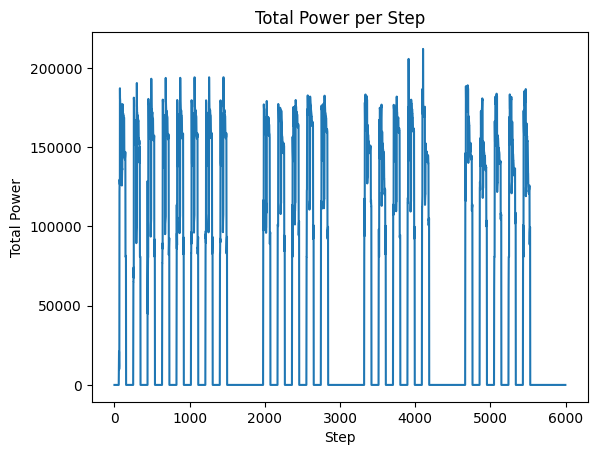

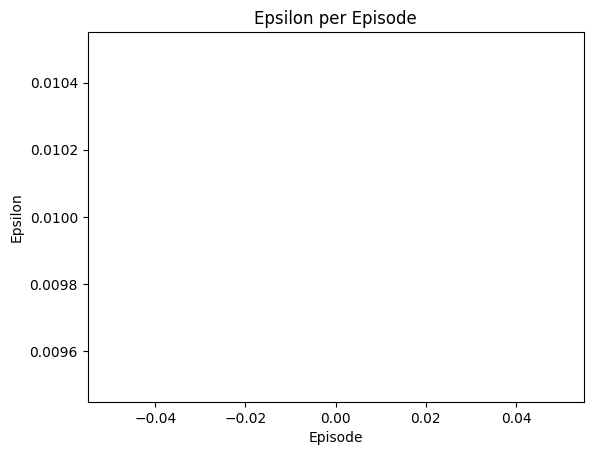

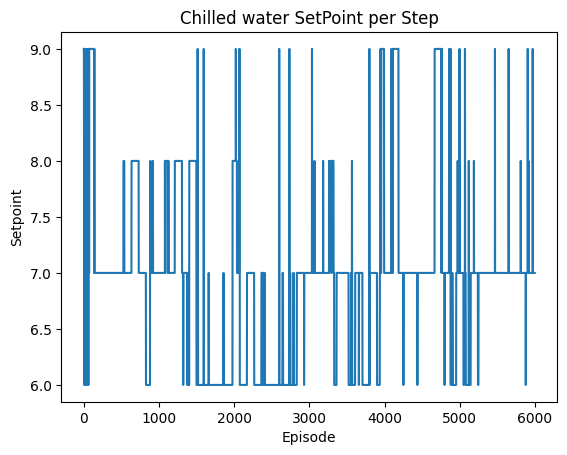

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(powers)
median_power = np.median(powers)
std_power = np.std(powers)
min_power = np.min(powers)
max_power = np.max(powers)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(powers)
plt.xlabel('Step')
plt.ylabel('Total Power')
plt.title('Total Power per Step')
plt.show()

plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode')
plt.show()

plt.plot(setpoints)
plt.xlabel('Episode')
plt.ylabel('Setpoint')
plt.title('Chilled water SetPoint per Step')
plt.show()
